A template of the RL training, with H-network trained along side the PPO agent

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707_downsampled_1min", "split")

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
# convert datetime objects to timezone-naive datetime objects
def convert_to_naive_datetimes_df(df):
    """Convert datetime objects in DataFrame to timezone-naive datetime objects"""
    df['datetime'] = df['datetime'].apply(lambda x: x.replace(tzinfo=None) if isinstance(x, datetime) else x)

    return df

def convert_to_naive_datetimes(segments):
    """Convert datetime objects in segments to timezone-naive datetime objects"""
    return [(start.replace(tzinfo=None), end.replace(tzinfo=None)) for start, end in segments]

In [6]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test') 
aggregate_load_segments_validation, aggregate_load_df_validation = load_split_data_from_folder(dataset_folder_path, 'val')

In [7]:
aggregate_load_segments_train, aggregate_load_df_train = convert_to_naive_datetimes(aggregate_load_segments_train), convert_to_naive_datetimes_df(aggregate_load_df_train)
aggregate_load_segments_test, aggregate_load_df_test = convert_to_naive_datetimes(aggregate_load_segments_test), convert_to_naive_datetimes_df(aggregate_load_df_test)
aggregate_load_segments_validation, aggregate_load_df_validation = convert_to_naive_datetimes(aggregate_load_segments_validation), convert_to_naive_datetimes_df(aggregate_load_df_validation)

In [8]:
aggregate_load_df_train

datetime   aggregate   timestamp
0      2013-01-08 00:00:05  234.000000  1357603205
1      2013-01-08 00:01:05  230.407069  1357603265
2      2013-01-08 00:02:05  230.680121  1357603325
3      2013-01-08 00:03:05  231.607379  1357603385
4      2013-01-08 00:04:05  231.280688  1357603445
...                    ...         ...         ...
231546 2013-12-30 23:55:01  176.973052  1388447701
231547 2013-12-30 23:56:01  177.850890  1388447761
231548 2013-12-30 23:57:01  177.333811  1388447821
231549 2013-12-30 23:58:01  178.462801  1388447881
231550 2013-12-30 23:59:01  178.827608  1388447941

[231551 rows x 3 columns]

In [9]:
aggregate_load_segments_train

[(datetime.datetime(2013, 1, 8, 0, 0),
  datetime.datetime(2013, 1, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 9, 0, 0),
  datetime.datetime(2013, 1, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 10, 0, 0),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 27, 0, 0),
  datetime.datetime(2013, 2, 27, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 28, 0, 0),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 8, 0, 0),
  datetime.datetime(2013, 3, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 9, 0, 0),
  datetime.datetime(2013, 3, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 10, 0, 0),
  datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 28, 0, 0),
  datetime.datetime(2013, 3, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 29, 0, 0),
  datetime.datetime(2013, 3, 29, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 30, 0, 0),
  datetime.datetim

In [10]:
from rl_env.env_data_loader import SmartMeterDataLoader

sm_dl_train = SmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_train,
    aggregate_load_df=aggregate_load_df_train
)

sm_dl_train.get_divided_segments_length()

162

In [11]:
sm_dl_train.divided_segments[7]

array([datetime.datetime(2013, 3, 10, 0, 0),
       datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)], dtype=object)

In [12]:
# sample segment

sm_dl_train.get_aggregate_load_segment(13)

timestamp   aggregate            datetime
11231  1363996805  335.000000 2013-03-23 00:00:05
11232  1363996865  317.206591 2013-03-23 00:01:05
11233  1363996925  293.301546 2013-03-23 00:02:05
11234  1363996985  276.229767 2013-03-23 00:03:05
11235  1363997045  276.501419 2013-03-23 00:04:05
...           ...         ...                 ...
12666  1364082905  173.758178 2013-03-23 23:55:05
12667  1364082965  172.392595 2013-03-23 23:56:05
12668  1364083025  174.270419 2013-03-23 23:57:05
12669  1364083085  171.201633 2013-03-23 23:58:05
12670  1364083145  174.502481 2013-03-23 23:59:05

[1440 rows x 3 columns]

In [13]:
# create dataloader for validation and test sets
sm_dl_validation = SmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_validation,
    aggregate_load_df=aggregate_load_df_validation
)

sm_dl_test = SmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_test,
    aggregate_load_df=aggregate_load_df_test
)

---

Experiment start

In [14]:
# initialize experiment folder to store related information/data for future analysis

rl_datetime = datetime.now()

experiment_folder = Path(
    "experiments", rl_datetime.strftime('%Y%m%d_%H%M%S')
)

if not experiment_folder.exists():
    experiment_folder.mkdir(parents=True)

Create the environment

In [15]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
import sys
sys.path.append(str(Path('model', 'H_network')))
from model.H_network.h_network_rl_module import HNetworkRLModule
from model.H_network.h_network_arch import HNetworkType

h_network_rl_module = HNetworkRLModule(
    h_network_type=HNetworkType.H_NETWORK,
    device=DEVICE
)

In [17]:
REWARD_LAMBDA = 0.5  # lambda for the reward function

In [18]:
sys.path.append(str(Path('rl_env')))

from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld, TrainingMode

env_train = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_train,
    h_network_rl_module=h_network_rl_module,
    mode = TrainingMode.TRAIN,
    log_folder=experiment_folder / 'logs_train',
    reward_lambda=REWARD_LAMBDA,
    # render_mode="human",
    render_mode=None,
)

In [19]:
HNetworkType.H_NETWORK2 is h_network_rl_module.h_network_type

False

In [20]:
h_network_rl_module.set_h_network(
    h_network_rl_module.initialize_h_network()
)
h_network_rl_module.initialize_h_network_training()

In [21]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env_train)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

[2025-07-24 17:56:12:598] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}
[2025-07-24 17:56:12:602] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-24 17:56:12:604] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}
[2025-07-24 17:56:12:607] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-24 17:56:12:609] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-

/root/miniforge3/envs/smartmeter/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


In [22]:
obs, info = env_train.reset()
obs

[2025-07-24 17:56:12:776] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}


{'aggregate_load': array([-0.4250123], dtype=float32),
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5 ,  0.  ,  0.25], dtype=float32)}

In [23]:
info

{'episode_index': 110,
 'current_step': 0,
 'datetime': '2013-09-26T00:00:00',
 'battery_soc (%)': 0.15000000596046448,
 'battery_soc (kWh)': 1.2000000476837158,
 'user_load (W)': 213.0,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [24]:
env_train.reset_render_window()

Also initiate a validation environment for time-to-time validation

In [25]:
# also initiate the validation environment

env_validation = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    mode=TrainingMode.VALIDATE, 
    log_folder=experiment_folder / 'logs_validation',
    reward_lambda=REWARD_LAMBDA,
    # render_mode="human",
    render_mode=None,
)

In [26]:
obs, info = env_validation.reset()

obs

[2025-07-24 17:56:12:858] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}


{'aggregate_load': array([-0.22650456], dtype=float32),
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5       ,  0.16666667,  0.41666666], dtype=float32)}

In [27]:
info

{'episode_index': 59,
 'current_step': 0,
 'datetime': '2013-11-08T00:00:05',
 'battery_soc (%)': 0.15000000596046448,
 'battery_soc (kWh)': 1.2000000476837158,
 'user_load (W)': 271.0,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [28]:
# callbacks for training
from rl_env.hrl_env_callbacks import TrainHNetworkEveryNEpisodes, SaveCheckpointEveryNEpisodes, ValidateEveryNEpisodes

2025-07-24 17:56:13.094796: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 17:56:13.104763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753376173.115675  735308 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753376173.118855  735308 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753376173.128536  735308 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [29]:
# define a custom logger

from stable_baselines3.common.logger import configure

# all logs (json files, tensorboard) will be saved in the specified foler
logger = configure(str(experiment_folder / "logs_train"), ["stdout", "json", "tensorboard"])

Logging to experiments/20250724_175610/logs_train


In [30]:
# initialize a PPO agent
from stable_baselines3 import PPO

rl_datetime = datetime.now()

rl_model = PPO(
    "MultiInputPolicy", 
    env_train, 
    verbose=2,
)

rl_model.set_logger(logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
env_train.save_env_config(env_train.log_folder.parent)

[2025-07-24 17:56:14:186] [SmartMeterWorld Train] Environment config saved to experiments/20250724_175610/logs_train/env_config.json


In [ ]:
every_n_episodes = 5
sweep_every_n_episodes = 5 * 10  # every 50 episodes

rl_model.learn(
    total_timesteps=24 * 60 * 600,  # 600 episodes, each episode is 24 hours (with 1 min sample frequency)
    progress_bar=True,
    tb_log_name="PPO_SmartMeterWorld",
    callback=[
        TrainHNetworkEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module),
        SaveCheckpointEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module, save_folder=experiment_folder / "checkpoints"),
        ValidateEveryNEpisodes(every_n_episodes=every_n_episodes * 5, sweep_every_n_episodes=sweep_every_n_episodes, validation_log_folder=experiment_folder / "logs_validation", validation_env=env_validation, h_network_rl_module=h_network_rl_module, best_model_save_path=experiment_folder / "best_model")
    ]
)

# save the training results
print_log("Saving training results...")

env_train.save_episodes_rewards(experiment_folder / "logs_train")
h_network_rl_module.save_train_loss_list(experiment_folder / "logs_train" / "h_network_train_loss_list.json")

Output()

[2025-07-24 17:56:14:219] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}


[2025-07-24 17:56:21:332] Episode 0001 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0001_info.json

[2025-07-24 17:56:21:338] Episode 0001 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0001.pkl

[2025-07-24 17:56:21:338] [SmartMeterWorld Train] Episode finished. Sum of rewards: 47.561087409102264. Mean of 
rewards: 0.033051485343365015. Std of rewards: 0.02817360069232411

[2025-07-24 17:56:21:342] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.44e+03 |
|    ep_rew_mean     | 47.6     |
| time/              |          |
|    fps             | 206      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 2048     |
---------------------------------


[2025-07-24 17:56:30:251] Episode 0002 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0002_info.json

[2025-07-24 17:56:30:256] Episode 0002 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0002.pkl

[2025-07-24 17:56:30:257] [SmartMeterWorld Train] Episode finished. Sum of rewards: 59.753549619749485. Mean of 
rewards: 0.04152435692824843. Std of rewards: 0.03983409460290823

[2025-07-24 17:56:30:262] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 53.7         |
| time/                   |              |
|    fps                  | 179          |
|    iterations           | 2            |
|    time_elapsed         | 22           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0011780548 |
|    clip_fraction        | 0.00215      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -0.335       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0375       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000813    |
|    std                  | 0.98         |
|    value_loss           | 0.134        |
------------------------------------------


[2025-07-24 17:56:39:650] Episode 0003 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0003_info.json

[2025-07-24 17:56:39:654] Episode 0003 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0003.pkl

[2025-07-24 17:56:39:655] [SmartMeterWorld Train] Episode finished. Sum of rewards: 58.811006984788186. Mean of 
rewards: 0.04086935857177775. Std of rewards: 0.03482623858121275

[2025-07-24 17:56:39:659] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-24 17:56:47:592] Episode 0004 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0004_info.json

[2025-07-24 17:56:47:597] Episode 0004 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0004.pkl

[2025-07-24 17:56:47:597] [SmartMeterWorld Train] Episode finished. Sum of rewards: 53.2666472444849. Mean of 
rewards: 0.03701643310944051. Std of rewards: 0.039909561170212236

[2025-07-24 17:56:47:602] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 54.8         |
| time/                   |              |
|    fps                  | 171          |
|    iterations           | 3            |
|    time_elapsed         | 35           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0010509256 |
|    clip_fraction        | 0.00483      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -0.166       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0596       |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.000937    |
|    std                  | 0.993        |
|    value_loss           | 0.131        |
------------------------------------------


[2025-07-24 17:56:57:359] Episode 0005 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0005_info.json

[2025-07-24 17:56:57:364] Episode 0005 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0005.pkl

[2025-07-24 17:56:57:364] [SmartMeterWorld Train] Episode finished. Sum of rewards: 131.0679329059421. Mean of 
rewards: 0.09108264969141215. Std of rewards: 0.06664724126042056

[2025-07-24 17:56:57:369] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-24 17:56:57:370] Training H-network...

[2025-07-24 17:56:57:416] H-network training (mean, std, num_batches): (0.54995590, 0.03904724, 2)

[2025-07-24 17:56:57:430] Models saved at experiments/20250724_175610/checkpoints/episode_0005/h_network_0005.pth 
and experiments/20250724_175610/checkpoints/episode_0005/rl_model_0005.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 70.1        |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 4           |
|    time_elapsed         | 48          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.003981678 |
|    clip_fraction        | 0.0164      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0653      |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00352    |
|    std                  | 0.97        |
|    value_loss           | 0.245       |
-----------------------------------------


[2025-07-24 17:57:07:006] Episode 0006 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0006_info.json

[2025-07-24 17:57:07:010] Episode 0006 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0006.pkl

[2025-07-24 17:57:07:011] [SmartMeterWorld Train] Episode finished. Sum of rewards: 50.79212343646952. Mean of 
rewards: 0.03529681962228597. Std of rewards: 0.03605826047004161

[2025-07-24 17:57:07:016] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-24 17:57:15:701] Episode 0007 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0007_info.json

[2025-07-24 17:57:15:705] Episode 0007 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0007.pkl

[2025-07-24 17:57:15:706] [SmartMeterWorld Train] Episode finished. Sum of rewards: 64.61844392800035. Mean of 
rewards: 0.04490510349409336. Std of rewards: 0.03729118935229248

[2025-07-24 17:57:15:710] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 66.6         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 5            |
|    time_elapsed         | 62           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0022585704 |
|    clip_fraction        | 0.019        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.516        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.143        |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00283     |
|    std                  | 0.96         |
|    value_loss           | 0.274        |
------------------------------------------


[2025-07-24 17:57:25:482] Episode 0008 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0008_info.json

[2025-07-24 17:57:25:487] Episode 0008 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0008.pkl

[2025-07-24 17:57:25:488] [SmartMeterWorld Train] Episode finished. Sum of rewards: 79.28075614742185. Mean of 
rewards: 0.055094340616693445. Std of rewards: 0.04382826586547208

[2025-07-24 17:57:25:492] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 68.1         |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 6            |
|    time_elapsed         | 75           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0023951298 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.784        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0491       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00206     |
|    std                  | 0.953        |
|    value_loss           | 0.155        |
------------------------------------------


[2025-07-24 17:57:34:936] Episode 0009 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0009_info.json

[2025-07-24 17:57:34:941] Episode 0009 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0009.pkl

[2025-07-24 17:57:34:941] [SmartMeterWorld Train] Episode finished. Sum of rewards: 49.38058609666525. Mean of 
rewards: 0.03431590416724479. Std of rewards: 0.028053841648986777

[2025-07-24 17:57:34:945] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 66.1        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 7           |
|    time_elapsed         | 88          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.004321681 |
|    clip_fraction        | 0.0272      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.089       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00208    |
|    std                  | 0.944       |
|    value_loss           | 0.201       |
-----------------------------------------


[2025-07-24 17:57:44:342] Episode 0010 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0010_info.json

[2025-07-24 17:57:44:347] Episode 0010 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0010.pkl

[2025-07-24 17:57:44:348] [SmartMeterWorld Train] Episode finished. Sum of rewards: 53.82909412319472. Mean of 
rewards: 0.03740729264989209. Std of rewards: 0.034650881901819364

[2025-07-24 17:57:44:352] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-24 17:57:44:353] Training H-network...

[2025-07-24 17:57:44:383] H-network training (mean, std, num_batches): (0.55528429, 0.01568231, 2)

[2025-07-24 17:57:44:397] Models saved at experiments/20250724_175610/checkpoints/episode_0010/h_network_0010.pth 
and experiments/20250724_175610/checkpoints/episode_0010/rl_model_0010.zip

[2025-07-24 17:57:52:471] Episode 0011 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0011_info.json

[2025-07-24 17:57:52:475] Episode 0011 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0011.pkl

[2025-07-24 17:57:52:476] [SmartMeterWorld Train] Episode finished. Sum of rewards: 128.79705352494082. Mean of 
rewards: 0.0895045542216406. Std of rewards: 0.06637957475919784

[2025-07-24 17:57:52:480] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 70.7        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 8           |
|    time_elapsed         | 101         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.003597072 |
|    clip_fraction        | 0.0229      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0213      |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00201    |
|    std                  | 0.939       |
|    value_loss           | 0.0667      |
-----------------------------------------


[2025-07-24 17:58:01:364] Episode 0012 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0012_info.json

[2025-07-24 17:58:01:369] Episode 0012 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0012.pkl

[2025-07-24 17:58:01:369] [SmartMeterWorld Train] Episode finished. Sum of rewards: 62.19691861324784. Mean of 
rewards: 0.04322232009259753. Std of rewards: 0.027496210808005187

[2025-07-24 17:58:01:374] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 69.9         |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 9            |
|    time_elapsed         | 113          |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0014122464 |
|    clip_fraction        | 0.00708      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.332        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.151        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.000906    |
|    std                  | 0.941        |
|    value_loss           | 0.57         |
------------------------------------------


[2025-07-24 17:58:09:981] Episode 0013 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0013_info.json

[2025-07-24 17:58:09:986] Episode 0013 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0013.pkl

[2025-07-24 17:58:09:986] [SmartMeterWorld Train] Episode finished. Sum of rewards: 73.16050440765042. Mean of 
rewards: 0.05084121223603226. Std of rewards: 0.045240231690259695

[2025-07-24 17:58:09:991] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-24 17:58:18:020] Episode 0014 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0014_info.json

[2025-07-24 17:58:18:025] Episode 0014 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0014.pkl

[2025-07-24 17:58:18:026] [SmartMeterWorld Train] Episode finished. Sum of rewards: 137.62380550787427. Mean of 
rewards: 0.09563850278518016. Std of rewards: 0.05038194753091826

[2025-07-24 17:58:18:030] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 75           |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 10           |
|    time_elapsed         | 125          |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0024573961 |
|    clip_fraction        | 0.0113       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.909        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.043        |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.000724    |
|    std                  | 0.93         |
|    value_loss           | 0.147        |
------------------------------------------


[2025-07-24 17:58:27:011] Episode 0015 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0015_info.json

[2025-07-24 17:58:27:016] Episode 0015 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0015.pkl

[2025-07-24 17:58:27:016] [SmartMeterWorld Train] Episode finished. Sum of rewards: 54.04695623837124. Mean of 
rewards: 0.037558690923121085. Std of rewards: 0.032896459429696254

[2025-07-24 17:58:27:020] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

[2025-07-24 17:58:27:021] Training H-network...

[2025-07-24 17:58:27:051] H-network training (mean, std, num_batches): (0.53021461, 0.01886988, 2)

[2025-07-24 17:58:27:058] Models saved at experiments/20250724_175610/checkpoints/episode_0015/h_network_0015.pth 
and experiments/20250724_175610/checkpoints/episode_0015/rl_model_0015.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 73.6        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 11          |
|    time_elapsed         | 138         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.002763398 |
|    clip_fraction        | 0.0103      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.67        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.000679   |
|    std                  | 0.927       |
|    value_loss           | 0.286       |
-----------------------------------------


[2025-07-24 17:58:36:811] Episode 0016 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0016_info.json

[2025-07-24 17:58:36:816] Episode 0016 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0016.pkl

[2025-07-24 17:58:36:816] [SmartMeterWorld Train] Episode finished. Sum of rewards: 82.51539579322127. Mean of 
rewards: 0.0573421791474783. Std of rewards: 0.04703144595399355

[2025-07-24 17:58:36:822] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-24 17:58:44:469] Episode 0017 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0017_info.json

[2025-07-24 17:58:44:474] Episode 0017 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0017.pkl

[2025-07-24 17:58:44:474] [SmartMeterWorld Train] Episode finished. Sum of rewards: 60.13679786871564. Mean of 
rewards: 0.04179068649667522. Std of rewards: 0.04339520395639879

[2025-07-24 17:58:44:478] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 73.3         |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 12           |
|    time_elapsed         | 150          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0013759495 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.816        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0951       |
|    n_updates            | 110          |
|    policy_gradient_loss | 0.000223     |
|    std                  | 0.932        |
|    value_loss           | 0.153        |
------------------------------------------


[2025-07-24 17:58:53:632] Episode 0018 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0018_info.json

[2025-07-24 17:58:53:637] Episode 0018 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0018.pkl

[2025-07-24 17:58:53:637] [SmartMeterWorld Train] Episode finished. Sum of rewards: 57.218142963264874. Mean of 
rewards: 0.039762434303867174. Std of rewards: 0.0372371913834703

[2025-07-24 17:58:53:641] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 72.4         |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 13           |
|    time_elapsed         | 163          |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0017844806 |
|    clip_fraction        | 0.0112       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.821        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.129        |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00107     |
|    std                  | 0.933        |
|    value_loss           | 0.276        |
------------------------------------------


[2025-07-24 17:59:03:410] Episode 0019 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0019_info.json

[2025-07-24 17:59:03:414] Episode 0019 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0019.pkl

[2025-07-24 17:59:03:415] [SmartMeterWorld Train] Episode finished. Sum of rewards: 48.403895253842634. Mean of 
rewards: 0.03363717529801434. Std of rewards: 0.03349543136289435

[2025-07-24 17:59:03:419] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 71.2         |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 14           |
|    time_elapsed         | 176          |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0022525482 |
|    clip_fraction        | 0.0105       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.868        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0831       |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00132     |
|    std                  | 0.937        |
|    value_loss           | 0.162        |
------------------------------------------


[2025-07-24 17:59:12:579] Episode 0020 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0020_info.json

[2025-07-24 17:59:12:583] Episode 0020 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0020.pkl

[2025-07-24 17:59:12:584] [SmartMeterWorld Train] Episode finished. Sum of rewards: 55.23484139840684. Mean of 
rewards: 0.03838418443252734. Std of rewards: 0.04013725199259588

[2025-07-24 17:59:12:588] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-24 17:59:12:588] Training H-network...

[2025-07-24 17:59:12:619] H-network training (mean, std, num_batches): (0.47645526, 0.01174076, 2)

[2025-07-24 17:59:12:630] Models saved at experiments/20250724_175610/checkpoints/episode_0020/h_network_0020.pth 
and experiments/20250724_175610/checkpoints/episode_0020/rl_model_0020.zip

[2025-07-24 17:59:20:674] Episode 0021 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0021_info.json

[2025-07-24 17:59:20:679] Episode 0021 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0021.pkl

[2025-07-24 17:59:20:680] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.0898829519921. Mean of 
rewards: 0.07997907084919535. Std of rewards: 0.060054313315256055

[2025-07-24 17:59:20:684] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 72.5         |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 15           |
|    time_elapsed         | 188          |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0025311923 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.9          |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0615       |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.0017      |
|    std                  | 0.926        |
|    value_loss           | 0.163        |
------------------------------------------


[2025-07-24 17:59:30:345] Episode 0022 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0022_info.json

[2025-07-24 17:59:30:350] Episode 0022 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0022.pkl

[2025-07-24 17:59:30:351] [SmartMeterWorld Train] Episode finished. Sum of rewards: 57.257614404425254. Mean of 
rewards: 0.03978986407534764. Std of rewards: 0.03462328712234843

[2025-07-24 17:59:30:355] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 71.8         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 16           |
|    time_elapsed         | 203          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0033250665 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.34        |
|    explained_variance   | 0.774        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.184        |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00217     |
|    std                  | 0.917        |
|    value_loss           | 0.408        |
------------------------------------------


[2025-07-24 17:59:41:534] Episode 0023 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0023_info.json

[2025-07-24 17:59:41:538] Episode 0023 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0023.pkl

[2025-07-24 17:59:41:539] [SmartMeterWorld Train] Episode finished. Sum of rewards: 58.059368432288416. Mean of 
rewards: 0.04034702462285505. Std of rewards: 0.03498586353953347

[2025-07-24 17:59:41:543] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-24 17:59:50:634] Episode 0024 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0024_info.json

[2025-07-24 17:59:50:638] Episode 0024 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0024.pkl

[2025-07-24 17:59:50:638] [SmartMeterWorld Train] Episode finished. Sum of rewards: 46.56663837264049. Mean of 
rewards: 0.03236041582532349. Std of rewards: 0.030305977311988058

[2025-07-24 17:59:50:642] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 70.2         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 17           |
|    time_elapsed         | 217          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0034565914 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.094        |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00259     |
|    std                  | 0.902        |
|    value_loss           | 0.107        |
------------------------------------------


[2025-07-24 18:00:00:491] Episode 0025 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0025_info.json

[2025-07-24 18:00:00:495] Episode 0025 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0025.pkl

[2025-07-24 18:00:00:496] [SmartMeterWorld Train] Episode finished. Sum of rewards: 48.806088404063814. Mean of 
rewards: 0.03391667019045436. Std of rewards: 0.03133964776525372

[2025-07-24 18:00:00:500] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

[2025-07-24 18:00:00:501] Training H-network...

[2025-07-24 18:00:00:531] H-network training (mean, std, num_batches): (0.48219796, 0.03446935, 2)

[2025-07-24 18:00:00:539] Models saved at experiments/20250724_175610/checkpoints/episode_0025/h_network_0025.pth 
and experiments/20250724_175610/checkpoints/episode_0025/rl_model_0025.zip

[2025-07-24 18:00:00:540] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0025

[2025-07-24 18:00:00:540] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 18:00:00:544] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 18:00:08:683] Episode 0001 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0001_info.json

[2025-07-24 18:00:08:693] Episode 0001 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0001.pkl

[2025-07-24 18:00:08:694] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 46.607238936129434. Mean of 
rewards: 0.03238863025443324. Std of rewards: 0.023699885124628076

[2025-07-24 18:00:08:698] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 18:00:16:169] Episode 0002 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0002_info.json

[2025-07-24 18:00:16:174] Episode 0002 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0002.pkl

[2025-07-24 18:00:16:175] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 84.5686438498641. Mean of 
rewards: 0.05876903672679925. Std of rewards: 0.03667574326877475

[2025-07-24 18:00:16:179] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 18:00:23:821] Episode 0003 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0003_info.json

[2025-07-24 18:00:23:826] Episode 0003 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0003.pkl

[2025-07-24 18:00:23:827] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 74.44910183270018. Mean of 
rewards: 0.05173669342091742. Std of rewards: 0.048842185948010236

[2025-07-24 18:00:23:833] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 18:00:31:388] Episode 0004 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0004_info.json

[2025-07-24 18:00:31:392] Episode 0004 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0004.pkl

[2025-07-24 18:00:31:393] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 61.43745909503674. Mean of 
rewards: 0.0426945511431805. Std of rewards: 0.0386189747645421

[2025-07-24 18:00:31:397] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 18:00:38:625] Episode 0005 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0005_info.json

[2025-07-24 18:00:38:631] Episode 0005 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0005.pkl

[2025-07-24 18:00:38:631] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.33353143498726. Mean of 
rewards: 0.062080285917294836. Std of rewards: 0.05164434548391603

[2025-07-24 18:00:38:636] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 18:00:46:835] Episode 0006 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0006_info.json

[2025-07-24 18:00:46:841] Episode 0006 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0006.pkl

[2025-07-24 18:00:46:841] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 174.5138693022386. Mean of 
rewards: 0.12127440535249383. Std of rewards: 0.05848267407585486

[2025-07-24 18:00:46:845] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 18:00:54:019] Episode 0007 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0007_info.json

[2025-07-24 18:00:54:024] Episode 0007 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0007.pkl

[2025-07-24 18:00:54:025] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 58.4857868987681. Mean of 
rewards: 0.04064335434243787. Std of rewards: 0.03312947101343996

[2025-07-24 18:00:54:029] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 18:01:01:322] Episode 0008 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0008_info.json

[2025-07-24 18:01:01:327] Episode 0008 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0008.pkl

[2025-07-24 18:01:01:328] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 48.66813665077855. Mean of 
rewards: 0.033820803787893365. Std of rewards: 0.034294025675651804

[2025-07-24 18:01:01:332] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 18:01:08:986] Episode 0009 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0009_info.json

[2025-07-24 18:01:08:991] Episode 0009 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0009.pkl

[2025-07-24 18:01:08:991] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 47.08902928831587. Mean of 
rewards: 0.03272343939424313. Std of rewards: 0.028224895000981746

[2025-07-24 18:01:08:996] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 18:01:16:950] Episode 0010 info saved to 
experiments/20250724_175610/logs_validation/episode_0025/episode_info/episode_0010_info.json

[2025-07-24 18:01:16:955] Episode 0010 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0025/episodes_df/episode_0010.pkl

[2025-07-24 18:01:16:955] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 56.79904199332674. Mean of 
rewards: 0.039471189710442486. Std of rewards: 0.029453576414931005

[2025-07-24 18:01:16:956] Quick Validation Results (N=10 episodes):

[2025-07-24 18:01:16:957]   Reward - Mean: 74.1952 ± 36.4147

[2025-07-24 18:01:16:957]   Episode Length - Mean: 1439.00

[2025-07-24 18:01:16:958] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0025.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 69.3         |
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 18           |
|    time_elapsed         | 307          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0051433677 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.861        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0981       |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00313     |
|    std                  | 0.898        |
|    value_loss           | 0.226        |
------------------------------------------


[2025-07-24 18:01:26:199] Episode 0026 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0026_info.json

[2025-07-24 18:01:26:204] Episode 0026 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0026.pkl

[2025-07-24 18:01:26:205] [SmartMeterWorld Train] Episode finished. Sum of rewards: 42.25854798521632. Mean of 
rewards: 0.02936660735595296. Std of rewards: 0.03319137830072728

[2025-07-24 18:01:26:209] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-24 18:01:34:342] Episode 0027 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0027_info.json

[2025-07-24 18:01:34:347] Episode 0027 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0027.pkl

[2025-07-24 18:01:34:347] [SmartMeterWorld Train] Episode finished. Sum of rewards: 59.79650396184682. Mean of 
rewards: 0.04155420706174205. Std of rewards: 0.03986332188725028

[2025-07-24 18:01:34:351] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 68         |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 19         |
|    time_elapsed         | 320        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.00309968 |
|    clip_fraction        | 0.0276     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0313     |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.00313   |
|    std                  | 0.911      |
|    value_loss           | 0.0608     |
----------------------------------------


[2025-07-24 18:01:43:640] Episode 0028 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0028_info.json

[2025-07-24 18:01:43:644] Episode 0028 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0028.pkl

[2025-07-24 18:01:43:645] [SmartMeterWorld Train] Episode finished. Sum of rewards: 61.938251369057156. Mean of 
rewards: 0.04304256523214535. Std of rewards: 0.04362475751134203

[2025-07-24 18:01:43:650] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 67.8         |
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 20           |
|    time_elapsed         | 333          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0033729814 |
|    clip_fraction        | 0.026        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.935        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0498       |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00289     |
|    std                  | 0.91         |
|    value_loss           | 0.112        |
------------------------------------------


[2025-07-24 18:01:53:807] Episode 0029 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0029_info.json

[2025-07-24 18:01:53:811] Episode 0029 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0029.pkl

[2025-07-24 18:01:53:812] [SmartMeterWorld Train] Episode finished. Sum of rewards: 72.70081633131356. Mean of 
rewards: 0.05052176256519357. Std of rewards: 0.04762829009837749

[2025-07-24 18:01:53:816] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 67.9        |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 21          |
|    time_elapsed         | 346         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.003871355 |
|    clip_fraction        | 0.0248      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.088       |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00293    |
|    std                  | 0.891       |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-24 18:02:02:819] Episode 0030 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0030_info.json

[2025-07-24 18:02:02:824] Episode 0030 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0030.pkl

[2025-07-24 18:02:02:824] [SmartMeterWorld Train] Episode finished. Sum of rewards: 56.787864496656795. Mean of 
rewards: 0.039463422165849055. Std of rewards: 0.03785557041450471

[2025-07-24 18:02:02:829] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-24 18:02:02:829] Training H-network...

[2025-07-24 18:02:02:860] H-network training (mean, std, num_batches): (0.41481072, 0.00193438, 2)

[2025-07-24 18:02:02:874] Models saved at experiments/20250724_175610/checkpoints/episode_0030/h_network_0030.pth 
and experiments/20250724_175610/checkpoints/episode_0030/rl_model_0030.zip

[2025-07-24 18:02:11:232] Episode 0031 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0031_info.json

[2025-07-24 18:02:11:236] Episode 0031 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0031.pkl

[2025-07-24 18:02:11:237] [SmartMeterWorld Train] Episode finished. Sum of rewards: 64.60126527228424. Mean of 
rewards: 0.04489316558185145. Std of rewards: 0.04713688905048483

[2025-07-24 18:02:11:241] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 67.5         |
| time/                   |              |
|    fps                  | 125          |
|    iterations           | 22           |
|    time_elapsed         | 359          |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0032953385 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0469       |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00201     |
|    std                  | 0.879        |
|    value_loss           | 0.128        |
------------------------------------------


[2025-07-24 18:02:21:534] Episode 0032 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0032_info.json

[2025-07-24 18:02:21:541] Episode 0032 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0032.pkl

[2025-07-24 18:02:21:541] [SmartMeterWorld Train] Episode finished. Sum of rewards: 71.31351122503219. Mean of 
rewards: 0.04955768674428922. Std of rewards: 0.050428169083273564

[2025-07-24 18:02:21:545] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 67.6        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 23          |
|    time_elapsed         | 373         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.004786762 |
|    clip_fraction        | 0.0412      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0518      |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00386    |
|    std                  | 0.877       |
|    value_loss           | 0.159       |
-----------------------------------------


[2025-07-24 18:02:31:011] Episode 0033 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0033_info.json

[2025-07-24 18:02:31:015] Episode 0033 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0033.pkl

[2025-07-24 18:02:31:016] [SmartMeterWorld Train] Episode finished. Sum of rewards: 47.71617813463993. Mean of 
rewards: 0.03315926208105624. Std of rewards: 0.03719383347395133

[2025-07-24 18:02:31:020] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-24 18:02:39:438] Episode 0034 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0034_info.json

[2025-07-24 18:02:39:444] Episode 0034 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0034.pkl

[2025-07-24 18:02:39:445] [SmartMeterWorld Train] Episode finished. Sum of rewards: 47.28130576946761. Mean of 
rewards: 0.03285705751874052. Std of rewards: 0.04043482447764869

[2025-07-24 18:02:39:449] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 66.4         |
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 24           |
|    time_elapsed         | 386          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0038541604 |
|    clip_fraction        | 0.0305       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0445       |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00346     |
|    std                  | 0.872        |
|    value_loss           | 0.0803       |
------------------------------------------


[2025-07-24 18:02:48:694] Episode 0035 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0035_info.json

[2025-07-24 18:02:48:698] Episode 0035 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0035.pkl

[2025-07-24 18:02:48:699] [SmartMeterWorld Train] Episode finished. Sum of rewards: 57.398921292074355. Mean of 
rewards: 0.03988806205147628. Std of rewards: 0.04181623155346842

[2025-07-24 18:02:48:703] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-24 18:02:48:704] Training H-network...

[2025-07-24 18:02:48:735] H-network training (mean, std, num_batches): (0.38007660, 0.01676847, 2)

[2025-07-24 18:02:48:749] Models saved at experiments/20250724_175610/checkpoints/episode_0035/h_network_0035.pth 
and experiments/20250724_175610/checkpoints/episode_0035/rl_model_0035.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 66.2         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 25           |
|    time_elapsed         | 399          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0047278926 |
|    clip_fraction        | 0.0439       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0436       |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00411     |
|    std                  | 0.869        |
|    value_loss           | 0.0675       |
------------------------------------------


[2025-07-24 18:02:59:122] Episode 0036 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0036_info.json

[2025-07-24 18:02:59:127] Episode 0036 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0036.pkl

[2025-07-24 18:02:59:128] [SmartMeterWorld Train] Episode finished. Sum of rewards: 67.73111104621788. Mean of 
rewards: 0.04706818001821951. Std of rewards: 0.0582783069984871

[2025-07-24 18:02:59:132] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

[2025-07-24 18:03:07:456] Episode 0037 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0037_info.json

[2025-07-24 18:03:07:462] Episode 0037 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0037.pkl

[2025-07-24 18:03:07:462] [SmartMeterWorld Train] Episode finished. Sum of rewards: 53.98098548308295. Mean of 
rewards: 0.03751284606190615. Std of rewards: 0.0480133245612883

[2025-07-24 18:03:07:470] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.9         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 26           |
|    time_elapsed         | 413          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0031671422 |
|    clip_fraction        | 0.0448       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.954        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0372       |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00401     |
|    std                  | 0.866        |
|    value_loss           | 0.0759       |
------------------------------------------


[2025-07-24 18:03:17:235] Episode 0038 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0038_info.json

[2025-07-24 18:03:17:241] Episode 0038 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0038.pkl

[2025-07-24 18:03:17:241] [SmartMeterWorld Train] Episode finished. Sum of rewards: 59.55432480182102. Mean of 
rewards: 0.04138591021669285. Std of rewards: 0.05453124212282263

[2025-07-24 18:03:17:246] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.7         |
| time/                   |              |
|    fps                  | 129          |
|    iterations           | 27           |
|    time_elapsed         | 426          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0026543431 |
|    clip_fraction        | 0.0142       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0419       |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.000628    |
|    std                  | 0.867        |
|    value_loss           | 0.119        |
------------------------------------------


[2025-07-24 18:03:27:735] Episode 0039 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0039_info.json

[2025-07-24 18:03:27:740] Episode 0039 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0039.pkl

[2025-07-24 18:03:27:740] [SmartMeterWorld Train] Episode finished. Sum of rewards: 53.09172550518303. Mean of 
rewards: 0.03689487526419946. Std of rewards: 0.049490806802569655

[2025-07-24 18:03:27:745] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.4         |
| time/                   |              |
|    fps                  | 130          |
|    iterations           | 28           |
|    time_elapsed         | 440          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0049389107 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0113       |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.00561     |
|    std                  | 0.843        |
|    value_loss           | 0.0859       |
------------------------------------------


[2025-07-24 18:03:36:829] Episode 0040 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0040_info.json

[2025-07-24 18:03:36:834] Episode 0040 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0040.pkl

[2025-07-24 18:03:36:835] [SmartMeterWorld Train] Episode finished. Sum of rewards: 52.15205408310732. Mean of 
rewards: 0.03624187219117952. Std of rewards: 0.049053016336524896

[2025-07-24 18:03:36:840] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

[2025-07-24 18:03:36:841] Training H-network...

[2025-07-24 18:03:36:859] H-network training (mean, std, num_batches): (0.39635368, 0.03875054, 2)

[2025-07-24 18:03:36:866] Models saved at experiments/20250724_175610/checkpoints/episode_0040/h_network_0040.pth 
and experiments/20250724_175610/checkpoints/episode_0040/rl_model_0040.zip

[2025-07-24 18:03:44:334] Episode 0041 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0041_info.json

[2025-07-24 18:03:44:339] Episode 0041 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0041.pkl

[2025-07-24 18:03:44:339] [SmartMeterWorld Train] Episode finished. Sum of rewards: 79.64219446485816. Mean of 
rewards: 0.055345513874119644. Std of rewards: 0.0634519991263464

[2025-07-24 18:03:44:344] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.4         |
| time/                   |              |
|    fps                  | 131          |
|    iterations           | 29           |
|    time_elapsed         | 451          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0057477043 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0487       |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00219     |
|    std                  | 0.829        |
|    value_loss           | 0.0603       |
------------------------------------------


[2025-07-24 18:03:53:382] Episode 0042 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0042_info.json

[2025-07-24 18:03:53:387] Episode 0042 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0042.pkl

[2025-07-24 18:03:53:387] [SmartMeterWorld Train] Episode finished. Sum of rewards: 77.83990536188217. Mean of 
rewards: 0.05409305445579024. Std of rewards: 0.05552266862639713

[2025-07-24 18:03:53:392] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 65.7        |
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 30          |
|    time_elapsed         | 465         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.003958579 |
|    clip_fraction        | 0.0381      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0594      |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00172    |
|    std                  | 0.831       |
|    value_loss           | 0.157       |
-----------------------------------------


[2025-07-24 18:04:03:658] Episode 0043 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0043_info.json

[2025-07-24 18:04:03:664] Episode 0043 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0043.pkl

[2025-07-24 18:04:03:665] [SmartMeterWorld Train] Episode finished. Sum of rewards: 70.11562348813693. Mean of 
rewards: 0.04872524217382691. Std of rewards: 0.05665744676960178

[2025-07-24 18:04:03:670] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-24 18:04:11:383] Episode 0044 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0044_info.json

[2025-07-24 18:04:11:387] Episode 0044 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0044.pkl

[2025-07-24 18:04:11:388] [SmartMeterWorld Train] Episode finished. Sum of rewards: 67.51058359130889. Mean of 
rewards: 0.0469149295283592. Std of rewards: 0.054160679162635915

[2025-07-24 18:04:11:392] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.8         |
| time/                   |              |
|    fps                  | 132          |
|    iterations           | 31           |
|    time_elapsed         | 477          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0026544163 |
|    clip_fraction        | 0.03         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0689       |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00312     |
|    std                  | 0.834        |
|    value_loss           | 0.114        |
------------------------------------------


[2025-07-24 18:04:15:600] Episode 0045 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0045_info.json

[2025-07-24 18:04:15:603] Episode 0045 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0045.pkl

[2025-07-24 18:04:15:603] [SmartMeterWorld Train] Episode finished. Sum of rewards: 49.76283947034433. Mean of 
rewards: 0.07191161773171147. Std of rewards: 0.060808607947744696

[2025-07-24 18:04:15:608] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-24 18:04:15:609] Training H-network...

[2025-07-24 18:04:15:642] H-network training (mean, std, num_batches): (0.27026350, 0.06155439, 2)

[2025-07-24 18:04:15:652] Models saved at experiments/20250724_175610/checkpoints/episode_0045/h_network_0045.pth 
and experiments/20250724_175610/checkpoints/episode_0045/rl_model_0045.zip

[2025-07-24 18:04:22:403] Episode 0046 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0046_info.json

[2025-07-24 18:04:22:408] Episode 0046 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0046.pkl

[2025-07-24 18:04:22:408] [SmartMeterWorld Train] Episode finished. Sum of rewards: 64.0578364307142. Mean of 
rewards: 0.044515522189516474. Std of rewards: 0.05675124327651594

[2025-07-24 18:04:22:412] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 65.5         |
| time/                   |              |
|    fps                  | 134          |
|    iterations           | 32           |
|    time_elapsed         | 488          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0037814458 |
|    clip_fraction        | 0.0257       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.22        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0817       |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00349     |
|    std                  | 0.815        |
|    value_loss           | 0.116        |
------------------------------------------


[2025-07-24 18:04:33:118] Episode 0047 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0047_info.json

[2025-07-24 18:04:33:123] Episode 0047 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0047.pkl

[2025-07-24 18:04:33:123] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.2128178240183. Mean of 
rewards: 0.08006450161502314. Std of rewards: 0.0675916126889015

[2025-07-24 18:04:33:127] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 66.5        |
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 33          |
|    time_elapsed         | 502         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.004475795 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0761      |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00125    |
|    std                  | 0.807       |
|    value_loss           | 0.146       |
-----------------------------------------


[2025-07-24 18:04:41:803] Episode 0048 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0048_info.json

[2025-07-24 18:04:41:807] Episode 0048 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0048.pkl

[2025-07-24 18:04:41:808] [SmartMeterWorld Train] Episode finished. Sum of rewards: 69.91778009956946. Mean of 
rewards: 0.04858775545487801. Std of rewards: 0.05821389939170528

[2025-07-24 18:04:41:812] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 66.6         |
| time/                   |              |
|    fps                  | 135          |
|    iterations           | 34           |
|    time_elapsed         | 513          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0038667289 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.2         |
|    explained_variance   | 0.89         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.121        |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.000775    |
|    std                  | 0.808        |
|    value_loss           | 0.285        |
------------------------------------------


[2025-07-24 18:04:49:984] Episode 0049 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0049_info.json

[2025-07-24 18:04:49:989] Episode 0049 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0049.pkl

[2025-07-24 18:04:49:990] [SmartMeterWorld Train] Episode finished. Sum of rewards: 74.13239080723112. Mean of 
rewards: 0.05151660236777702. Std of rewards: 0.058670753622289205

[2025-07-24 18:04:49:995] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-24 18:04:53:226] Episode 0050 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0050_info.json

[2025-07-24 18:04:53:229] Episode 0050 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0050.pkl

[2025-07-24 18:04:53:229] [SmartMeterWorld Train] Episode finished. Sum of rewards: 53.747515536287644. Mean of 
rewards: 0.07766982013914399. Std of rewards: 0.06512341266424378

[2025-07-24 18:04:53:234] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-24 18:04:53:235] Training H-network...

[2025-07-24 18:04:53:264] H-network training (mean, std, num_batches): (0.30476877, 0.03391367, 2)

[2025-07-24 18:04:53:271] Models saved at experiments/20250724_175610/checkpoints/episode_0050/h_network_0050.pth 
and experiments/20250724_175610/checkpoints/episode_0050/rl_model_0050.zip

[2025-07-24 18:04:53:272] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0050

[2025-07-24 18:04:53:273] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 18:04:53:277] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 18:05:00:359] Episode 0011 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0011_info.json

[2025-07-24 18:05:00:364] Episode 0011 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0011.pkl

[2025-07-24 18:05:00:364] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.03041004053361. Mean of 
rewards: 0.06395441976409563. Std of rewards: 0.06505887129624945

[2025-07-24 18:05:00:368] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 18:05:08:581] Episode 0012 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0012_info.json

[2025-07-24 18:05:08:586] Episode 0012 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0012.pkl

[2025-07-24 18:05:08:587] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.61469359932754. Mean of 
rewards: 0.08381841111836522. Std of rewards: 0.06812261932366172

[2025-07-24 18:05:08:591] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 18:05:10:787] Episode 0013 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0013_info.json

[2025-07-24 18:05:10:789] Episode 0013 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0013.pkl

[2025-07-24 18:05:10:790] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 54.44110638687616. Mean of 
rewards: 0.10976029513483096. Std of rewards: 0.06473052427481386

[2025-07-24 18:05:10:793] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 18:05:17:883] Episode 0014 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0014_info.json

[2025-07-24 18:05:17:887] Episode 0014 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0014.pkl

[2025-07-24 18:05:17:888] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.89478126457975. Mean of 
rewards: 0.06802972985724791. Std of rewards: 0.06451159527472977

[2025-07-24 18:05:17:892] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 18:05:25:289] Episode 0015 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0015_info.json

[2025-07-24 18:05:25:294] Episode 0015 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0015.pkl

[2025-07-24 18:05:25:294] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.1356391378063. Mean of 
rewards: 0.07653623289632126. Std of rewards: 0.06434338917724795

[2025-07-24 18:05:25:299] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 18:05:33:245] Episode 0016 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0016_info.json

[2025-07-24 18:05:33:250] Episode 0016 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0016.pkl

[2025-07-24 18:05:33:251] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.96479792291242. Mean of 
rewards: 0.07155302148916777. Std of rewards: 0.06161410861726433

[2025-07-24 18:05:33:255] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 18:05:41:967] Episode 0017 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0017_info.json

[2025-07-24 18:05:41:972] Episode 0017 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0017.pkl

[2025-07-24 18:05:41:972] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.22734334339627. Mean of 
rewards: 0.07798981469311764. Std of rewards: 0.06634456501872782

[2025-07-24 18:05:41:976] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 18:05:49:215] Episode 0018 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0018_info.json

[2025-07-24 18:05:49:219] Episode 0018 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0018.pkl

[2025-07-24 18:05:49:219] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.20188890435942. Mean of 
rewards: 0.06893807429072928. Std of rewards: 0.06379711492387771

[2025-07-24 18:05:49:224] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 18:05:56:281] Episode 0019 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0019_info.json

[2025-07-24 18:05:56:285] Episode 0019 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0019.pkl

[2025-07-24 18:05:56:286] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.13795508613698. Mean of 
rewards: 0.07236828011545308. Std of rewards: 0.06520288931186143

[2025-07-24 18:05:56:290] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 18:06:03:228] Episode 0020 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0020_info.json

[2025-07-24 18:06:03:233] Episode 0020 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0020.pkl

[2025-07-24 18:06:03:233] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.45526914487604. Mean of 
rewards: 0.08926703901659211. Std of rewards: 0.06647407721364958

[2025-07-24 18:06:03:234] Critical validation progress: 10/73 episodes completed

[2025-07-24 18:06:03:238] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 18:06:10:245] Episode 0021 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0021_info.json

[2025-07-24 18:06:10:250] Episode 0021 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0021.pkl

[2025-07-24 18:06:10:251] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.59116889055916. Mean of 
rewards: 0.06851366844375201. Std of rewards: 0.06375639081006071

[2025-07-24 18:06:10:256] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 18:06:18:261] Episode 0022 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0022_info.json

[2025-07-24 18:06:18:265] Episode 0022 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0022.pkl

[2025-07-24 18:06:18:266] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.33991818017556. Mean of 
rewards: 0.07111877566377732. Std of rewards: 0.06329081276430236

[2025-07-24 18:06:18:270] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 18:06:25:711] Episode 0023 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0023_info.json

[2025-07-24 18:06:25:716] Episode 0023 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0023.pkl

[2025-07-24 18:06:25:716] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.93487336471104. Mean of 
rewards: 0.0659728098434406. Std of rewards: 0.06579298069552783

[2025-07-24 18:06:25:720] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 18:06:32:911] Episode 0024 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0024_info.json

[2025-07-24 18:06:32:916] Episode 0024 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0024.pkl

[2025-07-24 18:06:32:917] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.89752047655136. Mean of 
rewards: 0.07567583076897245. Std of rewards: 0.06718784670415497

[2025-07-24 18:06:32:921] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 18:06:40:294] Episode 0025 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0025_info.json

[2025-07-24 18:06:40:299] Episode 0025 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0025.pkl

[2025-07-24 18:06:40:299] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.53473122909243. Mean of 
rewards: 0.0656947402564923. Std of rewards: 0.06561166454482664

[2025-07-24 18:06:40:303] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 18:06:48:653] Episode 0026 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0026_info.json

[2025-07-24 18:06:48:660] Episode 0026 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0026.pkl

[2025-07-24 18:06:48:661] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.75277393635253. Mean of 
rewards: 0.0769650965506272. Std of rewards: 0.06417333497672692

[2025-07-24 18:06:48:667] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 18:06:56:078] Episode 0027 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0027_info.json

[2025-07-24 18:06:56:083] Episode 0027 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0027.pkl

[2025-07-24 18:06:56:083] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 86.33025266487495. Mean of 
rewards: 0.0599932263133252. Std of rewards: 0.06002874559691494

[2025-07-24 18:06:56:087] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 18:07:03:305] Episode 0028 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0028_info.json

[2025-07-24 18:07:03:310] Episode 0028 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0028.pkl

[2025-07-24 18:07:03:311] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.78033351613092. Mean of 
rewards: 0.06656034295770043. Std of rewards: 0.039451719416287945

[2025-07-24 18:07:03:316] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 18:07:10:138] Episode 0029 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0029_info.json

[2025-07-24 18:07:10:143] Episode 0029 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0029.pkl

[2025-07-24 18:07:10:143] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 117.01974815834673. Mean of 
rewards: 0.08132018635048419. Std of rewards: 0.05723518522328528

[2025-07-24 18:07:10:148] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 18:07:18:152] Episode 0030 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0030_info.json

[2025-07-24 18:07:18:157] Episode 0030 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0030.pkl

[2025-07-24 18:07:18:158] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.37863202849725. Mean of 
rewards: 0.066976116767545. Std of rewards: 0.06440080641569598

[2025-07-24 18:07:18:158] Critical validation progress: 20/73 episodes completed

[2025-07-24 18:07:18:162] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 18:07:25:419] Episode 0031 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0031_info.json

[2025-07-24 18:07:25:423] Episode 0031 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0031.pkl

[2025-07-24 18:07:25:424] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.54889610873089. Mean of 
rewards: 0.07056907304289846. Std of rewards: 0.051245930125997104

[2025-07-24 18:07:25:428] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 18:07:32:401] Episode 0032 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0032_info.json

[2025-07-24 18:07:32:406] Episode 0032 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0032.pkl

[2025-07-24 18:07:32:406] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 79.81654542097726. Mean of 
rewards: 0.055466675066697196. Std of rewards: 0.06323444669473734

[2025-07-24 18:07:32:411] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 18:07:39:547] Episode 0033 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0033_info.json

[2025-07-24 18:07:39:552] Episode 0033 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0033.pkl

[2025-07-24 18:07:39:552] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.69656796052493. Mean of 
rewards: 0.07136662123733492. Std of rewards: 0.06850726443467477

[2025-07-24 18:07:39:557] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 18:07:46:703] Episode 0034 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0034_info.json

[2025-07-24 18:07:46:708] Episode 0034 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0034.pkl

[2025-07-24 18:07:46:708] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.8062939275647. Mean of 
rewards: 0.06101896728809222. Std of rewards: 0.05859740237072852

[2025-07-24 18:07:46:712] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 18:07:54:727] Episode 0035 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0035_info.json

[2025-07-24 18:07:54:731] Episode 0035 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0035.pkl

[2025-07-24 18:07:54:732] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.02946024710629. Mean of 
rewards: 0.0715979570862448. Std of rewards: 0.06465143849164136

[2025-07-24 18:07:54:736] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 18:08:01:619] Episode 0036 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0036_info.json

[2025-07-24 18:08:01:624] Episode 0036 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0036.pkl

[2025-07-24 18:08:01:624] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.97233673820593. Mean of 
rewards: 0.06530391712175532. Std of rewards: 0.047372102657181586

[2025-07-24 18:08:01:628] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 18:08:08:574] Episode 0037 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0037_info.json

[2025-07-24 18:08:08:579] Episode 0037 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0037.pkl

[2025-07-24 18:08:08:579] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.37592011618946. Mean of 
rewards: 0.06071988889241797. Std of rewards: 0.05808471011140816

[2025-07-24 18:08:08:584] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 18:08:15:476] Episode 0038 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0038_info.json

[2025-07-24 18:08:15:481] Episode 0038 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0038.pkl

[2025-07-24 18:08:15:482] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.00207099711916. Mean of 
rewards: 0.06740936136005503. Std of rewards: 0.06323887275252611

[2025-07-24 18:08:15:486] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 18:08:22:380] Episode 0039 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0039_info.json

[2025-07-24 18:08:22:384] Episode 0039 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0039.pkl

[2025-07-24 18:08:22:385] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.7708661064418. Mean of 
rewards: 0.09713055323588725. Std of rewards: 0.05823746110617799

[2025-07-24 18:08:22:389] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 18:08:30:235] Episode 0040 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0040_info.json

[2025-07-24 18:08:30:239] Episode 0040 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0040.pkl

[2025-07-24 18:08:30:240] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.90850416616358. Mean of 
rewards: 0.07846317176244862. Std of rewards: 0.05604341109309007

[2025-07-24 18:08:30:241] Critical validation progress: 30/73 episodes completed

[2025-07-24 18:08:30:246] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 18:08:37:207] Episode 0041 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0041_info.json

[2025-07-24 18:08:37:212] Episode 0041 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0041.pkl

[2025-07-24 18:08:37:212] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.09404926198881. Mean of 
rewards: 0.07233776877136124. Std of rewards: 0.06806926649772031

[2025-07-24 18:08:37:217] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 18:08:44:256] Episode 0042 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0042_info.json

[2025-07-24 18:08:44:261] Episode 0042 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0042.pkl

[2025-07-24 18:08:44:262] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.03558668842075. Mean of 
rewards: 0.06256816309132783. Std of rewards: 0.06593015349853097

[2025-07-24 18:08:44:266] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 18:08:51:174] Episode 0043 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0043_info.json

[2025-07-24 18:08:51:178] Episode 0043 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0043.pkl

[2025-07-24 18:08:51:178] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 161.80519616721776. Mean of 
rewards: 0.11244280484170795. Std of rewards: 0.05159411362954431

[2025-07-24 18:08:51:182] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 18:08:58:987] Episode 0044 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0044_info.json

[2025-07-24 18:08:58:991] Episode 0044 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0044.pkl

[2025-07-24 18:08:58:992] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 161.90780577674582. Mean of 
rewards: 0.11251411103317986. Std of rewards: 0.05305053126470555

[2025-07-24 18:08:58:996] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 18:09:05:939] Episode 0045 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0045_info.json

[2025-07-24 18:09:05:944] Episode 0045 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0045.pkl

[2025-07-24 18:09:05:944] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 166.04419765507305. Mean of 
rewards: 0.11538860156711123. Std of rewards: 0.05538331981948231

[2025-07-24 18:09:05:948] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 18:09:12:995] Episode 0046 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0046_info.json

[2025-07-24 18:09:12:999] Episode 0046 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0046.pkl

[2025-07-24 18:09:13:000] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.87356501542561. Mean of 
rewards: 0.06801498611217902. Std of rewards: 0.058597513149914134

[2025-07-24 18:09:13:004] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 18:09:20:000] Episode 0047 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0047_info.json

[2025-07-24 18:09:20:005] Episode 0047 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0047.pkl

[2025-07-24 18:09:20:005] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.5474383088056. Mean of 
rewards: 0.06848327888033745. Std of rewards: 0.05992177637354396

[2025-07-24 18:09:20:009] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 18:09:27:021] Episode 0048 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0048_info.json

[2025-07-24 18:09:27:025] Episode 0048 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0048.pkl

[2025-07-24 18:09:27:026] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 75.54517291379838. Mean of 
rewards: 0.05249838284489116. Std of rewards: 0.06315981338354659

[2025-07-24 18:09:27:030] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 18:09:34:938] Episode 0049 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0049_info.json

[2025-07-24 18:09:34:942] Episode 0049 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0049.pkl

[2025-07-24 18:09:34:942] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.95158643626065. Mean of 
rewards: 0.06876413233930553. Std of rewards: 0.060199156275574824

[2025-07-24 18:09:34:946] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 18:09:42:017] Episode 0050 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0050_info.json

[2025-07-24 18:09:42:022] Episode 0050 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0050.pkl

[2025-07-24 18:09:42:022] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.41506066507246. Mean of 
rewards: 0.060747088717909986. Std of rewards: 0.062168561849843096

[2025-07-24 18:09:42:023] Critical validation progress: 40/73 episodes completed

[2025-07-24 18:09:42:027] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 18:09:49:079] Episode 0051 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0051_info.json

[2025-07-24 18:09:49:084] Episode 0051 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0051.pkl

[2025-07-24 18:09:49:084] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.13037889926396. Mean of 
rewards: 0.060549255663143814. Std of rewards: 0.061199299396154504

[2025-07-24 18:09:49:088] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 18:09:56:118] Episode 0052 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0052_info.json

[2025-07-24 18:09:56:122] Episode 0052 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0052.pkl

[2025-07-24 18:09:56:122] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 65.88338676988633. Mean of 
rewards: 0.04578414646969168. Std of rewards: 0.05752723346125314

[2025-07-24 18:09:56:127] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 18:10:03:932] Episode 0053 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0053_info.json

[2025-07-24 18:10:03:937] Episode 0053 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0053.pkl

[2025-07-24 18:10:03:938] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.67297864357289. Mean of 
rewards: 0.06857052025265663. Std of rewards: 0.06388694916154283

[2025-07-24 18:10:03:942] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 18:10:10:914] Episode 0054 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0054_info.json

[2025-07-24 18:10:10:919] Episode 0054 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0054.pkl

[2025-07-24 18:10:10:919] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.30284483703245. Mean of 
rewards: 0.07734735568939018. Std of rewards: 0.06645006841122196

[2025-07-24 18:10:10:923] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 18:10:18:008] Episode 0055 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0055_info.json

[2025-07-24 18:10:18:013] Episode 0055 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0055.pkl

[2025-07-24 18:10:18:013] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.4566092100227. Mean of 
rewards: 0.0857933351007802. Std of rewards: 0.0635672386785616

[2025-07-24 18:10:18:018] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 18:10:25:148] Episode 0056 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0056_info.json

[2025-07-24 18:10:25:152] Episode 0056 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0056.pkl

[2025-07-24 18:10:25:153] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.36736158166993. Mean of 
rewards: 0.06349364946606667. Std of rewards: 0.06051466989233092

[2025-07-24 18:10:25:157] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 18:10:32:140] Episode 0057 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0057_info.json

[2025-07-24 18:10:32:144] Episode 0057 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0057.pkl

[2025-07-24 18:10:32:145] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.0859423027787. Mean of 
rewards: 0.061908229536329885. Std of rewards: 0.059421849670887886

[2025-07-24 18:10:32:149] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 18:10:40:002] Episode 0058 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0058_info.json

[2025-07-24 18:10:40:007] Episode 0058 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0058.pkl

[2025-07-24 18:10:40:007] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 82.81817041953616. Mean of 
rewards: 0.05755258542010852. Std of rewards: 0.0604212163261598

[2025-07-24 18:10:40:011] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 18:10:46:986] Episode 0059 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0059_info.json

[2025-07-24 18:10:46:990] Episode 0059 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0059.pkl

[2025-07-24 18:10:46:990] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 72.327729458122. Mean of 
rewards: 0.05026249441148158. Std of rewards: 0.05947579486163103

[2025-07-24 18:10:46:995] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 18:10:53:917] Episode 0060 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0060_info.json

[2025-07-24 18:10:53:921] Episode 0060 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0060.pkl

[2025-07-24 18:10:53:922] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.27707165084786. Mean of 
rewards: 0.07038017487897696. Std of rewards: 0.0605810415134302

[2025-07-24 18:10:53:923] Critical validation progress: 50/73 episodes completed

[2025-07-24 18:10:53:926] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 18:11:01:010] Episode 0061 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0061_info.json

[2025-07-24 18:11:01:014] Episode 0061 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0061.pkl

[2025-07-24 18:11:01:014] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 60.56269139984005. Mean of 
rewards: 0.04208665142448926. Std of rewards: 0.061161725574991804

[2025-07-24 18:11:01:019] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 18:11:08:067] Episode 0062 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0062_info.json

[2025-07-24 18:11:08:071] Episode 0062 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0062.pkl

[2025-07-24 18:11:08:072] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 80.54190296315616. Mean of 
rewards: 0.05597074563110226. Std of rewards: 0.056719038283966815

[2025-07-24 18:11:08:075] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 18:11:16:026] Episode 0063 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0063_info.json

[2025-07-24 18:11:16:030] Episode 0063 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0063.pkl

[2025-07-24 18:11:16:031] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.86318610427949. Mean of 
rewards: 0.07565197088553127. Std of rewards: 0.06365210926858045

[2025-07-24 18:11:16:035] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 18:11:23:215] Episode 0064 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0064_info.json

[2025-07-24 18:11:23:220] Episode 0064 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0064.pkl

[2025-07-24 18:11:23:220] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.7946962557726. Mean of 
rewards: 0.06448554291575581. Std of rewards: 0.05894047894603464

[2025-07-24 18:11:23:224] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 18:11:30:528] Episode 0065 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0065_info.json

[2025-07-24 18:11:30:532] Episode 0065 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0065.pkl

[2025-07-24 18:11:30:533] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 74.8837967810047. Mean of 
rewards: 0.052038774691455666. Std of rewards: 0.057401584809298835

[2025-07-24 18:11:30:537] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 18:11:37:913] Episode 0066 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0066_info.json

[2025-07-24 18:11:37:918] Episode 0066 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0066.pkl

[2025-07-24 18:11:37:918] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.68439472087736. Mean of 
rewards: 0.06788352656072089. Std of rewards: 0.05068431579402091

[2025-07-24 18:11:37:923] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 18:11:46:282] Episode 0067 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0067_info.json

[2025-07-24 18:11:46:287] Episode 0067 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0067.pkl

[2025-07-24 18:11:46:287] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 82.9984148373372. Mean of 
rewards: 0.0576778421385248. Std of rewards: 0.05889773520257216

[2025-07-24 18:11:46:291] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 18:11:53:831] Episode 0068 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0068_info.json

[2025-07-24 18:11:53:835] Episode 0068 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0068.pkl

[2025-07-24 18:11:53:836] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 81.74475377774714. Mean of 
rewards: 0.05680663917842053. Std of rewards: 0.05397435088006351

[2025-07-24 18:11:53:840] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 18:12:01:304] Episode 0069 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0069_info.json

[2025-07-24 18:12:01:309] Episode 0069 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0069.pkl

[2025-07-24 18:12:01:309] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.58958398502504. Mean of 
rewards: 0.07754661847465256. Std of rewards: 0.05298389407855847

[2025-07-24 18:12:01:313] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 18:12:08:787] Episode 0070 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0070_info.json

[2025-07-24 18:12:08:791] Episode 0070 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0070.pkl

[2025-07-24 18:12:08:792] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 67.89428830247802. Mean of 
rewards: 0.04718157630471024. Std of rewards: 0.062262305135654526

[2025-07-24 18:12:08:793] Critical validation progress: 60/73 episodes completed

[2025-07-24 18:12:08:797] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 18:12:17:108] Episode 0071 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0071_info.json

[2025-07-24 18:12:17:112] Episode 0071 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0071.pkl

[2025-07-24 18:12:17:113] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.87976516192526. Mean of 
rewards: 0.062459878500295524. Std of rewards: 0.05397953842850531

[2025-07-24 18:12:17:117] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 18:12:24:595] Episode 0072 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0072_info.json

[2025-07-24 18:12:24:599] Episode 0072 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0072.pkl

[2025-07-24 18:12:24:600] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 77.29880418598516. Mean of 
rewards: 0.05371702862125446. Std of rewards: 0.05461090797240612

[2025-07-24 18:12:24:604] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 18:12:32:051] Episode 0073 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0073_info.json

[2025-07-24 18:12:32:056] Episode 0073 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0073.pkl

[2025-07-24 18:12:32:056] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 61.64999825827355. Mean of 
rewards: 0.04284225035321303. Std of rewards: 0.059955514566677214

[2025-07-24 18:12:32:060] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 18:12:39:440] Episode 0074 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0074_info.json

[2025-07-24 18:12:39:445] Episode 0074 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0074.pkl

[2025-07-24 18:12:39:445] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 72.53130697699858. Mean of 
rewards: 0.0504039659325911. Std of rewards: 0.05804205246862253

[2025-07-24 18:12:39:450] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 18:12:46:878] Episode 0075 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0075_info.json

[2025-07-24 18:12:46:883] Episode 0075 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0075.pkl

[2025-07-24 18:12:46:883] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.35480108408979. Mean of 
rewards: 0.06487477490207769. Std of rewards: 0.054791378921017604

[2025-07-24 18:12:46:888] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 18:12:55:163] Episode 0076 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0076_info.json

[2025-07-24 18:12:55:167] Episode 0076 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0076.pkl

[2025-07-24 18:12:55:168] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 65.74808941772348. Mean of 
rewards: 0.04569012468222617. Std of rewards: 0.06227667104055338

[2025-07-24 18:12:55:172] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 18:13:01:975] Episode 0077 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0077_info.json

[2025-07-24 18:13:01:979] Episode 0077 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0077.pkl

[2025-07-24 18:13:01:980] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 75.06631011704569. Mean of 
rewards: 0.05216560814249179. Std of rewards: 0.04841242875004495

[2025-07-24 18:13:01:984] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 18:13:08:786] Episode 0078 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0078_info.json

[2025-07-24 18:13:08:790] Episode 0078 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0078.pkl

[2025-07-24 18:13:08:791] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 74.17888908778596. Mean of 
rewards: 0.051548915279906855. Std of rewards: 0.05371752441282077

[2025-07-24 18:13:08:796] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 18:13:15:870] Episode 0079 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0079_info.json

[2025-07-24 18:13:15:874] Episode 0079 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0079.pkl

[2025-07-24 18:13:15:875] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 75.84887752971055. Mean of 
rewards: 0.05270943539243263. Std of rewards: 0.06041666963019155

[2025-07-24 18:13:15:879] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 18:13:23:802] Episode 0080 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0080_info.json

[2025-07-24 18:13:23:806] Episode 0080 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0080.pkl

[2025-07-24 18:13:23:807] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.761959336351. Mean of 
rewards: 0.06724250127612995. Std of rewards: 0.05301095785702421

[2025-07-24 18:13:23:807] Critical validation progress: 70/73 episodes completed

[2025-07-24 18:13:23:811] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 18:13:30:868] Episode 0081 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0081_info.json

[2025-07-24 18:13:30:872] Episode 0081 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0081.pkl

[2025-07-24 18:13:30:873] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 63.308427716102095. Mean of 
rewards: 0.043994737815220356. Std of rewards: 0.05228829912775152

[2025-07-24 18:13:30:877] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 18:13:37:877] Episode 0082 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0082_info.json

[2025-07-24 18:13:37:882] Episode 0082 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0082.pkl

[2025-07-24 18:13:37:882] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 69.37686571803333. Mean of 
rewards: 0.04821185942879314. Std of rewards: 0.05230368394947442

[2025-07-24 18:13:37:886] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 18:13:44:920] Episode 0083 info saved to 
experiments/20250724_175610/logs_validation/episode_0050/episode_info/episode_0083_info.json

[2025-07-24 18:13:44:924] Episode 0083 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0050/episodes_df/episode_0083.pkl

[2025-07-24 18:13:44:924] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 71.69330570850447. Mean of 
rewards: 0.049821616197709855. Std of rewards: 0.05336373624493117

[2025-07-24 18:13:44:925] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 18:13:44:926]   Reward - Mean: 95.1423, Std: 21.8662

[2025-07-24 18:13:44:926]   Reward - Min: 54.4411, Max: 166.0442, Median: 94.9349

[2025-07-24 18:13:44:926]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 18:13:44:928] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0050.json

[2025-07-24 18:13:44:928] New best validation reward: 95.1423 (previous: -inf)

[2025-07-24 18:13:44:936] Best models saved to experiments/20250724_175610/best_model

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 66.5         |
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 35           |
|    time_elapsed         | 1057         |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0012912184 |
|    clip_fraction        | 0.00977      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.2         |
|    explained_variance   | 0.961        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0663       |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.000892    |
|    std                  | 0.804        |
|    value_loss           | 0.205        |
------------------------------------------


[2025-07-24 18:13:54:290] Episode 0051 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0051_info.json

[2025-07-24 18:13:54:295] Episode 0051 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0051.pkl

[2025-07-24 18:13:54:302] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-24 18:14:03:168] Episode 0052 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0052_info.json

[2025-07-24 18:14:03:173] Episode 0052 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0052.pkl

[2025-07-24 18:14:03:173] [SmartMeterWorld Train] Episode finished. Sum of rewards: 154.7440522747396. Mean of 
rewards: 0.10753582506931175. Std of rewards: 0.05656315646877444

[2025-07-24 18:14:03:177] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 68.4         |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 36           |
|    time_elapsed         | 1070         |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0050823004 |
|    clip_fraction        | 0.0402       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.106        |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.00296     |
|    std                  | 0.788        |
|    value_loss           | 0.247        |
------------------------------------------


[2025-07-24 18:14:12:270] Episode 0053 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0053_info.json

[2025-07-24 18:14:12:276] Episode 0053 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0053.pkl

[2025-07-24 18:14:12:276] [SmartMeterWorld Train] Episode finished. Sum of rewards: 69.66020200228769. Mean of 
rewards: 0.04840875747205538. Std of rewards: 0.06065422656707232

[2025-07-24 18:14:12:280] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 68.4        |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 37          |
|    time_elapsed         | 1083        |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.001870802 |
|    clip_fraction        | 0.00874     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.175       |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.00018    |
|    std                  | 0.794       |
|    value_loss           | 0.476       |
-----------------------------------------


[2025-07-24 18:14:21:429] Episode 0054 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0054_info.json

[2025-07-24 18:14:21:434] Episode 0054 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0054.pkl

[2025-07-24 18:14:21:434] [SmartMeterWorld Train] Episode finished. Sum of rewards: 64.65764929345545. Mean of 
rewards: 0.04493234836237349. Std of rewards: 0.06048887280678948

[2025-07-24 18:14:21:438] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

[2025-07-24 18:14:30:570] Episode 0055 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0055_info.json

[2025-07-24 18:14:30:575] Episode 0055 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0055.pkl

[2025-07-24 18:14:30:575] [SmartMeterWorld Train] Episode finished. Sum of rewards: 126.22910122704343. Mean of 
rewards: 0.0877200147512463. Std of rewards: 0.05582561903270065

[2025-07-24 18:14:30:580] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-24 18:14:30:580] Training H-network...

[2025-07-24 18:14:30:611] H-network training (mean, std, num_batches): (0.31573348, 0.02837680, 2)

[2025-07-24 18:14:30:618] Models saved at experiments/20250724_175610/checkpoints/episode_0055/h_network_0055.pth 
and experiments/20250724_175610/checkpoints/episode_0055/rl_model_0055.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 69.4        |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 38          |
|    time_elapsed         | 1097        |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.007159118 |
|    clip_fraction        | 0.0458      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0913      |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00158    |
|    std                  | 0.806       |
|    value_loss           | 0.18        |
-----------------------------------------


[2025-07-24 18:14:39:956] Episode 0056 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0056_info.json

[2025-07-24 18:14:39:960] Episode 0056 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0056.pkl

[2025-07-24 18:14:39:961] [SmartMeterWorld Train] Episode finished. Sum of rewards: 84.25222848956629. Mean of 
rewards: 0.05854915113937894. Std of rewards: 0.06213271134905516

[2025-07-24 18:14:39:965] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-03 00:00:03'), Timestamp('2013-04-03 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 69.6         |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 39           |
|    time_elapsed         | 1109         |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0027985945 |
|    clip_fraction        | 0.0196       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0966       |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00142     |
|    std                  | 0.793        |
|    value_loss           | 0.35         |
------------------------------------------


[2025-07-24 18:14:48:992] Episode 0057 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0057_info.json

[2025-07-24 18:14:48:997] Episode 0057 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0057.pkl

[2025-07-24 18:14:48:998] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.72302669206259. Mean of 
rewards: 0.07694442438642292. Std of rewards: 0.06186949270606215

[2025-07-24 18:14:49:002] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 70.4         |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 40           |
|    time_elapsed         | 1122         |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0023527932 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.872        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.191        |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.000272    |
|    std                  | 0.787        |
|    value_loss           | 0.237        |
------------------------------------------


[2025-07-24 18:14:57:999] Episode 0058 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0058_info.json

[2025-07-24 18:14:58:003] Episode 0058 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0058.pkl

[2025-07-24 18:14:58:004] [SmartMeterWorld Train] Episode finished. Sum of rewards: 82.4391583390556. Mean of 
rewards: 0.05728919967967727. Std of rewards: 0.057214795059975385

[2025-07-24 18:14:58:008] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-24 18:15:06:968] Episode 0059 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0059_info.json

[2025-07-24 18:15:06:973] Episode 0059 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0059.pkl

[2025-07-24 18:15:06:973] [SmartMeterWorld Train] Episode finished. Sum of rewards: 71.09582101785745. Mean of 
rewards: 0.049406407934577797. Std of rewards: 0.05363245713369501

[2025-07-24 18:15:06:978] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 70.6         |
| time/                   |              |
|    fps                  | 73           |
|    iterations           | 41           |
|    time_elapsed         | 1135         |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0029259084 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.264        |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.00162     |
|    std                  | 0.792        |
|    value_loss           | 0.384        |
------------------------------------------


[2025-07-24 18:15:16:172] Episode 0060 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0060_info.json

[2025-07-24 18:15:16:177] Episode 0060 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0060.pkl

[2025-07-24 18:15:16:177] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.51024324968697. Mean of 
rewards: 0.05942337960367405. Std of rewards: 0.06331098301237445

[2025-07-24 18:15:16:182] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

[2025-07-24 18:15:16:182] Training H-network...

[2025-07-24 18:15:16:211] H-network training (mean, std, num_batches): (0.25456017, 0.05226821, 2)

[2025-07-24 18:15:16:218] Models saved at experiments/20250724_175610/checkpoints/episode_0060/h_network_0060.pth 
and experiments/20250724_175610/checkpoints/episode_0060/rl_model_0060.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 70.8         |
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 42           |
|    time_elapsed         | 1148         |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0033029546 |
|    clip_fraction        | 0.0164       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.948        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.119        |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.001       |
|    std                  | 0.791        |
|    value_loss           | 0.216        |
------------------------------------------


[2025-07-24 18:15:25:279] Episode 0061 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0061_info.json

[2025-07-24 18:15:25:284] Episode 0061 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0061.pkl

[2025-07-24 18:15:25:284] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.79579057220485. Mean of 
rewards: 0.07004571964711942. Std of rewards: 0.057106003723009884

[2025-07-24 18:15:25:288] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-24 18:15:34:741] Episode 0062 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0062_info.json

[2025-07-24 18:15:34:745] Episode 0062 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0062.pkl

[2025-07-24 18:15:34:746] [SmartMeterWorld Train] Episode finished. Sum of rewards: 79.75122404420323. Mean of 
rewards: 0.05542128147616625. Std of rewards: 0.05997373586902044

[2025-07-24 18:15:34:750] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 71.5        |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 43          |
|    time_elapsed         | 1162        |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.002499821 |
|    clip_fraction        | 0.0157      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0975      |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00196    |
|    std                  | 0.779       |
|    value_loss           | 0.303       |
-----------------------------------------


[2025-07-24 18:15:44:154] Episode 0063 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0063_info.json

[2025-07-24 18:15:44:159] Episode 0063 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0063.pkl

[2025-07-24 18:15:44:159] [SmartMeterWorld Train] Episode finished. Sum of rewards: 149.98388718459506. Mean of 
rewards: 0.1042278576682384. Std of rewards: 0.0575425693835926

[2025-07-24 18:15:44:164] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 72.7        |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 44          |
|    time_elapsed         | 1175        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.005056359 |
|    clip_fraction        | 0.0413      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.171       |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00373    |
|    std                  | 0.775       |
|    value_loss           | 0.365       |
-----------------------------------------


[2025-07-24 18:15:53:446] Episode 0064 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0064_info.json

[2025-07-24 18:15:53:450] Episode 0064 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0064.pkl

[2025-07-24 18:15:53:451] [SmartMeterWorld Train] Episode finished. Sum of rewards: 83.38885410677528. Mean of 
rewards: 0.05794916894146997. Std of rewards: 0.06362222805740196

[2025-07-24 18:15:53:455] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-24 18:16:01:500] Episode 0065 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0065_info.json

[2025-07-24 18:16:01:505] Episode 0065 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0065.pkl

[2025-07-24 18:16:01:506] [SmartMeterWorld Train] Episode finished. Sum of rewards: 93.60518960910551. Mean of 
rewards: 0.06504877665677937. Std of rewards: 0.06512266061423856

[2025-07-24 18:16:01:511] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-24 18:16:01:512] Training H-network...

[2025-07-24 18:16:01:544] H-network training (mean, std, num_batches): (0.25869412, 0.02567815, 2)

[2025-07-24 18:16:01:560] Models saved at experiments/20250724_175610/checkpoints/episode_0065/h_network_0065.pth 
and experiments/20250724_175610/checkpoints/episode_0065/rl_model_0065.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 73.2        |
| time/                   |             |
|    fps                  | 77          |
|    iterations           | 45          |
|    time_elapsed         | 1187        |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.003282648 |
|    clip_fraction        | 0.0303      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.209       |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00226    |
|    std                  | 0.762       |
|    value_loss           | 0.501       |
-----------------------------------------


[2025-07-24 18:16:11:864] Episode 0066 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0066_info.json

[2025-07-24 18:16:11:869] Episode 0066 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0066.pkl

[2025-07-24 18:16:11:869] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.41243572667106. Mean of 
rewards: 0.06977931600185619. Std of rewards: 0.07037627906271293

[2025-07-24 18:16:11:873] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 73.6        |
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 46          |
|    time_elapsed         | 1201        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.004087669 |
|    clip_fraction        | 0.0398      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.124       |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00233    |
|    std                  | 0.76        |
|    value_loss           | 0.428       |
-----------------------------------------


[2025-07-24 18:16:20:980] Episode 0067 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0067_info.json

[2025-07-24 18:16:20:985] Episode 0067 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0067.pkl

[2025-07-24 18:16:20:985] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.14218102192271. Mean of 
rewards: 0.07932048715908457. Std of rewards: 0.06456482034298114

[2025-07-24 18:16:20:990] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 74.2         |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 47           |
|    time_elapsed         | 1214         |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0043253275 |
|    clip_fraction        | 0.0411       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.14        |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.125        |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00363     |
|    std                  | 0.747        |
|    value_loss           | 0.342        |
------------------------------------------


[2025-07-24 18:16:30:309] Episode 0068 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0068_info.json

[2025-07-24 18:16:30:314] Episode 0068 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0068.pkl

[2025-07-24 18:16:30:314] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.53639852386846. Mean of 
rewards: 0.0629161907740573. Std of rewards: 0.0690618672602032

[2025-07-24 18:16:30:319] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

[2025-07-24 18:16:38:791] Episode 0069 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0069_info.json

[2025-07-24 18:16:38:795] Episode 0069 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0069.pkl

[2025-07-24 18:16:38:796] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.23045365559457. Mean of 
rewards: 0.06687314361055911. Std of rewards: 0.06930267762249762

[2025-07-24 18:16:38:800] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 74.8         |
| time/                   |              |
|    fps                  | 80           |
|    iterations           | 48           |
|    time_elapsed         | 1227         |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0041504577 |
|    clip_fraction        | 0.0368       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0.916        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.321        |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.00315     |
|    std                  | 0.73         |
|    value_loss           | 0.523        |
------------------------------------------


[2025-07-24 18:16:49:107] Episode 0070 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0070_info.json

[2025-07-24 18:16:49:113] Episode 0070 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0070.pkl

[2025-07-24 18:16:49:114] [SmartMeterWorld Train] Episode finished. Sum of rewards: 153.29862829077945. Mean of 
rewards: 0.10653136086920045. Std of rewards: 0.06377604347066264

[2025-07-24 18:16:49:118] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-24 18:16:49:119] Training H-network...

[2025-07-24 18:16:49:150] H-network training (mean, std, num_batches): (0.20518710, 0.04377460, 2)

[2025-07-24 18:16:49:166] Models saved at experiments/20250724_175610/checkpoints/episode_0070/h_network_0070.pth 
and experiments/20250724_175610/checkpoints/episode_0070/rl_model_0070.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 75.9         |
| time/                   |              |
|    fps                  | 80           |
|    iterations           | 49           |
|    time_elapsed         | 1241         |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0028436058 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.947        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.178        |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00107     |
|    std                  | 0.726        |
|    value_loss           | 0.385        |
------------------------------------------


[2025-07-24 18:16:58:527] Episode 0071 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0071_info.json

[2025-07-24 18:16:58:532] Episode 0071 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0071.pkl

[2025-07-24 18:16:58:532] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.03268855943972. Mean of 
rewards: 0.0806342519523556. Std of rewards: 0.0679514807168556

[2025-07-24 18:16:58:536] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-24 18:17:05:784] Episode 0072 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0072_info.json

[2025-07-24 18:17:05:788] Episode 0072 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0072.pkl

[2025-07-24 18:17:05:789] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.68873049208074. Mean of 
rewards: 0.07970029916058426. Std of rewards: 0.07212244908827135

[2025-07-24 18:17:05:793] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 77           |
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 50           |
|    time_elapsed         | 1252         |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0066491915 |
|    clip_fraction        | 0.0498       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0.772        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.571        |
|    n_updates            | 490          |
|    policy_gradient_loss | -0.00272     |
|    std                  | 0.743        |
|    value_loss           | 0.816        |
------------------------------------------


[2025-07-24 18:17:15:787] Episode 0073 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0073_info.json

[2025-07-24 18:17:15:792] Episode 0073 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0073.pkl

[2025-07-24 18:17:15:793] [SmartMeterWorld Train] Episode finished. Sum of rewards: 148.24743834706263. Mean of 
rewards: 0.10302115243020334. Std of rewards: 0.060322526838354595

[2025-07-24 18:17:15:797] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 78           |
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 51           |
|    time_elapsed         | 1266         |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0037730085 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.162        |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0022      |
|    std                  | 0.732        |
|    value_loss           | 0.381        |
------------------------------------------


[2025-07-24 18:17:25:140] Episode 0074 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0074_info.json

[2025-07-24 18:17:25:144] Episode 0074 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0074.pkl

[2025-07-24 18:17:25:145] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.87962514418449. Mean of 
rewards: 0.0742735407534291. Std of rewards: 0.07285469429094997

[2025-07-24 18:17:25:150] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-24 18:17:34:059] Episode 0075 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0075_info.json

[2025-07-24 18:17:34:064] Episode 0075 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0075.pkl

[2025-07-24 18:17:34:064] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.27865010755832. Mean of 
rewards: 0.07107619882387653. Std of rewards: 0.07043070322198335

[2025-07-24 18:17:34:069] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

[2025-07-24 18:17:34:070] Training H-network...

[2025-07-24 18:17:34:102] H-network training (mean, std, num_batches): (0.19396936, 0.00603496, 2)

[2025-07-24 18:17:34:116] Models saved at experiments/20250724_175610/checkpoints/episode_0075/h_network_0075.pth 
and experiments/20250724_175610/checkpoints/episode_0075/rl_model_0075.zip

[2025-07-24 18:17:34:117] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0075

[2025-07-24 18:17:34:117] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 18:17:34:121] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 18:17:41:743] Episode 0084 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0084_info.json

[2025-07-24 18:17:41:748] Episode 0084 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0084.pkl

[2025-07-24 18:17:41:748] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 145.2316418253839. Mean of 
rewards: 0.10092539390228208. Std of rewards: 0.06262761807820884

[2025-07-24 18:17:41:752] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 18:17:50:305] Episode 0085 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0085_info.json

[2025-07-24 18:17:50:310] Episode 0085 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0085.pkl

[2025-07-24 18:17:50:311] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.95253311409988. Mean of 
rewards: 0.10698577700771361. Std of rewards: 0.06314074802868877

[2025-07-24 18:17:50:315] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 18:17:57:891] Episode 0086 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0086_info.json

[2025-07-24 18:17:57:896] Episode 0086 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0086.pkl

[2025-07-24 18:17:57:897] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 163.48188596394303. Mean of 
rewards: 0.11360798190684021. Std of rewards: 0.06018158083725243

[2025-07-24 18:17:57:901] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 18:18:05:177] Episode 0087 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0087_info.json

[2025-07-24 18:18:05:191] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 18:18:12:481] Episode 0088 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0088_info.json

[2025-07-24 18:18:12:486] Episode 0088 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0088.pkl

[2025-07-24 18:18:12:487] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.43878486549984. Mean of 
rewards: 0.08856065661257806. Std of rewards: 0.06317402444583892

[2025-07-24 18:18:12:491] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 18:18:20:575] Episode 0089 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0089_info.json

[2025-07-24 18:18:20:581] Episode 0089 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0089.pkl

[2025-07-24 18:18:20:581] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.82199958564223. Mean of 
rewards: 0.08604725475027257. Std of rewards: 0.05765493388231855

[2025-07-24 18:18:20:585] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 18:18:27:862] Episode 0090 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0090_info.json

[2025-07-24 18:18:27:867] Episode 0090 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0090.pkl

[2025-07-24 18:18:27:867] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.69277617363505. Mean of 
rewards: 0.09082194313664703. Std of rewards: 0.05954985973573714

[2025-07-24 18:18:27:871] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 18:18:35:181] Episode 0091 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0091_info.json

[2025-07-24 18:18:35:185] Episode 0091 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0091.pkl

[2025-07-24 18:18:35:186] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.08610169278975. Mean of 
rewards: 0.0966546919338358. Std of rewards: 0.06170011128262281

[2025-07-24 18:18:35:190] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 18:18:42:492] Episode 0092 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0092_info.json

[2025-07-24 18:18:42:497] Episode 0092 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0092.pkl

[2025-07-24 18:18:42:497] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 145.4898584611378. Mean of 
rewards: 0.10110483562275038. Std of rewards: 0.05785856906817992

[2025-07-24 18:18:42:501] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 18:18:49:791] Episode 0093 info saved to 
experiments/20250724_175610/logs_validation/episode_0075/episode_info/episode_0093_info.json

[2025-07-24 18:18:49:796] Episode 0093 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0075/episodes_df/episode_0093.pkl

[2025-07-24 18:18:49:797] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.25666867707312. Mean of 
rewards: 0.08287468288886249. Std of rewards: 0.05962972150099682

[2025-07-24 18:18:49:798] Quick Validation Results (N=10 episodes):

[2025-07-24 18:18:49:798]   Reward - Mean: 140.1104 ± 13.7869

[2025-07-24 18:18:49:798]   Episode Length - Mean: 1439.00

[2025-07-24 18:18:49:799] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0075.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 78.7         |
| time/                   |              |
|    fps                  | 78           |
|    iterations           | 52           |
|    time_elapsed         | 1355         |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0011862868 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.174        |
|    n_updates            | 510          |
|    policy_gradient_loss | -1.51e-05    |
|    std                  | 0.739        |
|    value_loss           | 0.44         |
------------------------------------------


[2025-07-24 18:19:00:088] Episode 0076 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0076_info.json

[2025-07-24 18:19:00:093] Episode 0076 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0076.pkl

[2025-07-24 18:19:00:093] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.1806052016607. Mean of 
rewards: 0.0689232836703688. Std of rewards: 0.06894233017153388

[2025-07-24 18:19:00:097] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 78.9        |
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 53          |
|    time_elapsed         | 1369        |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.003753419 |
|    clip_fraction        | 0.0285      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.125       |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.000746   |
|    std                  | 0.752       |
|    value_loss           | 0.283       |
-----------------------------------------


[2025-07-24 18:19:09:207] Episode 0077 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0077_info.json

[2025-07-24 18:19:09:212] Episode 0077 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0077.pkl

[2025-07-24 18:19:09:212] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.04904618893833. Mean of 
rewards: 0.06396737052740678. Std of rewards: 0.06836637702186918

[2025-07-24 18:19:09:217] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 79.1        |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 54          |
|    time_elapsed         | 1382        |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.004818373 |
|    clip_fraction        | 0.0345      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0747      |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.00372    |
|    std                  | 0.734       |
|    value_loss           | 0.365       |
-----------------------------------------


[2025-07-24 18:19:18:569] Episode 0078 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0078_info.json

[2025-07-24 18:19:18:573] Episode 0078 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0078.pkl

[2025-07-24 18:19:18:574] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.34803128402537. Mean of 
rewards: 0.06903963258097662. Std of rewards: 0.06868471521142357

[2025-07-24 18:19:18:578] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

[2025-07-24 18:19:27:546] Episode 0079 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0079_info.json

[2025-07-24 18:19:27:551] Episode 0079 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0079.pkl

[2025-07-24 18:19:27:551] [SmartMeterWorld Train] Episode finished. Sum of rewards: 157.85339273025866. Mean of 
rewards: 0.10969658980560018. Std of rewards: 0.06359029943515992

[2025-07-24 18:19:27:555] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 80.4        |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 55          |
|    time_elapsed         | 1395        |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.004518694 |
|    clip_fraction        | 0.037       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0719      |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.00337    |
|    std                  | 0.731       |
|    value_loss           | 0.243       |
-----------------------------------------


[2025-07-24 18:19:36:858] Episode 0080 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0080_info.json

[2025-07-24 18:19:36:862] Episode 0080 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0080.pkl

[2025-07-24 18:19:36:869] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

[2025-07-24 18:19:36:870] Training H-network...

[2025-07-24 18:19:36:902] H-network training (mean, std, num_batches): (0.23234440, 0.00665171, 2)

[2025-07-24 18:19:36:910] Models saved at experiments/20250724_175610/checkpoints/episode_0080/h_network_0080.pth 
and experiments/20250724_175610/checkpoints/episode_0080/rl_model_0080.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 80.8       |
| time/                   |            |
|    fps                  | 81         |
|    iterations           | 56         |
|    time_elapsed         | 1408       |
|    total_timesteps      | 114688     |
| train/                  |            |
|    approx_kl            | 0.00683659 |
|    clip_fraction        | 0.0576     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1       |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.141      |
|    n_updates            | 550        |
|    policy_gradient_loss | -0.00376   |
|    std                  | 0.719      |
|    value_loss           | 0.33       |
----------------------------------------


[2025-07-24 18:19:46:560] Episode 0081 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0081_info.json

[2025-07-24 18:19:46:566] Episode 0081 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0081.pkl

[2025-07-24 18:19:46:566] [SmartMeterWorld Train] Episode finished. Sum of rewards: 127.13326299730845. Mean of 
rewards: 0.08834834120730262. Std of rewards: 0.06755645116184138

[2025-07-24 18:19:46:570] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-24 18:19:54:919] Episode 0082 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0082_info.json

[2025-07-24 18:19:54:924] Episode 0082 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0082.pkl

[2025-07-24 18:19:54:924] [SmartMeterWorld Train] Episode finished. Sum of rewards: 112.47697238820793. Mean of 
rewards: 0.07816328866449475. Std of rewards: 0.06962295884321364

[2025-07-24 18:19:54:929] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 81.8        |
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 57          |
|    time_elapsed         | 1421        |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.005225323 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0857      |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00126    |
|    std                  | 0.712       |
|    value_loss           | 0.351       |
-----------------------------------------


[2025-07-24 18:20:04:762] Episode 0083 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0083_info.json

[2025-07-24 18:20:04:768] Episode 0083 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0083.pkl

[2025-07-24 18:20:04:768] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.7016587537332. Mean of 
rewards: 0.081099137424415. Std of rewards: 0.07311889939209067

[2025-07-24 18:20:04:773] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 82.2        |
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 58          |
|    time_elapsed         | 1434        |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.005145954 |
|    clip_fraction        | 0.0449      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.086       |
|    n_updates            | 570         |
|    policy_gradient_loss | -0.00525    |
|    std                  | 0.711       |
|    value_loss           | 0.246       |
-----------------------------------------


[2025-07-24 18:20:13:830] Episode 0084 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0084_info.json

[2025-07-24 18:20:13:835] Episode 0084 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0084.pkl

[2025-07-24 18:20:13:835] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.96553262406405. Mean of 
rewards: 0.06738396985688955. Std of rewards: 0.07212358201280726

[2025-07-24 18:20:13:840] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

[2025-07-24 18:20:21:908] Episode 0085 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0085_info.json

[2025-07-24 18:20:21:913] Episode 0085 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0085.pkl

[2025-07-24 18:20:21:913] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.27033960266563. Mean of 
rewards: 0.06620593440074055. Std of rewards: 0.07057577736211852

[2025-07-24 18:20:21:917] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-24 18:20:21:918] Training H-network...

[2025-07-24 18:20:21:948] H-network training (mean, std, num_batches): (0.19122171, 0.01077040, 2)

[2025-07-24 18:20:21:956] Models saved at experiments/20250724_175610/checkpoints/episode_0085/h_network_0085.pth 
and experiments/20250724_175610/checkpoints/episode_0085/rl_model_0085.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 82.5         |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 59           |
|    time_elapsed         | 1447         |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0030077999 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.07        |
|    explained_variance   | 0.95         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.122        |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.0031      |
|    std                  | 0.692        |
|    value_loss           | 0.282        |
------------------------------------------


[2025-07-24 18:20:30:925] Episode 0086 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0086_info.json

[2025-07-24 18:20:30:930] Episode 0086 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0086.pkl

[2025-07-24 18:20:30:931] [SmartMeterWorld Train] Episode finished. Sum of rewards: 133.62072133631267. Mean of 
rewards: 0.09285665138034235. Std of rewards: 0.0617344754512046

[2025-07-24 18:20:30:935] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 83.1         |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 60           |
|    time_elapsed         | 1460         |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0021444983 |
|    clip_fraction        | 0.0108       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.04        |
|    explained_variance   | 0.963        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.117        |
|    n_updates            | 590          |
|    policy_gradient_loss | -0.00143     |
|    std                  | 0.676        |
|    value_loss           | 0.379        |
------------------------------------------


[2025-07-24 18:20:41:045] Episode 0087 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0087_info.json

[2025-07-24 18:20:41:050] Episode 0087 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0087.pkl

[2025-07-24 18:20:41:051] [SmartMeterWorld Train] Episode finished. Sum of rewards: 124.10015665289905. Mean of 
rewards: 0.0862405536156352. Std of rewards: 0.06873569189299913

[2025-07-24 18:20:41:055] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 83.6         |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 61           |
|    time_elapsed         | 1473         |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0022375342 |
|    clip_fraction        | 0.0198       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.03        |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0888       |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00164     |
|    std                  | 0.674        |
|    value_loss           | 0.285        |
------------------------------------------


[2025-07-24 18:20:50:189] Episode 0088 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0088_info.json

[2025-07-24 18:20:50:194] Episode 0088 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0088.pkl

[2025-07-24 18:20:50:194] [SmartMeterWorld Train] Episode finished. Sum of rewards: 129.68468028884774. Mean of 
rewards: 0.09012139005479343. Std of rewards: 0.06314300499039611

[2025-07-24 18:20:50:199] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-24 18:20:58:180] Episode 0089 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0089_info.json

[2025-07-24 18:20:58:185] Episode 0089 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0089.pkl

[2025-07-24 18:20:58:185] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.57003763290032. Mean of 
rewards: 0.07405840002286332. Std of rewards: 0.07064497768744166

[2025-07-24 18:20:58:189] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 84.4        |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 62          |
|    time_elapsed         | 1485        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.005029425 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.216       |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00451    |
|    std                  | 0.664       |
|    value_loss           | 0.365       |
-----------------------------------------


[2025-07-24 18:21:08:327] Episode 0090 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0090_info.json

[2025-07-24 18:21:08:332] Episode 0090 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0090.pkl

[2025-07-24 18:21:08:333] [SmartMeterWorld Train] Episode finished. Sum of rewards: 129.37727520369637. Mean of 
rewards: 0.08990776595114412. Std of rewards: 0.06409694928637043

[2025-07-24 18:21:08:337] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-24 18:21:08:339] Training H-network...

[2025-07-24 18:21:08:370] H-network training (mean, std, num_batches): (0.22279844, 0.02192546, 2)

[2025-07-24 18:21:08:377] Models saved at experiments/20250724_175610/checkpoints/episode_0090/h_network_0090.pth 
and experiments/20250724_175610/checkpoints/episode_0090/rl_model_0090.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 84.9        |
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 63          |
|    time_elapsed         | 1499        |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.005902614 |
|    clip_fraction        | 0.0436      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0996      |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.00131    |
|    std                  | 0.658       |
|    value_loss           | 0.218       |
-----------------------------------------


[2025-07-24 18:21:17:787] Episode 0091 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0091_info.json

[2025-07-24 18:21:17:792] Episode 0091 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0091.pkl

[2025-07-24 18:21:17:793] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.18729160977827. Mean of 
rewards: 0.07935183572604466. Std of rewards: 0.06759212951901779

[2025-07-24 18:21:17:797] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-24 18:21:21:388] Episode 0092 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0092_info.json

[2025-07-24 18:21:21:391] Episode 0092 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0092.pkl

[2025-07-24 18:21:21:392] [SmartMeterWorld Train] Episode finished. Sum of rewards: 77.14508889422736. Mean of 
rewards: 0.11148134233269852. Std of rewards: 0.05761184822415832

[2025-07-24 18:21:21:396] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 85.1         |
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 64           |
|    time_elapsed         | 1512         |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0053661084 |
|    clip_fraction        | 0.0315       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1           |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.28         |
|    n_updates            | 630          |
|    policy_gradient_loss | -0.00224     |
|    std                  | 0.658        |
|    value_loss           | 0.499        |
------------------------------------------


[2025-07-24 18:21:30:685] Episode 0093 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0093_info.json

[2025-07-24 18:21:30:690] Episode 0093 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0093.pkl

[2025-07-24 18:21:30:691] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.71748665256648. Mean of 
rewards: 0.08041520962652292. Std of rewards: 0.06574780266601415

[2025-07-24 18:21:30:695] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

[2025-07-24 18:21:40:196] Episode 0094 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0094_info.json

[2025-07-24 18:21:40:201] Episode 0094 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0094.pkl

[2025-07-24 18:21:40:202] [SmartMeterWorld Train] Episode finished. Sum of rewards: 139.47058863283783. Mean of 
rewards: 0.09692188230218056. Std of rewards: 0.06517239672874801

[2025-07-24 18:21:40:206] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 86          |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 65          |
|    time_elapsed         | 1526        |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.004124933 |
|    clip_fraction        | 0.0319      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0876      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00177    |
|    std                  | 0.662       |
|    value_loss           | 0.4         |
-----------------------------------------


[2025-07-24 18:21:50:487] Episode 0095 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0095_info.json

[2025-07-24 18:21:50:492] Episode 0095 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0095.pkl

[2025-07-24 18:21:50:493] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.52823722609982. Mean of 
rewards: 0.08375833024746339. Std of rewards: 0.06754012286529135

[2025-07-24 18:21:50:497] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-24 18:21:50:498] Training H-network...

[2025-07-24 18:21:50:529] H-network training (mean, std, num_batches): (0.20073093, 0.00107508, 2)

[2025-07-24 18:21:50:537] Models saved at experiments/20250724_175610/checkpoints/episode_0095/h_network_0095.pth 
and experiments/20250724_175610/checkpoints/episode_0095/rl_model_0095.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 86.4        |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 66          |
|    time_elapsed         | 1540        |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.004655107 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0936      |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.00151    |
|    std                  | 0.657       |
|    value_loss           | 0.383       |
-----------------------------------------


[2025-07-24 18:21:59:451] Episode 0096 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0096_info.json

[2025-07-24 18:21:59:456] Episode 0096 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0096.pkl

[2025-07-24 18:21:59:456] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.3881337822051. Mean of 
rewards: 0.08157618747894725. Std of rewards: 0.06580004452003901

[2025-07-24 18:21:59:460] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 86.7        |
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 67          |
|    time_elapsed         | 1552        |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.002546205 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.99       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0948      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.00144    |
|    std                  | 0.646       |
|    value_loss           | 0.226       |
-----------------------------------------


[2025-07-24 18:22:08:886] Episode 0097 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0097_info.json

[2025-07-24 18:22:08:892] Episode 0097 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0097.pkl

[2025-07-24 18:22:08:892] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.30666987559565. Mean of 
rewards: 0.08151957600805813. Std of rewards: 0.0660009499225356

[2025-07-24 18:22:08:897] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-24 18:22:18:196] Episode 0098 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0098_info.json

[2025-07-24 18:22:18:206] Episode 0098 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0098.pkl

[2025-07-24 18:22:18:207] [SmartMeterWorld Train] Episode finished. Sum of rewards: 155.8684276300778. Mean of 
rewards: 0.10831718389859472. Std of rewards: 0.0592566217173199

[2025-07-24 18:22:18:212] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 87.7         |
| time/                   |              |
|    fps                  | 88           |
|    iterations           | 68           |
|    time_elapsed         | 1566         |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.0028132712 |
|    clip_fraction        | 0.0261       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.973       |
|    explained_variance   | 0.94         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.133        |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.00192     |
|    std                  | 0.637        |
|    value_loss           | 0.313        |
------------------------------------------


[2025-07-24 18:22:27:492] Episode 0099 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0099_info.json

[2025-07-24 18:22:27:498] Episode 0099 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0099.pkl

[2025-07-24 18:22:27:498] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.19098133303252. Mean of 
rewards: 0.08491381607576966. Std of rewards: 0.06370893122165834

[2025-07-24 18:22:27:502] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 88.1        |
| time/                   |             |
|    fps                  | 89          |
|    iterations           | 69          |
|    time_elapsed         | 1579        |
|    total_timesteps      | 141312      |
| train/                  |             |
|    approx_kl            | 0.002527752 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.957      |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00116    |
|    std                  | 0.624       |
|    value_loss           | 0.345       |
-----------------------------------------


[2025-07-24 18:22:37:259] Episode 0100 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0100_info.json

[2025-07-24 18:22:37:264] Episode 0100 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0100.pkl

[2025-07-24 18:22:37:265] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.27128352315991. Mean of 
rewards: 0.07385078771588596. Std of rewards: 0.06949938302986262

[2025-07-24 18:22:37:269] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-24 18:22:37:270] Training H-network...

[2025-07-24 18:22:37:302] H-network training (mean, std, num_batches): (0.16810527, 0.01037872, 2)

[2025-07-24 18:22:37:313] Models saved at experiments/20250724_175610/checkpoints/episode_0100/h_network_0100.pth 
and experiments/20250724_175610/checkpoints/episode_0100/rl_model_0100.zip

[2025-07-24 18:22:37:314] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0100

[2025-07-24 18:22:37:315] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 18:22:37:321] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 18:22:45:660] Episode 0094 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0094_info.json

[2025-07-24 18:22:45:665] Episode 0094 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0094.pkl

[2025-07-24 18:22:45:665] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.62775727296105. Mean of 
rewards: 0.08382748941831901. Std of rewards: 0.05594225631541827

[2025-07-24 18:22:45:670] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 18:22:52:574] Episode 0095 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0095_info.json

[2025-07-24 18:22:52:579] Episode 0095 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0095.pkl

[2025-07-24 18:22:52:579] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 161.93772984502357. Mean of 
rewards: 0.11253490607715327. Std of rewards: 0.07316971414774247

[2025-07-24 18:22:52:584] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 18:22:54:491] Episode 0096 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0096_info.json

[2025-07-24 18:22:54:493] Episode 0096 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0096.pkl

[2025-07-24 18:22:54:494] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 65.97461020871118. Mean of 
rewards: 0.1330133270336919. Std of rewards: 0.06120393448229312

[2025-07-24 18:22:54:497] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 18:23:01:200] Episode 0097 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0097_info.json

[2025-07-24 18:23:01:204] Episode 0097 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0097.pkl

[2025-07-24 18:23:01:205] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 146.72325551528624. Mean of 
rewards: 0.10196195657768328. Std of rewards: 0.06056643521825419

[2025-07-24 18:23:01:209] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 18:23:07:699] Episode 0098 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0098_info.json

[2025-07-24 18:23:07:704] Episode 0098 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0098.pkl

[2025-07-24 18:23:07:705] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 172.97057689971948. Mean of 
rewards: 0.12020192974268205. Std of rewards: 0.06259612307154115

[2025-07-24 18:23:07:709] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 18:23:14:507] Episode 0099 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0099_info.json

[2025-07-24 18:23:14:512] Episode 0099 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0099.pkl

[2025-07-24 18:23:14:512] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 171.66747827161316. Mean of 
rewards: 0.11929637127978678. Std of rewards: 0.06820678254843722

[2025-07-24 18:23:14:516] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 18:23:22:473] Episode 0100 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0100_info.json

[2025-07-24 18:23:22:478] Episode 0100 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0100.pkl

[2025-07-24 18:23:22:478] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.99674064543652. Mean of 
rewards: 0.09520273846103997. Std of rewards: 0.06344725391148091

[2025-07-24 18:23:22:483] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 18:23:30:519] Episode 0101 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0101_info.json

[2025-07-24 18:23:30:524] Episode 0101 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0101.pkl

[2025-07-24 18:23:30:524] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.256852811114. Mean of 
rewards: 0.10650232995907853. Std of rewards: 0.060372666990317445

[2025-07-24 18:23:30:528] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 18:23:37:812] Episode 0102 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0102_info.json

[2025-07-24 18:23:37:817] Episode 0102 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0102.pkl

[2025-07-24 18:23:37:817] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.53957480865627. Mean of 
rewards: 0.0886306982686979. Std of rewards: 0.049386585692216274

[2025-07-24 18:23:37:821] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 18:23:45:431] Episode 0103 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0103_info.json

[2025-07-24 18:23:45:436] Episode 0103 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0103.pkl

[2025-07-24 18:23:45:437] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 188.14939742220838. Mean of 
rewards: 0.13075010244767782. Std of rewards: 0.06137432368031259

[2025-07-24 18:23:45:438] Critical validation progress: 10/73 episodes completed

[2025-07-24 18:23:45:442] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 18:23:54:168] Episode 0104 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0104_info.json

[2025-07-24 18:23:54:173] Episode 0104 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0104.pkl

[2025-07-24 18:23:54:173] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.28368879446228. Mean of 
rewards: 0.11486010340129413. Std of rewards: 0.06575948305185915

[2025-07-24 18:23:54:178] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 18:24:01:623] Episode 0105 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0105_info.json

[2025-07-24 18:24:01:628] Episode 0105 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0105.pkl

[2025-07-24 18:24:01:629] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.28990374370613. Mean of 
rewards: 0.09957602761897577. Std of rewards: 0.05119339915899519

[2025-07-24 18:24:01:632] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 18:24:08:709] Episode 0106 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0106_info.json

[2025-07-24 18:24:08:714] Episode 0106 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0106.pkl

[2025-07-24 18:24:08:715] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 147.97618510007862. Mean of 
rewards: 0.10283265121617695. Std of rewards: 0.06662487132641913

[2025-07-24 18:24:08:720] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 18:24:16:387] Episode 0107 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0107_info.json

[2025-07-24 18:24:16:393] Episode 0107 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0107.pkl

[2025-07-24 18:24:16:393] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 158.0664350023133. Mean of 
rewards: 0.1098446386395506. Std of rewards: 0.0663699876542402

[2025-07-24 18:24:16:398] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 18:24:24:052] Episode 0108 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0108_info.json

[2025-07-24 18:24:24:057] Episode 0108 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0108.pkl

[2025-07-24 18:24:24:058] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 145.98529015514316. Mean of 
rewards: 0.10144912449975202. Std of rewards: 0.05668615233088336

[2025-07-24 18:24:24:061] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 18:24:32:802] Episode 0109 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0109_info.json

[2025-07-24 18:24:32:807] Episode 0109 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0109.pkl

[2025-07-24 18:24:32:808] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 171.66547763667154. Mean of 
rewards: 0.11929498098448335. Std of rewards: 0.06530350365846103

[2025-07-24 18:24:32:812] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 18:24:40:169] Episode 0110 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0110_info.json

[2025-07-24 18:24:40:175] Episode 0110 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0110.pkl

[2025-07-24 18:24:40:175] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 146.35570377329105. Mean of 
rewards: 0.101706534936269. Std of rewards: 0.06408506565864874

[2025-07-24 18:24:40:179] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 18:24:47:183] Episode 0111 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0111_info.json

[2025-07-24 18:24:47:187] Episode 0111 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0111.pkl

[2025-07-24 18:24:47:188] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.6018844291133. Mean of 
rewards: 0.09701312330028722. Std of rewards: 0.06499952387041692

[2025-07-24 18:24:47:194] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 18:24:54:624] Episode 0112 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0112_info.json

[2025-07-24 18:24:54:629] Episode 0112 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0112.pkl

[2025-07-24 18:24:54:630] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 170.36105235795907. Mean of 
rewards: 0.11838850059621894. Std of rewards: 0.06219961419335901

[2025-07-24 18:24:54:634] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 18:25:02:052] Episode 0113 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0113_info.json

[2025-07-24 18:25:02:057] Episode 0113 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0113.pkl

[2025-07-24 18:25:02:058] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.8486406863855. Mean of 
rewards: 0.10065923605725192. Std of rewards: 0.06504835406518636

[2025-07-24 18:25:02:059] Critical validation progress: 20/73 episodes completed

[2025-07-24 18:25:02:063] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 18:25:09:354] Episode 0114 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0114_info.json

[2025-07-24 18:25:09:359] Episode 0114 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0114.pkl

[2025-07-24 18:25:09:360] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 176.46704378604448. Mean of 
rewards: 0.12263171910079536. Std of rewards: 0.050046171060226456

[2025-07-24 18:25:09:365] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 18:25:18:647] Episode 0115 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0115_info.json

[2025-07-24 18:25:18:652] Episode 0115 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0115.pkl

[2025-07-24 18:25:18:652] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 138.8836320058597. Mean of 
rewards: 0.09651399027509361. Std of rewards: 0.06653365975396551

[2025-07-24 18:25:18:657] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 18:25:26:372] Episode 0116 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0116_info.json

[2025-07-24 18:25:26:377] Episode 0116 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0116.pkl

[2025-07-24 18:25:26:378] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 181.12788225379927. Mean of 
rewards: 0.12587066174690706. Std of rewards: 0.06830195046554711

[2025-07-24 18:25:26:382] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 18:25:33:490] Episode 0117 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0117_info.json

[2025-07-24 18:25:33:495] Episode 0117 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0117.pkl

[2025-07-24 18:25:33:496] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.84752865016043. Mean of 
rewards: 0.09509904701192524. Std of rewards: 0.0662120662911299

[2025-07-24 18:25:33:500] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 18:25:40:678] Episode 0118 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0118_info.json

[2025-07-24 18:25:40:683] Episode 0118 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0118.pkl

[2025-07-24 18:25:40:684] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 181.48000366564628. Mean of 
rewards: 0.1261153604347785. Std of rewards: 0.06314665771515772

[2025-07-24 18:25:40:688] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 18:25:48:420] Episode 0119 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0119_info.json

[2025-07-24 18:25:48:426] Episode 0119 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0119.pkl

[2025-07-24 18:25:48:427] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 151.7964393908796. Mean of 
rewards: 0.10548744919449593. Std of rewards: 0.06362331314354687

[2025-07-24 18:25:48:431] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 18:25:55:538] Episode 0120 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0120_info.json

[2025-07-24 18:25:55:543] Episode 0120 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0120.pkl

[2025-07-24 18:25:55:544] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.35810201065385. Mean of 
rewards: 0.10031834747092. Std of rewards: 0.05391714791039883

[2025-07-24 18:25:55:548] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 18:26:02:187] Episode 0121 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0121_info.json

[2025-07-24 18:26:02:193] Episode 0121 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0121.pkl

[2025-07-24 18:26:02:193] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.34017212937914. Mean of 
rewards: 0.10795008487100705. Std of rewards: 0.06046674502506378

[2025-07-24 18:26:02:197] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 18:26:09:441] Episode 0122 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0122_info.json

[2025-07-24 18:26:09:446] Episode 0122 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0122.pkl

[2025-07-24 18:26:09:446] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.5879766998315. Mean of 
rewards: 0.07129115823476824. Std of rewards: 0.06648951662309499

[2025-07-24 18:26:09:451] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 18:26:16:681] Episode 0123 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0123_info.json

[2025-07-24 18:26:16:687] Episode 0123 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0123.pkl

[2025-07-24 18:26:16:687] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.33294322021773. Mean of 
rewards: 0.07180885560821246. Std of rewards: 0.05846504542792066

[2025-07-24 18:26:16:688] Critical validation progress: 30/73 episodes completed

[2025-07-24 18:26:16:692] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 18:26:24:791] Episode 0124 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0124_info.json

[2025-07-24 18:26:24:797] Episode 0124 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0124.pkl

[2025-07-24 18:26:24:797] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 185.67047676714847. Mean of 
rewards: 0.12902743347265358. Std of rewards: 0.062498931936930895

[2025-07-24 18:26:24:801] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 18:26:31:800] Episode 0125 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0125_info.json

[2025-07-24 18:26:31:805] Episode 0125 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0125.pkl

[2025-07-24 18:26:31:805] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 162.12670138506505. Mean of 
rewards: 0.11266622750873179. Std of rewards: 0.06048785326224317

[2025-07-24 18:26:31:809] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 18:26:38:848] Episode 0126 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0126_info.json

[2025-07-24 18:26:38:853] Episode 0126 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0126.pkl

[2025-07-24 18:26:38:854] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.41092879215705. Mean of 
rewards: 0.07255797692297224. Std of rewards: 0.06789450081651979

[2025-07-24 18:26:38:858] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 18:26:45:956] Episode 0127 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0127_info.json

[2025-07-24 18:26:45:961] Episode 0127 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0127.pkl

[2025-07-24 18:26:45:961] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.38351578842729. Mean of 
rewards: 0.0718439998529724. Std of rewards: 0.06896148321077324

[2025-07-24 18:26:45:966] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 18:26:53:802] Episode 0128 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0128_info.json

[2025-07-24 18:26:53:808] Episode 0128 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0128.pkl

[2025-07-24 18:26:53:808] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.77152686070407. Mean of 
rewards: 0.0728085662687311. Std of rewards: 0.07228930129612814

[2025-07-24 18:26:53:813] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 18:27:01:086] Episode 0129 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0129_info.json

[2025-07-24 18:27:01:091] Episode 0129 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0129.pkl

[2025-07-24 18:27:01:091] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 200.8006523230439. Mean of 
rewards: 0.1395418014753606. Std of rewards: 0.05156559306480581

[2025-07-24 18:27:01:095] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 18:27:07:889] Episode 0130 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0130_info.json

[2025-07-24 18:27:07:894] Episode 0130 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0130.pkl

[2025-07-24 18:27:07:895] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 208.27507820895303. Mean of 
rewards: 0.14473598207710425. Std of rewards: 0.05203014031557683

[2025-07-24 18:27:07:899] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 18:27:14:621] Episode 0131 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0131_info.json

[2025-07-24 18:27:14:626] Episode 0131 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0131.pkl

[2025-07-24 18:27:14:627] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.37604342616982. Mean of 
rewards: 0.0822627125963654. Std of rewards: 0.05165558318953237

[2025-07-24 18:27:14:631] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 18:27:21:292] Episode 0132 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0132_info.json

[2025-07-24 18:27:21:297] Episode 0132 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0132.pkl

[2025-07-24 18:27:21:298] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 198.41103324747317. Mean of 
rewards: 0.13788119058198273. Std of rewards: 0.053756208093673014

[2025-07-24 18:27:21:302] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 18:27:28:809] Episode 0133 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0133_info.json

[2025-07-24 18:27:28:815] Episode 0133 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0133.pkl

[2025-07-24 18:27:28:815] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 160.32718485655568. Mean of 
rewards: 0.11141569482734932. Std of rewards: 0.05189233905362788

[2025-07-24 18:27:28:816] Critical validation progress: 40/73 episodes completed

[2025-07-24 18:27:28:819] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 18:27:35:623] Episode 0134 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0134_info.json

[2025-07-24 18:27:35:628] Episode 0134 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0134.pkl

[2025-07-24 18:27:35:629] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 171.2401179217888. Mean of 
rewards: 0.1189993870200061. Std of rewards: 0.06250549248122136

[2025-07-24 18:27:35:632] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 18:27:42:267] Episode 0135 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0135_info.json

[2025-07-24 18:27:42:271] Episode 0135 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0135.pkl

[2025-07-24 18:27:42:272] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 150.39021157017976. Mean of 
rewards: 0.10451022346781082. Std of rewards: 0.06096717995029402

[2025-07-24 18:27:42:276] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 18:27:49:153] Episode 0136 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0136_info.json

[2025-07-24 18:27:49:158] Episode 0136 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0136.pkl

[2025-07-24 18:27:49:159] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 142.61323492327358. Mean of 
rewards: 0.09910579216349798. Std of rewards: 0.06709557662389286

[2025-07-24 18:27:49:163] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 18:27:56:105] Episode 0137 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0137_info.json

[2025-07-24 18:27:56:110] Episode 0137 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0137.pkl

[2025-07-24 18:27:56:110] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.13320800473018. Mean of 
rewards: 0.08209395969751923. Std of rewards: 0.05711140133855349

[2025-07-24 18:27:56:114] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 18:28:03:486] Episode 0138 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0138_info.json

[2025-07-24 18:28:03:493] Episode 0138 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0138.pkl

[2025-07-24 18:28:03:493] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 172.16196051159852. Mean of 
rewards: 0.11964000035552365. Std of rewards: 0.06299092927515837

[2025-07-24 18:28:03:498] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 18:28:09:887] Episode 0139 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0139_info.json

[2025-07-24 18:28:09:892] Episode 0139 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0139.pkl

[2025-07-24 18:28:09:892] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 210.28878037430167. Mean of 
rewards: 0.14613535814753417. Std of rewards: 0.050060802095225905

[2025-07-24 18:28:09:896] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 18:28:16:333] Episode 0140 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0140_info.json

[2025-07-24 18:28:16:338] Episode 0140 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0140.pkl

[2025-07-24 18:28:16:339] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 157.0021162189895. Mean of 
rewards: 0.1091050147456494. Std of rewards: 0.053111957941613754

[2025-07-24 18:28:16:343] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 18:28:22:949] Episode 0141 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0141_info.json

[2025-07-24 18:28:22:954] Episode 0141 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0141.pkl

[2025-07-24 18:28:22:955] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.01589583613145. Mean of 
rewards: 0.09938561211683909. Std of rewards: 0.05903054624293089

[2025-07-24 18:28:22:959] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 18:28:29:485] Episode 0142 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0142_info.json

[2025-07-24 18:28:29:490] Episode 0142 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0142.pkl

[2025-07-24 18:28:29:491] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 159.84205412293338. Mean of 
rewards: 0.11107856436618024. Std of rewards: 0.0567905341078374

[2025-07-24 18:28:29:495] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 18:28:36:947] Episode 0143 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0143_info.json

[2025-07-24 18:28:36:952] Episode 0143 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0143.pkl

[2025-07-24 18:28:36:953] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 178.35777861147545. Mean of 
rewards: 0.12394564184258197. Std of rewards: 0.05432631210837426

[2025-07-24 18:28:36:954] Critical validation progress: 50/73 episodes completed

[2025-07-24 18:28:36:958] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 18:28:43:310] Episode 0144 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0144_info.json

[2025-07-24 18:28:43:315] Episode 0144 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0144.pkl

[2025-07-24 18:28:43:316] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.99547559523182. Mean of 
rewards: 0.08825258901683936. Std of rewards: 0.05849895093708991

[2025-07-24 18:28:43:320] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 18:28:49:889] Episode 0145 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0145_info.json

[2025-07-24 18:28:49:894] Episode 0145 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0145.pkl

[2025-07-24 18:28:49:894] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 175.59070194869216. Mean of 
rewards: 0.1220227254681669. Std of rewards: 0.04966276433755046

[2025-07-24 18:28:49:898] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 18:28:56:465] Episode 0146 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0146_info.json

[2025-07-24 18:28:56:470] Episode 0146 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0146.pkl

[2025-07-24 18:28:56:471] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 191.61422947941986. Mean of 
rewards: 0.13315790790786647. Std of rewards: 0.055319951225986284

[2025-07-24 18:28:56:475] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 18:29:03:169] Episode 0147 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0147_info.json

[2025-07-24 18:29:03:174] Episode 0147 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0147.pkl

[2025-07-24 18:29:03:174] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 170.38661783909254. Mean of 
rewards: 0.1184062667401616. Std of rewards: 0.04769872072156025

[2025-07-24 18:29:03:178] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 18:29:10:691] Episode 0148 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0148_info.json

[2025-07-24 18:29:10:696] Episode 0148 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0148.pkl

[2025-07-24 18:29:10:697] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 152.2219118615189. Mean of 
rewards: 0.10578312151599645. Std of rewards: 0.04952546090279704

[2025-07-24 18:29:10:701] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 18:29:17:270] Episode 0149 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0149_info.json

[2025-07-24 18:29:17:275] Episode 0149 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0149.pkl

[2025-07-24 18:29:17:275] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 167.55942472561136. Mean of 
rewards: 0.11644157381904888. Std of rewards: 0.05053738697666323

[2025-07-24 18:29:17:279] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 18:29:23:841] Episode 0150 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0150_info.json

[2025-07-24 18:29:23:846] Episode 0150 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0150.pkl

[2025-07-24 18:29:23:847] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 161.78700465110992. Mean of 
rewards: 0.11243016306539953. Std of rewards: 0.05408369355527865

[2025-07-24 18:29:23:851] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 18:29:31:089] Episode 0151 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0151_info.json

[2025-07-24 18:29:31:094] Episode 0151 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0151.pkl

[2025-07-24 18:29:31:095] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 152.8153057869088. Mean of 
rewards: 0.10619548699576706. Std of rewards: 0.05599228035274649

[2025-07-24 18:29:31:098] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 18:29:39:073] Episode 0152 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0152_info.json

[2025-07-24 18:29:39:078] Episode 0152 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0152.pkl

[2025-07-24 18:29:39:079] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.64714018892346. Mean of 
rewards: 0.10677355120842492. Std of rewards: 0.05933982277673322

[2025-07-24 18:29:39:085] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 18:29:46:281] Episode 0153 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0153_info.json

[2025-07-24 18:29:46:285] Episode 0153 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0153.pkl

[2025-07-24 18:29:46:286] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.27194926137153. Mean of 
rewards: 0.07663095848601219. Std of rewards: 0.044651544057488335

[2025-07-24 18:29:46:287] Critical validation progress: 60/73 episodes completed

[2025-07-24 18:29:46:290] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 18:29:53:529] Episode 0154 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0154_info.json

[2025-07-24 18:29:53:533] Episode 0154 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0154.pkl

[2025-07-24 18:29:53:534] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 203.41137580557663. Mean of 
rewards: 0.14135606379817695. Std of rewards: 0.04314311527148424

[2025-07-24 18:29:53:537] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 18:30:00:702] Episode 0155 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0155_info.json

[2025-07-24 18:30:00:707] Episode 0155 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0155.pkl

[2025-07-24 18:30:00:708] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.7735448657666. Mean of 
rewards: 0.11520051762735692. Std of rewards: 0.05484910397951816

[2025-07-24 18:30:00:711] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 18:30:07:706] Episode 0156 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0156_info.json

[2025-07-24 18:30:07:711] Episode 0156 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0156.pkl

[2025-07-24 18:30:07:711] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 114.03463896713905. Mean of 
rewards: 0.07924575327806745. Std of rewards: 0.054053815465925636

[2025-07-24 18:30:15:537] Episode 0157 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0157_info.json

[2025-07-24 18:30:15:543] Episode 0157 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0157.pkl

[2025-07-24 18:30:15:543] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.00941644952627. Mean of 
rewards: 0.09243183908931638. Std of rewards: 0.059076141603478856

[2025-07-24 18:30:15:547] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 18:30:22:504] Episode 0158 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0158_info.json

[2025-07-24 18:30:22:509] Episode 0158 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0158.pkl

[2025-07-24 18:30:22:510] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 179.250720064026. Mean of 
rewards: 0.12456617099654342. Std of rewards: 0.053848810328886006

[2025-07-24 18:30:22:514] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 18:30:30:149] Episode 0159 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0159_info.json

[2025-07-24 18:30:30:155] Episode 0159 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0159.pkl

[2025-07-24 18:30:30:155] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.96823203088724. Mean of 
rewards: 0.11533581100131149. Std of rewards: 0.059630217967610394

[2025-07-24 18:30:30:159] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 18:30:37:312] Episode 0160 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0160_info.json

[2025-07-24 18:30:37:318] Episode 0160 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0160.pkl

[2025-07-24 18:30:37:318] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.96204435471387. Mean of 
rewards: 0.08961921080939113. Std of rewards: 0.05010563098002993

[2025-07-24 18:30:37:322] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 18:30:45:319] Episode 0161 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0161_info.json

[2025-07-24 18:30:45:325] Episode 0161 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0161.pkl

[2025-07-24 18:30:45:332] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 18:30:52:577] Episode 0162 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0162_info.json

[2025-07-24 18:30:52:582] Episode 0162 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0162.pkl

[2025-07-24 18:30:52:582] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 160.78572355436083. Mean of 
rewards: 0.11173434576397556. Std of rewards: 0.052325828386878145

[2025-07-24 18:30:52:586] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 18:30:59:279] Episode 0163 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0163_info.json

[2025-07-24 18:30:59:284] Episode 0163 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0163.pkl

[2025-07-24 18:30:59:285] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.41243441869165. Mean of 
rewards: 0.10035610453001505. Std of rewards: 0.05439633969510654

[2025-07-24 18:30:59:286] Critical validation progress: 70/73 episodes completed

[2025-07-24 18:30:59:289] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 18:31:06:091] Episode 0164 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0164_info.json

[2025-07-24 18:31:06:096] Episode 0164 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0164.pkl

[2025-07-24 18:31:06:096] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 132.8705869058664. Mean of 
rewards: 0.09233536268649505. Std of rewards: 0.05515726200016712

[2025-07-24 18:31:06:100] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 18:31:12:887] Episode 0165 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0165_info.json

[2025-07-24 18:31:12:893] Episode 0165 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0165.pkl

[2025-07-24 18:31:12:893] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 157.69097546512188. Mean of 
rewards: 0.10958372165748567. Std of rewards: 0.05184200178359434

[2025-07-24 18:31:12:897] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 18:31:20:308] Episode 0166 info saved to 
experiments/20250724_175610/logs_validation/episode_0100/episode_info/episode_0166_info.json

[2025-07-24 18:31:20:314] Episode 0166 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0100/episodes_df/episode_0166.pkl

[2025-07-24 18:31:20:314] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.063118766371. Mean of 
rewards: 0.08482496092173106. Std of rewards: 0.04446049656843724

[2025-07-24 18:31:20:315] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 18:31:20:316]   Reward - Mean: 152.4751, Std: 27.7883

[2025-07-24 18:31:20:316]   Reward - Min: 65.9746, Max: 210.2888, Median: 153.6471

[2025-07-24 18:31:20:316]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 18:31:20:318] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0100.json

[2025-07-24 18:31:20:319] New best validation reward: 152.4751 (previous: 95.1423)

[2025-07-24 18:31:20:327] Best models saved to experiments/20250724_175610/best_model

[2025-07-24 18:31:28:167] Episode 0101 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0101_info.json

[2025-07-24 18:31:28:172] Episode 0101 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0101.pkl

[2025-07-24 18:31:28:173] [SmartMeterWorld Train] Episode finished. Sum of rewards: 136.09269702423694. Mean of 
rewards: 0.09457449410996313. Std of rewards: 0.06397050062695808

[2025-07-24 18:31:28:176] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 89.1         |
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 70           |
|    time_elapsed         | 2115         |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0031444747 |
|    clip_fraction        | 0.0383       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.947       |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0512       |
|    n_updates            | 690          |
|    policy_gradient_loss | -0.00205     |
|    std                  | 0.625        |
|    value_loss           | 0.178        |
------------------------------------------


[2025-07-24 18:31:37:614] Episode 0102 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0102_info.json

[2025-07-24 18:31:37:618] Episode 0102 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0102.pkl

[2025-07-24 18:31:37:619] [SmartMeterWorld Train] Episode finished. Sum of rewards: 136.5682433273274. Mean of 
rewards: 0.09490496409126294. Std of rewards: 0.06052898814946538

[2025-07-24 18:31:37:622] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 89.9         |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 71           |
|    time_elapsed         | 2128         |
|    total_timesteps      | 145408       |
| train/                  |              |
|    approx_kl            | 0.0069609866 |
|    clip_fraction        | 0.0569       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.948       |
|    explained_variance   | 0.939        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0609       |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00418     |
|    std                  | 0.623        |
|    value_loss           | 0.247        |
------------------------------------------


[2025-07-24 18:31:46:899] Episode 0103 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0103_info.json

[2025-07-24 18:31:46:904] Episode 0103 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0103.pkl

[2025-07-24 18:31:46:905] [SmartMeterWorld Train] Episode finished. Sum of rewards: 105.67954498853054. Mean of 
rewards: 0.07343957261190448. Std of rewards: 0.06731353190362238

[2025-07-24 18:31:46:909] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-24 18:31:55:291] Episode 0104 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0104_info.json

[2025-07-24 18:31:55:295] Episode 0104 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0104.pkl

[2025-07-24 18:31:55:296] [SmartMeterWorld Train] Episode finished. Sum of rewards: 129.75332007417688. Mean of 
rewards: 0.09016908969713473. Std of rewards: 0.06365995906340013

[2025-07-24 18:31:55:299] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 91.1         |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 72           |
|    time_elapsed         | 2141         |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0031755366 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.937       |
|    explained_variance   | 0.947        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0803       |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.000665    |
|    std                  | 0.612        |
|    value_loss           | 0.194        |
------------------------------------------


[2025-07-24 18:32:03:929] Episode 0105 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0105_info.json

[2025-07-24 18:32:03:934] Episode 0105 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0105.pkl

[2025-07-24 18:32:03:935] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.02025798377812. Mean of 
rewards: 0.0834053217399431. Std of rewards: 0.06690536155150735

[2025-07-24 18:32:03:939] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-24 18:32:03:940] Training H-network...

[2025-07-24 18:32:03:968] H-network training (mean, std, num_batches): (0.16194801, 0.00538819, 2)

[2025-07-24 18:32:03:976] Models saved at experiments/20250724_175610/checkpoints/episode_0105/h_network_0105.pth 
and experiments/20250724_175610/checkpoints/episode_0105/rl_model_0105.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 91           |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 73           |
|    time_elapsed         | 2153         |
|    total_timesteps      | 149504       |
| train/                  |              |
|    approx_kl            | 0.0027998406 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.922       |
|    explained_variance   | 0.893        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.134        |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00293     |
|    std                  | 0.604        |
|    value_loss           | 0.323        |
------------------------------------------


[2025-07-24 18:32:12:851] Episode 0106 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0106_info.json

[2025-07-24 18:32:12:856] Episode 0106 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0106.pkl

[2025-07-24 18:32:12:856] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.7330067293886. Mean of 
rewards: 0.07556150571882461. Std of rewards: 0.06541463477904745

[2025-07-24 18:32:12:860] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 91.6         |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 74           |
|    time_elapsed         | 2165         |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0061969403 |
|    clip_fraction        | 0.0702       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.908       |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0361       |
|    n_updates            | 730          |
|    policy_gradient_loss | -0.00298     |
|    std                  | 0.597        |
|    value_loss           | 0.134        |
------------------------------------------


[2025-07-24 18:32:22:360] Episode 0107 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0107_info.json

[2025-07-24 18:32:22:365] Episode 0107 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0107.pkl

[2025-07-24 18:32:22:365] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.95606355962992. Mean of 
rewards: 0.07015709767868654. Std of rewards: 0.06502340923411193

[2025-07-24 18:32:22:370] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-24 18:32:29:955] Episode 0108 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0108_info.json

[2025-07-24 18:32:29:959] Episode 0108 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0108.pkl

[2025-07-24 18:32:29:960] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.60410875205237. Mean of 
rewards: 0.07060744180128725. Std of rewards: 0.0666282337968975

[2025-07-24 18:32:29:964] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 92.2        |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 75          |
|    time_elapsed         | 2177        |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.005164277 |
|    clip_fraction        | 0.0501      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.913      |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0599      |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.00464    |
|    std                  | 0.609       |
|    value_loss           | 0.195       |
-----------------------------------------


[2025-07-24 18:32:38:792] Episode 0109 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0109_info.json

[2025-07-24 18:32:38:803] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 93.3         |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 76           |
|    time_elapsed         | 2189         |
|    total_timesteps      | 155648       |
| train/                  |              |
|    approx_kl            | 0.0015427505 |
|    clip_fraction        | 0.0276       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.92        |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0955       |
|    n_updates            | 750          |
|    policy_gradient_loss | -0.00305     |
|    std                  | 0.605        |
|    value_loss           | 0.197        |
------------------------------------------


[2025-07-24 18:32:47:562] Episode 0110 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0110_info.json

[2025-07-24 18:32:47:567] Episode 0110 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0110.pkl

[2025-07-24 18:32:47:567] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.02149299582014. Mean of 
rewards: 0.07715183668924262. Std of rewards: 0.0651956530998254

[2025-07-24 18:32:47:571] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

[2025-07-24 18:32:47:572] Training H-network...

[2025-07-24 18:32:47:601] H-network training (mean, std, num_batches): (0.21275045, 0.01477608, 2)

[2025-07-24 18:32:47:608] Models saved at experiments/20250724_175610/checkpoints/episode_0110/h_network_0110.pth 
and experiments/20250724_175610/checkpoints/episode_0110/rl_model_0110.zip

[2025-07-24 18:32:55:721] Episode 0111 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0111_info.json

[2025-07-24 18:32:55:726] Episode 0111 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0111.pkl

[2025-07-24 18:32:55:726] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.33753687869839. Mean of 
rewards: 0.07945624522494676. Std of rewards: 0.06439002510704268

[2025-07-24 18:32:55:731] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 93.7         |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 77           |
|    time_elapsed         | 2202         |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0022671814 |
|    clip_fraction        | 0.00962      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.908       |
|    explained_variance   | 0.876        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.142        |
|    n_updates            | 760          |
|    policy_gradient_loss | 0.000205     |
|    std                  | 0.595        |
|    value_loss           | 0.414        |
------------------------------------------


[2025-07-24 18:33:04:244] Episode 0112 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0112_info.json

[2025-07-24 18:33:04:250] Episode 0112 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0112.pkl

[2025-07-24 18:33:04:251] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.97958794726668. Mean of 
rewards: 0.08546184013013668. Std of rewards: 0.06166193504528342

[2025-07-24 18:33:04:255] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 94.3        |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 78          |
|    time_elapsed         | 2214        |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.003436243 |
|    clip_fraction        | 0.0438      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.899      |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.097       |
|    n_updates            | 770         |
|    policy_gradient_loss | -0.00184    |
|    std                  | 0.594       |
|    value_loss           | 0.203       |
-----------------------------------------


[2025-07-24 18:33:13:099] Episode 0113 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0113_info.json

[2025-07-24 18:33:13:103] Episode 0113 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0113.pkl

[2025-07-24 18:33:13:104] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.31551011517682. Mean of 
rewards: 0.06554239757830216. Std of rewards: 0.06218718889107376

[2025-07-24 18:33:13:108] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 94.5        |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 79          |
|    time_elapsed         | 2226        |
|    total_timesteps      | 161792      |
| train/                  |             |
|    approx_kl            | 0.005135648 |
|    clip_fraction        | 0.0136      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.891      |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0715      |
|    n_updates            | 780         |
|    policy_gradient_loss | 0.000315    |
|    std                  | 0.584       |
|    value_loss           | 0.136       |
-----------------------------------------


[2025-07-24 18:33:21:716] Episode 0114 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0114_info.json

[2025-07-24 18:33:21:721] Episode 0114 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0114.pkl

[2025-07-24 18:33:21:721] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.02086050010035. Mean of 
rewards: 0.06255792946497593. Std of rewards: 0.0650255936972182

[2025-07-24 18:33:21:725] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-24 18:33:30:143] Episode 0115 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0115_info.json

[2025-07-24 18:33:30:148] Episode 0115 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0115.pkl

[2025-07-24 18:33:30:149] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.36643697403262. Mean of 
rewards: 0.0655777880292096. Std of rewards: 0.06361455118616763

[2025-07-24 18:33:30:153] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-24 18:33:30:154] Training H-network...

[2025-07-24 18:33:30:183] H-network training (mean, std, num_batches): (0.15617706, 0.00763865, 2)

[2025-07-24 18:33:30:191] Models saved at experiments/20250724_175610/checkpoints/episode_0115/h_network_0115.pth 
and experiments/20250724_175610/checkpoints/episode_0115/rl_model_0115.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 94.4        |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 80          |
|    time_elapsed         | 2238        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.004598123 |
|    clip_fraction        | 0.0445      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.885      |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0763      |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.00186    |
|    std                  | 0.588       |
|    value_loss           | 0.19        |
-----------------------------------------


[2025-07-24 18:33:39:247] Episode 0116 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0116_info.json

[2025-07-24 18:33:39:252] Episode 0116 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0116.pkl

[2025-07-24 18:33:39:253] [SmartMeterWorld Train] Episode finished. Sum of rewards: 133.205991444119. Mean of 
rewards: 0.09256844436700418. Std of rewards: 0.06459837840217213

[2025-07-24 18:33:39:259] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 94.9        |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 81          |
|    time_elapsed         | 2251        |
|    total_timesteps      | 165888      |
| train/                  |             |
|    approx_kl            | 0.006134816 |
|    clip_fraction        | 0.0608      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.889      |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0376      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.00527    |
|    std                  | 0.589       |
|    value_loss           | 0.128       |
-----------------------------------------


[2025-07-24 18:33:48:729] Episode 0117 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0117_info.json

[2025-07-24 18:33:48:734] Episode 0117 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0117.pkl

[2025-07-24 18:33:48:735] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.5285729210324. Mean of 
rewards: 0.07263973100836164. Std of rewards: 0.06631221091128309

[2025-07-24 18:33:48:739] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-24 18:33:57:330] Episode 0118 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0118_info.json

[2025-07-24 18:33:57:335] Episode 0118 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0118.pkl

[2025-07-24 18:33:57:336] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.54003094670759. Mean of 
rewards: 0.07195276646748268. Std of rewards: 0.06490320539077636

[2025-07-24 18:33:57:341] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 95.8         |
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 82           |
|    time_elapsed         | 2264         |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0074395407 |
|    clip_fraction        | 0.0697       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.881       |
|    explained_variance   | 0.942        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0973       |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.00514     |
|    std                  | 0.581        |
|    value_loss           | 0.309        |
------------------------------------------


[2025-07-24 18:34:07:262] Episode 0119 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0119_info.json

[2025-07-24 18:34:07:267] Episode 0119 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0119.pkl

[2025-07-24 18:34:07:267] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.6870480011413. Mean of 
rewards: 0.0755295677561788. Std of rewards: 0.0677013799164145

[2025-07-24 18:34:07:271] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 96.4         |
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 83           |
|    time_elapsed         | 2278         |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0051259827 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.867       |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00788      |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00147     |
|    std                  | 0.573        |
|    value_loss           | 0.14         |
------------------------------------------


[2025-07-24 18:34:16:115] Episode 0120 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0120_info.json

[2025-07-24 18:34:16:119] Episode 0120 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0120.pkl

[2025-07-24 18:34:16:120] [SmartMeterWorld Train] Episode finished. Sum of rewards: 105.81664919869631. Mean of 
rewards: 0.07353485003384039. Std of rewards: 0.06496859583340221

[2025-07-24 18:34:16:124] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-24 18:34:16:124] Training H-network...

[2025-07-24 18:34:16:153] H-network training (mean, std, num_batches): (0.12288102, 0.01224641, 2)

[2025-07-24 18:34:16:160] Models saved at experiments/20250724_175610/checkpoints/episode_0120/h_network_0120.pth 
and experiments/20250724_175610/checkpoints/episode_0120/rl_model_0120.zip

[2025-07-24 18:34:23:931] Episode 0121 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0121_info.json

[2025-07-24 18:34:23:936] Episode 0121 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0121.pkl

[2025-07-24 18:34:23:936] [SmartMeterWorld Train] Episode finished. Sum of rewards: 93.25505523717374. Mean of 
rewards: 0.06480545881666. Std of rewards: 0.06626492425759459

[2025-07-24 18:34:23:940] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 96.7        |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 84          |
|    time_elapsed         | 2290        |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.006608273 |
|    clip_fraction        | 0.0504      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.841      |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0627      |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.00498    |
|    std                  | 0.551       |
|    value_loss           | 0.211       |
-----------------------------------------


[2025-07-24 18:34:33:591] Episode 0122 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0122_info.json

[2025-07-24 18:34:33:596] Episode 0122 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0122.pkl

[2025-07-24 18:34:33:596] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.6309341211537. Mean of 
rewards: 0.07201593754076004. Std of rewards: 0.06460407421359377

[2025-07-24 18:34:33:601] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 1.42e+03 |
|    ep_rew_mean          | 97.2     |
| time/                   |          |
|    fps                  | 75       |
|    iterations           | 85       |
|    time_elapsed         | 2303     |
|    total_timesteps      | 174080   |
| train/                  |          |
|    approx_kl            | 0.002801 |
|    clip_fraction        | 0.0215   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.829   |
|    explained_variance   | 0.98     |
|    learning_rate        | 0.0003   |
|    loss                 | 0.119    |
|    n_updates            | 840      |
|    policy_gradient_loss | -0.0011  |
|    std                  | 0.558    |
|    value_loss           | 0.232    |
--------------------------------------


[2025-07-24 18:34:42:502] Episode 0123 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0123_info.json

[2025-07-24 18:34:42:508] Episode 0123 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0123.pkl

[2025-07-24 18:34:42:508] [SmartMeterWorld Train] Episode finished. Sum of rewards: 84.63078981873427. Mean of 
rewards: 0.05881222364053807. Std of rewards: 0.06286477343705779

[2025-07-24 18:34:42:513] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 97.5        |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 86          |
|    time_elapsed         | 2315        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.004587222 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.824      |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0542      |
|    n_updates            | 850         |
|    policy_gradient_loss | -0.00515    |
|    std                  | 0.546       |
|    value_loss           | 0.149       |
-----------------------------------------


[2025-07-24 18:34:51:409] Episode 0124 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0124_info.json

[2025-07-24 18:34:51:415] Episode 0124 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0124.pkl

[2025-07-24 18:34:51:415] [SmartMeterWorld Train] Episode finished. Sum of rewards: 88.81375117906484. Mean of 
rewards: 0.06171907656641059. Std of rewards: 0.06465779806244179

[2025-07-24 18:34:51:420] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

[2025-07-24 18:34:59:468] Episode 0125 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0125_info.json

[2025-07-24 18:34:59:473] Episode 0125 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0125.pkl

[2025-07-24 18:34:59:474] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.71997163185117. Mean of 
rewards: 0.0838915716691113. Std of rewards: 0.06094638869867941

[2025-07-24 18:34:59:478] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-24 18:34:59:480] Training H-network...

[2025-07-24 18:34:59:509] H-network training (mean, std, num_batches): (0.16575377, 0.00657687, 2)

[2025-07-24 18:34:59:516] Models saved at experiments/20250724_175610/checkpoints/episode_0125/h_network_0125.pth 
and experiments/20250724_175610/checkpoints/episode_0125/rl_model_0125.zip

[2025-07-24 18:34:59:517] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0125

[2025-07-24 18:34:59:517] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 18:34:59:521] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 18:35:07:341] Episode 0167 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0167_info.json

[2025-07-24 18:35:07:353] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 18:35:13:918] Episode 0168 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0168_info.json

[2025-07-24 18:35:13:923] Episode 0168 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0168.pkl

[2025-07-24 18:35:13:924] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.46590671555234. Mean of 
rewards: 0.09066428541734003. Std of rewards: 0.06076842995684129

[2025-07-24 18:35:13:928] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 18:35:21:171] Episode 0169 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0169_info.json

[2025-07-24 18:35:21:177] Episode 0169 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0169.pkl

[2025-07-24 18:35:21:177] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.36009692831036. Mean of 
rewards: 0.1149132014790204. Std of rewards: 0.05898388532458381

[2025-07-24 18:35:21:181] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 18:35:28:228] Episode 0170 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0170_info.json

[2025-07-24 18:35:28:233] Episode 0170 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0170.pkl

[2025-07-24 18:35:28:233] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.61749082757109. Mean of 
rewards: 0.07200659543264148. Std of rewards: 0.04327674253266911

[2025-07-24 18:35:28:237] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 18:35:35:615] Episode 0171 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0171_info.json

[2025-07-24 18:35:35:620] Episode 0171 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0171.pkl

[2025-07-24 18:35:35:621] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.55777033141914. Mean of 
rewards: 0.08238899953538509. Std of rewards: 0.04451511786053308

[2025-07-24 18:35:35:625] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 18:35:43:937] Episode 0172 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0172_info.json

[2025-07-24 18:35:43:942] Episode 0172 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0172.pkl

[2025-07-24 18:35:43:943] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.35660324650593. Mean of 
rewards: 0.06904558946942733. Std of rewards: 0.07594601634137622

[2025-07-24 18:35:43:947] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 18:35:51:273] Episode 0173 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0173_info.json

[2025-07-24 18:35:51:278] Episode 0173 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0173.pkl

[2025-07-24 18:35:51:279] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 169.63447667578924. Mean of 
rewards: 0.11788358351340461. Std of rewards: 0.06389936536971472

[2025-07-24 18:35:51:282] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 18:35:58:622] Episode 0174 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0174_info.json

[2025-07-24 18:35:58:627] Episode 0174 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0174.pkl

[2025-07-24 18:35:58:627] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 204.85933278153237. Mean of 
rewards: 0.14236228824289948. Std of rewards: 0.04414200802782098

[2025-07-24 18:35:58:631] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 18:36:05:738] Episode 0175 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0175_info.json

[2025-07-24 18:36:05:743] Episode 0175 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0175.pkl

[2025-07-24 18:36:05:743] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.36343952431784. Mean of 
rewards: 0.07530468347763575. Std of rewards: 0.04454274450836481

[2025-07-24 18:36:05:747] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 18:36:13:700] Episode 0176 info saved to 
experiments/20250724_175610/logs_validation/episode_0125/episode_info/episode_0176_info.json

[2025-07-24 18:36:13:705] Episode 0176 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0125/episodes_df/episode_0176.pkl

[2025-07-24 18:36:13:705] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.97703170332173. Mean of 
rewards: 0.11534192613156477. Std of rewards: 0.05352360541804744

[2025-07-24 18:36:13:706] Quick Validation Results (N=10 episodes):

[2025-07-24 18:36:13:707]   Reward - Mean: 139.2123 ± 33.3492

[2025-07-24 18:36:13:707]   Episode Length - Mean: 1439.00

[2025-07-24 18:36:13:708] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0125.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 98.6         |
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 87           |
|    time_elapsed         | 2402         |
|    total_timesteps      | 178176       |
| train/                  |              |
|    approx_kl            | 0.0024266941 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.804       |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0799       |
|    n_updates            | 860          |
|    policy_gradient_loss | -0.00134     |
|    std                  | 0.534        |
|    value_loss           | 0.207        |
------------------------------------------


[2025-07-24 18:36:23:408] Episode 0126 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0126_info.json

[2025-07-24 18:36:23:415] Episode 0126 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0126.pkl

[2025-07-24 18:36:23:415] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.19238398584275. Mean of 
rewards: 0.07657566642518607. Std of rewards: 0.06659137977434491

[2025-07-24 18:36:23:420] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 99.3         |
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 88           |
|    time_elapsed         | 2415         |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0067355754 |
|    clip_fraction        | 0.0581       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.781       |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0623       |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.00295     |
|    std                  | 0.524        |
|    value_loss           | 0.107        |
------------------------------------------


[2025-07-24 18:36:32:980] Episode 0127 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0127_info.json

[2025-07-24 18:36:32:985] Episode 0127 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0127.pkl

[2025-07-24 18:36:32:986] [SmartMeterWorld Train] Episode finished. Sum of rewards: 123.12432833434472. Mean of 
rewards: 0.0855624241378351. Std of rewards: 0.06315630671393377

[2025-07-24 18:36:32:990] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

[2025-07-24 18:36:41:858] Episode 0128 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0128_info.json

[2025-07-24 18:36:41:864] Episode 0128 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0128.pkl

[2025-07-24 18:36:41:864] [SmartMeterWorld Train] Episode finished. Sum of rewards: 91.39451845004997. Mean of 
rewards: 0.06351252150802639. Std of rewards: 0.06392833931149342

[2025-07-24 18:36:41:868] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 100         |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 89          |
|    time_elapsed         | 2429        |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.006121528 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.776      |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.123       |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.00407    |
|    std                  | 0.528       |
|    value_loss           | 0.34        |
-----------------------------------------


[2025-07-24 18:36:52:378] Episode 0129 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0129_info.json

[2025-07-24 18:36:52:383] Episode 0129 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0129.pkl

[2025-07-24 18:36:52:384] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.80412333513796. Mean of 
rewards: 0.0797804887666004. Std of rewards: 0.06671781676025318

[2025-07-24 18:36:52:388] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 90          |
|    time_elapsed         | 2443        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.004534637 |
|    clip_fraction        | 0.0342      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.773      |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0857      |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.00166    |
|    std                  | 0.522       |
|    value_loss           | 0.218       |
-----------------------------------------


[2025-07-24 18:37:01:964] Episode 0130 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0130_info.json

[2025-07-24 18:37:01:969] Episode 0130 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0130.pkl

[2025-07-24 18:37:01:970] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.62788660750536. Mean of 
rewards: 0.08313265226372854. Std of rewards: 0.06341666472895727

[2025-07-24 18:37:01:974] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-24 18:37:01:976] Training H-network...

[2025-07-24 18:37:02:007] H-network training (mean, std, num_batches): (0.16545213, 0.02107652, 2)

[2025-07-24 18:37:02:015] Models saved at experiments/20250724_175610/checkpoints/episode_0130/h_network_0130.pth 
and experiments/20250724_175610/checkpoints/episode_0130/rl_model_0130.zip

[2025-07-24 18:37:10:343] Episode 0131 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0131_info.json

[2025-07-24 18:37:10:347] Episode 0131 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0131.pkl

[2025-07-24 18:37:10:348] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.82367940522826. Mean of 
rewards: 0.06311583002448107. Std of rewards: 0.06231368945055295

[2025-07-24 18:37:10:352] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 91          |
|    time_elapsed         | 2456        |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.006086834 |
|    clip_fraction        | 0.0554      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.77       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.144       |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.00403    |
|    std                  | 0.525       |
|    value_loss           | 0.319       |
-----------------------------------------


[2025-07-24 18:37:20:634] Episode 0132 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0132_info.json

[2025-07-24 18:37:20:639] Episode 0132 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0132.pkl

[2025-07-24 18:37:20:640] [SmartMeterWorld Train] Episode finished. Sum of rewards: 151.73276649089152. Mean of 
rewards: 0.10544320117504623. Std of rewards: 0.06771520915813477

[2025-07-24 18:37:20:644] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 102          |
| time/                   |              |
|    fps                  | 76           |
|    iterations           | 92           |
|    time_elapsed         | 2470         |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0048103267 |
|    clip_fraction        | 0.0435       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.77        |
|    explained_variance   | 0.946        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.16         |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.00307     |
|    std                  | 0.521        |
|    value_loss           | 0.376        |
------------------------------------------


[2025-07-24 18:37:30:412] Episode 0133 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0133_info.json

[2025-07-24 18:37:30:424] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 76           |
|    iterations           | 93           |
|    time_elapsed         | 2484         |
|    total_timesteps      | 190464       |
| train/                  |              |
|    approx_kl            | 0.0028489057 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.756       |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.153        |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.00293     |
|    std                  | 0.509        |
|    value_loss           | 0.344        |
------------------------------------------


[2025-07-24 18:37:40:250] Episode 0134 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0134_info.json

[2025-07-24 18:37:40:255] Episode 0134 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0134.pkl

[2025-07-24 18:37:40:255] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.81022522019833. Mean of 
rewards: 0.07978472913147903. Std of rewards: 0.06393571691156444

[2025-07-24 18:37:40:260] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

[2025-07-24 18:37:49:064] Episode 0135 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0135_info.json

[2025-07-24 18:37:49:069] Episode 0135 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0135.pkl

[2025-07-24 18:37:49:070] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.24338904154753. Mean of 
rewards: 0.08495023560913657. Std of rewards: 0.06689793035544223

[2025-07-24 18:37:49:074] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-24 18:37:49:075] Training H-network...

[2025-07-24 18:37:49:104] H-network training (mean, std, num_batches): (0.20675558, 0.00559753, 2)

[2025-07-24 18:37:49:112] Models saved at experiments/20250724_175610/checkpoints/episode_0135/h_network_0135.pth 
and experiments/20250724_175610/checkpoints/episode_0135/rl_model_0135.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 77          |
|    iterations           | 94          |
|    time_elapsed         | 2498        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.005176711 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.736      |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.00408    |
|    std                  | 0.502       |
|    value_loss           | 0.244       |
-----------------------------------------


[2025-07-24 18:37:59:349] Episode 0136 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0136_info.json

[2025-07-24 18:37:59:354] Episode 0136 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0136.pkl

[2025-07-24 18:37:59:354] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.28014576845003. Mean of 
rewards: 0.07524680039503129. Std of rewards: 0.06273050102222634

[2025-07-24 18:37:59:359] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 77          |
|    iterations           | 95          |
|    time_elapsed         | 2511        |
|    total_timesteps      | 194560      |
| train/                  |             |
|    approx_kl            | 0.004945106 |
|    clip_fraction        | 0.0374      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.731      |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0492      |
|    n_updates            | 940         |
|    policy_gradient_loss | -0.000903   |
|    std                  | 0.504       |
|    value_loss           | 0.203       |
-----------------------------------------


[2025-07-24 18:38:08:754] Episode 0137 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0137_info.json

[2025-07-24 18:38:08:760] Episode 0137 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0137.pkl

[2025-07-24 18:38:08:761] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.65234171136615. Mean of 
rewards: 0.07481052238454909. Std of rewards: 0.06586906389146659

[2025-07-24 18:38:08:766] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-24 18:38:17:162] Episode 0138 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0138_info.json

[2025-07-24 18:38:17:166] Episode 0138 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0138.pkl

[2025-07-24 18:38:17:167] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.29834009924477. Mean of 
rewards: 0.07525944412734174. Std of rewards: 0.06711273587664837

[2025-07-24 18:38:17:170] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 77           |
|    iterations           | 96           |
|    time_elapsed         | 2524         |
|    total_timesteps      | 196608       |
| train/                  |              |
|    approx_kl            | 0.0036573524 |
|    clip_fraction        | 0.0313       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.739       |
|    explained_variance   | 0.942        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.137        |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.0028      |
|    std                  | 0.508        |
|    value_loss           | 0.217        |
------------------------------------------


[2025-07-24 18:38:27:376] Episode 0139 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0139_info.json

[2025-07-24 18:38:27:383] Episode 0139 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0139.pkl

[2025-07-24 18:38:27:383] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.74826462482719. Mean of 
rewards: 0.07696196290814954. Std of rewards: 0.06517637326952898

[2025-07-24 18:38:27:388] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-27 00:00:04'), Timestamp('2013-07-27 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 78           |
|    iterations           | 97           |
|    time_elapsed         | 2538         |
|    total_timesteps      | 198656       |
| train/                  |              |
|    approx_kl            | 0.0054959077 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.737       |
|    explained_variance   | 0.956        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.155        |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.00419     |
|    std                  | 0.503        |
|    value_loss           | 0.281        |
------------------------------------------


[2025-07-24 18:38:36:989] Episode 0140 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0140_info.json

[2025-07-24 18:38:36:994] Episode 0140 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0140.pkl

[2025-07-24 18:38:36:995] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.3064854204928. Mean of 
rewards: 0.06970568826997416. Std of rewards: 0.06772893184105656

[2025-07-24 18:38:36:999] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

[2025-07-24 18:38:37:001] Training H-network...

[2025-07-24 18:38:37:030] H-network training (mean, std, num_batches): (0.12562658, 0.00242446, 2)

[2025-07-24 18:38:37:037] Models saved at experiments/20250724_175610/checkpoints/episode_0140/h_network_0140.pth 
and experiments/20250724_175610/checkpoints/episode_0140/rl_model_0140.zip

[2025-07-24 18:38:45:362] Episode 0141 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0141_info.json

[2025-07-24 18:38:45:367] Episode 0141 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0141.pkl

[2025-07-24 18:38:45:368] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.8701170184759. Mean of 
rewards: 0.07079229813653641. Std of rewards: 0.0667468222383557

[2025-07-24 18:38:45:372] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 78           |
|    iterations           | 98           |
|    time_elapsed         | 2551         |
|    total_timesteps      | 200704       |
| train/                  |              |
|    approx_kl            | 0.0029916053 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.734       |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0782       |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00128     |
|    std                  | 0.505        |
|    value_loss           | 0.132        |
------------------------------------------


[2025-07-24 18:38:54:766] Episode 0142 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0142_info.json

[2025-07-24 18:38:54:771] Episode 0142 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0142.pkl

[2025-07-24 18:38:54:772] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.59318302057422. Mean of 
rewards: 0.0844983898683629. Std of rewards: 0.06859031241212928

[2025-07-24 18:38:54:777] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 99           |
|    time_elapsed         | 2564         |
|    total_timesteps      | 202752       |
| train/                  |              |
|    approx_kl            | 0.0056072543 |
|    clip_fraction        | 0.0479       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.719       |
|    explained_variance   | 0.927        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0532       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.00405     |
|    std                  | 0.49         |
|    value_loss           | 0.207        |
------------------------------------------


[2025-07-24 18:39:04:987] Episode 0143 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0143_info.json

[2025-07-24 18:39:04:994] Episode 0143 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0143.pkl

[2025-07-24 18:39:04:994] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.85886892435111. Mean of 
rewards: 0.06869970043387846. Std of rewards: 0.06484677128908338

[2025-07-24 18:39:04:999] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 100          |
|    time_elapsed         | 2577         |
|    total_timesteps      | 204800       |
| train/                  |              |
|    approx_kl            | 0.0025642014 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.699       |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0921       |
|    n_updates            | 990          |
|    policy_gradient_loss | -0.00125     |
|    std                  | 0.485        |
|    value_loss           | 0.271        |
------------------------------------------


[2025-07-24 18:39:14:153] Episode 0144 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0144_info.json

[2025-07-24 18:39:14:158] Episode 0144 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0144.pkl

[2025-07-24 18:39:14:159] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.59074265526698. Mean of 
rewards: 0.08449669399254134. Std of rewards: 0.05830372392711236

[2025-07-24 18:39:14:163] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-24 18:39:22:536] Episode 0145 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0145_info.json

[2025-07-24 18:39:22:541] Episode 0145 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0145.pkl

[2025-07-24 18:39:22:542] [SmartMeterWorld Train] Episode finished. Sum of rewards: 93.8969260389086. Mean of 
rewards: 0.06525151218826171. Std of rewards: 0.06436150654249655

[2025-07-24 18:39:22:546] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-24 18:39:22:547] Training H-network...

[2025-07-24 18:39:22:580] H-network training (mean, std, num_batches): (0.19965534, 0.01331940, 2)

[2025-07-24 18:39:22:587] Models saved at experiments/20250724_175610/checkpoints/episode_0145/h_network_0145.pth 
and experiments/20250724_175610/checkpoints/episode_0145/rl_model_0145.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 101          |
|    time_elapsed         | 2590         |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0020057298 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.695       |
|    explained_variance   | 0.871        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.107        |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00237     |
|    std                  | 0.483        |
|    value_loss           | 0.252        |
------------------------------------------


[2025-07-24 18:39:33:149] Episode 0146 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0146_info.json

[2025-07-24 18:39:33:154] Episode 0146 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0146.pkl

[2025-07-24 18:39:33:155] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.93928175420326. Mean of 
rewards: 0.06875558148311554. Std of rewards: 0.06548086007606178

[2025-07-24 18:39:33:159] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 80           |
|    iterations           | 102          |
|    time_elapsed         | 2604         |
|    total_timesteps      | 208896       |
| train/                  |              |
|    approx_kl            | 0.0058187176 |
|    clip_fraction        | 0.0435       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.669       |
|    explained_variance   | 0.96         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.065        |
|    n_updates            | 1010         |
|    policy_gradient_loss | -0.0048      |
|    std                  | 0.462        |
|    value_loss           | 0.223        |
------------------------------------------


[2025-07-24 18:39:42:729] Episode 0147 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0147_info.json

[2025-07-24 18:39:42:734] Episode 0147 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0147.pkl

[2025-07-24 18:39:42:735] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.2942780366203. Mean of 
rewards: 0.08498559974747762. Std of rewards: 0.07034337826064929

[2025-07-24 18:39:42:742] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

[2025-07-24 18:39:50:908] Episode 0148 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0148_info.json

[2025-07-24 18:39:50:913] Episode 0148 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0148.pkl

[2025-07-24 18:39:50:920] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 103         |
|    time_elapsed         | 2617        |
|    total_timesteps      | 210944      |
| train/                  |             |
|    approx_kl            | 0.002894308 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.647      |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.096       |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.00335    |
|    std                  | 0.461       |
|    value_loss           | 0.258       |
-----------------------------------------


[2025-07-24 18:40:00:199] Episode 0149 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0149_info.json

[2025-07-24 18:40:00:204] Episode 0149 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0149.pkl

[2025-07-24 18:40:00:205] [SmartMeterWorld Train] Episode finished. Sum of rewards: 127.49698127617536. Mean of 
rewards: 0.08860109887156037. Std of rewards: 0.060951433626661895

[2025-07-24 18:40:00:209] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 104         |
|    time_elapsed         | 2631        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.003945254 |
|    clip_fraction        | 0.0216      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.646      |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.14        |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.000387   |
|    std                  | 0.461       |
|    value_loss           | 0.37        |
-----------------------------------------


[2025-07-24 18:40:10:087] Episode 0150 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0150_info.json

[2025-07-24 18:40:10:092] Episode 0150 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0150.pkl

[2025-07-24 18:40:10:093] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.29609230013538. Mean of 
rewards: 0.08151222536493079. Std of rewards: 0.06354465244808379

[2025-07-24 18:40:10:097] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-24 18:40:10:098] Training H-network...

[2025-07-24 18:40:10:127] H-network training (mean, std, num_batches): (0.12418544, 0.01264218, 2)

[2025-07-24 18:40:10:135] Models saved at experiments/20250724_175610/checkpoints/episode_0150/h_network_0150.pth 
and experiments/20250724_175610/checkpoints/episode_0150/rl_model_0150.zip

[2025-07-24 18:40:10:135] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0150

[2025-07-24 18:40:10:136] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 18:40:10:140] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 18:40:17:365] Episode 0177 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0177_info.json

[2025-07-24 18:40:17:371] Episode 0177 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0177.pkl

[2025-07-24 18:40:17:371] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.46322636808127. Mean of 
rewards: 0.07537402805287094. Std of rewards: 0.04030503523448715

[2025-07-24 18:40:17:375] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 18:40:24:425] Episode 0178 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0178_info.json

[2025-07-24 18:40:24:430] Episode 0178 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0178.pkl

[2025-07-24 18:40:24:431] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 164.92212895039202. Mean of 
rewards: 0.11460884569172482. Std of rewards: 0.05112352915912616

[2025-07-24 18:40:24:434] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 18:40:26:457] Episode 0179 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0179_info.json

[2025-07-24 18:40:26:459] Episode 0179 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0179.pkl

[2025-07-24 18:40:26:460] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 59.177652709374485. Mean of 
rewards: 0.11930978368825501. Std of rewards: 0.04778440660367995

[2025-07-24 18:40:26:463] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 18:40:34:208] Episode 0180 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0180_info.json

[2025-07-24 18:40:34:215] Episode 0180 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0180.pkl

[2025-07-24 18:40:34:216] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.96629928424358. Mean of 
rewards: 0.07850333515235829. Std of rewards: 0.04817524056523158

[2025-07-24 18:40:34:220] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 18:40:41:874] Episode 0181 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0181_info.json

[2025-07-24 18:40:41:880] Episode 0181 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0181.pkl

[2025-07-24 18:40:41:880] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.2659957980439. Mean of 
rewards: 0.10025434037390124. Std of rewards: 0.051276279867664296

[2025-07-24 18:40:41:884] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 18:40:49:130] Episode 0182 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0182_info.json

[2025-07-24 18:40:49:135] Episode 0182 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0182.pkl

[2025-07-24 18:40:49:135] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 167.42863355127764. Mean of 
rewards: 0.11635068349637084. Std of rewards: 0.04943019765933367

[2025-07-24 18:40:49:140] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 18:40:56:413] Episode 0183 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0183_info.json

[2025-07-24 18:40:56:418] Episode 0183 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0183.pkl

[2025-07-24 18:40:56:419] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.76662514663758. Mean of 
rewards: 0.0853138465230282. Std of rewards: 0.04957635675031878

[2025-07-24 18:40:56:424] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 18:41:03:776] Episode 0184 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0184_info.json

[2025-07-24 18:41:03:781] Episode 0184 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0184.pkl

[2025-07-24 18:41:03:781] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.41893436426224. Mean of 
rewards: 0.08924178899531775. Std of rewards: 0.051912649856137034

[2025-07-24 18:41:03:785] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 18:41:11:761] Episode 0185 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0185_info.json

[2025-07-24 18:41:11:766] Episode 0185 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0185.pkl

[2025-07-24 18:41:11:767] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 117.50316160970888. Mean of 
rewards: 0.08165612342578797. Std of rewards: 0.041514369651235936

[2025-07-24 18:41:11:772] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 18:41:18:745] Episode 0186 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0186_info.json

[2025-07-24 18:41:18:751] Episode 0186 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0186.pkl

[2025-07-24 18:41:18:752] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 184.26390369542148. Mean of 
rewards: 0.12804996782169661. Std of rewards: 0.042293208176465515

[2025-07-24 18:41:18:752] Critical validation progress: 10/73 episodes completed

[2025-07-24 18:41:18:757] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 18:41:25:935] Episode 0187 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0187_info.json

[2025-07-24 18:41:25:940] Episode 0187 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0187.pkl

[2025-07-24 18:41:25:940] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 147.45144181474788. Mean of 
rewards: 0.10246799292199296. Std of rewards: 0.04519596535652728

[2025-07-24 18:41:25:945] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 18:41:33:595] Episode 0188 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0188_info.json

[2025-07-24 18:41:33:600] Episode 0188 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0188.pkl

[2025-07-24 18:41:33:600] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.36728766760938. Mean of 
rewards: 0.08781604424434285. Std of rewards: 0.047485307836688966

[2025-07-24 18:41:33:605] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 18:41:41:255] Episode 0189 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0189_info.json

[2025-07-24 18:41:41:261] Episode 0189 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0189.pkl

[2025-07-24 18:41:41:261] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 137.75622676191875. Mean of 
rewards: 0.09573052589431463. Std of rewards: 0.053429654363921095

[2025-07-24 18:41:41:266] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 18:41:49:855] Episode 0190 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0190.pkl

[2025-07-24 18:41:49:855] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 140.07919167837716. Mean of 
rewards: 0.09734481701068601. Std of rewards: 0.053485499611894846

[2025-07-24 18:41:49:859] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 18:41:57:360] Episode 0191 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0191_info.json

[2025-07-24 18:41:57:365] Episode 0191 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0191.pkl

[2025-07-24 18:41:57:366] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.29797151382459. Mean of 
rewards: 0.0829033853466467. Std of rewards: 0.04590912239327311

[2025-07-24 18:41:57:370] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 18:42:04:933] Episode 0192 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0192_info.json

[2025-07-24 18:42:04:939] Episode 0192 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0192.pkl

[2025-07-24 18:42:04:939] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 163.07524339480298. Mean of 
rewards: 0.11332539499291382. Std of rewards: 0.05169719480491461

[2025-07-24 18:42:04:943] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 18:42:12:378] Episode 0193 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0193_info.json

[2025-07-24 18:42:12:384] Episode 0193 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0193.pkl

[2025-07-24 18:42:12:384] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.50394394022487. Mean of 
rewards: 0.08513130225171986. Std of rewards: 0.05062363102187011

[2025-07-24 18:42:12:388] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 18:42:20:478] Episode 0194 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0194_info.json

[2025-07-24 18:42:20:483] Episode 0194 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0194.pkl

[2025-07-24 18:42:20:484] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 145.80072226689873. Mean of 
rewards: 0.10132086328484968. Std of rewards: 0.05402590410889346

[2025-07-24 18:42:20:488] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 18:42:27:599] Episode 0195 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0195_info.json

[2025-07-24 18:42:27:605] Episode 0195 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0195.pkl

[2025-07-24 18:42:27:605] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 164.28687349418524. Mean of 
rewards: 0.114167389502561. Std of rewards: 0.05301857943325464

[2025-07-24 18:42:27:610] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 18:42:35:278] Episode 0196 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0196_info.json

[2025-07-24 18:42:35:285] Episode 0196 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0196.pkl

[2025-07-24 18:42:35:286] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.61913309184293. Mean of 
rewards: 0.08451642327438702. Std of rewards: 0.052997585194760596

[2025-07-24 18:42:35:287] Critical validation progress: 20/73 episodes completed

[2025-07-24 18:42:35:291] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 18:42:42:842] Episode 0197 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0197_info.json

[2025-07-24 18:42:42:848] Episode 0197 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0197.pkl

[2025-07-24 18:42:42:849] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 148.8939030574936. Mean of 
rewards: 0.10347039823314357. Std of rewards: 0.050534376539906056

[2025-07-24 18:42:42:854] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 18:42:50:932] Episode 0198 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0198_info.json

[2025-07-24 18:42:50:937] Episode 0198 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0198.pkl

[2025-07-24 18:42:50:938] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.9994446906041. Mean of 
rewards: 0.08964520131383191. Std of rewards: 0.043574720083511875

[2025-07-24 18:42:50:942] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 18:42:58:484] Episode 0199 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0199_info.json

[2025-07-24 18:42:58:490] Episode 0199 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0199.pkl

[2025-07-24 18:42:58:490] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 192.69529108828414. Mean of 
rewards: 0.13390916684383886. Std of rewards: 0.057079814825001685

[2025-07-24 18:42:58:494] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 18:43:05:482] Episode 0200 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0200_info.json

[2025-07-24 18:43:05:488] Episode 0200 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0200.pkl

[2025-07-24 18:43:05:488] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.9636509449574. Mean of 
rewards: 0.08823047320705865. Std of rewards: 0.04602521878332624

[2025-07-24 18:43:05:492] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 18:43:12:816] Episode 0201 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0201_info.json

[2025-07-24 18:43:12:821] Episode 0201 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0201.pkl

[2025-07-24 18:43:12:822] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 178.4972401896774. Mean of 
rewards: 0.12404255746329217. Std of rewards: 0.04702585763056509

[2025-07-24 18:43:12:826] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 18:43:19:534] Episode 0202 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0202_info.json

[2025-07-24 18:43:19:539] Episode 0202 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0202.pkl

[2025-07-24 18:43:19:539] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 146.39849209544983. Mean of 
rewards: 0.10173626969801935. Std of rewards: 0.05245658077899689

[2025-07-24 18:43:19:544] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 18:43:27:729] Episode 0203 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0203_info.json

[2025-07-24 18:43:27:735] Episode 0203 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0203.pkl

[2025-07-24 18:43:27:735] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.9695199450293. Mean of 
rewards: 0.08823455173386333. Std of rewards: 0.04727459430997544

[2025-07-24 18:43:27:739] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 18:43:35:129] Episode 0204 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0204_info.json

[2025-07-24 18:43:35:135] Episode 0204 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0204.pkl

[2025-07-24 18:43:35:135] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 179.70669645736916. Mean of 
rewards: 0.12488304131853312. Std of rewards: 0.05399818577515924

[2025-07-24 18:43:35:140] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 18:43:42:417] Episode 0205 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0205_info.json

[2025-07-24 18:43:42:422] Episode 0205 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0205.pkl

[2025-07-24 18:43:42:423] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 84.34884879287956. Mean of 
rewards: 0.058616295200055304. Std of rewards: 0.06869369170944356

[2025-07-24 18:43:42:427] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 18:43:49:892] Episode 0206 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0206_info.json

[2025-07-24 18:43:49:897] Episode 0206 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0206.pkl

[2025-07-24 18:43:49:897] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 83.66535457367874. Mean of 
rewards: 0.058141316590464724. Std of rewards: 0.06258562510499688

[2025-07-24 18:43:49:898] Critical validation progress: 30/73 episodes completed

[2025-07-24 18:43:49:902] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 18:43:57:834] Episode 0207 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0207_info.json

[2025-07-24 18:43:57:839] Episode 0207 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0207.pkl

[2025-07-24 18:43:57:839] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 194.75503473439474. Mean of 
rewards: 0.13534053838387403. Std of rewards: 0.04620771091003743

[2025-07-24 18:43:57:843] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 18:44:04:928] Episode 0208 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0208_info.json

[2025-07-24 18:44:04:934] Episode 0208 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0208.pkl

[2025-07-24 18:44:04:934] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 158.49720671583762. Mean of 
rewards: 0.1101439935481846. Std of rewards: 0.05103335506425225

[2025-07-24 18:44:04:939] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 18:44:11:556] Episode 0209 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0209_info.json

[2025-07-24 18:44:11:562] Episode 0209 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0209.pkl

[2025-07-24 18:44:11:562] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.14816161572743. Mean of 
rewards: 0.06959566477812887. Std of rewards: 0.07196104743415485

[2025-07-24 18:44:11:567] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 18:44:18:373] Episode 0210 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0210_info.json

[2025-07-24 18:44:18:378] Episode 0210 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0210.pkl

[2025-07-24 18:44:18:379] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.16389457682942. Mean of 
rewards: 0.07377616023407187. Std of rewards: 0.07409344500349706

[2025-07-24 18:44:18:383] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 18:44:25:181] Episode 0211 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0211_info.json

[2025-07-24 18:44:25:186] Episode 0211 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0211.pkl

[2025-07-24 18:44:25:186] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.0651027605646. Mean of 
rewards: 0.07231765306502057. Std of rewards: 0.07801966207559843

[2025-07-24 18:44:25:190] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 18:44:33:028] Episode 0212 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0212_info.json

[2025-07-24 18:44:33:033] Episode 0212 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0212.pkl

[2025-07-24 18:44:33:034] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 171.38360103169833. Mean of 
rewards: 0.1190990973118126. Std of rewards: 0.046920203893681636

[2025-07-24 18:44:33:038] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 18:44:39:740] Episode 0213 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0213_info.json

[2025-07-24 18:44:39:747] Episode 0213 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0213.pkl

[2025-07-24 18:44:39:747] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 190.87356778859117. Mean of 
rewards: 0.1326432020768528. Std of rewards: 0.044291075420754715

[2025-07-24 18:44:39:751] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 18:44:46:244] Episode 0214 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0214_info.json

[2025-07-24 18:44:46:248] Episode 0214 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0214.pkl

[2025-07-24 18:44:46:249] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.50721699582598. Mean of 
rewards: 0.07192996316596664. Std of rewards: 0.046445707264387716

[2025-07-24 18:44:46:253] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 18:44:53:053] Episode 0215 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0215_info.json

[2025-07-24 18:44:53:059] Episode 0215 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0215.pkl

[2025-07-24 18:44:53:059] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 179.70807582994684. Mean of 
rewards: 0.12488399988182546. Std of rewards: 0.048662392115460314

[2025-07-24 18:44:53:064] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 18:44:59:854] Episode 0216 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0216_info.json

[2025-07-24 18:44:59:859] Episode 0216 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0216.pkl

[2025-07-24 18:44:59:860] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.0551618485175. Mean of 
rewards: 0.0966331909996647. Std of rewards: 0.048476010821077026

[2025-07-24 18:44:59:861] Critical validation progress: 40/73 episodes completed

[2025-07-24 18:44:59:865] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 18:45:07:987] Episode 0217 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0217_info.json

[2025-07-24 18:45:08:001] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 18:45:15:291] Episode 0218 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0218_info.json

[2025-07-24 18:45:15:296] Episode 0218 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0218.pkl

[2025-07-24 18:45:15:297] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.23009207726722. Mean of 
rewards: 0.09466997364646784. Std of rewards: 0.038081236361034

[2025-07-24 18:45:15:301] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 18:45:22:864] Episode 0219 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0219_info.json

[2025-07-24 18:45:22:869] Episode 0219 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0219.pkl

[2025-07-24 18:45:22:870] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 166.20694661840966. Mean of 
rewards: 0.11550170022127146. Std of rewards: 0.06761560621282764

[2025-07-24 18:45:22:874] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 18:45:30:317] Episode 0220 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0220_info.json

[2025-07-24 18:45:30:322] Episode 0220 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0220.pkl

[2025-07-24 18:45:30:323] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 159.7628829165691. Mean of 
rewards: 0.11102354615466929. Std of rewards: 0.05684025894924238

[2025-07-24 18:45:30:327] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 18:45:38:507] Episode 0221 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0221_info.json

[2025-07-24 18:45:38:512] Episode 0221 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0221.pkl

[2025-07-24 18:45:38:512] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 166.31880802064197. Mean of 
rewards: 0.11557943573359414. Std of rewards: 0.06625688675335263

[2025-07-24 18:45:38:517] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 18:45:45:668] Episode 0222 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0222_info.json

[2025-07-24 18:45:45:673] Episode 0222 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0222.pkl

[2025-07-24 18:45:45:674] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 192.85090187796717. Mean of 
rewards: 0.13401730498816342. Std of rewards: 0.045654032935732745

[2025-07-24 18:45:45:677] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 18:45:52:807] Episode 0223 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0223_info.json

[2025-07-24 18:45:52:812] Episode 0223 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0223.pkl

[2025-07-24 18:45:52:812] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.36907554196443. Mean of 
rewards: 0.10797017063374875. Std of rewards: 0.05201387779395877

[2025-07-24 18:45:52:816] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 18:45:59:335] Episode 0224 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0224_info.json

[2025-07-24 18:45:59:342] Episode 0224 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0224.pkl

[2025-07-24 18:45:59:343] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 138.12435488109566. Mean of 
rewards: 0.09598634807581352. Std of rewards: 0.05508941060532311

[2025-07-24 18:45:59:347] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 18:46:06:325] Episode 0225 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0225_info.json

[2025-07-24 18:46:06:330] Episode 0225 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0225.pkl

[2025-07-24 18:46:06:331] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 150.33055439061604. Mean of 
rewards: 0.10446876608103964. Std of rewards: 0.04360159122287882

[2025-07-24 18:46:06:335] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 18:46:14:935] Episode 0226 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0226_info.json

[2025-07-24 18:46:14:940] Episode 0226 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0226.pkl

[2025-07-24 18:46:14:941] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 184.95603190284982. Mean of 
rewards: 0.1285309464231062. Std of rewards: 0.043755246365486694

[2025-07-24 18:46:14:941] Critical validation progress: 50/73 episodes completed

[2025-07-24 18:46:14:945] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 18:46:21:689] Episode 0227 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0227_info.json

[2025-07-24 18:46:21:695] Episode 0227 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0227.pkl

[2025-07-24 18:46:21:695] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.33297580332248. Mean of 
rewards: 0.0801480026430316. Std of rewards: 0.0449399764139875

[2025-07-24 18:46:21:699] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 18:46:29:095] Episode 0228 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0228_info.json

[2025-07-24 18:46:29:101] Episode 0228 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0228.pkl

[2025-07-24 18:46:29:101] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.17927689966118. Mean of 
rewards: 0.11478754475306542. Std of rewards: 0.042260204599014715

[2025-07-24 18:46:29:106] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 18:46:36:463] Episode 0229 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0229_info.json

[2025-07-24 18:46:36:469] Episode 0229 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0229.pkl

[2025-07-24 18:46:36:469] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 194.23954786207256. Mean of 
rewards: 0.1349823126213152. Std of rewards: 0.055731386364189

[2025-07-24 18:46:36:473] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 18:46:45:111] Episode 0230 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0230_info.json

[2025-07-24 18:46:45:117] Episode 0230 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0230.pkl

[2025-07-24 18:46:45:117] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 151.31770354650982. Mean of 
rewards: 0.10515476271473928. Std of rewards: 0.043002725465173294

[2025-07-24 18:46:45:121] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 18:46:52:012] Episode 0231 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0231_info.json

[2025-07-24 18:46:52:017] Episode 0231 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0231.pkl

[2025-07-24 18:46:52:018] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.6083485100129. Mean of 
rewards: 0.09423790723419936. Std of rewards: 0.047204982282669464

[2025-07-24 18:46:52:021] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 18:46:58:981] Episode 0232 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0232_info.json

[2025-07-24 18:46:58:986] Episode 0232 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0232.pkl

[2025-07-24 18:46:58:986] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.2887562990205. Mean of 
rewards: 0.10791435462058407. Std of rewards: 0.04805922879601323

[2025-07-24 18:46:58:990] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 18:47:06:002] Episode 0233 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0233_info.json

[2025-07-24 18:47:06:008] Episode 0233 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0233.pkl

[2025-07-24 18:47:06:008] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.20302825498504. Mean of 
rewards: 0.10785477988532664. Std of rewards: 0.05105977897541118

[2025-07-24 18:47:06:013] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 18:47:13:063] Episode 0234 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0234_info.json

[2025-07-24 18:47:13:069] Episode 0234 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0234.pkl

[2025-07-24 18:47:13:069] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 147.11890349406912. Mean of 
rewards: 0.1022369030535574. Std of rewards: 0.04987553198054714

[2025-07-24 18:47:13:073] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 18:47:21:287] Episode 0235 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0235_info.json

[2025-07-24 18:47:21:292] Episode 0235 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0235.pkl

[2025-07-24 18:47:21:292] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 158.19842877886376. Mean of 
rewards: 0.1099363646830186. Std of rewards: 0.05394662611697466

[2025-07-24 18:47:21:296] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 18:47:28:199] Episode 0236 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0236_info.json

[2025-07-24 18:47:28:204] Episode 0236 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0236.pkl

[2025-07-24 18:47:28:205] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.38571705573344. Mean of 
rewards: 0.0683708944098217. Std of rewards: 0.04249497894166595

[2025-07-24 18:47:28:206] Critical validation progress: 60/73 episodes completed

[2025-07-24 18:47:28:209] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 18:47:35:254] Episode 0237 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0237_info.json

[2025-07-24 18:47:35:259] Episode 0237 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0237.pkl

[2025-07-24 18:47:35:259] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 189.63873035744933. Mean of 
rewards: 0.13178508016500995. Std of rewards: 0.04094796761147121

[2025-07-24 18:47:35:263] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 18:47:42:535] Episode 0238 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0238_info.json

[2025-07-24 18:47:42:541] Episode 0238 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0238.pkl

[2025-07-24 18:47:42:541] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 159.3551578005978. Mean of 
rewards: 0.11074020694968575. Std of rewards: 0.052733591122348746

[2025-07-24 18:47:42:546] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 18:47:50:876] Episode 0239 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0239_info.json

[2025-07-24 18:47:50:882] Episode 0239 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0239.pkl

[2025-07-24 18:47:50:882] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.50246820699. Mean of 
rewards: 0.08304549562681725. Std of rewards: 0.051523748515231366

[2025-07-24 18:47:50:887] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 18:47:58:056] Episode 0240 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0240_info.json

[2025-07-24 18:47:58:061] Episode 0240 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0240.pkl

[2025-07-24 18:47:58:062] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.93052850331324. Mean of 
rewards: 0.09098716365761865. Std of rewards: 0.05531965731168882

[2025-07-24 18:47:58:065] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 18:48:05:286] Episode 0241 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0241_info.json

[2025-07-24 18:48:05:291] Episode 0241 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0241.pkl

[2025-07-24 18:48:05:292] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 176.64316406451937. Mean of 
rewards: 0.12275410984330741. Std of rewards: 0.04699315475464187

[2025-07-24 18:48:05:297] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 18:48:12:557] Episode 0242 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0242_info.json

[2025-07-24 18:48:12:562] Episode 0242 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0242.pkl

[2025-07-24 18:48:12:562] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.24685659574587. Mean of 
rewards: 0.10649538331879488. Std of rewards: 0.05354661910576064

[2025-07-24 18:48:12:567] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 18:48:21:356] Episode 0243 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0243_info.json

[2025-07-24 18:48:21:361] Episode 0243 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0243.pkl

[2025-07-24 18:48:21:362] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.39468925262041. Mean of 
rewards: 0.0857503052485201. Std of rewards: 0.04927129541590498

[2025-07-24 18:48:21:369] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 18:48:29:034] Episode 0244 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0244_info.json

[2025-07-24 18:48:29:046] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 18:48:36:181] Episode 0245 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0245_info.json

[2025-07-24 18:48:36:186] Episode 0245 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0245.pkl

[2025-07-24 18:48:36:187] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 157.06512159355051. Mean of 
rewards: 0.10914879888363481. Std of rewards: 0.044616331083591414

[2025-07-24 18:48:36:190] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 18:48:43:317] Episode 0246 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0246_info.json

[2025-07-24 18:48:43:322] Episode 0246 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0246.pkl

[2025-07-24 18:48:43:323] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 148.7282513216437. Mean of 
rewards: 0.10335528236389417. Std of rewards: 0.0505197824624341

[2025-07-24 18:48:43:324] Critical validation progress: 70/73 episodes completed

[2025-07-24 18:48:43:327] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 18:48:50:874] Episode 0247 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0247_info.json

[2025-07-24 18:48:50:879] Episode 0247 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0247.pkl

[2025-07-24 18:48:50:880] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 132.88069980855684. Mean of 
rewards: 0.09234239041595335. Std of rewards: 0.05121531174904092

[2025-07-24 18:48:50:884] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 18:48:59:313] Episode 0248 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0248_info.json

[2025-07-24 18:48:59:318] Episode 0248 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0248.pkl

[2025-07-24 18:48:59:318] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 147.64962093846356. Mean of 
rewards: 0.10260571295237217. Std of rewards: 0.04574384269425353

[2025-07-24 18:48:59:322] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 18:49:06:172] Episode 0249 info saved to 
experiments/20250724_175610/logs_validation/episode_0150/episode_info/episode_0249_info.json

[2025-07-24 18:49:06:176] Episode 0249 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0150/episodes_df/episode_0249.pkl

[2025-07-24 18:49:06:177] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.96190235066345. Mean of 
rewards: 0.07919520663701421. Std of rewards: 0.04653562476082708

[2025-07-24 18:49:06:178] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 18:49:06:178]   Reward - Mean: 144.6956, Std: 29.1183

[2025-07-24 18:49:06:178]   Reward - Min: 59.1777, Max: 194.7550, Median: 147.4514

[2025-07-24 18:49:06:179]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 18:49:06:180] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0150.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 105          |
|    time_elapsed         | 3179         |
|    total_timesteps      | 215040       |
| train/                  |              |
|    approx_kl            | 0.0092178695 |
|    clip_fraction        | 0.0849       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.642       |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0357       |
|    n_updates            | 1040         |
|    policy_gradient_loss | -0.00375     |
|    std                  | 0.457        |
|    value_loss           | 0.116        |
------------------------------------------


[2025-07-24 18:49:15:325] Episode 0151 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0151_info.json

[2025-07-24 18:49:15:331] Episode 0151 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0151.pkl

[2025-07-24 18:49:15:332] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.56229157383692. Mean of 
rewards: 0.07683272520766986. Std of rewards: 0.06397464731366079

[2025-07-24 18:49:15:336] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-30 00:00:00'), Timestamp('2013-09-30 23:59:00'))}

[2025-07-24 18:49:24:154] Episode 0152 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0152_info.json

[2025-07-24 18:49:24:159] Episode 0152 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0152.pkl

[2025-07-24 18:49:24:160] [SmartMeterWorld Train] Episode finished. Sum of rewards: 109.46906273321109. Mean of 
rewards: 0.0760730109334337. Std of rewards: 0.061008799194770064

[2025-07-24 18:49:24:164] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 106         |
|    time_elapsed         | 3194        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.005376383 |
|    clip_fraction        | 0.0591      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.63       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 1050        |
|    policy_gradient_loss | -0.00314    |
|    std                  | 0.451       |
|    value_loss           | 0.218       |
-----------------------------------------


[2025-07-24 18:49:34:905] Episode 0153 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0153_info.json

[2025-07-24 18:49:34:910] Episode 0153 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0153.pkl

[2025-07-24 18:49:34:911] [SmartMeterWorld Train] Episode finished. Sum of rewards: 132.67436132472324. Mean of 
rewards: 0.09219900022565895. Std of rewards: 0.0623145274359312

[2025-07-24 18:49:34:915] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 107         |
|    time_elapsed         | 3207        |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.005813902 |
|    clip_fraction        | 0.0508      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.618      |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.044       |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.00258    |
|    std                  | 0.448       |
|    value_loss           | 0.136       |
-----------------------------------------


[2025-07-24 18:49:44:227] Episode 0154 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0154_info.json

[2025-07-24 18:49:44:232] Episode 0154 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0154.pkl

[2025-07-24 18:49:44:233] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.16077885086493. Mean of 
rewards: 0.08141819239115006. Std of rewards: 0.062333909186007216

[2025-07-24 18:49:44:239] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

[2025-07-24 18:49:52:780] Episode 0155 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0155_info.json

[2025-07-24 18:49:52:785] Episode 0155 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0155.pkl

[2025-07-24 18:49:52:786] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.25177599932185. Mean of 
rewards: 0.08009157470418475. Std of rewards: 0.06304109715975872

[2025-07-24 18:49:52:790] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-24 18:49:52:791] Training H-network...

[2025-07-24 18:49:52:822] H-network training (mean, std, num_batches): (0.13390397, 0.00116981, 2)

[2025-07-24 18:49:52:832] Models saved at experiments/20250724_175610/checkpoints/episode_0155/h_network_0155.pth 
and experiments/20250724_175610/checkpoints/episode_0155/rl_model_0155.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 108          |
|    time_elapsed         | 3220         |
|    total_timesteps      | 221184       |
| train/                  |              |
|    approx_kl            | 0.0054006535 |
|    clip_fraction        | 0.0613       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.621       |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0769       |
|    n_updates            | 1070         |
|    policy_gradient_loss | -0.00159     |
|    std                  | 0.452        |
|    value_loss           | 0.19         |
------------------------------------------


[2025-07-24 18:50:02:892] Episode 0156 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0156_info.json

[2025-07-24 18:50:02:896] Episode 0156 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0156.pkl

[2025-07-24 18:50:02:897] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.89850797409862. Mean of 
rewards: 0.07289680887706645. Std of rewards: 0.06609179581687696

[2025-07-24 18:50:02:901] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 109          |
|    time_elapsed         | 3233         |
|    total_timesteps      | 223232       |
| train/                  |              |
|    approx_kl            | 0.0037780663 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.616       |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0371       |
|    n_updates            | 1080         |
|    policy_gradient_loss | -0.000337    |
|    std                  | 0.445        |
|    value_loss           | 0.153        |
------------------------------------------


[2025-07-24 18:50:11:612] Episode 0157 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0157_info.json

[2025-07-24 18:50:11:617] Episode 0157 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0157.pkl

[2025-07-24 18:50:11:618] [SmartMeterWorld Train] Episode finished. Sum of rewards: 128.00683995505244. Mean of 
rewards: 0.08895541345034914. Std of rewards: 0.06538445569010008

[2025-07-24 18:50:11:622] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-24 18:50:19:425] Episode 0158 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0158_info.json

[2025-07-24 18:50:19:431] Episode 0158 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0158.pkl

[2025-07-24 18:50:19:431] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.67763381896296. Mean of 
rewards: 0.07274331745584639. Std of rewards: 0.06210382295474937

[2025-07-24 18:50:19:436] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 110          |
|    time_elapsed         | 3245         |
|    total_timesteps      | 225280       |
| train/                  |              |
|    approx_kl            | 0.0046673366 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.602       |
|    explained_variance   | 0.93         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0359       |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.00246     |
|    std                  | 0.44         |
|    value_loss           | 0.211        |
------------------------------------------


[2025-07-24 18:50:28:770] Episode 0159 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0159_info.json

[2025-07-24 18:50:28:775] Episode 0159 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0159.pkl

[2025-07-24 18:50:28:775] [SmartMeterWorld Train] Episode finished. Sum of rewards: 139.6839358420127. Mean of 
rewards: 0.09707014304517905. Std of rewards: 0.07287676435513706

[2025-07-24 18:50:28:780] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 111         |
|    time_elapsed         | 3259        |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.009929996 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.588      |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0423      |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.00422    |
|    std                  | 0.432       |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-24 18:50:39:139] Episode 0160 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0160_info.json

[2025-07-24 18:50:39:144] Episode 0160 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0160.pkl

[2025-07-24 18:50:39:144] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.68129338169166. Mean of 
rewards: 0.08316976607483785. Std of rewards: 0.06631401051876679

[2025-07-24 18:50:39:149] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

[2025-07-24 18:50:39:150] Training H-network...

[2025-07-24 18:50:39:180] H-network training (mean, std, num_batches): (0.10752359, 0.01040130, 2)

[2025-07-24 18:50:39:187] Models saved at experiments/20250724_175610/checkpoints/episode_0160/h_network_0160.pth 
and experiments/20250724_175610/checkpoints/episode_0160/rl_model_0160.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 112          |
|    time_elapsed         | 3272         |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 0.0022000694 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.577       |
|    explained_variance   | 0.845        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.167        |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.00375     |
|    std                  | 0.431        |
|    value_loss           | 0.345        |
------------------------------------------


[2025-07-24 18:50:48:268] Episode 0161 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0161_info.json

[2025-07-24 18:50:48:274] Episode 0161 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0161.pkl

[2025-07-24 18:50:48:274] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.98997938207206. Mean of 
rewards: 0.05975676121061297. Std of rewards: 0.06291384053036818

[2025-07-24 18:50:48:278] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-24 18:50:56:605] Episode 0162 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0162_info.json

[2025-07-24 18:50:56:610] Episode 0162 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0162.pkl

[2025-07-24 18:50:56:611] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.9880401058378. Mean of 
rewards: 0.06600975684908811. Std of rewards: 0.06254521020002622

[2025-07-24 18:50:56:615] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 113         |
|    time_elapsed         | 3285        |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 0.005524812 |
|    clip_fraction        | 0.0313      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.569      |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0572      |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.000521   |
|    std                  | 0.424       |
|    value_loss           | 0.189       |
-----------------------------------------


[2025-07-24 18:51:07:422] Episode 0163 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0163_info.json

[2025-07-24 18:51:07:427] Episode 0163 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0163.pkl

[2025-07-24 18:51:07:428] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.36685657062603. Mean of 
rewards: 0.06418822555290203. Std of rewards: 0.06199679510674409

[2025-07-24 18:51:07:432] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 114          |
|    time_elapsed         | 3299         |
|    total_timesteps      | 233472       |
| train/                  |              |
|    approx_kl            | 0.0023934557 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.557       |
|    explained_variance   | 0.902        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0548       |
|    n_updates            | 1130         |
|    policy_gradient_loss | -0.000536    |
|    std                  | 0.421        |
|    value_loss           | 0.223        |
------------------------------------------


[2025-07-24 18:51:16:359] Episode 0164 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0164_info.json

[2025-07-24 18:51:16:364] Episode 0164 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0164.pkl

[2025-07-24 18:51:16:365] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.78079964060699. Mean of 
rewards: 0.06725559391286101. Std of rewards: 0.06337592113747852

[2025-07-24 18:51:16:369] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

[2025-07-24 18:51:24:164] Episode 0165 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0165_info.json

[2025-07-24 18:51:24:169] Episode 0165 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0165.pkl

[2025-07-24 18:51:24:170] [SmartMeterWorld Train] Episode finished. Sum of rewards: 136.02729781307792. Mean of 
rewards: 0.09452904643021398. Std of rewards: 0.06336715566212633

[2025-07-24 18:51:24:176] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

[2025-07-24 18:51:24:178] Training H-network...

[2025-07-24 18:51:24:212] H-network training (mean, std, num_batches): (0.12206035, 0.01134750, 2)

[2025-07-24 18:51:24:228] Models saved at experiments/20250724_175610/checkpoints/episode_0165/h_network_0165.pth 
and experiments/20250724_175610/checkpoints/episode_0165/rl_model_0165.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 115         |
|    time_elapsed         | 3311        |
|    total_timesteps      | 235520      |
| train/                  |             |
|    approx_kl            | 0.002998495 |
|    clip_fraction        | 0.037       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.545      |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0299      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.000703   |
|    std                  | 0.414       |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-24 18:51:34:046] Episode 0166 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0166_info.json

[2025-07-24 18:51:34:051] Episode 0166 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0166.pkl

[2025-07-24 18:51:34:052] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.19628277194701. Mean of 
rewards: 0.07935808392769077. Std of rewards: 0.0625174625904122

[2025-07-24 18:51:34:056] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 116          |
|    time_elapsed         | 3326         |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0025812553 |
|    clip_fraction        | 0.0336       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.526       |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0819       |
|    n_updates            | 1150         |
|    policy_gradient_loss | -0.0015      |
|    std                  | 0.406        |
|    value_loss           | 0.208        |
------------------------------------------


[2025-07-24 18:51:45:371] Episode 0167 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0167_info.json

[2025-07-24 18:51:45:383] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-24 18:51:53:640] Episode 0168 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0168_info.json

[2025-07-24 18:51:53:645] Episode 0168 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0168.pkl

[2025-07-24 18:51:53:645] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.98517191187639. Mean of 
rewards: 0.07156717992486199. Std of rewards: 0.06494412840192726

[2025-07-24 18:51:53:649] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 117         |
|    time_elapsed         | 3339        |
|    total_timesteps      | 239616      |
| train/                  |             |
|    approx_kl            | 0.008730517 |
|    clip_fraction        | 0.0785      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.505      |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0622      |
|    n_updates            | 1160        |
|    policy_gradient_loss | -0.00324    |
|    std                  | 0.397       |
|    value_loss           | 0.144       |
-----------------------------------------


[2025-07-24 18:52:02:608] Episode 0169 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0169_info.json

[2025-07-24 18:52:02:613] Episode 0169 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0169.pkl

[2025-07-24 18:52:02:613] [SmartMeterWorld Train] Episode finished. Sum of rewards: 68.36892905012112. Mean of 
rewards: 0.047511416991050125. Std of rewards: 0.06114731963061997

[2025-07-24 18:52:02:617] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 118         |
|    time_elapsed         | 3352        |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.007582286 |
|    clip_fraction        | 0.0816      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.495      |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0147      |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.00557    |
|    std                  | 0.398       |
|    value_loss           | 0.136       |
-----------------------------------------


[2025-07-24 18:52:11:611] Episode 0170 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0170_info.json

[2025-07-24 18:52:11:616] Episode 0170 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0170.pkl

[2025-07-24 18:52:11:617] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.99711545515737. Mean of 
rewards: 0.06879577168530741. Std of rewards: 0.06408867742885088

[2025-07-24 18:52:11:620] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-24 18:52:11:621] Training H-network...

[2025-07-24 18:52:11:651] H-network training (mean, std, num_batches): (0.13363377, 0.00162203, 2)

[2025-07-24 18:52:11:659] Models saved at experiments/20250724_175610/checkpoints/episode_0170/h_network_0170.pth 
and experiments/20250724_175610/checkpoints/episode_0170/rl_model_0170.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 119          |
|    time_elapsed         | 3365         |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0059611984 |
|    clip_fraction        | 0.0699       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.488       |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0555       |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00362     |
|    std                  | 0.392        |
|    value_loss           | 0.125        |
------------------------------------------


[2025-07-24 18:52:21:485] Episode 0171 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0171_info.json

[2025-07-24 18:52:21:490] Episode 0171 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0171.pkl

[2025-07-24 18:52:21:491] [SmartMeterWorld Train] Episode finished. Sum of rewards: 126.79605351787256. Mean of 
rewards: 0.08811400522437288. Std of rewards: 0.06462919217391272

[2025-07-24 18:52:21:496] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-24 18:52:30:529] Episode 0172 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0172_info.json

[2025-07-24 18:52:30:534] Episode 0172 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0172.pkl

[2025-07-24 18:52:30:535] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.17106210124903. Mean of 
rewards: 0.07725577630385616. Std of rewards: 0.06455543790868226

[2025-07-24 18:52:30:541] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 120          |
|    time_elapsed         | 3378         |
|    total_timesteps      | 245760       |
| train/                  |              |
|    approx_kl            | 0.0042143753 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.472       |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0757       |
|    n_updates            | 1190         |
|    policy_gradient_loss | -0.00305     |
|    std                  | 0.385        |
|    value_loss           | 0.223        |
------------------------------------------


[2025-07-24 18:52:39:753] Episode 0173 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0173_info.json

[2025-07-24 18:52:39:758] Episode 0173 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0173.pkl

[2025-07-24 18:52:39:758] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.22328306239542. Mean of 
rewards: 0.0717326498001358. Std of rewards: 0.0651718058919997

[2025-07-24 18:52:39:762] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 121         |
|    time_elapsed         | 3392        |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.005035612 |
|    clip_fraction        | 0.0372      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.46       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0429      |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.00234    |
|    std                  | 0.382       |
|    value_loss           | 0.148       |
-----------------------------------------


[2025-07-24 18:52:49:967] Episode 0174 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0174_info.json

[2025-07-24 18:52:49:972] Episode 0174 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0174.pkl

[2025-07-24 18:52:49:973] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.06063428282475. Mean of 
rewards: 0.07439932889702901. Std of rewards: 0.062425909199309085

[2025-07-24 18:52:49:979] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-24 18:52:58:636] Episode 0175 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0175_info.json

[2025-07-24 18:52:58:641] Episode 0175 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0175.pkl

[2025-07-24 18:52:58:641] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.92619457303265. Mean of 
rewards: 0.059712435422538325. Std of rewards: 0.06293104061505951

[2025-07-24 18:52:58:645] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-24 18:52:58:646] Training H-network...

[2025-07-24 18:52:58:676] H-network training (mean, std, num_batches): (0.11176470, 0.01544031, 2)

[2025-07-24 18:52:58:683] Models saved at experiments/20250724_175610/checkpoints/episode_0175/h_network_0175.pth 
and experiments/20250724_175610/checkpoints/episode_0175/rl_model_0175.zip

[2025-07-24 18:52:58:684] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0175

[2025-07-24 18:52:58:685] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 18:52:58:689] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 18:53:06:334] Episode 0250 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0250_info.json

[2025-07-24 18:53:06:342] Episode 0250 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0250.pkl

[2025-07-24 18:53:06:342] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 148.77407143193506. Mean of 
rewards: 0.10338712399717516. Std of rewards: 0.05188139162198055

[2025-07-24 18:53:06:346] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 18:53:13:575] Episode 0251 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0251_info.json

[2025-07-24 18:53:13:580] Episode 0251 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0251.pkl

[2025-07-24 18:53:13:581] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 164.9406380560309. Mean of 
rewards: 0.11462170816958367. Std of rewards: 0.060375799184964045

[2025-07-24 18:53:13:585] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 18:53:21:578] Episode 0252 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0252_info.json

[2025-07-24 18:53:21:583] Episode 0252 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0252.pkl

[2025-07-24 18:53:21:584] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 208.10222436700022. Mean of 
rewards: 0.14461586126963183. Std of rewards: 0.04969738701425207

[2025-07-24 18:53:21:587] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 18:53:28:810] Episode 0253 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0253_info.json

[2025-07-24 18:53:28:815] Episode 0253 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0253.pkl

[2025-07-24 18:53:28:816] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 176.06881006687624. Mean of 
rewards: 0.12235497572402798. Std of rewards: 0.054031279437957505

[2025-07-24 18:53:28:820] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 18:53:36:481] Episode 0254 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0254_info.json

[2025-07-24 18:53:36:486] Episode 0254 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0254.pkl

[2025-07-24 18:53:36:486] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 167.76085210182308. Mean of 
rewards: 0.11658155114789649. Std of rewards: 0.059182614687563945

[2025-07-24 18:53:36:490] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 18:53:44:176] Episode 0255 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0255_info.json

[2025-07-24 18:53:44:182] Episode 0255 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0255.pkl

[2025-07-24 18:53:44:183] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 177.65423814203467. Mean of 
rewards: 0.12345673255179618. Std of rewards: 0.06236987819478625

[2025-07-24 18:53:44:187] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 18:53:52:790] Episode 0256 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0256_info.json

[2025-07-24 18:53:52:796] Episode 0256 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0256.pkl

[2025-07-24 18:53:52:796] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 154.77689549844416. Mean of 
rewards: 0.1075586487133038. Std of rewards: 0.05370479013385113

[2025-07-24 18:53:52:801] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 18:54:00:204] Episode 0257 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0257_info.json

[2025-07-24 18:54:00:209] Episode 0257 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0257.pkl

[2025-07-24 18:54:00:210] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.5023831844133. Mean of 
rewards: 0.08929977983628444. Std of rewards: 0.07167193049599559

[2025-07-24 18:54:07:560] Episode 0258 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0258_info.json

[2025-07-24 18:54:07:565] Episode 0258 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0258.pkl

[2025-07-24 18:54:07:566] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 174.6346723589463. Mean of 
rewards: 0.12135835466222816. Std of rewards: 0.06742212367787309

[2025-07-24 18:54:07:571] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 18:54:14:608] Episode 0259 info saved to 
experiments/20250724_175610/logs_validation/episode_0175/episode_info/episode_0259_info.json

[2025-07-24 18:54:14:613] Episode 0259 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0175/episodes_df/episode_0259.pkl

[2025-07-24 18:54:14:613] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 181.26233541590747. Mean of 
rewards: 0.1259640968838829. Std of rewards: 0.0604728502446024

[2025-07-24 18:54:14:614] Quick Validation Results (N=10 episodes):

[2025-07-24 18:54:14:614]   Reward - Mean: 168.2477 ± 20.2479

[2025-07-24 18:54:14:615]   Episode Length - Mean: 1439.00

[2025-07-24 18:54:14:615] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0175.json

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 122         |
|    time_elapsed         | 3481        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.004533234 |
|    clip_fraction        | 0.0294      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.442      |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00245    |
|    std                  | 0.371       |
|    value_loss           | 0.178       |
-----------------------------------------


[2025-07-24 18:54:23:932] Episode 0176 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0176_info.json

[2025-07-24 18:54:23:937] Episode 0176 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0176.pkl

[2025-07-24 18:54:23:938] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.11420984465734. Mean of 
rewards: 0.08069090329719064. Std of rewards: 0.06333378633210665

[2025-07-24 18:54:23:942] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 123         |
|    time_elapsed         | 3495        |
|    total_timesteps      | 251904      |
| train/                  |             |
|    approx_kl            | 0.006197912 |
|    clip_fraction        | 0.0614      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.424      |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0901      |
|    n_updates            | 1220        |
|    policy_gradient_loss | -0.00506    |
|    std                  | 0.368       |
|    value_loss           | 0.216       |
-----------------------------------------


[2025-07-24 18:54:34:374] Episode 0177 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0177_info.json

[2025-07-24 18:54:34:379] Episode 0177 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0177.pkl

[2025-07-24 18:54:34:379] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.5356516232039. Mean of 
rewards: 0.06083089063461008. Std of rewards: 0.06151895409180488

[2025-07-24 18:54:34:383] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-24 18:54:42:936] Episode 0178 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0178_info.json

[2025-07-24 18:54:42:941] Episode 0178 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0178.pkl

[2025-07-24 18:54:42:942] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.39503770013042. Mean of 
rewards: 0.07671649596951385. Std of rewards: 0.0659401837430778

[2025-07-24 18:54:42:945] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 124         |
|    time_elapsed         | 3508        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.005167463 |
|    clip_fraction        | 0.0259      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.407      |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0703      |
|    n_updates            | 1230        |
|    policy_gradient_loss | -0.000621   |
|    std                  | 0.359       |
|    value_loss           | 0.13        |
-----------------------------------------


[2025-07-24 18:54:52:567] Episode 0179 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0179_info.json

[2025-07-24 18:54:52:572] Episode 0179 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0179.pkl

[2025-07-24 18:54:52:572] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.68005772824073. Mean of 
rewards: 0.0664906586019741. Std of rewards: 0.06188528305270815

[2025-07-24 18:54:52:576] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 125          |
|    time_elapsed         | 3521         |
|    total_timesteps      | 256000       |
| train/                  |              |
|    approx_kl            | 0.0040372233 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.388       |
|    explained_variance   | 0.947        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.102        |
|    n_updates            | 1240         |
|    policy_gradient_loss | -0.000967    |
|    std                  | 0.354        |
|    value_loss           | 0.199        |
------------------------------------------


[2025-07-24 18:55:02:455] Episode 0180 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0180_info.json

[2025-07-24 18:55:02:462] Episode 0180 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0180.pkl

[2025-07-24 18:55:02:462] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.41102966973573. Mean of 
rewards: 0.07950731735214435. Std of rewards: 0.06375723390713839

[2025-07-24 18:55:02:466] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-24 18:55:02:467] Training H-network...

[2025-07-24 18:55:02:495] H-network training (mean, std, num_batches): (0.08420490, 0.00430851, 2)

[2025-07-24 18:55:02:502] Models saved at experiments/20250724_175610/checkpoints/episode_0180/h_network_0180.pth 
and experiments/20250724_175610/checkpoints/episode_0180/rl_model_0180.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 126          |
|    time_elapsed         | 3535         |
|    total_timesteps      | 258048       |
| train/                  |              |
|    approx_kl            | 0.0040560877 |
|    clip_fraction        | 0.0446       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.38        |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0343       |
|    n_updates            | 1250         |
|    policy_gradient_loss | -0.0026      |
|    std                  | 0.353        |
|    value_loss           | 0.108        |
------------------------------------------


[2025-07-24 18:55:11:357] Episode 0181 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0181_info.json

[2025-07-24 18:55:11:362] Episode 0181 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0181.pkl

[2025-07-24 18:55:11:363] [SmartMeterWorld Train] Episode finished. Sum of rewards: 133.88788775175325. Mean of 
rewards: 0.0930423125446513. Std of rewards: 0.07760848755220669

[2025-07-24 18:55:11:367] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-24 18:55:19:198] Episode 0182 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0182_info.json

[2025-07-24 18:55:19:204] Episode 0182 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0182.pkl

[2025-07-24 18:55:19:204] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.41536602535967. Mean of 
rewards: 0.06630671718232083. Std of rewards: 0.06662214282012653

[2025-07-24 18:55:19:208] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 127         |
|    time_elapsed         | 3547        |
|    total_timesteps      | 260096      |
| train/                  |             |
|    approx_kl            | 0.005033388 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.373      |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.0044     |
|    std                  | 0.35        |
|    value_loss           | 0.305       |
-----------------------------------------


[2025-07-24 18:55:29:167] Episode 0183 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0183_info.json

[2025-07-24 18:55:29:172] Episode 0183 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0183.pkl

[2025-07-24 18:55:29:172] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.59366110214542. Mean of 
rewards: 0.06087120298967715. Std of rewards: 0.06151329868773805

[2025-07-24 18:55:29:176] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 73           |
|    iterations           | 128          |
|    time_elapsed         | 3561         |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0074529015 |
|    clip_fraction        | 0.0737       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.368       |
|    explained_variance   | 0.916        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0705       |
|    n_updates            | 1270         |
|    policy_gradient_loss | -0.00416     |
|    std                  | 0.349        |
|    value_loss           | 0.227        |
------------------------------------------


[2025-07-24 18:55:39:170] Episode 0184 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0184_info.json

[2025-07-24 18:55:39:175] Episode 0184 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0184.pkl

[2025-07-24 18:55:39:175] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.56672632672812. Mean of 
rewards: 0.060852485286121. Std of rewards: 0.061061821188106664

[2025-07-24 18:55:39:179] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-24 18:55:47:374] Episode 0185 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0185_info.json

[2025-07-24 18:55:47:379] Episode 0185 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0185.pkl

[2025-07-24 18:55:47:380] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.05336296046399. Mean of 
rewards: 0.07995369211984987. Std of rewards: 0.062146215767844834

[2025-07-24 18:55:47:384] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-24 18:55:47:385] Training H-network...

[2025-07-24 18:55:47:414] H-network training (mean, std, num_batches): (0.08000410, 0.00653200, 2)

[2025-07-24 18:55:47:421] Models saved at experiments/20250724_175610/checkpoints/episode_0185/h_network_0185.pth 
and experiments/20250724_175610/checkpoints/episode_0185/rl_model_0185.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 73           |
|    iterations           | 129          |
|    time_elapsed         | 3574         |
|    total_timesteps      | 264192       |
| train/                  |              |
|    approx_kl            | 0.0060025593 |
|    clip_fraction        | 0.0523       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.364       |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0542       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.00217     |
|    std                  | 0.349        |
|    value_loss           | 0.192        |
------------------------------------------


[2025-07-24 18:55:56:612] Episode 0186 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0186_info.json

[2025-07-24 18:55:56:617] Episode 0186 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0186.pkl

[2025-07-24 18:55:56:617] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.84351874184937. Mean of 
rewards: 0.05965498175250131. Std of rewards: 0.06236702108933209

[2025-07-24 18:55:56:621] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 130         |
|    time_elapsed         | 3587        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.005542593 |
|    clip_fraction        | 0.0602      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.357      |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0571      |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.00048    |
|    std                  | 0.343       |
|    value_loss           | 0.143       |
-----------------------------------------


[2025-07-24 18:56:07:137] Episode 0187 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0187_info.json

[2025-07-24 18:56:07:142] Episode 0187 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0187.pkl

[2025-07-24 18:56:07:142] [SmartMeterWorld Train] Episode finished. Sum of rewards: 93.96918440869514. Mean of 
rewards: 0.06530172648276242. Std of rewards: 0.06493977854105414

[2025-07-24 18:56:07:146] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 131          |
|    time_elapsed         | 3601         |
|    total_timesteps      | 268288       |
| train/                  |              |
|    approx_kl            | 0.0068838755 |
|    clip_fraction        | 0.0436       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.328       |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0173       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.00291     |
|    std                  | 0.332        |
|    value_loss           | 0.0821       |
------------------------------------------


[2025-07-24 18:56:16:487] Episode 0188 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0188_info.json

[2025-07-24 18:56:16:491] Episode 0188 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0188.pkl

[2025-07-24 18:56:16:492] [SmartMeterWorld Train] Episode finished. Sum of rewards: 79.93168407435206. Mean of 
rewards: 0.05554668802943159. Std of rewards: 0.061455641327230436

[2025-07-24 18:56:16:497] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

[2025-07-24 18:56:24:647] Episode 0189 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0189_info.json

[2025-07-24 18:56:24:651] Episode 0189 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0189.pkl

[2025-07-24 18:56:24:652] [SmartMeterWorld Train] Episode finished. Sum of rewards: 68.74794497092999. Mean of 
rewards: 0.04777480540022932. Std of rewards: 0.057162893495362646

[2025-07-24 18:56:24:655] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 132          |
|    time_elapsed         | 3613         |
|    total_timesteps      | 270336       |
| train/                  |              |
|    approx_kl            | 0.0066164564 |
|    clip_fraction        | 0.0486       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.291       |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0556       |
|    n_updates            | 1310         |
|    policy_gradient_loss | -0.00464     |
|    std                  | 0.316        |
|    value_loss           | 0.116        |
------------------------------------------


[2025-07-24 18:56:34:127] Episode 0190 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0190_info.json

[2025-07-24 18:56:34:132] Episode 0190 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0190.pkl

[2025-07-24 18:56:34:133] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.66696959933451. Mean of 
rewards: 0.07482068769932906. Std of rewards: 0.06101477396901361

[2025-07-24 18:56:34:137] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-24 18:56:34:138] Training H-network...

[2025-07-24 18:56:34:168] H-network training (mean, std, num_batches): (0.10355370, 0.00038258, 2)

[2025-07-24 18:56:34:175] Models saved at experiments/20250724_175610/checkpoints/episode_0190/h_network_0190.pth 
and experiments/20250724_175610/checkpoints/episode_0190/rl_model_0190.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 133         |
|    time_elapsed         | 3627        |
|    total_timesteps      | 272384      |
| train/                  |             |
|    approx_kl            | 0.006937504 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0292      |
|    n_updates            | 1320        |
|    policy_gradient_loss | -0.0044     |
|    std                  | 0.314       |
|    value_loss           | 0.0875      |
-----------------------------------------


[2025-07-24 18:56:44:573] Episode 0191 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0191_info.json

[2025-07-24 18:56:44:579] Episode 0191 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0191.pkl

[2025-07-24 18:56:44:579] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.00800369874395. Mean of 
rewards: 0.07853231667737592. Std of rewards: 0.05952379609089618

[2025-07-24 18:56:44:583] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-24 18:56:52:778] Episode 0192 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0192_info.json

[2025-07-24 18:56:52:783] Episode 0192 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0192.pkl

[2025-07-24 18:56:52:784] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.80369751034834. Mean of 
rewards: 0.08255990098008918. Std of rewards: 0.06330120738899904

[2025-07-24 18:56:52:788] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 75           |
|    iterations           | 134          |
|    time_elapsed         | 3640         |
|    total_timesteps      | 274432       |
| train/                  |              |
|    approx_kl            | 0.0053565446 |
|    clip_fraction        | 0.0307       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.258       |
|    explained_variance   | 0.95         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0804       |
|    n_updates            | 1330         |
|    policy_gradient_loss | 0.000656     |
|    std                  | 0.312        |
|    value_loss           | 0.149        |
------------------------------------------


[2025-07-24 18:57:02:368] Episode 0193 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0193_info.json

[2025-07-24 18:57:02:373] Episode 0193 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0193.pkl

[2025-07-24 18:57:02:374] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.12280391516968. Mean of 
rewards: 0.06818818896120199. Std of rewards: 0.06143353754290294

[2025-07-24 18:57:02:378] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 75           |
|    iterations           | 135          |
|    time_elapsed         | 3653         |
|    total_timesteps      | 276480       |
| train/                  |              |
|    approx_kl            | 0.0058533293 |
|    clip_fraction        | 0.0524       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.13         |
|    n_updates            | 1340         |
|    policy_gradient_loss | -0.00136     |
|    std                  | 0.308        |
|    value_loss           | 0.197        |
------------------------------------------


[2025-07-24 18:57:12:700] Episode 0194 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0194_info.json

[2025-07-24 18:57:12:705] Episode 0194 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0194.pkl

[2025-07-24 18:57:12:705] [SmartMeterWorld Train] Episode finished. Sum of rewards: 109.61222602970938. Mean of 
rewards: 0.0761724989782553. Std of rewards: 0.061044891571326414

[2025-07-24 18:57:12:709] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

[2025-07-24 18:57:20:952] Episode 0195 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0195_info.json

[2025-07-24 18:57:20:959] Episode 0195 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0195.pkl

[2025-07-24 18:57:20:959] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.63493794784428. Mean of 
rewards: 0.06089988738557628. Std of rewards: 0.06469483941068918

[2025-07-24 18:57:20:964] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-24 18:57:20:966] Training H-network...

[2025-07-24 18:57:21:000] H-network training (mean, std, num_batches): (0.12604992, 0.00336231, 2)

[2025-07-24 18:57:21:007] Models saved at experiments/20250724_175610/checkpoints/episode_0195/h_network_0195.pth 
and experiments/20250724_175610/checkpoints/episode_0195/rl_model_0195.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 136         |
|    time_elapsed         | 3667        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.007936385 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0372      |
|    n_updates            | 1350        |
|    policy_gradient_loss | -0.00312    |
|    std                  | 0.303       |
|    value_loss           | 0.0824      |
-----------------------------------------


[2025-07-24 18:57:30:485] Episode 0196 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0196_info.json

[2025-07-24 18:57:30:490] Episode 0196 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0196.pkl

[2025-07-24 18:57:30:490] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.54959975399443. Mean of 
rewards: 0.06639999982904408. Std of rewards: 0.0646445893123241

[2025-07-24 18:57:30:495] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 76           |
|    iterations           | 137          |
|    time_elapsed         | 3680         |
|    total_timesteps      | 280576       |
| train/                  |              |
|    approx_kl            | 0.0079111615 |
|    clip_fraction        | 0.091        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.232       |
|    explained_variance   | 0.91         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0858       |
|    n_updates            | 1360         |
|    policy_gradient_loss | -0.00576     |
|    std                  | 0.307        |
|    value_loss           | 0.196        |
------------------------------------------


[2025-07-24 18:57:40:163] Episode 0197 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0197_info.json

[2025-07-24 18:57:40:168] Episode 0197 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0197.pkl

[2025-07-24 18:57:40:169] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.91446731105312. Mean of 
rewards: 0.07151804538641633. Std of rewards: 0.06725838873427088

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 138         |
|    time_elapsed         | 3695        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.008645363 |
|    clip_fraction        | 0.0635      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0672      |
|    n_updates            | 1370        |
|    policy_gradient_loss | -0.00385    |
|    std                  | 0.301       |
|    value_loss           | 0.116       |
-----------------------------------------


[2025-07-24 18:57:50:716] Episode 0198 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0198_info.json

[2025-07-24 18:57:50:721] Episode 0198 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0198.pkl

[2025-07-24 18:57:50:721] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.3161789759703. Mean of 
rewards: 0.06276315425710237. Std of rewards: 0.06499719382726776

[2025-07-24 18:57:50:726] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

[2025-07-24 18:57:58:913] Episode 0199 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0199_info.json

[2025-07-24 18:57:58:918] Episode 0199 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0199.pkl

[2025-07-24 18:57:58:919] [SmartMeterWorld Train] Episode finished. Sum of rewards: 91.72008606620287. Mean of 
rewards: 0.06373876724545022. Std of rewards: 0.06539007587394025

[2025-07-24 18:57:58:923] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 76           |
|    iterations           | 139          |
|    time_elapsed         | 3707         |
|    total_timesteps      | 284672       |
| train/                  |              |
|    approx_kl            | 0.0043674367 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.203       |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0314       |
|    n_updates            | 1380         |
|    policy_gradient_loss | -0.00202     |
|    std                  | 0.292        |
|    value_loss           | 0.191        |
------------------------------------------


[2025-07-24 18:58:08:956] Episode 0200 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0200_info.json

[2025-07-24 18:58:08:962] Episode 0200 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0200.pkl

[2025-07-24 18:58:08:963] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.65966816383177. Mean of 
rewards: 0.07759532186506725. Std of rewards: 0.057164230340772317

[2025-07-24 18:58:08:967] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-24 18:58:08:968] Training H-network...

[2025-07-24 18:58:09:001] H-network training (mean, std, num_batches): (0.09070489, 0.00060307, 2)

[2025-07-24 18:58:09:010] Models saved at experiments/20250724_175610/checkpoints/episode_0200/h_network_0200.pth 
and experiments/20250724_175610/checkpoints/episode_0200/rl_model_0200.zip

[2025-07-24 18:58:09:011] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0200

[2025-07-24 18:58:09:011] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 18:58:09:015] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 18:58:16:594] Episode 0260 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0260_info.json

[2025-07-24 18:58:16:599] Episode 0260 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0260.pkl

[2025-07-24 18:58:16:600] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.93615367154052. Mean of 
rewards: 0.07222804285722066. Std of rewards: 0.04611889821428857

[2025-07-24 18:58:16:603] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 18:58:24:174] Episode 0261 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0261_info.json

[2025-07-24 18:58:24:178] Episode 0261 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0261.pkl

[2025-07-24 18:58:24:179] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.01547072352062. Mean of 
rewards: 0.10772444108653274. Std of rewards: 0.06418325746039875

[2025-07-24 18:58:24:182] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 18:58:26:343] Episode 0262 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0262_info.json

[2025-07-24 18:58:26:346] Episode 0262 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0262.pkl

[2025-07-24 18:58:26:347] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 71.35096786983324. Mean of 
rewards: 0.14385275780208315. Std of rewards: 0.05074633613914392

[2025-07-24 18:58:26:350] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 18:58:33:492] Episode 0263 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0263_info.json

[2025-07-24 18:58:33:498] Episode 0263 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0263.pkl

[2025-07-24 18:58:33:498] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 124.52314283190707. Mean of 
rewards: 0.08653449814587011. Std of rewards: 0.05714219848632162

[2025-07-24 18:58:33:502] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 18:58:40:490] Episode 0264 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0264_info.json

[2025-07-24 18:58:40:495] Episode 0264 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0264.pkl

[2025-07-24 18:58:40:495] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 149.2487133620377. Mean of 
rewards: 0.10371696550523818. Std of rewards: 0.05502219157180097

[2025-07-24 18:58:40:501] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 18:58:47:734] Episode 0265 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0265_info.json

[2025-07-24 18:58:47:739] Episode 0265 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0265.pkl

[2025-07-24 18:58:47:740] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 161.49031922351028. Mean of 
rewards: 0.11222398834156376. Std of rewards: 0.06531011413792699

[2025-07-24 18:58:47:744] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 18:58:56:100] Episode 0266 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0266_info.json

[2025-07-24 18:58:56:104] Episode 0266 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0266.pkl

[2025-07-24 18:58:56:105] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.40955246002576. Mean of 
rewards: 0.07881136376652242. Std of rewards: 0.05230746727318672

[2025-07-24 18:58:56:109] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 18:59:03:425] Episode 0267 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0267_info.json

[2025-07-24 18:59:03:430] Episode 0267 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0267.pkl

[2025-07-24 18:59:03:430] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.02991894715288. Mean of 
rewards: 0.09105623276383105. Std of rewards: 0.05391198272231604

[2025-07-24 18:59:03:434] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 18:59:11:026] Episode 0268 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0268_info.json

[2025-07-24 18:59:11:032] Episode 0268 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0268.pkl

[2025-07-24 18:59:11:032] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.75831192017195. Mean of 
rewards: 0.07696894504528976. Std of rewards: 0.04455778589238168

[2025-07-24 18:59:11:036] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 18:59:18:727] Episode 0269 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0269_info.json

[2025-07-24 18:59:18:732] Episode 0269 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0269.pkl

[2025-07-24 18:59:18:733] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 201.30644307997386. Mean of 
rewards: 0.1398932891452216. Std of rewards: 0.05531751017773616

[2025-07-24 18:59:18:733] Critical validation progress: 10/73 episodes completed

[2025-07-24 18:59:18:737] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 18:59:27:356] Episode 0270 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0270_info.json

[2025-07-24 18:59:27:361] Episode 0270 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0270.pkl

[2025-07-24 18:59:27:361] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 152.35488820647686. Mean of 
rewards: 0.10587553037281228. Std of rewards: 0.06746316128830221

[2025-07-24 18:59:27:365] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 18:59:34:859] Episode 0271 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0271_info.json

[2025-07-24 18:59:34:864] Episode 0271 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0271.pkl

[2025-07-24 18:59:34:864] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 124.76311036649322. Mean of 
rewards: 0.08670125807261518. Std of rewards: 0.0445526427229761

[2025-07-24 18:59:34:868] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 18:59:42:569] Episode 0272 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0272_info.json

[2025-07-24 18:59:42:574] Episode 0272 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0272.pkl

[2025-07-24 18:59:42:574] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.7344338292953. Mean of 
rewards: 0.08529147590639007. Std of rewards: 0.06380763770862628

[2025-07-24 18:59:42:578] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 18:59:50:187] Episode 0273 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0273_info.json

[2025-07-24 18:59:50:192] Episode 0273 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0273.pkl

[2025-07-24 18:59:50:193] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 152.2341947934353. Mean of 
rewards: 0.10579165725742551. Std of rewards: 0.0683171685051335

[2025-07-24 18:59:50:197] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 18:59:58:555] Episode 0274 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0274_info.json

[2025-07-24 18:59:58:560] Episode 0274 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0274.pkl

[2025-07-24 18:59:58:560] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.42844120543317. Mean of 
rewards: 0.08368897929495009. Std of rewards: 0.06138356044046363

[2025-07-24 18:59:58:565] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 19:00:05:924] Episode 0275 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0275_info.json

[2025-07-24 19:00:05:929] Episode 0275 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0275.pkl

[2025-07-24 19:00:05:929] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 168.32978607268203. Mean of 
rewards: 0.11697691874404588. Std of rewards: 0.06016589895816666

[2025-07-24 19:00:05:933] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 19:00:13:186] Episode 0276 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0276_info.json

[2025-07-24 19:00:13:190] Episode 0276 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0276.pkl

[2025-07-24 19:00:13:191] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.6845126538508. Mean of 
rewards: 0.09290098169134871. Std of rewards: 0.06833143426872433

[2025-07-24 19:00:13:196] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 19:00:20:675] Episode 0277 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0277_info.json

[2025-07-24 19:00:20:680] Episode 0277 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0277.pkl

[2025-07-24 19:00:20:680] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 188.25505494788678. Mean of 
rewards: 0.13082352671847586. Std of rewards: 0.052034861900867924

[2025-07-24 19:00:20:687] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 19:00:28:056] Episode 0278 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0278_info.json

[2025-07-24 19:00:28:061] Episode 0278 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0278.pkl

[2025-07-24 19:00:28:061] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 173.48313650260616. Mean of 
rewards: 0.12055812126657829. Std of rewards: 0.06058008262900188

[2025-07-24 19:00:28:065] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 19:00:36:334] Episode 0279 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0279_info.json

[2025-07-24 19:00:36:339] Episode 0279 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0279.pkl

[2025-07-24 19:00:36:340] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.620601095916. Mean of 
rewards: 0.08521237046276303. Std of rewards: 0.06818838802427975

[2025-07-24 19:00:36:341] Critical validation progress: 20/73 episodes completed

[2025-07-24 19:00:36:345] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 19:00:43:541] Episode 0280 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0280_info.json

[2025-07-24 19:00:43:546] Episode 0280 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0280.pkl

[2025-07-24 19:00:43:547] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 170.94266048488646. Mean of 
rewards: 0.11879267580603646. Std of rewards: 0.0546861664828564

[2025-07-24 19:00:43:551] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 19:00:51:488] Episode 0281 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0281_info.json

[2025-07-24 19:00:51:493] Episode 0281 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0281.pkl

[2025-07-24 19:00:51:493] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.82658139393016. Mean of 
rewards: 0.08466058470738719. Std of rewards: 0.07148878393159305

[2025-07-24 19:00:51:498] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 19:00:59:285] Episode 0282 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0282_info.json

[2025-07-24 19:00:59:290] Episode 0282 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0282.pkl

[2025-07-24 19:00:59:291] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.68315619016641. Mean of 
rewards: 0.10054423640734289. Std of rewards: 0.07333550832333399

[2025-07-24 19:00:59:295] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 19:01:06:982] Episode 0283 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0283_info.json

[2025-07-24 19:01:06:987] Episode 0283 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0283.pkl

[2025-07-24 19:01:06:987] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 137.11875736392403. Mean of 
rewards: 0.0952875311771536. Std of rewards: 0.07148807211836215

[2025-07-24 19:01:06:991] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 19:01:13:970] Episode 0284 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0284_info.json

[2025-07-24 19:01:13:975] Episode 0284 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0284.pkl

[2025-07-24 19:01:13:976] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 158.46237535476143. Mean of 
rewards: 0.11011978829378835. Std of rewards: 0.07515223114225858

[2025-07-24 19:01:13:980] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 19:01:20:786] Episode 0285 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0285_info.json

[2025-07-24 19:01:20:791] Episode 0285 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0285.pkl

[2025-07-24 19:01:20:791] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 177.3202633313379. Mean of 
rewards: 0.12322464442761495. Std of rewards: 0.06245751037714539

[2025-07-24 19:01:20:795] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 19:01:27:400] Episode 0286 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0286_info.json

[2025-07-24 19:01:27:404] Episode 0286 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0286.pkl

[2025-07-24 19:01:27:405] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.87501705410912. Mean of 
rewards: 0.09094858725094448. Std of rewards: 0.06418633473077688

[2025-07-24 19:01:27:408] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 19:01:34:856] Episode 0287 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0287_info.json

[2025-07-24 19:01:34:860] Episode 0287 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0287.pkl

[2025-07-24 19:01:34:861] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.33228447230485. Mean of 
rewards: 0.07806274112043424. Std of rewards: 0.06267183912014454

[2025-07-24 19:01:34:865] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 19:01:43:209] Episode 0288 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0288_info.json

[2025-07-24 19:01:43:215] Episode 0288 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0288.pkl

[2025-07-24 19:01:43:215] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.2575731454064. Mean of 
rewards: 0.06689198967714136. Std of rewards: 0.07239127289790408

[2025-07-24 19:01:43:220] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 19:01:50:276] Episode 0289 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0289_info.json

[2025-07-24 19:01:50:281] Episode 0289 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0289.pkl

[2025-07-24 19:01:50:281] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.79677752320272. Mean of 
rewards: 0.07491089473467874. Std of rewards: 0.07020632602015041

[2025-07-24 19:01:50:282] Critical validation progress: 30/73 episodes completed

[2025-07-24 19:01:50:286] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 19:01:57:280] Episode 0290 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0290_info.json

[2025-07-24 19:01:57:284] Episode 0290 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0290.pkl

[2025-07-24 19:01:57:284] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 150.8167972367815. Mean of 
rewards: 0.10480666937927832. Std of rewards: 0.07551654195951217

[2025-07-24 19:01:57:288] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 19:02:03:755] Episode 0291 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0291_info.json

[2025-07-24 19:02:03:759] Episode 0291 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0291.pkl

[2025-07-24 19:02:03:760] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.39708159667617. Mean of 
rewards: 0.09270123807969158. Std of rewards: 0.07493502348067775

[2025-07-24 19:02:03:763] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 19:02:11:439] Episode 0292 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0292_info.json

[2025-07-24 19:02:11:444] Episode 0292 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0292.pkl

[2025-07-24 19:02:11:445] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.20694278710381. Mean of 
rewards: 0.06824665933780667. Std of rewards: 0.07304536432714422

[2025-07-24 19:02:11:451] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 19:02:18:237] Episode 0293 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0293_info.json

[2025-07-24 19:02:18:242] Episode 0293 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0293.pkl

[2025-07-24 19:02:18:243] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.07058828599132. Mean of 
rewards: 0.06815190290895853. Std of rewards: 0.07456306700713405

[2025-07-24 19:02:18:247] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 19:02:25:225] Episode 0294 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0294_info.json

[2025-07-24 19:02:25:230] Episode 0294 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0294.pkl

[2025-07-24 19:02:25:231] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.17751437817061. Mean of 
rewards: 0.0654465006102645. Std of rewards: 0.07751153041495101

[2025-07-24 19:02:25:235] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 19:02:31:796] Episode 0295 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0295_info.json

[2025-07-24 19:02:31:801] Episode 0295 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0295.pkl

[2025-07-24 19:02:31:802] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 196.67759551409026. Mean of 
rewards: 0.13667657784161935. Std of rewards: 0.05700145532004654

[2025-07-24 19:02:31:806] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 19:02:38:683] Episode 0296 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0296_info.json

[2025-07-24 19:02:38:688] Episode 0296 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0296.pkl

[2025-07-24 19:02:38:688] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 185.9843574972823. Mean of 
rewards: 0.12924555767705512. Std of rewards: 0.06525425264928666

[2025-07-24 19:02:38:692] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 19:02:46:765] Episode 0297 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0297_info.json

[2025-07-24 19:02:46:770] Episode 0297 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0297.pkl

[2025-07-24 19:02:46:770] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.87543115386738. Mean of 
rewards: 0.07079599107287518. Std of rewards: 0.06478078433452421

[2025-07-24 19:02:46:774] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 19:02:53:369] Episode 0298 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0298_info.json

[2025-07-24 19:02:53:374] Episode 0298 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0298.pkl

[2025-07-24 19:02:53:374] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 181.3339158544618. Mean of 
rewards: 0.12601384006564406. Std of rewards: 0.06816640791384822

[2025-07-24 19:02:53:378] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 19:03:00:115] Episode 0299 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0299_info.json

[2025-07-24 19:03:00:120] Episode 0299 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0299.pkl

[2025-07-24 19:03:00:121] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.17815261505297. Mean of 
rewards: 0.09671866060809799. Std of rewards: 0.06745145068332228

[2025-07-24 19:03:00:121] Critical validation progress: 40/73 episodes completed

[2025-07-24 19:03:00:126] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 19:03:07:615] Episode 0300 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0300_info.json

[2025-07-24 19:03:07:620] Episode 0300 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0300.pkl

[2025-07-24 19:03:07:620] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.01607657205238. Mean of 
rewards: 0.10633500804173203. Std of rewards: 0.06946231910940844

[2025-07-24 19:03:07:624] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 19:03:15:513] Episode 0301 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0301_info.json

[2025-07-24 19:03:15:517] Episode 0301 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0301.pkl

[2025-07-24 19:03:15:518] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.86585511230086. Mean of 
rewards: 0.08955236630458711. Std of rewards: 0.07819250046169844

[2025-07-24 19:03:15:523] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 19:03:23:782] Episode 0302 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0302_info.json

[2025-07-24 19:03:23:787] Episode 0302 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0302.pkl

[2025-07-24 19:03:23:787] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.3007143737298. Mean of 
rewards: 0.07526109407486435. Std of rewards: 0.06433789053841493

[2025-07-24 19:03:23:791] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 19:03:30:578] Episode 0303 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0303_info.json

[2025-07-24 19:03:30:583] Episode 0303 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0303.pkl

[2025-07-24 19:03:30:584] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.7513143141764. Mean of 
rewards: 0.08113364441568895. Std of rewards: 0.06489533573048219

[2025-07-24 19:03:30:588] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 19:03:37:529] Episode 0304 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0304_info.json

[2025-07-24 19:03:37:535] Episode 0304 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0304.pkl

[2025-07-24 19:03:37:535] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 160.39243163762046. Mean of 
rewards: 0.1114610365793054. Std of rewards: 0.063198680161955

[2025-07-24 19:03:37:539] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 19:03:44:806] Episode 0305 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0305_info.json

[2025-07-24 19:03:44:811] Episode 0305 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0305.pkl

[2025-07-24 19:03:44:811] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 163.83424487357476. Mean of 
rewards: 0.11385284563834243. Std of rewards: 0.07247302863081567

[2025-07-24 19:03:44:815] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 19:03:52:833] Episode 0306 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0306_info.json

[2025-07-24 19:03:52:838] Episode 0306 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0306.pkl

[2025-07-24 19:03:52:839] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 147.04889541813398. Mean of 
rewards: 0.10218825254908546. Std of rewards: 0.07156258844761575

[2025-07-24 19:03:52:842] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 19:03:59:954] Episode 0307 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0307_info.json

[2025-07-24 19:03:59:958] Episode 0307 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0307.pkl

[2025-07-24 19:03:59:959] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.97953114413437. Mean of 
rewards: 0.09032628988473548. Std of rewards: 0.07327578072215137

[2025-07-24 19:03:59:963] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 19:04:06:662] Episode 0308 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0308_info.json

[2025-07-24 19:04:06:667] Episode 0308 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0308.pkl

[2025-07-24 19:04:06:667] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.6284092626343. Mean of 
rewards: 0.09425184799349152. Std of rewards: 0.07276611930017289

[2025-07-24 19:04:06:671] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 19:04:14:275] Episode 0309 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0309_info.json

[2025-07-24 19:04:14:280] Episode 0309 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0309.pkl

[2025-07-24 19:04:14:281] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.44229068133176. Mean of 
rewards: 0.08717323883344805. Std of rewards: 0.05937706884488259

[2025-07-24 19:04:14:282] Critical validation progress: 50/73 episodes completed

[2025-07-24 19:04:14:286] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 19:04:21:600] Episode 0310 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0310_info.json

[2025-07-24 19:04:21:605] Episode 0310 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0310.pkl

[2025-07-24 19:04:21:606] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.29483529874959. Mean of 
rewards: 0.0717823733834257. Std of rewards: 0.07773136065467132

[2025-07-24 19:04:21:610] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 19:04:30:109] Episode 0311 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0311_info.json

[2025-07-24 19:04:30:114] Episode 0311 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0311.pkl

[2025-07-24 19:04:30:114] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 163.3475032043341. Mean of 
rewards: 0.11351459569446427. Std of rewards: 0.06956464098512055

[2025-07-24 19:04:30:118] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 19:04:36:630] Episode 0312 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0312_info.json

[2025-07-24 19:04:36:634] Episode 0312 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0312.pkl

[2025-07-24 19:04:36:634] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 156.8934191454828. Mean of 
rewards: 0.10902947821089838. Std of rewards: 0.06308426832142042

[2025-07-24 19:04:36:638] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 19:04:43:379] Episode 0313 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0313_info.json

[2025-07-24 19:04:43:384] Episode 0313 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0313.pkl

[2025-07-24 19:04:43:384] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 159.58967566310346. Mean of 
rewards: 0.11090317975198295. Std of rewards: 0.06781442433802622

[2025-07-24 19:04:43:388] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 19:04:50:635] Episode 0314 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0314_info.json

[2025-07-24 19:04:50:640] Episode 0314 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0314.pkl

[2025-07-24 19:04:50:640] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.29834581193916. Mean of 
rewards: 0.09680218610975619. Std of rewards: 0.071525737848264

[2025-07-24 19:04:50:644] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 19:04:58:887] Episode 0315 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0315_info.json

[2025-07-24 19:04:58:892] Episode 0315 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0315.pkl

[2025-07-24 19:04:58:893] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 195.4533308333857. Mean of 
rewards: 0.13582580321986498. Std of rewards: 0.051758993929335105

[2025-07-24 19:04:58:898] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 19:05:06:086] Episode 0316 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0316_info.json

[2025-07-24 19:05:06:090] Episode 0316 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0316.pkl

[2025-07-24 19:05:06:091] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.97843619928278. Mean of 
rewards: 0.10700377776183655. Std of rewards: 0.07089631268743413

[2025-07-24 19:05:06:095] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 19:05:12:727] Episode 0317 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0317_info.json

[2025-07-24 19:05:12:732] Episode 0317 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0317.pkl

[2025-07-24 19:05:12:732] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 140.79711946736322. Mean of 
rewards: 0.09784372443875136. Std of rewards: 0.0679006474609124

[2025-07-24 19:05:12:736] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 19:05:19:610] Episode 0318 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0318_info.json

[2025-07-24 19:05:19:616] Episode 0318 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0318.pkl

[2025-07-24 19:05:19:616] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 191.53071353056052. Mean of 
rewards: 0.13309987041734572. Std of rewards: 0.05221733274674092

[2025-07-24 19:05:19:621] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 19:05:27:198] Episode 0319 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0319_info.json

[2025-07-24 19:05:27:202] Episode 0319 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0319.pkl

[2025-07-24 19:05:27:203] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.64503583885684. Mean of 
rewards: 0.07202573720559892. Std of rewards: 0.07155993736860605

[2025-07-24 19:05:27:204] Critical validation progress: 60/73 episodes completed

[2025-07-24 19:05:27:208] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 19:05:36:230] Episode 0320 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0320_info.json

[2025-07-24 19:05:36:235] Episode 0320 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0320.pkl

[2025-07-24 19:05:36:236] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 179.73107330211383. Mean of 
rewards: 0.12489998144691718. Std of rewards: 0.06805379668500336

[2025-07-24 19:05:36:240] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 19:05:43:289] Episode 0321 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0321_info.json

[2025-07-24 19:05:43:294] Episode 0321 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0321.pkl

[2025-07-24 19:05:43:294] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 154.14716898529034. Mean of 
rewards: 0.10712103473612947. Std of rewards: 0.06761295972743288

[2025-07-24 19:05:43:298] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 19:05:50:528] Episode 0322 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0322_info.json

[2025-07-24 19:05:50:532] Episode 0322 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0322.pkl

[2025-07-24 19:05:50:533] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.18884463108317. Mean of 
rewards: 0.07657320683188545. Std of rewards: 0.07553665591288125

[2025-07-24 19:05:50:536] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 19:05:57:976] Episode 0323 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0323_info.json

[2025-07-24 19:05:57:981] Episode 0323 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0323.pkl

[2025-07-24 19:05:57:981] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.69370515951572. Mean of 
rewards: 0.08526317245275589. Std of rewards: 0.06973334053180678

[2025-07-24 19:05:57:986] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 19:06:06:629] Episode 0324 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0324_info.json

[2025-07-24 19:06:06:634] Episode 0324 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0324.pkl

[2025-07-24 19:06:06:635] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 172.46798732702266. Mean of 
rewards: 0.11985266666228121. Std of rewards: 0.06558629090061943

[2025-07-24 19:06:06:639] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 19:06:13:825] Episode 0325 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0325_info.json

[2025-07-24 19:06:13:829] Episode 0325 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0325.pkl

[2025-07-24 19:06:13:830] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.02125530607441. Mean of 
rewards: 0.0827110877735055. Std of rewards: 0.08114176440667614

[2025-07-24 19:06:13:833] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 19:06:20:595] Episode 0326 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0326_info.json

[2025-07-24 19:06:20:600] Episode 0326 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0326.pkl

[2025-07-24 19:06:20:601] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.33863788559898. Mean of 
rewards: 0.0947454050629597. Std of rewards: 0.05870096846848387

[2025-07-24 19:06:20:605] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 19:06:28:160] Episode 0327 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0327_info.json

[2025-07-24 19:06:28:165] Episode 0327 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0327.pkl

[2025-07-24 19:06:28:166] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.49850727191583. Mean of 
rewards: 0.10041591888249883. Std of rewards: 0.06901999613528181

[2025-07-24 19:06:28:169] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 19:06:35:339] Episode 0328 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0328_info.json

[2025-07-24 19:06:35:344] Episode 0328 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0328.pkl

[2025-07-24 19:06:35:345] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.1801334196973. Mean of 
rewards: 0.09116062086149918. Std of rewards: 0.07398054912303345

[2025-07-24 19:06:35:349] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 19:06:43:750] Episode 0329 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0329_info.json

[2025-07-24 19:06:43:756] Episode 0329 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0329.pkl

[2025-07-24 19:06:43:757] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 175.70758292884764. Mean of 
rewards: 0.12210394922088091. Std of rewards: 0.06037130891547877

[2025-07-24 19:06:43:758] Critical validation progress: 70/73 episodes completed

[2025-07-24 19:06:43:762] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 19:06:51:146] Episode 0330 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0330_info.json

[2025-07-24 19:06:51:151] Episode 0330 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0330.pkl

[2025-07-24 19:06:51:152] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 124.03630268733325. Mean of 
rewards: 0.08619617976882088. Std of rewards: 0.07111012247293445

[2025-07-24 19:06:51:156] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 19:06:58:171] Episode 0331 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0331_info.json

[2025-07-24 19:06:58:176] Episode 0331 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0331.pkl

[2025-07-24 19:06:58:176] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.54351696768234. Mean of 
rewards: 0.10044719733681885. Std of rewards: 0.06953401833582612

[2025-07-24 19:06:58:181] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 19:07:05:031] Episode 0332 info saved to 
experiments/20250724_175610/logs_validation/episode_0200/episode_info/episode_0332_info.json

[2025-07-24 19:07:05:036] Episode 0332 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0200/episodes_df/episode_0332.pkl

[2025-07-24 19:07:05:036] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.20088044974527. Mean of 
rewards: 0.08353084117424966. Std of rewards: 0.06144808713914009

[2025-07-24 19:07:05:037] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 19:07:05:038]   Reward - Mean: 140.1388, Std: 28.3978

[2025-07-24 19:07:05:038]   Reward - Min: 71.3510, Max: 201.3064, Median: 137.1188

[2025-07-24 19:07:05:038]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 19:07:05:040] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0200.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 140          |
|    time_elapsed         | 4258         |
|    total_timesteps      | 286720       |
| train/                  |              |
|    approx_kl            | 0.0043183514 |
|    clip_fraction        | 0.0316       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0308       |
|    n_updates            | 1390         |
|    policy_gradient_loss | -0.00103     |
|    std                  | 0.287        |
|    value_loss           | 0.134        |
------------------------------------------


[2025-07-24 19:07:15:244] Episode 0201 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0201_info.json

[2025-07-24 19:07:15:249] Episode 0201 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0201.pkl

[2025-07-24 19:07:15:250] [SmartMeterWorld Train] Episode finished. Sum of rewards: 128.34527331929579. Mean of 
rewards: 0.08919059994391644. Std of rewards: 0.07139052291961837

[2025-07-24 19:07:15:254] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-24 19:07:22:996] Episode 0202 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0202_info.json

[2025-07-24 19:07:23:001] Episode 0202 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0202.pkl

[2025-07-24 19:07:23:002] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.35974518830254. Mean of 
rewards: 0.07391226211834785. Std of rewards: 0.0655914989031423

[2025-07-24 19:07:23:006] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 141         |
|    time_elapsed         | 4270        |
|    total_timesteps      | 288768      |
| train/                  |             |
|    approx_kl            | 0.004260713 |
|    clip_fraction        | 0.0607      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0568      |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.00133    |
|    std                  | 0.29        |
|    value_loss           | 0.145       |
-----------------------------------------


[2025-07-24 19:07:31:916] Episode 0203 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0203_info.json

[2025-07-24 19:07:31:921] Episode 0203 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0203.pkl

[2025-07-24 19:07:31:922] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.02933364443538. Mean of 
rewards: 0.06256381768202599. Std of rewards: 0.06438551367418256

[2025-07-24 19:07:31:926] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 142          |
|    time_elapsed         | 4282         |
|    total_timesteps      | 290816       |
| train/                  |              |
|    approx_kl            | 0.0055519077 |
|    clip_fraction        | 0.0365       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.168       |
|    explained_variance   | 0.963        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0776       |
|    n_updates            | 1410         |
|    policy_gradient_loss | -0.00201     |
|    std                  | 0.283        |
|    value_loss           | 0.185        |
------------------------------------------


[2025-07-24 19:07:40:952] Episode 0204 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0204_info.json

[2025-07-24 19:07:40:956] Episode 0204 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0204.pkl

[2025-07-24 19:07:40:957] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.66068031748087. Mean of 
rewards: 0.0706467549113835. Std of rewards: 0.0648237755968308

[2025-07-24 19:07:40:961] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-24 19:07:50:396] Episode 0205 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0205_info.json

[2025-07-24 19:07:50:401] Episode 0205 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0205.pkl

[2025-07-24 19:07:50:402] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.36505788763628. Mean of 
rewards: 0.06766161076277713. Std of rewards: 0.07104260727383292

[2025-07-24 19:07:50:408] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-24 19:07:50:408] Training H-network...

[2025-07-24 19:07:50:438] H-network training (mean, std, num_batches): (0.06960613, 0.00036690, 2)

[2025-07-24 19:07:50:446] Models saved at experiments/20250724_175610/checkpoints/episode_0205/h_network_0205.pth 
and experiments/20250724_175610/checkpoints/episode_0205/rl_model_0205.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 143          |
|    time_elapsed         | 4296         |
|    total_timesteps      | 292864       |
| train/                  |              |
|    approx_kl            | 0.0052037975 |
|    clip_fraction        | 0.0625       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0588       |
|    n_updates            | 1420         |
|    policy_gradient_loss | -0.00316     |
|    std                  | 0.283        |
|    value_loss           | 0.113        |
------------------------------------------


[2025-07-24 19:07:59:325] Episode 0206 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0206_info.json

[2025-07-24 19:07:59:330] Episode 0206 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0206.pkl

[2025-07-24 19:07:59:331] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.07870702530225. Mean of 
rewards: 0.08275101252626982. Std of rewards: 0.05903853807890184

[2025-07-24 19:07:59:335] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 144         |
|    time_elapsed         | 4308        |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.005020718 |
|    clip_fraction        | 0.0546      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.156      |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.152       |
|    n_updates            | 1430        |
|    policy_gradient_loss | -0.00215    |
|    std                  | 0.283       |
|    value_loss           | 0.31        |
-----------------------------------------


[2025-07-24 19:08:08:711] Episode 0207 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0207_info.json

[2025-07-24 19:08:08:715] Episode 0207 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0207.pkl

[2025-07-24 19:08:08:716] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.9349003616433. Mean of 
rewards: 0.06736268266966176. Std of rewards: 0.06304040858715884

[2025-07-24 19:08:08:721] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 145         |
|    time_elapsed         | 4321        |
|    total_timesteps      | 296960      |
| train/                  |             |
|    approx_kl            | 0.008584898 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.143      |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0469      |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.00647    |
|    std                  | 0.276       |
|    value_loss           | 0.135       |
-----------------------------------------


[2025-07-24 19:08:18:968] Episode 0208 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0208_info.json

[2025-07-24 19:08:18:972] Episode 0208 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0208.pkl

[2025-07-24 19:08:18:973] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.63481361116685. Mean of 
rewards: 0.07132370647058155. Std of rewards: 0.06143599778536961

[2025-07-24 19:08:18:978] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-24 19:08:26:809] Episode 0209 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0209_info.json

[2025-07-24 19:08:26:814] Episode 0209 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0209.pkl

[2025-07-24 19:08:26:815] [SmartMeterWorld Train] Episode finished. Sum of rewards: 127.90761498982715. Mean of 
rewards: 0.08888645933969919. Std of rewards: 0.07441810994489333

[2025-07-24 19:08:26:819] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 146          |
|    time_elapsed         | 4334         |
|    total_timesteps      | 299008       |
| train/                  |              |
|    approx_kl            | 0.0056652664 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.126       |
|    explained_variance   | 0.921        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0589       |
|    n_updates            | 1450         |
|    policy_gradient_loss | -0.00197     |
|    std                  | 0.273        |
|    value_loss           | 0.163        |
------------------------------------------


[2025-07-24 19:08:35:465] Episode 0210 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0210_info.json

[2025-07-24 19:08:35:470] Episode 0210 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0210.pkl

[2025-07-24 19:08:35:470] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.78212261080351. Mean of 
rewards: 0.07003622141126024. Std of rewards: 0.06727563662354379

[2025-07-24 19:08:35:474] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

[2025-07-24 19:08:35:475] Training H-network...

[2025-07-24 19:08:35:503] H-network training (mean, std, num_batches): (0.08814888, 0.00929812, 2)

[2025-07-24 19:08:35:510] Models saved at experiments/20250724_175610/checkpoints/episode_0210/h_network_0210.pth 
and experiments/20250724_175610/checkpoints/episode_0210/rl_model_0210.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 147         |
|    time_elapsed         | 4347        |
|    total_timesteps      | 301056      |
| train/                  |             |
|    approx_kl            | 0.006416623 |
|    clip_fraction        | 0.0607      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.118      |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0894      |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.00193    |
|    std                  | 0.272       |
|    value_loss           | 0.278       |
-----------------------------------------


[2025-07-24 19:08:44:683] Episode 0211 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0211_info.json

[2025-07-24 19:08:44:687] Episode 0211 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0211.pkl

[2025-07-24 19:08:44:688] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.60693821279033. Mean of 
rewards: 0.059490575547456785. Std of rewards: 0.06279476667061695

[2025-07-24 19:08:44:692] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-24 19:08:53:797] Episode 0212 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0212_info.json

[2025-07-24 19:08:53:802] Episode 0212 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0212.pkl

[2025-07-24 19:08:53:802] [SmartMeterWorld Train] Episode finished. Sum of rewards: 125.58243557793948. Mean of 
rewards: 0.08727062931059032. Std of rewards: 0.06443410699610416

[2025-07-24 19:08:53:806] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 148          |
|    time_elapsed         | 4360         |
|    total_timesteps      | 303104       |
| train/                  |              |
|    approx_kl            | 0.0038938017 |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.107       |
|    explained_variance   | 0.927        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0844       |
|    n_updates            | 1470         |
|    policy_gradient_loss | -0.00155     |
|    std                  | 0.267        |
|    value_loss           | 0.21         |
------------------------------------------


[2025-07-24 19:09:03:106] Episode 0213 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0213_info.json

[2025-07-24 19:09:03:111] Episode 0213 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0213.pkl

[2025-07-24 19:09:03:111] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.03661218405028. Mean of 
rewards: 0.08202683265048664. Std of rewards: 0.061963865332498896

[2025-07-24 19:09:03:116] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 149          |
|    time_elapsed         | 4373         |
|    total_timesteps      | 305152       |
| train/                  |              |
|    approx_kl            | 0.0021739632 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0879      |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0383       |
|    n_updates            | 1480         |
|    policy_gradient_loss | 0.000134     |
|    std                  | 0.261        |
|    value_loss           | 0.182        |
------------------------------------------


[2025-07-24 19:09:12:671] Episode 0214 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0214_info.json

[2025-07-24 19:09:12:676] Episode 0214 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0214.pkl

[2025-07-24 19:09:12:676] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.18256146157636. Mean of 
rewards: 0.0710094242262518. Std of rewards: 0.06846088580189351

[2025-07-24 19:09:12:680] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-24 19:09:21:106] Episode 0215 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0215_info.json

[2025-07-24 19:09:21:111] Episode 0215 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0215.pkl

[2025-07-24 19:09:21:111] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.69953292289087. Mean of 
rewards: 0.07762302496378795. Std of rewards: 0.05954032723090093

[2025-07-24 19:09:21:116] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-24 19:09:21:117] Training H-network...

[2025-07-24 19:09:21:146] H-network training (mean, std, num_batches): (0.08297937, 0.00434120, 2)

[2025-07-24 19:09:21:154] Models saved at experiments/20250724_175610/checkpoints/episode_0215/h_network_0215.pth 
and experiments/20250724_175610/checkpoints/episode_0215/rl_model_0215.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 150          |
|    time_elapsed         | 4387         |
|    total_timesteps      | 307200       |
| train/                  |              |
|    approx_kl            | 0.0052824784 |
|    clip_fraction        | 0.0361       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0688      |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.188        |
|    n_updates            | 1490         |
|    policy_gradient_loss | -0.000208    |
|    std                  | 0.258        |
|    value_loss           | 0.329        |
------------------------------------------


[2025-07-24 19:09:31:927] Episode 0216 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0216_info.json

[2025-07-24 19:09:31:932] Episode 0216 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0216.pkl

[2025-07-24 19:09:31:933] [SmartMeterWorld Train] Episode finished. Sum of rewards: 127.26498858674954. Mean of 
rewards: 0.08843988088029851. Std of rewards: 0.060839760761317814

[2025-07-24 19:09:31:937] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 151         |
|    time_elapsed         | 4401        |
|    total_timesteps      | 309248      |
| train/                  |             |
|    approx_kl            | 0.006497414 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0628     |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.137       |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.000122   |
|    std                  | 0.257       |
|    value_loss           | 0.352       |
-----------------------------------------


[2025-07-24 19:09:41:296] Episode 0217 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0217_info.json

[2025-07-24 19:09:41:301] Episode 0217 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0217.pkl

[2025-07-24 19:09:41:301] [SmartMeterWorld Train] Episode finished. Sum of rewards: 88.28895889432465. Mean of 
rewards: 0.06135438422121241. Std of rewards: 0.0628110751599909

[2025-07-24 19:09:41:305] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 152         |
|    time_elapsed         | 4414        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.004365757 |
|    clip_fraction        | 0.046       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0443     |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0508      |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.00103    |
|    std                  | 0.25        |
|    value_loss           | 0.123       |
-----------------------------------------


[2025-07-24 19:09:50:473] Episode 0218 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0218_info.json

[2025-07-24 19:09:50:478] Episode 0218 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0218.pkl

[2025-07-24 19:09:50:479] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.7927190603294. Mean of 
rewards: 0.07490807439911702. Std of rewards: 0.06430696600556333

[2025-07-24 19:09:50:483] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

[2025-07-24 19:09:59:457] Episode 0219 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0219_info.json

[2025-07-24 19:09:59:462] Episode 0219 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0219.pkl

[2025-07-24 19:09:59:462] [SmartMeterWorld Train] Episode finished. Sum of rewards: 82.39511786140395. Mean of 
rewards: 0.057258594761225814. Std of rewards: 0.05928679068891578

[2025-07-24 19:09:59:466] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 153          |
|    time_elapsed         | 4427         |
|    total_timesteps      | 313344       |
| train/                  |              |
|    approx_kl            | 0.0068148123 |
|    clip_fraction        | 0.0551       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0223      |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.132        |
|    n_updates            | 1520         |
|    policy_gradient_loss | -0.00234     |
|    std                  | 0.245        |
|    value_loss           | 0.281        |
------------------------------------------


[2025-07-24 19:10:07:900] Episode 0220 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0220_info.json

[2025-07-24 19:10:07:905] Episode 0220 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0220.pkl

[2025-07-24 19:10:07:905] [SmartMeterWorld Train] Episode finished. Sum of rewards: 91.11536803629993. Mean of 
rewards: 0.06331853233933282. Std of rewards: 0.06546837758211003

[2025-07-24 19:10:07:911] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-24 19:10:07:912] Training H-network...

[2025-07-24 19:10:07:939] H-network training (mean, std, num_batches): (0.10475320, 0.00548039, 2)

[2025-07-24 19:10:07:947] Models saved at experiments/20250724_175610/checkpoints/episode_0220/h_network_0220.pth 
and experiments/20250724_175610/checkpoints/episode_0220/rl_model_0220.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 154         |
|    time_elapsed         | 4438        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.003747703 |
|    clip_fraction        | 0.0416      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.00835    |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.166       |
|    n_updates            | 1530        |
|    policy_gradient_loss | -0.00189    |
|    std                  | 0.242       |
|    value_loss           | 0.325       |
-----------------------------------------


[2025-07-24 19:10:16:545] Episode 0221 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0221_info.json

[2025-07-24 19:10:16:550] Episode 0221 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0221.pkl

[2025-07-24 19:10:16:550] [SmartMeterWorld Train] Episode finished. Sum of rewards: 124.4841336607378. Mean of 
rewards: 0.08650738961830284. Std of rewards: 0.06175786057818392

[2025-07-24 19:10:16:555] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-24 19:10:24:155] Episode 0222 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0222_info.json

[2025-07-24 19:10:24:160] Episode 0222 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0222.pkl

[2025-07-24 19:10:24:161] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.11396694407603. Mean of 
rewards: 0.07999580746634888. Std of rewards: 0.06188414240628864

[2025-07-24 19:10:24:166] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 155          |
|    time_elapsed         | 4450         |
|    total_timesteps      | 317440       |
| train/                  |              |
|    approx_kl            | 0.0055880975 |
|    clip_fraction        | 0.0466       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.00837      |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0451       |
|    n_updates            | 1540         |
|    policy_gradient_loss | -0.000773    |
|    std                  | 0.238        |
|    value_loss           | 0.146        |
------------------------------------------


[2025-07-24 19:10:33:959] Episode 0223 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0223_info.json

[2025-07-24 19:10:33:964] Episode 0223 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0223.pkl

[2025-07-24 19:10:33:965] [SmartMeterWorld Train] Episode finished. Sum of rewards: 132.9072837591339. Mean of 
rewards: 0.09236086432184426. Std of rewards: 0.06052912435093286

[2025-07-24 19:10:33:969] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 156         |
|    time_elapsed         | 4463        |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.005497372 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0223      |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0267      |
|    n_updates            | 1550        |
|    policy_gradient_loss | -0.00227    |
|    std                  | 0.234       |
|    value_loss           | 0.102       |
-----------------------------------------


[2025-07-24 19:10:42:399] Episode 0224 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0224_info.json

[2025-07-24 19:10:42:405] Episode 0224 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0224.pkl

[2025-07-24 19:10:42:406] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.66459368758194. Mean of 
rewards: 0.07064947441805555. Std of rewards: 0.06693026899197582

[2025-07-24 19:10:42:410] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-24 19:10:50:044] Episode 0225 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0225_info.json

[2025-07-24 19:10:50:049] Episode 0225 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0225.pkl

[2025-07-24 19:10:50:050] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.87538419573119. Mean of 
rewards: 0.08469449909362835. Std of rewards: 0.07119020577080494

[2025-07-24 19:10:50:054] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-24 19:10:50:055] Training H-network...

[2025-07-24 19:10:50:083] H-network training (mean, std, num_batches): (0.08284140, 0.00010496, 2)

[2025-07-24 19:10:50:090] Models saved at experiments/20250724_175610/checkpoints/episode_0225/h_network_0225.pth 
and experiments/20250724_175610/checkpoints/episode_0225/rl_model_0225.zip

[2025-07-24 19:10:50:091] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0225

[2025-07-24 19:10:50:091] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 19:10:50:095] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 19:10:56:668] Episode 0333 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0333_info.json

[2025-07-24 19:10:56:673] Episode 0333 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0333.pkl

[2025-07-24 19:10:56:673] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 152.85112466921282. Mean of 
rewards: 0.10622037850535986. Std of rewards: 0.07311422886558713

[2025-07-24 19:10:56:677] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 19:11:03:199] Episode 0334 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0334_info.json

[2025-07-24 19:11:03:204] Episode 0334 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0334.pkl

[2025-07-24 19:11:03:204] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.21684982309665. Mean of 
rewards: 0.08979628201744035. Std of rewards: 0.05553946730023574

[2025-07-24 19:11:03:208] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 19:11:11:097] Episode 0335 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0335_info.json

[2025-07-24 19:11:11:102] Episode 0335 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0335.pkl

[2025-07-24 19:11:11:102] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 142.83153666149857. Mean of 
rewards: 0.09925749594266751. Std of rewards: 0.06964594178101886

[2025-07-24 19:11:11:106] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 19:11:17:506] Episode 0336 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0336_info.json

[2025-07-24 19:11:17:512] Episode 0336 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0336.pkl

[2025-07-24 19:11:17:513] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.50841332106556. Mean of 
rewards: 0.08096484594931588. Std of rewards: 0.06882116190866938

[2025-07-24 19:11:17:517] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 19:11:24:091] Episode 0337 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0337_info.json

[2025-07-24 19:11:24:096] Episode 0337 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0337.pkl

[2025-07-24 19:11:24:096] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 154.53437796279496. Mean of 
rewards: 0.1073901167218867. Std of rewards: 0.07628108852938631

[2025-07-24 19:11:24:100] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 19:11:26:138] Episode 0338 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0338_info.json

[2025-07-24 19:11:26:140] Episode 0338 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0338.pkl

[2025-07-24 19:11:26:141] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 73.19854752187375. Mean of 
rewards: 0.14757771677797127. Std of rewards: 0.05319623349797297

[2025-07-24 19:11:26:144] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 19:11:33:324] Episode 0339 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0339_info.json

[2025-07-24 19:11:33:329] Episode 0339 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0339.pkl

[2025-07-24 19:11:33:330] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.14405837229975. Mean of 
rewards: 0.07098266738867252. Std of rewards: 0.07588195000987548

[2025-07-24 19:11:33:333] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 19:11:41:664] Episode 0340 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0340_info.json

[2025-07-24 19:11:41:669] Episode 0340 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0340.pkl

[2025-07-24 19:11:41:669] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 195.22782852038276. Mean of 
rewards: 0.1356690955666315. Std of rewards: 0.05561616458874508

[2025-07-24 19:11:41:673] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 19:11:47:869] Episode 0341 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0341_info.json

[2025-07-24 19:11:47:874] Episode 0341 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0341.pkl

[2025-07-24 19:11:47:875] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 174.3414157515747. Mean of 
rewards: 0.12115456271825902. Std of rewards: 0.061813729027118125

[2025-07-24 19:11:47:879] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 19:11:54:985] Episode 0342 info saved to 
experiments/20250724_175610/logs_validation/episode_0225/episode_info/episode_0342_info.json

[2025-07-24 19:11:54:991] Episode 0342 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0225/episodes_df/episode_0342.pkl

[2025-07-24 19:11:54:991] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 188.9452502608331. Mean of 
rewards: 0.13130316209925857. Std of rewards: 0.05704665712656728

[2025-07-24 19:11:54:992] Quick Validation Results (N=10 episodes):

[2025-07-24 19:11:54:993]   Reward - Mean: 142.9799 ± 36.7210

[2025-07-24 19:11:54:993]   Episode Length - Mean: 1344.70

[2025-07-24 19:11:54:994] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0225.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 157          |
|    time_elapsed         | 4540         |
|    total_timesteps      | 321536       |
| train/                  |              |
|    approx_kl            | 0.0062771677 |
|    clip_fraction        | 0.0628       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0385       |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0236       |
|    n_updates            | 1560         |
|    policy_gradient_loss | -0.0013      |
|    std                  | 0.232        |
|    value_loss           | 0.118        |
------------------------------------------


[2025-07-24 19:12:04:342] Episode 0226 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0226_info.json

[2025-07-24 19:12:04:347] Episode 0226 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0226.pkl

[2025-07-24 19:12:04:347] [SmartMeterWorld Train] Episode finished. Sum of rewards: 81.56497607535036. Mean of 
rewards: 0.05668170679315521. Std of rewards: 0.06579051264426197

[2025-07-24 19:12:04:352] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 158          |
|    time_elapsed         | 4553         |
|    total_timesteps      | 323584       |
| train/                  |              |
|    approx_kl            | 0.0054582567 |
|    clip_fraction        | 0.0477       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0621       |
|    explained_variance   | 0.894        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0938       |
|    n_updates            | 1570         |
|    policy_gradient_loss | -0.00447     |
|    std                  | 0.225        |
|    value_loss           | 0.252        |
------------------------------------------


[2025-07-24 19:12:14:759] Episode 0227 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0227_info.json

[2025-07-24 19:12:14:765] Episode 0227 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0227.pkl

[2025-07-24 19:12:14:765] [SmartMeterWorld Train] Episode finished. Sum of rewards: 132.7390792072889. Mean of 
rewards: 0.09224397443175046. Std of rewards: 0.05965274032214406

[2025-07-24 19:12:14:769] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 159         |
|    time_elapsed         | 4567        |
|    total_timesteps      | 325632      |
| train/                  |             |
|    approx_kl            | 0.004916642 |
|    clip_fraction        | 0.0582      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0841      |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0162      |
|    n_updates            | 1580        |
|    policy_gradient_loss | -0.00228    |
|    std                  | 0.22        |
|    value_loss           | 0.0937      |
-----------------------------------------


[2025-07-24 19:12:24:232] Episode 0228 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0228_info.json

[2025-07-24 19:12:24:236] Episode 0228 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0228.pkl

[2025-07-24 19:12:24:237] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.26750528287094. Mean of 
rewards: 0.08427206760449682. Std of rewards: 0.06341134926065604

[2025-07-24 19:12:24:241] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-24 19:12:32:746] Episode 0229 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0229_info.json

[2025-07-24 19:12:32:751] Episode 0229 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0229.pkl

[2025-07-24 19:12:32:751] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.4176582225545. Mean of 
rewards: 0.06422352899413099. Std of rewards: 0.0662856093216733

[2025-07-24 19:12:32:755] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 160         |
|    time_elapsed         | 4580        |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.008210423 |
|    clip_fraction        | 0.0711      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.105       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0565      |
|    n_updates            | 1590        |
|    policy_gradient_loss | -0.000836   |
|    std                  | 0.217       |
|    value_loss           | 0.158       |
-----------------------------------------


[2025-07-24 19:12:42:373] Episode 0230 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0230_info.json

[2025-07-24 19:12:42:377] Episode 0230 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0230.pkl

[2025-07-24 19:12:42:378] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.50807148010257. Mean of 
rewards: 0.07748997323148198. Std of rewards: 0.06306680091067059

[2025-07-24 19:12:42:381] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-24 19:12:42:382] Training H-network...

[2025-07-24 19:12:42:412] H-network training (mean, std, num_batches): (0.07501803, 0.00929807, 2)

[2025-07-24 19:12:42:420] Models saved at experiments/20250724_175610/checkpoints/episode_0230/h_network_0230.pth 
and experiments/20250724_175610/checkpoints/episode_0230/rl_model_0230.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 161         |
|    time_elapsed         | 4594        |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.006567124 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.137       |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.1         |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.00486    |
|    std                  | 0.206       |
|    value_loss           | 0.166       |
-----------------------------------------


[2025-07-24 19:12:53:062] Episode 0231 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0231_info.json

[2025-07-24 19:12:53:067] Episode 0231 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0231.pkl

[2025-07-24 19:12:53:067] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.65671423003633. Mean of 
rewards: 0.08176283129258953. Std of rewards: 0.06525152746082

[2025-07-24 19:12:53:071] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-24 19:13:00:806] Episode 0232 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0232_info.json

[2025-07-24 19:13:00:810] Episode 0232 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0232.pkl

[2025-07-24 19:13:00:811] [SmartMeterWorld Train] Episode finished. Sum of rewards: 84.28401460196449. Mean of 
rewards: 0.05857124016814766. Std of rewards: 0.06299235679501557

[2025-07-24 19:13:00:814] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 162          |
|    time_elapsed         | 4607         |
|    total_timesteps      | 331776       |
| train/                  |              |
|    approx_kl            | 0.0073357425 |
|    clip_fraction        | 0.0475       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.176        |
|    explained_variance   | 0.955        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.081        |
|    n_updates            | 1610         |
|    policy_gradient_loss | 0.000448     |
|    std                  | 0.2          |
|    value_loss           | 0.154        |
------------------------------------------


[2025-07-24 19:13:09:429] Episode 0233 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0233_info.json

[2025-07-24 19:13:09:434] Episode 0233 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0233.pkl

[2025-07-24 19:13:09:435] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.95252345046784. Mean of 
rewards: 0.08405317821436264. Std of rewards: 0.07285993171738378

[2025-07-24 19:13:09:441] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 163          |
|    time_elapsed         | 4619         |
|    total_timesteps      | 333824       |
| train/                  |              |
|    approx_kl            | 0.0036088778 |
|    clip_fraction        | 0.0495       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.184        |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0429       |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.202        |
|    value_loss           | 0.149        |
------------------------------------------


[2025-07-24 19:13:19:125] Episode 0234 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0234_info.json

[2025-07-24 19:13:19:131] Episode 0234 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0234.pkl

[2025-07-24 19:13:19:131] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.73278161376554. Mean of 
rewards: 0.07208671411658482. Std of rewards: 0.06597407567578564

[2025-07-24 19:13:19:136] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 107        |
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 164        |
|    time_elapsed         | 4632       |
|    total_timesteps      | 335872     |
| train/                  |            |
|    approx_kl            | 0.00630928 |
|    clip_fraction        | 0.0564     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.182      |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0475     |
|    n_updates            | 1630       |
|    policy_gradient_loss | -0.00147   |
|    std                  | 0.201      |
|    value_loss           | 0.218      |
----------------------------------------


[2025-07-24 19:13:27:856] Episode 0235 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0235_info.json

[2025-07-24 19:13:27:861] Episode 0235 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0235.pkl

[2025-07-24 19:13:27:862] [SmartMeterWorld Train] Episode finished. Sum of rewards: 144.33660222242926. Mean of 
rewards: 0.10030340668688621. Std of rewards: 0.06384700881162285

[2025-07-24 19:13:27:866] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-24 19:13:27:867] Training H-network...

[2025-07-24 19:13:27:897] H-network training (mean, std, num_batches): (0.07376825, 0.00020065, 2)

[2025-07-24 19:13:27:904] Models saved at experiments/20250724_175610/checkpoints/episode_0235/h_network_0235.pth 
and experiments/20250724_175610/checkpoints/episode_0235/rl_model_0235.zip

[2025-07-24 19:13:35:889] Episode 0236 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0236_info.json

[2025-07-24 19:13:35:893] Episode 0236 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0236.pkl

[2025-07-24 19:13:35:894] [SmartMeterWorld Train] Episode finished. Sum of rewards: 93.8182210989883. Mean of 
rewards: 0.0651968179979071. Std of rewards: 0.06386790950321228

[2025-07-24 19:13:35:898] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 165          |
|    time_elapsed         | 4644         |
|    total_timesteps      | 337920       |
| train/                  |              |
|    approx_kl            | 0.0046136705 |
|    clip_fraction        | 0.0397       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.191        |
|    explained_variance   | 0.926        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.132        |
|    n_updates            | 1640         |
|    policy_gradient_loss | -0.00106     |
|    std                  | 0.2          |
|    value_loss           | 0.36         |
------------------------------------------


[2025-07-24 19:13:44:894] Episode 0237 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0237_info.json

[2025-07-24 19:13:44:898] Episode 0237 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0237.pkl

[2025-07-24 19:13:44:899] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.56351012154263. Mean of 
rewards: 0.07266400981344173. Std of rewards: 0.06098001810452573

[2025-07-24 19:13:44:903] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 166         |
|    time_elapsed         | 4657        |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.010682927 |
|    clip_fraction        | 0.0957      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.211       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0579      |
|    n_updates            | 1650        |
|    policy_gradient_loss | -0.0052     |
|    std                  | 0.193       |
|    value_loss           | 0.119       |
-----------------------------------------


[2025-07-24 19:13:54:944] Episode 0238 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0238_info.json

[2025-07-24 19:13:54:948] Episode 0238 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0238.pkl

[2025-07-24 19:13:54:949] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.39853889024398. Mean of 
rewards: 0.07115951277987768. Std of rewards: 0.062189527273632916

[2025-07-24 19:13:54:953] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-24 19:14:02:547] Episode 0239 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0239_info.json

[2025-07-24 19:14:02:552] Episode 0239 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0239.pkl

[2025-07-24 19:14:02:552] [SmartMeterWorld Train] Episode finished. Sum of rewards: 105.24100679920453. Mean of 
rewards: 0.07313482056928736. Std of rewards: 0.06537806032801341

[2025-07-24 19:14:02:558] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 167         |
|    time_elapsed         | 4669        |
|    total_timesteps      | 342016      |
| train/                  |             |
|    approx_kl            | 0.005198626 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.243       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0867      |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.00178    |
|    std                  | 0.187       |
|    value_loss           | 0.172       |
-----------------------------------------


[2025-07-24 19:14:11:159] Episode 0240 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0240_info.json

[2025-07-24 19:14:11:163] Episode 0240 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0240.pkl

[2025-07-24 19:14:11:163] [SmartMeterWorld Train] Episode finished. Sum of rewards: 70.26081368461269. Mean of 
rewards: 0.048826138766235365. Std of rewards: 0.056707657242754055

[2025-07-24 19:14:11:167] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-24 19:14:11:168] Training H-network...

[2025-07-24 19:14:11:197] H-network training (mean, std, num_batches): (0.11534793, 0.02272889, 2)

[2025-07-24 19:14:11:204] Models saved at experiments/20250724_175610/checkpoints/episode_0240/h_network_0240.pth 
and experiments/20250724_175610/checkpoints/episode_0240/rl_model_0240.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 168         |
|    time_elapsed         | 4681        |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.003486412 |
|    clip_fraction        | 0.0439      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.275       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.055       |
|    n_updates            | 1670        |
|    policy_gradient_loss | -0.000769   |
|    std                  | 0.182       |
|    value_loss           | 0.177       |
-----------------------------------------


[2025-07-24 19:14:20:043] Episode 0241 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0241_info.json

[2025-07-24 19:14:20:048] Episode 0241 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0241.pkl

[2025-07-24 19:14:20:049] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.79946667910477. Mean of 
rewards: 0.06657363910987128. Std of rewards: 0.06872622886357124

[2025-07-24 19:14:20:053] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

[2025-07-24 19:14:28:608] Episode 0242 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0242_info.json

[2025-07-24 19:14:28:612] Episode 0242 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0242.pkl

[2025-07-24 19:14:28:613] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.8518361130126. Mean of 
rewards: 0.07216944830647157. Std of rewards: 0.06563266709332348

[2025-07-24 19:14:28:617] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 73           |
|    iterations           | 169          |
|    time_elapsed         | 4694         |
|    total_timesteps      | 346112       |
| train/                  |              |
|    approx_kl            | 0.0029489547 |
|    clip_fraction        | 0.0389       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.292        |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.135        |
|    n_updates            | 1680         |
|    policy_gradient_loss | 0.000758     |
|    std                  | 0.18         |
|    value_loss           | 0.184        |
------------------------------------------


[2025-07-24 19:14:37:320] Episode 0243 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0243_info.json

[2025-07-24 19:14:37:324] Episode 0243 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0243.pkl

[2025-07-24 19:14:37:325] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.45597529878206. Mean of 
rewards: 0.05938566733758309. Std of rewards: 0.062476762981955376

[2025-07-24 19:14:37:329] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 73           |
|    iterations           | 170          |
|    time_elapsed         | 4706         |
|    total_timesteps      | 348160       |
| train/                  |              |
|    approx_kl            | 0.0063156374 |
|    clip_fraction        | 0.076        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.306        |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.102        |
|    n_updates            | 1690         |
|    policy_gradient_loss | -0.00313     |
|    std                  | 0.176        |
|    value_loss           | 0.226        |
------------------------------------------


[2025-07-24 19:14:45:972] Episode 0244 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0244_info.json

[2025-07-24 19:14:45:977] Episode 0244 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0244.pkl

[2025-07-24 19:14:45:977] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.76378456144873. Mean of 
rewards: 0.07280318593568363. Std of rewards: 0.06665217664230823

[2025-07-24 19:14:45:981] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 171         |
|    time_elapsed         | 4718        |
|    total_timesteps      | 350208      |
| train/                  |             |
|    approx_kl            | 0.006987704 |
|    clip_fraction        | 0.0553      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.325       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0739      |
|    n_updates            | 1700        |
|    policy_gradient_loss | -0.000961   |
|    std                  | 0.174       |
|    value_loss           | 0.209       |
-----------------------------------------


[2025-07-24 19:14:54:765] Episode 0245 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0245_info.json

[2025-07-24 19:14:54:769] Episode 0245 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0245.pkl

[2025-07-24 19:14:54:770] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.86730181841898. Mean of 
rewards: 0.07148526881057608. Std of rewards: 0.06830856710190283

[2025-07-24 19:14:54:774] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-24 19:14:54:775] Training H-network...

[2025-07-24 19:14:54:803] H-network training (mean, std, num_batches): (0.11091788, 0.00708506, 2)

[2025-07-24 19:14:54:812] Models saved at experiments/20250724_175610/checkpoints/episode_0245/h_network_0245.pth 
and experiments/20250724_175610/checkpoints/episode_0245/rl_model_0245.zip

[2025-07-24 19:15:03:360] Episode 0246 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0246_info.json

[2025-07-24 19:15:03:365] Episode 0246 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0246.pkl

[2025-07-24 19:15:03:366] [SmartMeterWorld Train] Episode finished. Sum of rewards: 144.1366973219157. Mean of 
rewards: 0.10016448736755784. Std of rewards: 0.06139833558122562

[2025-07-24 19:15:03:370] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 172         |
|    time_elapsed         | 4731        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.006068415 |
|    clip_fraction        | 0.0713      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.328       |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.138       |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.0009     |
|    std                  | 0.175       |
|    value_loss           | 0.266       |
-----------------------------------------


[2025-07-24 19:15:11:872] Episode 0247 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0247_info.json

[2025-07-24 19:15:11:877] Episode 0247 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0247.pkl

[2025-07-24 19:15:11:877] [SmartMeterWorld Train] Episode finished. Sum of rewards: 155.95682290879952. Mean of 
rewards: 0.1083786121673381. Std of rewards: 0.05603455584288523

[2025-07-24 19:15:11:881] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 107        |
| time/                   |            |
|    fps                  | 74         |
|    iterations           | 173        |
|    time_elapsed         | 4743       |
|    total_timesteps      | 354304     |
| train/                  |            |
|    approx_kl            | 0.00861973 |
|    clip_fraction        | 0.0685     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.341      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0689     |
|    n_updates            | 1720       |
|    policy_gradient_loss | -0.0017    |
|    std                  | 0.169      |
|    value_loss           | 0.131      |
----------------------------------------


[2025-07-24 19:15:20:421] Episode 0248 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0248_info.json

[2025-07-24 19:15:20:425] Episode 0248 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0248.pkl

[2025-07-24 19:15:20:426] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.18595985260038. Mean of 
rewards: 0.08282554541528865. Std of rewards: 0.06496764351952057

[2025-07-24 19:15:20:430] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-24 19:15:28:375] Episode 0249 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0249_info.json

[2025-07-24 19:15:28:382] Episode 0249 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0249.pkl

[2025-07-24 19:15:28:382] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.4317442109317. Mean of 
rewards: 0.06840287992420549. Std of rewards: 0.06353929269537892

[2025-07-24 19:15:28:386] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 174         |
|    time_elapsed         | 4755        |
|    total_timesteps      | 356352      |
| train/                  |             |
|    approx_kl            | 0.003124223 |
|    clip_fraction        | 0.0405      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.364       |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.163       |
|    n_updates            | 1730        |
|    policy_gradient_loss | 0.00104     |
|    std                  | 0.167       |
|    value_loss           | 0.293       |
-----------------------------------------


[2025-07-24 19:15:38:142] Episode 0250 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0250_info.json

[2025-07-24 19:15:38:148] Episode 0250 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0250.pkl

[2025-07-24 19:15:38:149] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.64333646378452. Mean of 
rewards: 0.07132962923126096. Std of rewards: 0.06424058401768645

[2025-07-24 19:15:38:153] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

[2025-07-24 19:15:38:154] Training H-network...

[2025-07-24 19:15:38:182] H-network training (mean, std, num_batches): (0.10425112, 0.00106495, 2)

[2025-07-24 19:15:38:189] Models saved at experiments/20250724_175610/checkpoints/episode_0250/h_network_0250.pth 
and experiments/20250724_175610/checkpoints/episode_0250/rl_model_0250.zip

[2025-07-24 19:15:38:190] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0250

[2025-07-24 19:15:38:190] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 19:15:38:193] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 19:15:44:858] Episode 0343 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0343_info.json

[2025-07-24 19:15:44:863] Episode 0343 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0343.pkl

[2025-07-24 19:15:44:864] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.06563219471909. Mean of 
rewards: 0.07509772911377281. Std of rewards: 0.05430374193486473

[2025-07-24 19:15:44:868] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 19:15:51:578] Episode 0344 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0344_info.json

[2025-07-24 19:15:51:582] Episode 0344 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0344.pkl

[2025-07-24 19:15:51:583] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.99382653772952. Mean of 
rewards: 0.10006520259744928. Std of rewards: 0.06870655759035665

[2025-07-24 19:15:51:587] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 19:15:53:590] Episode 0345 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0345_info.json

[2025-07-24 19:15:53:592] Episode 0345 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0345.pkl

[2025-07-24 19:15:53:592] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 70.30954371998065. Mean of 
rewards: 0.14175311233867066. Std of rewards: 0.05153966724989069

[2025-07-24 19:15:53:596] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 19:16:00:040] Episode 0346 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0346_info.json

[2025-07-24 19:16:00:045] Episode 0346 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0346.pkl

[2025-07-24 19:16:00:045] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.98787052692204. Mean of 
rewards: 0.08407774185331622. Std of rewards: 0.06504427365987664

[2025-07-24 19:16:00:049] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 19:16:07:591] Episode 0347 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0347_info.json

[2025-07-24 19:16:07:595] Episode 0347 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0347.pkl

[2025-07-24 19:16:07:596] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.32597472559144. Mean of 
rewards: 0.09682138618873623. Std of rewards: 0.06460132211030498

[2025-07-24 19:16:07:599] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 19:16:14:071] Episode 0348 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0348_info.json

[2025-07-24 19:16:14:076] Episode 0348 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0348.pkl

[2025-07-24 19:16:14:076] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 150.4264561229681. Mean of 
rewards: 0.10453541078733015. Std of rewards: 0.06871628598397773

[2025-07-24 19:16:14:080] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 19:16:20:497] Episode 0349 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0349_info.json

[2025-07-24 19:16:20:501] Episode 0349 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0349.pkl

[2025-07-24 19:16:20:501] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.67460088383079. Mean of 
rewards: 0.07899555308118887. Std of rewards: 0.057720965343574085

[2025-07-24 19:16:20:505] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 19:16:27:111] Episode 0350 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0350_info.json

[2025-07-24 19:16:27:115] Episode 0350 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0350.pkl

[2025-07-24 19:16:27:116] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.23970664092116. Mean of 
rewards: 0.08842231177270407. Std of rewards: 0.06069967030497947

[2025-07-24 19:16:27:120] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 19:16:33:647] Episode 0351 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0351_info.json

[2025-07-24 19:16:33:651] Episode 0351 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0351.pkl

[2025-07-24 19:16:33:652] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 114.24053786350802. Mean of 
rewards: 0.07938883798714942. Std of rewards: 0.050590464220687074

[2025-07-24 19:16:33:656] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 19:16:41:147] Episode 0352 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0352_info.json

[2025-07-24 19:16:41:151] Episode 0352 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0352.pkl

[2025-07-24 19:16:41:152] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 174.99120638135406. Mean of 
rewards: 0.12160611979246286. Std of rewards: 0.06914475543363116

[2025-07-24 19:16:41:152] Critical validation progress: 10/73 episodes completed

[2025-07-24 19:16:41:155] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 19:16:47:613] Episode 0353 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0353_info.json

[2025-07-24 19:16:47:618] Episode 0353 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0353.pkl

[2025-07-24 19:16:47:618] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 137.38622275850707. Mean of 
rewards: 0.09547340011015085. Std of rewards: 0.0705906520380441

[2025-07-24 19:16:47:622] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 19:16:54:051] Episode 0354 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0354_info.json

[2025-07-24 19:16:54:056] Episode 0354 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0354.pkl

[2025-07-24 19:16:54:056] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.23248962632864. Mean of 
rewards: 0.08772236944150706. Std of rewards: 0.0515714668022875

[2025-07-24 19:16:54:060] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 19:17:00:771] Episode 0355 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0355_info.json

[2025-07-24 19:17:00:776] Episode 0355 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0355.pkl

[2025-07-24 19:17:00:776] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 114.30329123251919. Mean of 
rewards: 0.07943244699966587. Std of rewards: 0.06639578921280405

[2025-07-24 19:17:00:780] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 19:17:07:363] Episode 0356 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0356_info.json

[2025-07-24 19:17:07:367] Episode 0356 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0356.pkl

[2025-07-24 19:17:07:368] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.81066425277828. Mean of 
rewards: 0.09159879378233377. Std of rewards: 0.07254052760511416

[2025-07-24 19:17:07:372] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 19:17:14:902] Episode 0357 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0357_info.json

[2025-07-24 19:17:14:906] Episode 0357 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0357.pkl

[2025-07-24 19:17:14:907] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.84305088753402. Mean of 
rewards: 0.07702783244442948. Std of rewards: 0.06781935842736433

[2025-07-24 19:17:14:911] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 19:17:21:433] Episode 0358 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0358_info.json

[2025-07-24 19:17:21:437] Episode 0358 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0358.pkl

[2025-07-24 19:17:21:438] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 148.109416623795. Mean of 
rewards: 0.10292523740361015. Std of rewards: 0.06908089431871081

[2025-07-24 19:17:21:443] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 19:17:28:146] Episode 0359 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0359_info.json

[2025-07-24 19:17:28:150] Episode 0359 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0359.pkl

[2025-07-24 19:17:28:151] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.50896224282815. Mean of 
rewards: 0.08582971663851853. Std of rewards: 0.07300818276064804

[2025-07-24 19:17:28:154] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 19:17:35:550] Episode 0360 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0360_info.json

[2025-07-24 19:17:35:555] Episode 0360 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0360.pkl

[2025-07-24 19:17:35:555] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 185.9522071864328. Mean of 
rewards: 0.12922321555693733. Std of rewards: 0.050700113216605065

[2025-07-24 19:17:35:559] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 19:17:43:893] Episode 0361 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0361_info.json

[2025-07-24 19:17:43:898] Episode 0361 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0361.pkl

[2025-07-24 19:17:43:899] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 164.53486453466195. Mean of 
rewards: 0.1143397251804461. Std of rewards: 0.06334710960036528

[2025-07-24 19:17:43:904] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 19:17:51:739] Episode 0362 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0362_info.json

[2025-07-24 19:17:51:744] Episode 0362 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0362.pkl

[2025-07-24 19:17:51:745] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.85204467559211. Mean of 
rewards: 0.07842393653620022. Std of rewards: 0.07212913410853942

[2025-07-24 19:17:51:746] Critical validation progress: 20/73 episodes completed

[2025-07-24 19:17:51:751] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 19:17:59:242] Episode 0363 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0363_info.json

[2025-07-24 19:17:59:247] Episode 0363 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0363.pkl

[2025-07-24 19:17:59:247] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 169.0737646689205. Mean of 
rewards: 0.1174939295822936. Std of rewards: 0.05499578602858807

[2025-07-24 19:17:59:252] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 19:18:06:991] Episode 0364 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0364_info.json

[2025-07-24 19:18:06:995] Episode 0364 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0364.pkl

[2025-07-24 19:18:06:996] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.54464160815522. Mean of 
rewards: 0.07543060570406895. Std of rewards: 0.07227070804285605

[2025-07-24 19:18:07:000] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 19:18:14:301] Episode 0365 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0365_info.json

[2025-07-24 19:18:14:307] Episode 0365 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0365.pkl

[2025-07-24 19:18:14:308] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.9943838793101. Mean of 
rewards: 0.0826924140926408. Std of rewards: 0.0701623816849347

[2025-07-24 19:18:14:313] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 19:18:22:570] Episode 0366 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0366_info.json

[2025-07-24 19:18:22:575] Episode 0366 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0366.pkl

[2025-07-24 19:18:22:576] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.16604188323849. Mean of 
rewards: 0.08559141201058965. Std of rewards: 0.07553855095757414

[2025-07-24 19:18:22:580] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 19:18:29:736] Episode 0367 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0367_info.json

[2025-07-24 19:18:29:741] Episode 0367 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0367.pkl

[2025-07-24 19:18:29:741] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 134.61358620364715. Mean of 
rewards: 0.09354662001643305. Std of rewards: 0.07436034308212718

[2025-07-24 19:18:29:745] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 19:18:37:304] Episode 0368 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0368_info.json

[2025-07-24 19:18:37:308] Episode 0368 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0368.pkl

[2025-07-24 19:18:37:309] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 160.6222672225007. Mean of 
rewards: 0.11162075554030625. Std of rewards: 0.06708644454338755

[2025-07-24 19:18:37:313] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 19:18:44:976] Episode 0369 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0369_info.json

[2025-07-24 19:18:44:981] Episode 0369 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0369.pkl

[2025-07-24 19:18:44:982] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.8163955604617. Mean of 
rewards: 0.08256872519837505. Std of rewards: 0.06906752202071943

[2025-07-24 19:18:44:986] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 19:18:54:251] Episode 0370 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0370_info.json

[2025-07-24 19:18:54:255] Episode 0370 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0370.pkl

[2025-07-24 19:18:54:256] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.36829093257136. Mean of 
rewards: 0.06627400342777719. Std of rewards: 0.057803371005151975

[2025-07-24 19:18:54:260] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 19:19:01:167] Episode 0371 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0371_info.json

[2025-07-24 19:19:01:172] Episode 0371 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0371.pkl

[2025-07-24 19:19:01:173] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.17352064986854. Mean of 
rewards: 0.07100314152179885. Std of rewards: 0.07145912222053503

[2025-07-24 19:19:01:177] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 19:19:08:002] Episode 0372 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0372_info.json

[2025-07-24 19:19:08:009] Critical validation progress: 30/73 episodes completed

[2025-07-24 19:19:08:013] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 19:19:15:408] Episode 0373 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0373_info.json

[2025-07-24 19:19:15:413] Episode 0373 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0373.pkl

[2025-07-24 19:19:15:413] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.9225860933377. Mean of 
rewards: 0.0875070090989143. Std of rewards: 0.07336732397719654

[2025-07-24 19:19:15:417] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 19:19:23:795] Episode 0374 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0374_info.json

[2025-07-24 19:19:23:799] Episode 0374 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0374.pkl

[2025-07-24 19:19:23:799] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.4367911382969. Mean of 
rewards: 0.078830292660387. Std of rewards: 0.07351369199427034

[2025-07-24 19:19:23:803] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 19:19:30:513] Episode 0375 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0375_info.json

[2025-07-24 19:19:30:519] Episode 0375 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0375.pkl

[2025-07-24 19:19:30:519] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.17877906859552. Mean of 
rewards: 0.07517635793509068. Std of rewards: 0.07156311065147043

[2025-07-24 19:19:30:523] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 19:19:37:795] Episode 0376 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0376_info.json

[2025-07-24 19:19:37:800] Episode 0376 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0376.pkl

[2025-07-24 19:19:37:801] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.79232383597717. Mean of 
rewards: 0.07699258084501541. Std of rewards: 0.0721277497411055

[2025-07-24 19:19:37:804] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 19:19:45:043] Episode 0377 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0377_info.json

[2025-07-24 19:19:45:048] Episode 0377 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0377.pkl

[2025-07-24 19:19:45:049] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.91147294123195. Mean of 
rewards: 0.0722108915505434. Std of rewards: 0.07541445707512413

[2025-07-24 19:19:45:053] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 19:19:52:244] Episode 0378 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0378_info.json

[2025-07-24 19:19:52:249] Episode 0378 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0378.pkl

[2025-07-24 19:19:52:249] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 177.16394467368153. Mean of 
rewards: 0.12311601436670018. Std of rewards: 0.06758972630348994

[2025-07-24 19:19:52:253] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 19:20:00:285] Episode 0379 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0379_info.json

[2025-07-24 19:20:00:290] Episode 0379 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0379.pkl

[2025-07-24 19:20:00:290] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.33549218411204. Mean of 
rewards: 0.11489610297714527. Std of rewards: 0.07325319964524384

[2025-07-24 19:20:00:294] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 19:20:07:376] Episode 0380 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0380_info.json

[2025-07-24 19:20:07:380] Episode 0380 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0380.pkl

[2025-07-24 19:20:07:381] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.4697798051533. Mean of 
rewards: 0.06564960375618716. Std of rewards: 0.06739693077642124

[2025-07-24 19:20:07:385] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 19:20:14:236] Episode 0381 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0381_info.json

[2025-07-24 19:20:14:241] Episode 0381 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0381.pkl

[2025-07-24 19:20:14:241] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 157.60254358751504. Mean of 
rewards: 0.10952226795518766. Std of rewards: 0.0752500887424053

[2025-07-24 19:20:14:245] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 19:20:21:367] Episode 0382 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0382_info.json

[2025-07-24 19:20:21:372] Episode 0382 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0382.pkl

[2025-07-24 19:20:21:372] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.10538317761818. Mean of 
rewards: 0.08485433160362627. Std of rewards: 0.07084736405636356

[2025-07-24 19:20:21:373] Critical validation progress: 40/73 episodes completed

[2025-07-24 19:20:21:376] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 19:20:28:385] Episode 0383 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0383_info.json

[2025-07-24 19:20:28:390] Episode 0383 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0383.pkl

[2025-07-24 19:20:28:390] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.14831333875358. Mean of 
rewards: 0.09391821635771617. Std of rewards: 0.07339125458994736

[2025-07-24 19:20:28:394] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 19:20:36:616] Episode 0384 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0384_info.json

[2025-07-24 19:20:36:621] Episode 0384 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0384.pkl

[2025-07-24 19:20:36:621] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.01915561091472. Mean of 
rewards: 0.07784513940994768. Std of rewards: 0.07669408581191131

[2025-07-24 19:20:36:625] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 19:20:43:299] Episode 0385 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0385_info.json

[2025-07-24 19:20:43:310] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 19:20:50:303] Episode 0386 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0386_info.json

[2025-07-24 19:20:50:308] Episode 0386 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0386.pkl

[2025-07-24 19:20:50:308] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.77461543012723. Mean of 
rewards: 0.07420056666443865. Std of rewards: 0.06473096260231624

[2025-07-24 19:20:50:312] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 19:20:57:081] Episode 0387 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0387_info.json

[2025-07-24 19:20:57:086] Episode 0387 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0387.pkl

[2025-07-24 19:20:57:086] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 156.07510701432614. Mean of 
rewards: 0.10846081098980273. Std of rewards: 0.062283193999098624

[2025-07-24 19:20:57:090] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 19:21:05:352] Episode 0388 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0388_info.json

[2025-07-24 19:21:05:356] Episode 0388 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0388.pkl

[2025-07-24 19:21:05:357] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 148.37946296031618. Mean of 
rewards: 0.10311289990292993. Std of rewards: 0.07546206793043915

[2025-07-24 19:21:05:361] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 19:21:12:310] Episode 0389 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0389_info.json

[2025-07-24 19:21:12:314] Episode 0389 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0389.pkl

[2025-07-24 19:21:12:315] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.49535943621717. Mean of 
rewards: 0.08859997181113076. Std of rewards: 0.07155778352777804

[2025-07-24 19:21:12:319] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 19:21:19:024] Episode 0390 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0390_info.json

[2025-07-24 19:21:19:029] Episode 0390 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0390.pkl

[2025-07-24 19:21:19:035] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 19:21:25:907] Episode 0391 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0391_info.json

[2025-07-24 19:21:25:911] Episode 0391 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0391.pkl

[2025-07-24 19:21:25:912] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.64188236431465. Mean of 
rewards: 0.08036267016283159. Std of rewards: 0.07462810380283236

[2025-07-24 19:21:25:917] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 19:21:33:263] Episode 0392 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0392_info.json

[2025-07-24 19:21:33:268] Episode 0392 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0392.pkl

[2025-07-24 19:21:33:268] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.42798849661486. Mean of 
rewards: 0.07604446733607703. Std of rewards: 0.05586023406150677

[2025-07-24 19:21:33:269] Critical validation progress: 50/73 episodes completed

[2025-07-24 19:21:33:273] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 19:21:41:712] Episode 0393 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0393_info.json

[2025-07-24 19:21:41:719] Episode 0393 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0393.pkl

[2025-07-24 19:21:41:719] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.99262768422483. Mean of 
rewards: 0.061843382685354296. Std of rewards: 0.07271487120713205

[2025-07-24 19:21:41:723] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 19:21:48:941] Episode 0394 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0394_info.json

[2025-07-24 19:21:48:946] Episode 0394 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0394.pkl

[2025-07-24 19:21:48:947] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 146.1377528566232. Mean of 
rewards: 0.10155507495248312. Std of rewards: 0.07391909625618953

[2025-07-24 19:21:48:951] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 19:21:56:265] Episode 0395 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0395_info.json

[2025-07-24 19:21:56:270] Episode 0395 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0395.pkl

[2025-07-24 19:21:56:270] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.15134664655656. Mean of 
rewards: 0.09670003241595314. Std of rewards: 0.06433227752551476

[2025-07-24 19:21:56:274] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 19:22:03:355] Episode 0396 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0396_info.json

[2025-07-24 19:22:03:360] Episode 0396 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0396.pkl

[2025-07-24 19:22:03:360] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.6185615201702. Mean of 
rewards: 0.10049934782499667. Std of rewards: 0.06769134487473727

[2025-07-24 19:22:03:364] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 19:22:11:584] Episode 0397 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0397_info.json

[2025-07-24 19:22:11:588] Episode 0397 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0397.pkl

[2025-07-24 19:22:11:588] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.55648093493991. Mean of 
rewards: 0.08377795756423899. Std of rewards: 0.07136807235039229

[2025-07-24 19:22:11:592] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 19:22:18:150] Episode 0398 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0398_info.json

[2025-07-24 19:22:18:155] Episode 0398 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0398.pkl

[2025-07-24 19:22:18:155] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 180.71351578533384. Mean of 
rewards: 0.12558270728654194. Std of rewards: 0.06248567431411133

[2025-07-24 19:22:18:159] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 19:22:25:132] Episode 0399 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0399_info.json

[2025-07-24 19:22:25:137] Episode 0399 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0399.pkl

[2025-07-24 19:22:25:138] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 138.47299630266. Mean of 
rewards: 0.09622862842436414. Std of rewards: 0.07421519944876263

[2025-07-24 19:22:25:142] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 19:22:32:139] Episode 0400 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0400_info.json

[2025-07-24 19:22:32:144] Episode 0400 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0400.pkl

[2025-07-24 19:22:32:144] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.46576839336485. Mean of 
rewards: 0.08857940819552804. Std of rewards: 0.0695357083310637

[2025-07-24 19:22:32:148] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 19:22:39:325] Episode 0401 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0401_info.json

[2025-07-24 19:22:39:330] Episode 0401 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0401.pkl

[2025-07-24 19:22:39:331] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 187.60615895809258. Mean of 
rewards: 0.1303725913537822. Std of rewards: 0.05693594574421164

[2025-07-24 19:22:39:335] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 19:22:47:326] Episode 0402 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0402_info.json

[2025-07-24 19:22:47:330] Episode 0402 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0402.pkl

[2025-07-24 19:22:47:331] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.16102070646622. Mean of 
rewards: 0.0647401116792677. Std of rewards: 0.06857166429640615

[2025-07-24 19:22:47:331] Critical validation progress: 60/73 episodes completed

[2025-07-24 19:22:47:335] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 19:22:54:249] Episode 0403 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0403_info.json

[2025-07-24 19:22:54:253] Episode 0403 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0403.pkl

[2025-07-24 19:22:54:254] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 168.797495124562. Mean of 
rewards: 0.11730194240761779. Std of rewards: 0.07150616786714842

[2025-07-24 19:22:54:257] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 19:23:00:863] Episode 0404 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0404_info.json

[2025-07-24 19:23:00:867] Episode 0404 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0404.pkl

[2025-07-24 19:23:00:868] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.65393195530993. Mean of 
rewards: 0.0949645114352397. Std of rewards: 0.07037485727114122

[2025-07-24 19:23:00:871] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 19:23:07:914] Episode 0405 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0405_info.json

[2025-07-24 19:23:07:919] Episode 0405 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0405.pkl

[2025-07-24 19:23:07:919] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.37855053801378. Mean of 
rewards: 0.065586206072282. Std of rewards: 0.07041685860521375

[2025-07-24 19:23:07:923] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 19:23:14:808] Episode 0406 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0406_info.json

[2025-07-24 19:23:14:813] Episode 0406 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0406.pkl

[2025-07-24 19:23:14:813] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.28155951999035. Mean of 
rewards: 0.07733256394717883. Std of rewards: 0.07032783651221486

[2025-07-24 19:23:14:817] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 19:23:22:939] Episode 0407 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0407_info.json

[2025-07-24 19:23:22:943] Episode 0407 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0407.pkl

[2025-07-24 19:23:22:943] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 151.89001183158283. Mean of 
rewards: 0.10555247521305268. Std of rewards: 0.0679481833125819

[2025-07-24 19:23:22:947] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 19:23:29:881] Episode 0408 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0408_info.json

[2025-07-24 19:23:29:885] Episode 0408 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0408.pkl

[2025-07-24 19:23:29:885] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.43551300324042. Mean of 
rewards: 0.0711852070905076. Std of rewards: 0.07707291292277778

[2025-07-24 19:23:36:488] Episode 0409 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0409_info.json

[2025-07-24 19:23:36:493] Episode 0409 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0409.pkl

[2025-07-24 19:23:36:494] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.3485616919722. Mean of 
rewards: 0.08988781215564433. Std of rewards: 0.0633740702613275

[2025-07-24 19:23:36:498] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 19:23:43:787] Episode 0410 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0410_info.json

[2025-07-24 19:23:43:792] Episode 0410 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0410.pkl

[2025-07-24 19:23:43:792] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.6741128335822. Mean of 
rewards: 0.08941911941180139. Std of rewards: 0.06664066148328088

[2025-07-24 19:23:43:796] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 19:23:52:428] Episode 0411 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0411_info.json

[2025-07-24 19:23:52:433] Episode 0411 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0411.pkl

[2025-07-24 19:23:52:433] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 117.80125171854696. Mean of 
rewards: 0.08186327430058857. Std of rewards: 0.07018367791711659

[2025-07-24 19:23:52:438] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 19:24:00:055] Episode 0412 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0412_info.json

[2025-07-24 19:24:00:060] Episode 0412 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0412.pkl

[2025-07-24 19:24:00:060] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.576521535569. Mean of 
rewards: 0.11506360078913759. Std of rewards: 0.06669916834760545

[2025-07-24 19:24:00:061] Critical validation progress: 70/73 episodes completed

[2025-07-24 19:24:00:065] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 19:24:07:387] Episode 0413 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0413_info.json

[2025-07-24 19:24:07:392] Episode 0413 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0413.pkl

[2025-07-24 19:24:07:393] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.40795091132057. Mean of 
rewards: 0.07811532377437148. Std of rewards: 0.07224810611298947

[2025-07-24 19:24:07:398] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 19:24:15:001] Episode 0414 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0414_info.json

[2025-07-24 19:24:15:005] Episode 0414 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0414.pkl

[2025-07-24 19:24:15:006] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.49746545669117. Mean of 
rewards: 0.08929636237435105. Std of rewards: 0.0704471039359095

[2025-07-24 19:24:15:010] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 19:24:22:577] Episode 0415 info saved to 
experiments/20250724_175610/logs_validation/episode_0250/episode_info/episode_0415_info.json

[2025-07-24 19:24:22:582] Episode 0415 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0250/episodes_df/episode_0415.pkl

[2025-07-24 19:24:22:583] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 114.60619148491031. Mean of 
rewards: 0.07964294057325247. Std of rewards: 0.06582094587809176

[2025-07-24 19:24:22:584] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 19:24:22:584]   Reward - Mean: 128.6388, Std: 25.1099

[2025-07-24 19:24:22:585]   Reward - Min: 70.3095, Max: 187.6062, Median: 123.5090

[2025-07-24 19:24:22:585]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 19:24:22:586] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0250.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 175          |
|    time_elapsed         | 5294         |
|    total_timesteps      | 358400       |
| train/                  |              |
|    approx_kl            | 0.0057185655 |
|    clip_fraction        | 0.0619       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.378        |
|    explained_variance   | 0.957        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.132        |
|    n_updates            | 1740         |
|    policy_gradient_loss | -0.00127     |
|    std                  | 0.166        |
|    value_loss           | 0.261        |
------------------------------------------


[2025-07-24 19:24:33:436] Episode 0251 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0251_info.json

[2025-07-24 19:24:33:440] Episode 0251 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0251.pkl

[2025-07-24 19:24:33:441] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.30668818401608. Mean of 
rewards: 0.08499422389438227. Std of rewards: 0.06668662646150986

[2025-07-24 19:24:33:444] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-24 19:24:41:782] Episode 0252 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0252_info.json

[2025-07-24 19:24:41:788] Episode 0252 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0252.pkl

[2025-07-24 19:24:41:788] [SmartMeterWorld Train] Episode finished. Sum of rewards: 123.869553947578. Mean of 
rewards: 0.08608030156190272. Std of rewards: 0.0738436842431788

[2025-07-24 19:24:41:792] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 176         |
|    time_elapsed         | 5307        |
|    total_timesteps      | 360448      |
| train/                  |             |
|    approx_kl            | 0.007321198 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.376       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0509      |
|    n_updates            | 1750        |
|    policy_gradient_loss | -0.00295    |
|    std                  | 0.167       |
|    value_loss           | 0.157       |
-----------------------------------------


[2025-07-24 19:24:51:495] Episode 0253 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0253_info.json

[2025-07-24 19:24:51:499] Episode 0253 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0253.pkl

[2025-07-24 19:24:51:499] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.03451965819586. Mean of 
rewards: 0.06534712971382617. Std of rewards: 0.06617531103995385

[2025-07-24 19:24:51:504] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 177          |
|    time_elapsed         | 5321         |
|    total_timesteps      | 362496       |
| train/                  |              |
|    approx_kl            | 0.0050841467 |
|    clip_fraction        | 0.0768       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.387        |
|    explained_variance   | 0.918        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.123        |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.00281     |
|    std                  | 0.162        |
|    value_loss           | 0.315        |
------------------------------------------


[2025-07-24 19:25:01:578] Episode 0254 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0254_info.json

[2025-07-24 19:25:01:583] Episode 0254 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0254.pkl

[2025-07-24 19:25:01:584] [SmartMeterWorld Train] Episode finished. Sum of rewards: 125.87721565109376. Mean of 
rewards: 0.08747547995211519. Std of rewards: 0.06692766288900362

[2025-07-24 19:25:01:588] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 178         |
|    time_elapsed         | 5333        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.006341284 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.407       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0574      |
|    n_updates            | 1770        |
|    policy_gradient_loss | -0.00131    |
|    std                  | 0.16        |
|    value_loss           | 0.126       |
-----------------------------------------


[2025-07-24 19:25:10:005] Episode 0255 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0255_info.json

[2025-07-24 19:25:10:010] Episode 0255 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0255.pkl

[2025-07-24 19:25:10:011] [SmartMeterWorld Train] Episode finished. Sum of rewards: 127.23274006678216. Mean of 
rewards: 0.08841747051200982. Std of rewards: 0.06404878550494064

[2025-07-24 19:25:10:015] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-24 19:25:10:016] Training H-network...

[2025-07-24 19:25:10:030] H-network training (mean, std, num_batches): (0.06782583, 0.01230587, 2)

[2025-07-24 19:25:10:037] Models saved at experiments/20250724_175610/checkpoints/episode_0255/h_network_0255.pth 
and experiments/20250724_175610/checkpoints/episode_0255/rl_model_0255.zip

[2025-07-24 19:25:17:248] Episode 0256 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0256_info.json

[2025-07-24 19:25:17:253] Episode 0256 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0256.pkl

[2025-07-24 19:25:17:254] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.89809718924829. Mean of 
rewards: 0.07289652341156935. Std of rewards: 0.07350767492110703

[2025-07-24 19:25:17:258] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 179         |
|    time_elapsed         | 5345        |
|    total_timesteps      | 366592      |
| train/                  |             |
|    approx_kl            | 0.004299781 |
|    clip_fraction        | 0.0724      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.422       |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.116       |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.00238    |
|    std                  | 0.157       |
|    value_loss           | 0.242       |
-----------------------------------------


[2025-07-24 19:25:26:661] Episode 0257 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0257_info.json

[2025-07-24 19:25:26:666] Episode 0257 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0257.pkl

[2025-07-24 19:25:26:667] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.7838836894201. Mean of 
rewards: 0.07559686149369013. Std of rewards: 0.06873440492296153

[2025-07-24 19:25:26:671] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 180          |
|    time_elapsed         | 5359         |
|    total_timesteps      | 368640       |
| train/                  |              |
|    approx_kl            | 0.0048312135 |
|    clip_fraction        | 0.0726       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.434        |
|    explained_variance   | 0.892        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.165        |
|    n_updates            | 1790         |
|    policy_gradient_loss | -0.00241     |
|    std                  | 0.156        |
|    value_loss           | 0.386        |
------------------------------------------


[2025-07-24 19:25:37:395] Episode 0258 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0258_info.json

[2025-07-24 19:25:37:400] Episode 0258 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0258.pkl

[2025-07-24 19:25:37:400] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.8601456482194. Mean of 
rewards: 0.07078536876179249. Std of rewards: 0.06826895166338852

[2025-07-24 19:25:37:404] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

[2025-07-24 19:25:45:454] Episode 0259 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0259_info.json

[2025-07-24 19:25:45:459] Episode 0259 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0259.pkl

[2025-07-24 19:25:45:460] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.4931502739854. Mean of 
rewards: 0.0670556985920677. Std of rewards: 0.06595803541365071

[2025-07-24 19:25:45:464] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 181         |
|    time_elapsed         | 5372        |
|    total_timesteps      | 370688      |
| train/                  |             |
|    approx_kl            | 0.009017298 |
|    clip_fraction        | 0.0457      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.444       |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0796      |
|    n_updates            | 1800        |
|    policy_gradient_loss | 0.000458    |
|    std                  | 0.154       |
|    value_loss           | 0.198       |
-----------------------------------------


[2025-07-24 19:25:54:827] Episode 0260 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0260_info.json

[2025-07-24 19:25:54:832] Episode 0260 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0260.pkl

[2025-07-24 19:25:54:832] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.47214730378539. Mean of 
rewards: 0.08093964371354091. Std of rewards: 0.06814027578540564

[2025-07-24 19:25:54:836] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-24 19:25:54:837] Training H-network...

[2025-07-24 19:25:54:867] H-network training (mean, std, num_batches): (0.06930002, 0.00312636, 2)

[2025-07-24 19:25:54:874] Models saved at experiments/20250724_175610/checkpoints/episode_0260/h_network_0260.pth 
and experiments/20250724_175610/checkpoints/episode_0260/rl_model_0260.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 182          |
|    time_elapsed         | 5385         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0034383477 |
|    clip_fraction        | 0.0624       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.463        |
|    explained_variance   | 0.909        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.106        |
|    n_updates            | 1810         |
|    policy_gradient_loss | 0.000985     |
|    std                  | 0.151        |
|    value_loss           | 0.313        |
------------------------------------------


[2025-07-24 19:26:05:776] Episode 0261 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0261_info.json

[2025-07-24 19:26:05:781] Episode 0261 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0261.pkl

[2025-07-24 19:26:05:782] [SmartMeterWorld Train] Episode finished. Sum of rewards: 91.10157433712969. Mean of 
rewards: 0.063308946724899. Std of rewards: 0.06671600408675532

[2025-07-24 19:26:05:786] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

[2025-07-24 19:26:13:963] Episode 0262 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0262_info.json

[2025-07-24 19:26:13:967] Episode 0262 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0262.pkl

[2025-07-24 19:26:13:967] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.75302821152637. Mean of 
rewards: 0.05959209743677996. Std of rewards: 0.06616107531159937

[2025-07-24 19:26:13:971] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 183          |
|    time_elapsed         | 5399         |
|    total_timesteps      | 374784       |
| train/                  |              |
|    approx_kl            | 0.0052905553 |
|    clip_fraction        | 0.0452       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.473        |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0884       |
|    n_updates            | 1820         |
|    policy_gradient_loss | -0.000114    |
|    std                  | 0.151        |
|    value_loss           | 0.149        |
------------------------------------------


[2025-07-24 19:26:22:929] Episode 0263 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0263_info.json

[2025-07-24 19:26:22:934] Episode 0263 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0263.pkl

[2025-07-24 19:26:22:934] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.59729540260854. Mean of 
rewards: 0.06087372856331377. Std of rewards: 0.0650244284016404

[2025-07-24 19:26:22:938] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 184         |
|    time_elapsed         | 5411        |
|    total_timesteps      | 376832      |
| train/                  |             |
|    approx_kl            | 0.008326018 |
|    clip_fraction        | 0.0739      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.467       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.118       |
|    n_updates            | 1830        |
|    policy_gradient_loss | -0.000555   |
|    std                  | 0.152       |
|    value_loss           | 0.172       |
-----------------------------------------


[2025-07-24 19:26:31:915] Episode 0264 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0264_info.json

[2025-07-24 19:26:31:919] Episode 0264 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0264.pkl

[2025-07-24 19:26:31:920] [SmartMeterWorld Train] Episode finished. Sum of rewards: 78.0585901376405. Mean of 
rewards: 0.05424502441809624. Std of rewards: 0.06709862030541543

[2025-07-24 19:26:31:924] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 185         |
|    time_elapsed         | 5426        |
|    total_timesteps      | 378880      |
| train/                  |             |
|    approx_kl            | 0.007172629 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.468       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.125       |
|    n_updates            | 1840        |
|    policy_gradient_loss | -0.00128    |
|    std                  | 0.151       |
|    value_loss           | 0.306       |
-----------------------------------------


[2025-07-24 19:26:43:007] Episode 0265 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0265_info.json

[2025-07-24 19:26:43:012] Episode 0265 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0265.pkl

[2025-07-24 19:26:43:012] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.96657768200086. Mean of 
rewards: 0.0798933826838088. Std of rewards: 0.06325117581465765

[2025-07-24 19:26:43:017] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-24 19:26:43:018] Training H-network...

[2025-07-24 19:26:43:049] H-network training (mean, std, num_batches): (0.04234894, 0.00677149, 2)

[2025-07-24 19:26:43:057] Models saved at experiments/20250724_175610/checkpoints/episode_0265/h_network_0265.pth 
and experiments/20250724_175610/checkpoints/episode_0265/rl_model_0265.zip

[2025-07-24 19:26:50:353] Episode 0266 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0266_info.json

[2025-07-24 19:26:50:360] Episode 0266 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0266.pkl

[2025-07-24 19:26:50:360] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.43802794370069. Mean of 
rewards: 0.07118695479061897. Std of rewards: 0.06905083093718492

[2025-07-24 19:26:50:364] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-03 00:00:01'), Timestamp('2013-05-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 186         |
|    time_elapsed         | 5437        |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.003976091 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.479       |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0676      |
|    n_updates            | 1850        |
|    policy_gradient_loss | 0.00106     |
|    std                  | 0.148       |
|    value_loss           | 0.178       |
-----------------------------------------


[2025-07-24 19:26:58:457] Episode 0267 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0267_info.json

[2025-07-24 19:26:58:461] Episode 0267 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0267.pkl

[2025-07-24 19:26:58:461] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.2655457015106. Mean of 
rewards: 0.07106709221786699. Std of rewards: 0.07034391802121304

[2025-07-24 19:26:58:465] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 187         |
|    time_elapsed         | 5449        |
|    total_timesteps      | 382976      |
| train/                  |             |
|    approx_kl            | 0.004452999 |
|    clip_fraction        | 0.059       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.502       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.124       |
|    n_updates            | 1860        |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.145       |
|    value_loss           | 0.17        |
-----------------------------------------


[2025-07-24 19:27:07:388] Episode 0268 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0268_info.json

[2025-07-24 19:27:07:393] Episode 0268 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0268.pkl

[2025-07-24 19:27:07:394] [SmartMeterWorld Train] Episode finished. Sum of rewards: 129.40122773998584. Mean of 
rewards: 0.08992441121611247. Std of rewards: 0.0653117043207636

[2025-07-24 19:27:07:398] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-24 19:27:17:257] Episode 0269 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0269_info.json

[2025-07-24 19:27:17:262] Episode 0269 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0269.pkl

[2025-07-24 19:27:17:263] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.24333214919591. Mean of 
rewards: 0.0821704879424572. Std of rewards: 0.07103495358830451

[2025-07-24 19:27:17:267] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 188          |
|    time_elapsed         | 5463         |
|    total_timesteps      | 385024       |
| train/                  |              |
|    approx_kl            | 0.0050674956 |
|    clip_fraction        | 0.073        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.522        |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.12         |
|    n_updates            | 1870         |
|    policy_gradient_loss | -0.000176    |
|    std                  | 0.143        |
|    value_loss           | 0.183        |
------------------------------------------


[2025-07-24 19:27:26:059] Episode 0270 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0270_info.json

[2025-07-24 19:27:26:064] Episode 0270 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0270.pkl

[2025-07-24 19:27:26:071] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

[2025-07-24 19:27:26:072] Training H-network...

[2025-07-24 19:27:26:104] H-network training (mean, std, num_batches): (0.05931467, 0.00036240, 2)

[2025-07-24 19:27:26:112] Models saved at experiments/20250724_175610/checkpoints/episode_0270/h_network_0270.pth 
and experiments/20250724_175610/checkpoints/episode_0270/rl_model_0270.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 189         |
|    time_elapsed         | 5476        |
|    total_timesteps      | 387072      |
| train/                  |             |
|    approx_kl            | 0.010654809 |
|    clip_fraction        | 0.0667      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.531       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0793      |
|    n_updates            | 1880        |
|    policy_gradient_loss | 0.00158     |
|    std                  | 0.142       |
|    value_loss           | 0.207       |
-----------------------------------------


[2025-07-24 19:27:35:768] Episode 0271 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0271_info.json

[2025-07-24 19:27:35:773] Episode 0271 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0271.pkl

[2025-07-24 19:27:35:773] [SmartMeterWorld Train] Episode finished. Sum of rewards: 112.6795768419582. Mean of 
rewards: 0.07830408397634343. Std of rewards: 0.06670420243046926

[2025-07-24 19:27:35:778] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 190          |
|    time_elapsed         | 5491         |
|    total_timesteps      | 389120       |
| train/                  |              |
|    approx_kl            | 0.0045937006 |
|    clip_fraction        | 0.0672       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.536        |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0709       |
|    n_updates            | 1890         |
|    policy_gradient_loss | 0.000764     |
|    std                  | 0.141        |
|    value_loss           | 0.227        |
------------------------------------------


[2025-07-24 19:27:47:125] Episode 0272 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0272_info.json

[2025-07-24 19:27:47:130] Episode 0272 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0272.pkl

[2025-07-24 19:27:47:130] [SmartMeterWorld Train] Episode finished. Sum of rewards: 129.2576622570064. Mean of 
rewards: 0.08982464368103295. Std of rewards: 0.06640172122876241

[2025-07-24 19:27:47:135] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

[2025-07-24 19:27:55:419] Episode 0273 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0273_info.json

[2025-07-24 19:27:55:424] Episode 0273 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0273.pkl

[2025-07-24 19:27:55:424] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.74379345508235. Mean of 
rewards: 0.08321319906538038. Std of rewards: 0.07218187030066756

[2025-07-24 19:27:55:429] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 191         |
|    time_elapsed         | 5503        |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.007327341 |
|    clip_fraction        | 0.0713      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.539       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.101       |
|    n_updates            | 1900        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 0.141       |
|    value_loss           | 0.271       |
-----------------------------------------


[2025-07-24 19:28:04:835] Episode 0274 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0274_info.json

[2025-07-24 19:28:04:840] Episode 0274 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0274.pkl

[2025-07-24 19:28:04:841] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.94812577976546. Mean of 
rewards: 0.07293128963152569. Std of rewards: 0.07548549338065419

[2025-07-24 19:28:04:845] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 192         |
|    time_elapsed         | 5517        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.005117902 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.535       |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.061       |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.00129    |
|    std                  | 0.142       |
|    value_loss           | 0.364       |
-----------------------------------------


[2025-07-24 19:28:14:294] Episode 0275 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0275_info.json

[2025-07-24 19:28:14:299] Episode 0275 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0275.pkl

[2025-07-24 19:28:14:300] [SmartMeterWorld Train] Episode finished. Sum of rewards: 112.18909726663276. Mean of 
rewards: 0.07796323646048141. Std of rewards: 0.06434114173362508

[2025-07-24 19:28:14:305] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-24 19:28:14:306] Training H-network...

[2025-07-24 19:28:14:336] H-network training (mean, std, num_batches): (0.04839654, 0.00522867, 2)

[2025-07-24 19:28:14:343] Models saved at experiments/20250724_175610/checkpoints/episode_0275/h_network_0275.pth 
and experiments/20250724_175610/checkpoints/episode_0275/rl_model_0275.zip

[2025-07-24 19:28:14:344] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0275

[2025-07-24 19:28:14:345] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 19:28:14:348] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 19:28:22:990] Episode 0416 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0416_info.json

[2025-07-24 19:28:22:994] Episode 0416 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0416.pkl

[2025-07-24 19:28:22:995] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.72722539265214. Mean of 
rewards: 0.0713879259156721. Std of rewards: 0.0686981028731292

[2025-07-24 19:28:22:999] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 19:28:30:122] Episode 0417 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0417_info.json

[2025-07-24 19:28:30:126] Episode 0417 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0417.pkl

[2025-07-24 19:28:30:127] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.89336580651671. Mean of 
rewards: 0.0777577246744383. Std of rewards: 0.0676290839595988

[2025-07-24 19:28:30:131] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 19:28:37:172] Episode 0418 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0418_info.json

[2025-07-24 19:28:37:179] Episode 0418 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0418.pkl

[2025-07-24 19:28:37:180] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.7149078300331. Mean of 
rewards: 0.07276922017375476. Std of rewards: 0.0735278858306403

[2025-07-24 19:28:37:184] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 19:28:44:302] Episode 0419 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0419_info.json

[2025-07-24 19:28:44:307] Episode 0419 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0419.pkl

[2025-07-24 19:28:44:308] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.89841221643346. Mean of 
rewards: 0.07706630452844576. Std of rewards: 0.06514554739545754

[2025-07-24 19:28:44:312] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 19:28:53:291] Episode 0420 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0420_info.json

[2025-07-24 19:28:53:295] Episode 0420 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0420.pkl

[2025-07-24 19:28:53:296] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.5867455624975. Mean of 
rewards: 0.10047723805593987. Std of rewards: 0.07545045234319024

[2025-07-24 19:28:53:300] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 19:29:00:442] Episode 0421 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0421_info.json

[2025-07-24 19:29:00:446] Episode 0421 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0421.pkl

[2025-07-24 19:29:00:446] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.40626222778762. Mean of 
rewards: 0.07116487993591912. Std of rewards: 0.0727778195467015

[2025-07-24 19:29:00:451] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 19:29:07:715] Episode 0422 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0422_info.json

[2025-07-24 19:29:07:720] Episode 0422 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0422.pkl

[2025-07-24 19:29:07:720] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.35029716492112. Mean of 
rewards: 0.06904120720286387. Std of rewards: 0.06970722382855482

[2025-07-24 19:29:07:724] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 19:29:14:688] Episode 0423 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0423_info.json

[2025-07-24 19:29:14:692] Episode 0423 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0423.pkl

[2025-07-24 19:29:14:693] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.35968293146992. Mean of 
rewards: 0.08086148918100759. Std of rewards: 0.07389377262849879

[2025-07-24 19:29:14:697] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 19:29:21:946] Episode 0424 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0424_info.json

[2025-07-24 19:29:21:950] Episode 0424 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0424.pkl

[2025-07-24 19:29:21:951] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.9233957427039. Mean of 
rewards: 0.07291410406025288. Std of rewards: 0.07210243812790969

[2025-07-24 19:29:21:955] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 19:29:30:724] Episode 0425 info saved to 
experiments/20250724_175610/logs_validation/episode_0275/episode_info/episode_0425_info.json

[2025-07-24 19:29:30:728] Episode 0425 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0275/episodes_df/episode_0425.pkl

[2025-07-24 19:29:30:729] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.23326614872191. Mean of 
rewards: 0.08424827390460174. Std of rewards: 0.07239699042227253

[2025-07-24 19:29:30:730] Quick Validation Results (N=10 episodes):

[2025-07-24 19:29:30:731]   Reward - Mean: 111.9094 ± 12.6826

[2025-07-24 19:29:30:731]   Episode Length - Mean: 1439.00

[2025-07-24 19:29:30:732] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0275.json

[2025-07-24 19:29:39:264] Episode 0276 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0276_info.json

[2025-07-24 19:29:39:268] Episode 0276 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0276.pkl

[2025-07-24 19:29:39:269] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.87295779082555. Mean of 
rewards: 0.07704861555998996. Std of rewards: 0.06810818486148913

[2025-07-24 19:29:39:273] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 193          |
|    time_elapsed         | 5606         |
|    total_timesteps      | 395264       |
| train/                  |              |
|    approx_kl            | 0.0046187197 |
|    clip_fraction        | 0.0481       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.536        |
|    explained_variance   | 0.909        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.19         |
|    n_updates            | 1920         |
|    policy_gradient_loss | 0.00172      |
|    std                  | 0.141        |
|    value_loss           | 0.56         |
------------------------------------------


[2025-07-24 19:29:48:877] Episode 0277 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0277_info.json

[2025-07-24 19:29:48:881] Episode 0277 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0277.pkl

[2025-07-24 19:29:48:882] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.29433087341802. Mean of 
rewards: 0.07525665800793468. Std of rewards: 0.06980537707948815

[2025-07-24 19:29:48:886] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 194          |
|    time_elapsed         | 5620         |
|    total_timesteps      | 397312       |
| train/                  |              |
|    approx_kl            | 0.0071177795 |
|    clip_fraction        | 0.0922       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.544        |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0379       |
|    n_updates            | 1930         |
|    policy_gradient_loss | -0.000319    |
|    std                  | 0.14         |
|    value_loss           | 0.162        |
------------------------------------------


[2025-07-24 19:30:00:458] Episode 0278 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0278_info.json

[2025-07-24 19:30:00:463] Episode 0278 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0278.pkl

[2025-07-24 19:30:00:463] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.471864036882. Mean of 
rewards: 0.06078656291652676. Std of rewards: 0.06426428226228209

[2025-07-24 19:30:00:467] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

[2025-07-24 19:30:09:055] Episode 0279 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0279_info.json

[2025-07-24 19:30:09:059] Episode 0279 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0279.pkl

[2025-07-24 19:30:09:060] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.36222671674734. Mean of 
rewards: 0.06835457033825389. Std of rewards: 0.06372849303821762

[2025-07-24 19:30:09:064] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 195          |
|    time_elapsed         | 5635         |
|    total_timesteps      | 399360       |
| train/                  |              |
|    approx_kl            | 0.0061371317 |
|    clip_fraction        | 0.0824       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.548        |
|    explained_variance   | 0.932        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0671       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.000711    |
|    std                  | 0.14         |
|    value_loss           | 0.254        |
------------------------------------------


[2025-07-24 19:30:19:028] Episode 0280 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0280_info.json

[2025-07-24 19:30:19:032] Episode 0280 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0280.pkl

[2025-07-24 19:30:19:033] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.06432871321736. Mean of 
rewards: 0.0771816043872254. Std of rewards: 0.06822537248722227

[2025-07-24 19:30:19:037] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-24 19:30:19:038] Training H-network...

[2025-07-24 19:30:19:068] H-network training (mean, std, num_batches): (0.06021962, 0.00980583, 2)

[2025-07-24 19:30:19:078] Models saved at experiments/20250724_175610/checkpoints/episode_0280/h_network_0280.pth 
and experiments/20250724_175610/checkpoints/episode_0280/rl_model_0280.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 196         |
|    time_elapsed         | 5649        |
|    total_timesteps      | 401408      |
| train/                  |             |
|    approx_kl            | 0.003920119 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.558       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.172       |
|    n_updates            | 1950        |
|    policy_gradient_loss | 0.000762    |
|    std                  | 0.137       |
|    value_loss           | 0.452       |
-----------------------------------------


[2025-07-24 19:30:29:112] Episode 0281 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0281_info.json

[2025-07-24 19:30:29:117] Episode 0281 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0281.pkl

[2025-07-24 19:30:29:118] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.507289060565. Mean of 
rewards: 0.08026913763764072. Std of rewards: 0.06295533757871272

[2025-07-24 19:30:29:123] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 197         |
|    time_elapsed         | 5663        |
|    total_timesteps      | 403456      |
| train/                  |             |
|    approx_kl            | 0.005013781 |
|    clip_fraction        | 0.0573      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.58        |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0396      |
|    n_updates            | 1960        |
|    policy_gradient_loss | -0.000887   |
|    std                  | 0.134       |
|    value_loss           | 0.15        |
-----------------------------------------


[2025-07-24 19:30:39:878] Episode 0282 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0282_info.json

[2025-07-24 19:30:39:883] Episode 0282 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0282.pkl

[2025-07-24 19:30:39:884] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.70967153705618. Mean of 
rewards: 0.08040977869149143. Std of rewards: 0.07114138232401818

[2025-07-24 19:30:39:888] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-24 19:30:48:532] Episode 0283 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0283_info.json

[2025-07-24 19:30:48:537] Episode 0283 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0283.pkl

[2025-07-24 19:30:48:537] [SmartMeterWorld Train] Episode finished. Sum of rewards: 143.2567734189467. Mean of 
rewards: 0.0995530044606996. Std of rewards: 0.06713268146618373

[2025-07-24 19:30:48:541] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 198         |
|    time_elapsed         | 5677        |
|    total_timesteps      | 405504      |
| train/                  |             |
|    approx_kl            | 0.006279446 |
|    clip_fraction        | 0.0728      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.59        |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.116       |
|    n_updates            | 1970        |
|    policy_gradient_loss | -0.00184    |
|    std                  | 0.134       |
|    value_loss           | 0.266       |
-----------------------------------------


[2025-07-24 19:30:58:347] Episode 0284 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0284_info.json

[2025-07-24 19:30:58:351] Episode 0284 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0284.pkl

[2025-07-24 19:30:58:352] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.05504900649287. Mean of 
rewards: 0.0743954475375211. Std of rewards: 0.06511029311063866

[2025-07-24 19:30:58:356] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 199         |
|    time_elapsed         | 5691        |
|    total_timesteps      | 407552      |
| train/                  |             |
|    approx_kl            | 0.009378612 |
|    clip_fraction        | 0.0914      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.593       |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.129       |
|    n_updates            | 1980        |
|    policy_gradient_loss | 0.0005      |
|    std                  | 0.133       |
|    value_loss           | 0.208       |
-----------------------------------------


[2025-07-24 19:31:09:066] Episode 0285 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0285_info.json

[2025-07-24 19:31:09:070] Episode 0285 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0285.pkl

[2025-07-24 19:31:09:070] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.50574698303615. Mean of 
rewards: 0.06845430645103276. Std of rewards: 0.06929217152250874

[2025-07-24 19:31:09:074] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-24 19:31:09:075] Training H-network...

[2025-07-24 19:31:09:104] H-network training (mean, std, num_batches): (0.04048999, 0.00181740, 2)

[2025-07-24 19:31:09:112] Models saved at experiments/20250724_175610/checkpoints/episode_0285/h_network_0285.pth 
and experiments/20250724_175610/checkpoints/episode_0285/rl_model_0285.zip

[2025-07-24 19:31:17:474] Episode 0286 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0286_info.json

[2025-07-24 19:31:17:479] Episode 0286 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0286.pkl

[2025-07-24 19:31:17:480] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.60752865826058. Mean of 
rewards: 0.07130474541922208. Std of rewards: 0.06653563093134716

[2025-07-24 19:31:17:484] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 200          |
|    time_elapsed         | 5704         |
|    total_timesteps      | 409600       |
| train/                  |              |
|    approx_kl            | 0.0039337086 |
|    clip_fraction        | 0.051        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.6          |
|    explained_variance   | 0.954        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.118        |
|    n_updates            | 1990         |
|    policy_gradient_loss | 0.000328     |
|    std                  | 0.133        |
|    value_loss           | 0.272        |
------------------------------------------


[2025-07-24 19:31:26:959] Episode 0287 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0287_info.json

[2025-07-24 19:31:26:963] Episode 0287 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0287.pkl

[2025-07-24 19:31:26:964] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.50846736799231. Mean of 
rewards: 0.06845619692007805. Std of rewards: 0.0679326020295543

[2025-07-24 19:31:26:968] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 201          |
|    time_elapsed         | 5717         |
|    total_timesteps      | 411648       |
| train/                  |              |
|    approx_kl            | 0.0061340933 |
|    clip_fraction        | 0.0673       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.602        |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0511       |
|    n_updates            | 2000         |
|    policy_gradient_loss | -0.000102    |
|    std                  | 0.132        |
|    value_loss           | 0.136        |
------------------------------------------


[2025-07-24 19:31:36:824] Episode 0288 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0288_info.json

[2025-07-24 19:31:36:829] Episode 0288 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0288.pkl

[2025-07-24 19:31:36:829] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.60369807923011. Mean of 
rewards: 0.06782744828299521. Std of rewards: 0.0695484609708757

[2025-07-24 19:31:36:834] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-24 19:31:46:452] Episode 0289 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0289_info.json

[2025-07-24 19:31:46:456] Episode 0289 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0289.pkl

[2025-07-24 19:31:46:456] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.88300895924232. Mean of 
rewards: 0.06454691380072433. Std of rewards: 0.06992293688787414

[2025-07-24 19:31:46:460] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 202         |
|    time_elapsed         | 5732        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.006777636 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.609       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0585      |
|    n_updates            | 2010        |
|    policy_gradient_loss | 0.00157     |
|    std                  | 0.131       |
|    value_loss           | 0.134       |
-----------------------------------------


[2025-07-24 19:31:56:145] Episode 0290 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0290_info.json

[2025-07-24 19:31:56:149] Episode 0290 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0290.pkl

[2025-07-24 19:31:56:149] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.13393121724337. Mean of 
rewards: 0.06263650536292104. Std of rewards: 0.066064425227142

[2025-07-24 19:31:56:154] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

[2025-07-24 19:31:56:155] Training H-network...

[2025-07-24 19:31:56:186] H-network training (mean, std, num_batches): (0.03507464, 0.00082584, 2)

[2025-07-24 19:31:56:193] Models saved at experiments/20250724_175610/checkpoints/episode_0290/h_network_0290.pth 
and experiments/20250724_175610/checkpoints/episode_0290/rl_model_0290.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 203          |
|    time_elapsed         | 5745         |
|    total_timesteps      | 415744       |
| train/                  |              |
|    approx_kl            | 0.0072433166 |
|    clip_fraction        | 0.071        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.623        |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.051        |
|    n_updates            | 2020         |
|    policy_gradient_loss | -0.00137     |
|    std                  | 0.128        |
|    value_loss           | 0.153        |
------------------------------------------


[2025-07-24 19:32:05:425] Episode 0291 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0291_info.json

[2025-07-24 19:32:05:429] Episode 0291 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0291.pkl

[2025-07-24 19:32:05:430] [SmartMeterWorld Train] Episode finished. Sum of rewards: 153.92641207108252. Mean of 
rewards: 0.10696762478879954. Std of rewards: 0.0660164056630142

[2025-07-24 19:32:05:434] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 107        |
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 204        |
|    time_elapsed         | 5759       |
|    total_timesteps      | 417792     |
| train/                  |            |
|    approx_kl            | 0.01044531 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.653      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0384     |
|    n_updates            | 2030       |
|    policy_gradient_loss | 1.45e-05   |
|    std                  | 0.124      |
|    value_loss           | 0.0988     |
----------------------------------------


[2025-07-24 19:32:16:206] Episode 0292 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0292_info.json

[2025-07-24 19:32:16:211] Episode 0292 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0292.pkl

[2025-07-24 19:32:16:211] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.12101234423277. Mean of 
rewards: 0.07861084944005056. Std of rewards: 0.06708951643615

[2025-07-24 19:32:16:215] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-24 19:32:24:489] Episode 0293 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0293_info.json

[2025-07-24 19:32:24:493] Episode 0293 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0293.pkl

[2025-07-24 19:32:24:494] [SmartMeterWorld Train] Episode finished. Sum of rewards: 123.5934054997726. Mean of 
rewards: 0.0858883985404952. Std of rewards: 0.06839255663855816

[2025-07-24 19:32:24:498] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 205         |
|    time_elapsed         | 5772        |
|    total_timesteps      | 419840      |
| train/                  |             |
|    approx_kl            | 0.010710631 |
|    clip_fraction        | 0.0744      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.674       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0545      |
|    n_updates            | 2040        |
|    policy_gradient_loss | -0.0011     |
|    std                  | 0.123       |
|    value_loss           | 0.205       |
-----------------------------------------


[2025-07-24 19:32:34:109] Episode 0294 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0294_info.json

[2025-07-24 19:32:34:114] Episode 0294 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0294.pkl

[2025-07-24 19:32:34:115] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.67462565751447. Mean of 
rewards: 0.08455498655838392. Std of rewards: 0.07416324422296816

[2025-07-24 19:32:34:120] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 206          |
|    time_elapsed         | 5785         |
|    total_timesteps      | 421888       |
| train/                  |              |
|    approx_kl            | 0.0069197845 |
|    clip_fraction        | 0.0811       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.675        |
|    explained_variance   | 0.96         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.136        |
|    n_updates            | 2050         |
|    policy_gradient_loss | -0.000844    |
|    std                  | 0.123        |
|    value_loss           | 0.32         |
------------------------------------------


[2025-07-24 19:32:43:611] Episode 0295 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0295_info.json

[2025-07-24 19:32:43:616] Episode 0295 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0295.pkl

[2025-07-24 19:32:43:616] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.81525695782773. Mean of 
rewards: 0.08326286098528682. Std of rewards: 0.06934603479771202

[2025-07-24 19:32:43:621] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

[2025-07-24 19:32:43:622] Training H-network...

[2025-07-24 19:32:43:655] H-network training (mean, std, num_batches): (0.05739368, 0.00499428, 2)

[2025-07-24 19:32:43:662] Models saved at experiments/20250724_175610/checkpoints/episode_0295/h_network_0295.pth 
and experiments/20250724_175610/checkpoints/episode_0295/rl_model_0295.zip

[2025-07-24 19:32:52:737] Episode 0296 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0296_info.json

[2025-07-24 19:32:52:742] Episode 0296 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0296.pkl

[2025-07-24 19:32:52:743] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.3103365654268. Mean of 
rewards: 0.07109821860001862. Std of rewards: 0.07287996405875269

[2025-07-24 19:32:52:747] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 207         |
|    time_elapsed         | 5799        |
|    total_timesteps      | 423936      |
| train/                  |             |
|    approx_kl            | 0.004578572 |
|    clip_fraction        | 0.0676      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.679       |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.151       |
|    n_updates            | 2060        |
|    policy_gradient_loss | 0.000658    |
|    std                  | 0.122       |
|    value_loss           | 0.299       |
-----------------------------------------


[2025-07-24 19:33:01:949] Episode 0297 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0297_info.json

[2025-07-24 19:33:01:953] Episode 0297 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0297.pkl

[2025-07-24 19:33:01:954] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.33632081493711. Mean of 
rewards: 0.0704213487247652. Std of rewards: 0.0719692702116135

[2025-07-24 19:33:01:959] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 73           |
|    iterations           | 208          |
|    time_elapsed         | 5812         |
|    total_timesteps      | 425984       |
| train/                  |              |
|    approx_kl            | 0.0062688184 |
|    clip_fraction        | 0.0661       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.7          |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0518       |
|    n_updates            | 2070         |
|    policy_gradient_loss | -0.000595    |
|    std                  | 0.118        |
|    value_loss           | 0.13         |
------------------------------------------


[2025-07-24 19:33:11:657] Episode 0298 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0298_info.json

[2025-07-24 19:33:11:663] Episode 0298 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0298.pkl

[2025-07-24 19:33:11:664] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.89082636414787. Mean of 
rewards: 0.08192552214325773. Std of rewards: 0.06738752841712616

[2025-07-24 19:33:11:669] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-24 19:33:21:376] Episode 0299 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0299_info.json

[2025-07-24 19:33:21:382] Episode 0299 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0299.pkl

[2025-07-24 19:33:21:382] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.95062260535687. Mean of 
rewards: 0.0798822950697407. Std of rewards: 0.07562877685461926

[2025-07-24 19:33:21:387] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 209         |
|    time_elapsed         | 5827        |
|    total_timesteps      | 428032      |
| train/                  |             |
|    approx_kl            | 0.003601988 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.713       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0605      |
|    n_updates            | 2080        |
|    policy_gradient_loss | 0.0016      |
|    std                  | 0.119       |
|    value_loss           | 0.154       |
-----------------------------------------


[2025-07-24 19:33:26:585] Episode 0300 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0300_info.json

[2025-07-24 19:33:26:588] Episode 0300 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0300.pkl

[2025-07-24 19:33:26:588] [SmartMeterWorld Train] Episode finished. Sum of rewards: 80.70814800218021. Mean of 
rewards: 0.11663027167945117. Std of rewards: 0.05545787541369973

[2025-07-24 19:33:26:592] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-24 19:33:26:593] Training H-network...

[2025-07-24 19:33:26:622] H-network training (mean, std, num_batches): (0.04282227, 0.00744635, 2)

[2025-07-24 19:33:26:629] Models saved at experiments/20250724_175610/checkpoints/episode_0300/h_network_0300.pth 
and experiments/20250724_175610/checkpoints/episode_0300/rl_model_0300.zip

[2025-07-24 19:33:26:630] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0300

[2025-07-24 19:33:26:631] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 19:33:26:635] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 19:33:33:486] Episode 0426 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0426_info.json

[2025-07-24 19:33:33:490] Episode 0426 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0426.pkl

[2025-07-24 19:33:33:490] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.7013629626603. Mean of 
rewards: 0.07275980747926358. Std of rewards: 0.05734642405805978

[2025-07-24 19:33:33:494] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 19:33:40:380] Episode 0427 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0427_info.json

[2025-07-24 19:33:40:384] Episode 0427 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0427.pkl

[2025-07-24 19:33:40:385] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 134.67305941099931. Mean of 
rewards: 0.09358794955594114. Std of rewards: 0.07142540970309408

[2025-07-24 19:33:40:389] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 19:33:42:501] Episode 0428 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0428_info.json

[2025-07-24 19:33:42:504] Episode 0428 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0428.pkl

[2025-07-24 19:33:42:504] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 74.03797417522529. Mean of 
rewards: 0.14927010922424452. Std of rewards: 0.0531172772340186

[2025-07-24 19:33:42:508] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 19:33:49:677] Episode 0429 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0429_info.json

[2025-07-24 19:33:49:682] Episode 0429 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0429.pkl

[2025-07-24 19:33:49:682] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 114.72195228990037. Mean of 
rewards: 0.07972338588596273. Std of rewards: 0.06518692977226817

[2025-07-24 19:33:49:686] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 19:33:57:907] Episode 0430 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0430_info.json

[2025-07-24 19:33:57:911] Episode 0430 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0430.pkl

[2025-07-24 19:33:57:912] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 132.3384823356909. Mean of 
rewards: 0.09196558883647736. Std of rewards: 0.06851129459474532

[2025-07-24 19:33:57:916] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 19:34:04:911] Episode 0431 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0431_info.json

[2025-07-24 19:34:04:915] Episode 0431 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0431.pkl

[2025-07-24 19:34:04:916] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 140.43645797993537. Mean of 
rewards: 0.09759309102149782. Std of rewards: 0.07283878185777896

[2025-07-24 19:34:04:920] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 19:34:12:137] Episode 0432 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0432_info.json

[2025-07-24 19:34:12:142] Episode 0432 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0432.pkl

[2025-07-24 19:34:12:142] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.5248742156458. Mean of 
rewards: 0.07472194177598734. Std of rewards: 0.06212173656573516

[2025-07-24 19:34:12:147] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 19:34:18:679] Episode 0433 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0433_info.json

[2025-07-24 19:34:18:684] Episode 0433 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0433.pkl

[2025-07-24 19:34:18:684] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.77625968535159. Mean of 
rewards: 0.08323576072644308. Std of rewards: 0.06546643483778465

[2025-07-24 19:34:18:688] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 19:34:26:243] Episode 0434 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0434_info.json

[2025-07-24 19:34:26:247] Episode 0434 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0434.pkl

[2025-07-24 19:34:26:248] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.15793974959712. Mean of 
rewards: 0.07863651129228431. Std of rewards: 0.055697632775233215

[2025-07-24 19:34:26:251] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 19:34:32:688] Episode 0435 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0435_info.json

[2025-07-24 19:34:32:693] Episode 0435 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0435.pkl

[2025-07-24 19:34:32:693] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 169.52800745969077. Mean of 
rewards: 0.1178095951769915. Std of rewards: 0.07018550330428838

[2025-07-24 19:34:32:694] Critical validation progress: 10/73 episodes completed

[2025-07-24 19:34:32:698] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 19:34:39:130] Episode 0436 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0436_info.json

[2025-07-24 19:34:39:135] Episode 0436 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0436.pkl

[2025-07-24 19:34:39:135] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.67149713702727. Mean of 
rewards: 0.08872237466089457. Std of rewards: 0.0728083250969723

[2025-07-24 19:34:39:139] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 19:34:45:479] Episode 0437 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0437_info.json

[2025-07-24 19:34:45:483] Episode 0437 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0437.pkl

[2025-07-24 19:34:45:484] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.8363368637962. Mean of 
rewards: 0.0846673640471134. Std of rewards: 0.056969646659741774

[2025-07-24 19:34:45:488] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 19:34:51:833] Episode 0438 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0438_info.json

[2025-07-24 19:34:51:837] Episode 0438 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0438.pkl

[2025-07-24 19:34:51:837] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.97327157374555. Mean of 
rewards: 0.07364369115618176. Std of rewards: 0.06873903704180678

[2025-07-24 19:34:51:841] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 19:34:59:633] Episode 0439 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0439_info.json

[2025-07-24 19:34:59:637] Episode 0439 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0439.pkl

[2025-07-24 19:34:59:637] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.87250778022542. Mean of 
rewards: 0.08816713535804407. Std of rewards: 0.0711229334679861

[2025-07-24 19:34:59:641] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 19:35:06:161] Episode 0440 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0440_info.json

[2025-07-24 19:35:06:166] Episode 0440 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0440.pkl

[2025-07-24 19:35:06:166] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.70109003557091. Mean of 
rewards: 0.07414947188017436. Std of rewards: 0.06690731382043895

[2025-07-24 19:35:06:170] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 19:35:12:581] Episode 0441 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0441_info.json

[2025-07-24 19:35:12:585] Episode 0441 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0441.pkl

[2025-07-24 19:35:12:586] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.56865427979724. Mean of 
rewards: 0.09699003077122809. Std of rewards: 0.06863411771400872

[2025-07-24 19:35:12:589] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 19:35:19:015] Episode 0442 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0442_info.json

[2025-07-24 19:35:19:019] Episode 0442 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0442.pkl

[2025-07-24 19:35:19:020] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.01488427854422. Mean of 
rewards: 0.07992695224360266. Std of rewards: 0.07501101584811125

[2025-07-24 19:35:19:023] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 19:35:25:647] Episode 0443 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0443_info.json

[2025-07-24 19:35:25:652] Episode 0443 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0443.pkl

[2025-07-24 19:35:25:652] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 177.89961681484564. Mean of 
rewards: 0.12362725282477112. Std of rewards: 0.052020704698373166

[2025-07-24 19:35:25:656] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 19:35:33:882] Episode 0444 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0444_info.json

[2025-07-24 19:35:33:894] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 19:35:41:050] Episode 0445 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0445_info.json

[2025-07-24 19:35:41:054] Episode 0445 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0445.pkl

[2025-07-24 19:35:41:054] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.89129329793788. Mean of 
rewards: 0.0721968681709089. Std of rewards: 0.07226811148615615

[2025-07-24 19:35:41:055] Critical validation progress: 20/73 episodes completed

[2025-07-24 19:35:41:059] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 19:35:48:061] Episode 0446 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0446_info.json

[2025-07-24 19:35:48:065] Episode 0446 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0446.pkl

[2025-07-24 19:35:48:066] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.53993820775793. Mean of 
rewards: 0.10808890771908125. Std of rewards: 0.06498468431911364

[2025-07-24 19:35:48:069] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 19:35:55:033] Episode 0447 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0447_info.json

[2025-07-24 19:35:55:037] Episode 0447 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0447.pkl

[2025-07-24 19:35:55:037] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.42772612964302. Mean of 
rewards: 0.06909501468356012. Std of rewards: 0.0721182740858083

[2025-07-24 19:35:55:043] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 19:36:01:737] Episode 0448 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0448_info.json

[2025-07-24 19:36:01:741] Episode 0448 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0448.pkl

[2025-07-24 19:36:01:742] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.57207108530793. Mean of 
rewards: 0.08448371861383455. Std of rewards: 0.07337832004664646

[2025-07-24 19:36:01:746] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 19:36:10:007] Episode 0449 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0449_info.json

[2025-07-24 19:36:10:012] Episode 0449 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0449.pkl

[2025-07-24 19:36:10:012] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.17111819531296. Mean of 
rewards: 0.08073045044844543. Std of rewards: 0.07459708157871124

[2025-07-24 19:36:10:016] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 19:36:16:850] Episode 0450 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0450_info.json

[2025-07-24 19:36:16:855] Episode 0450 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0450.pkl

[2025-07-24 19:36:16:855] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.98995068719344. Mean of 
rewards: 0.09172338477219837. Std of rewards: 0.07513265140794705

[2025-07-24 19:36:16:859] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 19:36:23:725] Episode 0451 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0451_info.json

[2025-07-24 19:36:23:730] Episode 0451 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0451.pkl

[2025-07-24 19:36:23:731] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 146.15200733645565. Mean of 
rewards: 0.10156498077585521. Std of rewards: 0.07045992175941647

[2025-07-24 19:36:23:735] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 19:36:30:915] Episode 0452 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0452_info.json

[2025-07-24 19:36:30:919] Episode 0452 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0452.pkl

[2025-07-24 19:36:30:919] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.48903369438953. Mean of 
rewards: 0.07886659742487112. Std of rewards: 0.07152095230598822

[2025-07-24 19:36:30:923] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 19:36:37:871] Episode 0453 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0453_info.json

[2025-07-24 19:36:37:875] Episode 0453 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0453.pkl

[2025-07-24 19:36:37:876] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.91070112276748. Mean of 
rewards: 0.06526108486641242. Std of rewards: 0.060892072056833876

[2025-07-24 19:36:37:880] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 19:36:46:187] Episode 0454 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0454_info.json

[2025-07-24 19:36:46:191] Episode 0454 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0454.pkl

[2025-07-24 19:36:46:192] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 85.12511921330798. Mean of 
rewards: 0.05915574649986656. Std of rewards: 0.0630085612098753

[2025-07-24 19:36:46:196] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 19:36:53:252] Episode 0455 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0455_info.json

[2025-07-24 19:36:53:256] Episode 0455 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0455.pkl

[2025-07-24 19:36:53:256] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.55312340983829. Mean of 
rewards: 0.06223288631677435. Std of rewards: 0.05488259664934987

[2025-07-24 19:36:53:257] Critical validation progress: 30/73 episodes completed

[2025-07-24 19:36:53:260] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 19:37:00:014] Episode 0456 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0456_info.json

[2025-07-24 19:37:00:018] Episode 0456 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0456.pkl

[2025-07-24 19:37:00:019] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.17222510489835. Mean of 
rewards: 0.08768048999645471. Std of rewards: 0.07475773963722773

[2025-07-24 19:37:00:022] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 19:37:06:415] Episode 0457 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0457_info.json

[2025-07-24 19:37:06:421] Episode 0457 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0457.pkl

[2025-07-24 19:37:06:422] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.15983035022393. Mean of 
rewards: 0.07724797105644471. Std of rewards: 0.07237378901953828

[2025-07-24 19:37:06:426] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 19:37:13:047] Episode 0458 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0458_info.json

[2025-07-24 19:37:13:053] Episode 0458 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0458.pkl

[2025-07-24 19:37:13:053] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.43749906610451. Mean of 
rewards: 0.07257644132460354. Std of rewards: 0.07347414780520796

[2025-07-24 19:37:13:057] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 19:37:19:546] Episode 0459 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0459_info.json

[2025-07-24 19:37:19:552] Episode 0459 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0459.pkl

[2025-07-24 19:37:19:552] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.26211174321696. Mean of 
rewards: 0.07245455993274286. Std of rewards: 0.07507675101635158

[2025-07-24 19:37:19:556] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 19:37:26:199] Episode 0460 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0460_info.json

[2025-07-24 19:37:26:204] Episode 0460 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0460.pkl

[2025-07-24 19:37:26:205] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.62462475293637. Mean of 
rewards: 0.06853691782691895. Std of rewards: 0.07591851319645018

[2025-07-24 19:37:26:209] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 19:37:33:062] Episode 0461 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0461_info.json

[2025-07-24 19:37:33:067] Episode 0461 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0461.pkl

[2025-07-24 19:37:33:067] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 163.53667997984311. Mean of 
rewards: 0.11364605974971724. Std of rewards: 0.07146108998414978

[2025-07-24 19:37:33:071] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 19:37:39:893] Episode 0462 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0462_info.json

[2025-07-24 19:37:39:898] Episode 0462 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0462.pkl

[2025-07-24 19:37:39:898] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.2805683912852. Mean of 
rewards: 0.10651881055683474. Std of rewards: 0.07513199651876193

[2025-07-24 19:37:39:902] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 19:37:47:540] Episode 0463 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0463_info.json

[2025-07-24 19:37:47:545] Episode 0463 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0463.pkl

[2025-07-24 19:37:47:545] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.38657844856715. Mean of 
rewards: 0.06142222268837188. Std of rewards: 0.06637485319840404

[2025-07-24 19:37:47:550] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 19:37:56:583] Episode 0464 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0464_info.json

[2025-07-24 19:37:56:587] Episode 0464 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0464.pkl

[2025-07-24 19:37:56:588] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 148.94131611874806. Mean of 
rewards: 0.10350334685111055. Std of rewards: 0.0761848956893778

[2025-07-24 19:37:56:592] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 19:38:03:269] Episode 0465 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0465_info.json

[2025-07-24 19:38:03:274] Episode 0465 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0465.pkl

[2025-07-24 19:38:03:274] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.71550360242207. Mean of 
rewards: 0.07832905045338574. Std of rewards: 0.0700016956515435

[2025-07-24 19:38:03:275] Critical validation progress: 40/73 episodes completed

[2025-07-24 19:38:03:279] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 19:38:09:582] Episode 0466 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0466_info.json

[2025-07-24 19:38:09:587] Episode 0466 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0466.pkl

[2025-07-24 19:38:09:587] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 124.93415668569176. Mean of 
rewards: 0.0868201227836635. Std of rewards: 0.07328420876269481

[2025-07-24 19:38:09:591] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 19:38:15:746] Episode 0467 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0467_info.json

[2025-07-24 19:38:15:751] Episode 0467 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0467.pkl

[2025-07-24 19:38:15:751] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.45765923293294. Mean of 
rewards: 0.07189552413685403. Std of rewards: 0.0749084548389091

[2025-07-24 19:38:15:758] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 19:38:22:742] Episode 0468 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0468_info.json

[2025-07-24 19:38:22:746] Episode 0468 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0468.pkl

[2025-07-24 19:38:22:746] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.52798104560092. Mean of 
rewards: 0.06916468453481649. Std of rewards: 0.06460269731402178

[2025-07-24 19:38:22:750] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 19:38:29:418] Episode 0469 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0469_info.json

[2025-07-24 19:38:29:423] Episode 0469 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0469.pkl

[2025-07-24 19:38:29:424] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.84531009526638. Mean of 
rewards: 0.07424969429830883. Std of rewards: 0.0642940395502892

[2025-07-24 19:38:29:431] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 19:38:35:592] Episode 0470 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0470_info.json

[2025-07-24 19:38:35:596] Episode 0470 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0470.pkl

[2025-07-24 19:38:35:597] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 151.16546146903428. Mean of 
rewards: 0.10504896557959296. Std of rewards: 0.061113357089728725

[2025-07-24 19:38:35:600] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 19:38:42:071] Episode 0471 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0471_info.json

[2025-07-24 19:38:42:075] Episode 0471 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0471.pkl

[2025-07-24 19:38:42:075] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 137.88703246126192. Mean of 
rewards: 0.09582142631081442. Std of rewards: 0.07587234219438498

[2025-07-24 19:38:42:079] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 19:38:48:636] Episode 0472 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0472_info.json

[2025-07-24 19:38:48:640] Episode 0472 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0472.pkl

[2025-07-24 19:38:48:641] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.4371555349693. Mean of 
rewards: 0.08508488918343941. Std of rewards: 0.07066915553009827

[2025-07-24 19:38:48:644] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 19:38:56:414] Episode 0473 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0473_info.json

[2025-07-24 19:38:56:419] Episode 0473 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0473.pkl

[2025-07-24 19:38:56:419] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.81087909889985. Mean of 
rewards: 0.07492069430083381. Std of rewards: 0.0714903044862072

[2025-07-24 19:38:56:423] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 19:39:03:113] Episode 0474 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0474_info.json

[2025-07-24 19:39:03:117] Episode 0474 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0474.pkl

[2025-07-24 19:39:03:117] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.12075026687708. Mean of 
rewards: 0.07583095918476516. Std of rewards: 0.07362837337527404

[2025-07-24 19:39:03:121] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 19:39:09:313] Episode 0475 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0475_info.json

[2025-07-24 19:39:09:318] Episode 0475 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0475.pkl

[2025-07-24 19:39:09:318] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.55436423499769. Mean of 
rewards: 0.07613228925295183. Std of rewards: 0.058289075031111644

[2025-07-24 19:39:09:319] Critical validation progress: 50/73 episodes completed

[2025-07-24 19:39:09:324] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 19:39:15:794] Episode 0476 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0476_info.json

[2025-07-24 19:39:15:798] Episode 0476 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0476.pkl

[2025-07-24 19:39:15:798] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 83.21576726911609. Mean of 
rewards: 0.05782888621898269. Std of rewards: 0.07040732908505944

[2025-07-24 19:39:15:802] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 19:39:22:316] Episode 0477 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0477_info.json

[2025-07-24 19:39:22:320] Episode 0477 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0477.pkl

[2025-07-24 19:39:22:320] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.25758446817218. Mean of 
rewards: 0.09260429775411551. Std of rewards: 0.07466179224131314

[2025-07-24 19:39:22:324] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 19:39:30:238] Episode 0478 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0478_info.json

[2025-07-24 19:39:30:243] Episode 0478 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0478.pkl

[2025-07-24 19:39:30:243] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.18741083854422. Mean of 
rewards: 0.0911656781365839. Std of rewards: 0.06579242712126852

[2025-07-24 19:39:30:248] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 19:39:37:239] Episode 0479 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0479_info.json

[2025-07-24 19:39:37:243] Episode 0479 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0479.pkl

[2025-07-24 19:39:37:243] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.12642393134973. Mean of 
rewards: 0.0939030048167823. Std of rewards: 0.06746486955926681

[2025-07-24 19:39:37:247] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 19:39:43:772] Episode 0480 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0480_info.json

[2025-07-24 19:39:43:777] Episode 0480 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0480.pkl

[2025-07-24 19:39:43:778] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.22139576320109. Mean of 
rewards: 0.07729075452619949. Std of rewards: 0.07068587149355816

[2025-07-24 19:39:43:784] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 19:39:50:513] Episode 0481 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0481_info.json

[2025-07-24 19:39:50:519] Episode 0481 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0481.pkl

[2025-07-24 19:39:50:520] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 161.17542174279654. Mean of 
rewards: 0.11200515756969875. Std of rewards: 0.07141579579192348

[2025-07-24 19:39:50:524] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 19:39:57:445] Episode 0482 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0482_info.json

[2025-07-24 19:39:57:450] Episode 0482 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0482.pkl

[2025-07-24 19:39:57:450] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.4698667611242. Mean of 
rewards: 0.08719240219675066. Std of rewards: 0.07466189618163697

[2025-07-24 19:39:57:454] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 19:40:05:145] Episode 0483 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0483_info.json

[2025-07-24 19:40:05:150] Episode 0483 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0483.pkl

[2025-07-24 19:40:05:150] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.92993407364601. Mean of 
rewards: 0.0812577721151119. Std of rewards: 0.07297679814108822

[2025-07-24 19:40:05:154] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 19:40:11:653] Episode 0484 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0484_info.json

[2025-07-24 19:40:11:658] Episode 0484 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0484.pkl

[2025-07-24 19:40:11:659] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 175.4655923298825. Mean of 
rewards: 0.12193578341201007. Std of rewards: 0.061279421626012166

[2025-07-24 19:40:11:663] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 19:40:18:100] Episode 0485 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0485_info.json

[2025-07-24 19:40:18:104] Episode 0485 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0485.pkl

[2025-07-24 19:40:18:105] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.04838605976072. Mean of 
rewards: 0.06049227662248833. Std of rewards: 0.06660754959232977

[2025-07-24 19:40:18:105] Critical validation progress: 60/73 episodes completed

[2025-07-24 19:40:18:109] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 19:40:24:567] Episode 0486 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0486_info.json

[2025-07-24 19:40:24:572] Episode 0486 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0486.pkl

[2025-07-24 19:40:24:572] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.95310933981787. Mean of 
rewards: 0.10837603150786508. Std of rewards: 0.0728719330245488

[2025-07-24 19:40:24:576] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 19:40:30:990] Episode 0487 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0487_info.json

[2025-07-24 19:40:30:994] Episode 0487 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0487.pkl

[2025-07-24 19:40:30:995] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.65718795659906. Mean of 
rewards: 0.08454286862863035. Std of rewards: 0.07133664345796113

[2025-07-24 19:40:30:998] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 19:40:38:502] Episode 0488 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0488_info.json

[2025-07-24 19:40:38:506] Episode 0488 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0488.pkl

[2025-07-24 19:40:38:507] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.43227298769953. Mean of 
rewards: 0.06145397705886001. Std of rewards: 0.06829277535055399

[2025-07-24 19:40:38:511] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 19:40:44:875] Episode 0489 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0489_info.json

[2025-07-24 19:40:44:879] Episode 0489 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0489.pkl

[2025-07-24 19:40:44:879] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.90267432011449. Mean of 
rewards: 0.07150985011821716. Std of rewards: 0.06947934427919625

[2025-07-24 19:40:51:154] Episode 0490 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0490_info.json

[2025-07-24 19:40:51:159] Episode 0490 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0490.pkl

[2025-07-24 19:40:51:159] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 141.6570568941099. Mean of 
rewards: 0.09844131820299507. Std of rewards: 0.06777303533168831

[2025-07-24 19:40:51:163] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 19:40:57:629] Episode 0491 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0491_info.json

[2025-07-24 19:40:57:633] Episode 0491 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0491.pkl

[2025-07-24 19:40:57:634] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.38654341822469. Mean of 
rewards: 0.06628668757347093. Std of rewards: 0.07500297105981445

[2025-07-24 19:40:57:638] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 19:41:04:239] Episode 0492 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0492_info.json

[2025-07-24 19:41:04:244] Episode 0492 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0492.pkl

[2025-07-24 19:41:04:244] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.51314413664691. Mean of 
rewards: 0.08096813352094989. Std of rewards: 0.06855808269903436

[2025-07-24 19:41:04:248] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 19:41:11:842] Episode 0493 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0493_info.json

[2025-07-24 19:41:11:846] Episode 0493 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0493.pkl

[2025-07-24 19:41:11:847] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.05629832143993. Mean of 
rewards: 0.0820405130795274. Std of rewards: 0.06832703951786229

[2025-07-24 19:41:11:851] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 19:41:18:343] Episode 0494 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0494_info.json

[2025-07-24 19:41:18:347] Episode 0494 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0494.pkl

[2025-07-24 19:41:18:348] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.5613420156325. Mean of 
rewards: 0.07822191939932766. Std of rewards: 0.06960123941416155

[2025-07-24 19:41:18:351] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 19:41:24:869] Episode 0495 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0495_info.json

[2025-07-24 19:41:24:874] Episode 0495 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0495.pkl

[2025-07-24 19:41:24:874] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 152.8020641114834. Mean of 
rewards: 0.10618628499755621. Std of rewards: 0.07104606425056656

[2025-07-24 19:41:24:875] Critical validation progress: 70/73 episodes completed

[2025-07-24 19:41:24:878] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 19:41:32:178] Episode 0496 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0496_info.json

[2025-07-24 19:41:32:182] Episode 0496 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0496.pkl

[2025-07-24 19:41:32:183] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.45085500707211. Mean of 
rewards: 0.071890795696367. Std of rewards: 0.07223587221772225

[2025-07-24 19:41:32:187] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 19:41:39:642] Episode 0497 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0497_info.json

[2025-07-24 19:41:39:646] Episode 0497 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0497.pkl

[2025-07-24 19:41:39:646] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.01470775971798. Mean of 
rewards: 0.07784204847791382. Std of rewards: 0.07033604258243702

[2025-07-24 19:41:39:651] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 19:41:47:961] Episode 0498 info saved to 
experiments/20250724_175610/logs_validation/episode_0300/episode_info/episode_0498_info.json

[2025-07-24 19:41:47:965] Episode 0498 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0300/episodes_df/episode_0498.pkl

[2025-07-24 19:41:47:966] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.12228719798424. Mean of 
rewards: 0.07374724614175415. Std of rewards: 0.07151441861646046

[2025-07-24 19:41:47:967] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 19:41:47:967]   Reward - Mean: 120.8343, Std: 23.1019

[2025-07-24 19:41:47:967]   Reward - Min: 74.0380, Max: 177.8996, Median: 116.1711

[2025-07-24 19:41:47:968]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 19:41:47:970] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0300.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 210          |
|    time_elapsed         | 6341         |
|    total_timesteps      | 430080       |
| train/                  |              |
|    approx_kl            | 0.0037130706 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.697        |
|    explained_variance   | 0.931        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.177        |
|    n_updates            | 2090         |
|    policy_gradient_loss | 0.00117      |
|    std                  | 0.122        |
|    value_loss           | 0.458        |
------------------------------------------


[2025-07-24 19:41:57:437] Episode 0301 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0301_info.json

[2025-07-24 19:41:57:442] Episode 0301 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0301.pkl

[2025-07-24 19:41:57:442] [SmartMeterWorld Train] Episode finished. Sum of rewards: 88.76788114253053. Mean of 
rewards: 0.06168720023803373. Std of rewards: 0.06215036668960287

[2025-07-24 19:41:57:446] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

[2025-07-24 19:42:05:537] Episode 0302 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0302_info.json

[2025-07-24 19:42:05:541] Episode 0302 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0302.pkl

[2025-07-24 19:42:05:542] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.83451992963712. Mean of 
rewards: 0.06868277965923358. Std of rewards: 0.0677959218928696

[2025-07-24 19:42:05:546] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 458, 'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-24 19:42:07:696] Episode 0303 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0303_info.json

[2025-07-24 19:42:07:699] Episode 0303 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0303.pkl

[2025-07-24 19:42:07:699] [SmartMeterWorld Train] Episode finished. Sum of rewards: 39.55379788574767. Mean of 
rewards: 0.08655098005634064. Std of rewards: 0.05737868887118128

[2025-07-24 19:42:07:702] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 211         |
|    time_elapsed         | 6353        |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 0.005854304 |
|    clip_fraction        | 0.0757      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.693       |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.194       |
|    n_updates            | 2100        |
|    policy_gradient_loss | 0.000367    |
|    std                  | 0.121       |
|    value_loss           | 0.343       |
-----------------------------------------


[2025-07-24 19:42:18:049] Episode 0304 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0304_info.json

[2025-07-24 19:42:18:053] Episode 0304 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0304.pkl

[2025-07-24 19:42:18:054] [SmartMeterWorld Train] Episode finished. Sum of rewards: 86.96586454011016. Mean of 
rewards: 0.06043493018770686. Std of rewards: 0.06677634326014009

[2025-07-24 19:42:18:058] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 212         |
|    time_elapsed         | 6367        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.011075057 |
|    clip_fraction        | 0.0897      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.695       |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.15        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.000334   |
|    std                  | 0.121       |
|    value_loss           | 0.343       |
-----------------------------------------


[2025-07-24 19:42:27:264] Episode 0305 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0305_info.json

[2025-07-24 19:42:27:268] Episode 0305 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0305.pkl

[2025-07-24 19:42:27:269] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.95352789844235. Mean of 
rewards: 0.0708502626118432. Std of rewards: 0.06489498498376849

[2025-07-24 19:42:27:274] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-24 19:42:27:275] Training H-network...

[2025-07-24 19:42:27:306] H-network training (mean, std, num_batches): (0.05364711, 0.01346816, 2)

[2025-07-24 19:42:27:314] Models saved at experiments/20250724_175610/checkpoints/episode_0305/h_network_0305.pth 
and experiments/20250724_175610/checkpoints/episode_0305/rl_model_0305.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 213          |
|    time_elapsed         | 6380         |
|    total_timesteps      | 436224       |
| train/                  |              |
|    approx_kl            | 0.0035599298 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.7          |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.051        |
|    n_updates            | 2120         |
|    policy_gradient_loss | 0.0022       |
|    std                  | 0.12         |
|    value_loss           | 0.0992       |
------------------------------------------


[2025-07-24 19:42:36:805] Episode 0306 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0306_info.json

[2025-07-24 19:42:36:809] Episode 0306 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0306.pkl

[2025-07-24 19:42:36:810] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.54551943439647. Mean of 
rewards: 0.059447893978037854. Std of rewards: 0.0613542025846034

[2025-07-24 19:42:36:814] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

[2025-07-24 19:42:45:220] Episode 0307 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0307_info.json

[2025-07-24 19:42:45:225] Episode 0307 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0307.pkl

[2025-07-24 19:42:45:226] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.69768169067876. Mean of 
rewards: 0.07970651959046474. Std of rewards: 0.06875881662225923

[2025-07-24 19:42:45:230] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-07 00:00:05'), Timestamp('2013-09-07 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 214          |
|    time_elapsed         | 6394         |
|    total_timesteps      | 438272       |
| train/                  |              |
|    approx_kl            | 0.0042150198 |
|    clip_fraction        | 0.0688       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.708        |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0972       |
|    n_updates            | 2130         |
|    policy_gradient_loss | -0.000753    |
|    std                  | 0.119        |
|    value_loss           | 0.267        |
------------------------------------------


[2025-07-24 19:42:55:798] Episode 0308 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0308_info.json

[2025-07-24 19:42:55:802] Episode 0308 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0308.pkl

[2025-07-24 19:42:55:803] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.25000462376451. Mean of 
rewards: 0.07383600043347081. Std of rewards: 0.06812662571101896

[2025-07-24 19:42:55:807] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 215          |
|    time_elapsed         | 6406         |
|    total_timesteps      | 440320       |
| train/                  |              |
|    approx_kl            | 0.0053038923 |
|    clip_fraction        | 0.0658       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.713        |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.116        |
|    n_updates            | 2140         |
|    policy_gradient_loss | 0.0027       |
|    std                  | 0.118        |
|    value_loss           | 0.338        |
------------------------------------------


[2025-07-24 19:43:04:283] Episode 0309 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0309_info.json

[2025-07-24 19:43:04:287] Episode 0309 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0309.pkl

[2025-07-24 19:43:04:288] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.00916922596123. Mean of 
rewards: 0.08409254289503909. Std of rewards: 0.07164691051767447

[2025-07-24 19:43:04:292] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-24 19:43:11:974] Episode 0310 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0310_info.json

[2025-07-24 19:43:11:978] Episode 0310 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0310.pkl

[2025-07-24 19:43:11:979] [SmartMeterWorld Train] Episode finished. Sum of rewards: 135.7787018158107. Mean of 
rewards: 0.09435629035150153. Std of rewards: 0.06810989134372271

[2025-07-24 19:43:11:983] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-24 19:43:11:984] Training H-network...

[2025-07-24 19:43:12:011] H-network training (mean, std, num_batches): (0.04214871, 0.00409961, 2)

[2025-07-24 19:43:12:020] Models saved at experiments/20250724_175610/checkpoints/episode_0310/h_network_0310.pth 
and experiments/20250724_175610/checkpoints/episode_0310/rl_model_0310.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 216         |
|    time_elapsed         | 6418        |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.008350417 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.717       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0672      |
|    n_updates            | 2150        |
|    policy_gradient_loss | -0.000682   |
|    std                  | 0.118       |
|    value_loss           | 0.172       |
-----------------------------------------


[2025-07-24 19:43:20:757] Episode 0311 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0311_info.json

[2025-07-24 19:43:20:762] Episode 0311 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0311.pkl

[2025-07-24 19:43:20:763] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.16594934417306. Mean of 
rewards: 0.07516744221276793. Std of rewards: 0.07025318140594215

[2025-07-24 19:43:21:705] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 217         |
|    time_elapsed         | 6431        |
|    total_timesteps      | 444416      |
| train/                  |             |
|    approx_kl            | 0.006414584 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.717       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0458      |
|    n_updates            | 2160        |
|    policy_gradient_loss | 0.00158     |
|    std                  | 0.118       |
|    value_loss           | 0.169       |
-----------------------------------------


[2025-07-24 19:43:30:650] Episode 0312 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0312_info.json

[2025-07-24 19:43:30:655] Episode 0312 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0312.pkl

[2025-07-24 19:43:30:655] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.23175448257558. Mean of 
rewards: 0.08146751527628603. Std of rewards: 0.07089916765204023

[2025-07-24 19:43:30:659] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-24 19:43:38:593] Episode 0313 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0313_info.json

[2025-07-24 19:43:38:597] Episode 0313 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0313.pkl

[2025-07-24 19:43:38:598] [SmartMeterWorld Train] Episode finished. Sum of rewards: 109.22179609305961. Mean of 
rewards: 0.07590117866091703. Std of rewards: 0.06853880576324879

[2025-07-24 19:43:38:602] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 218         |
|    time_elapsed         | 6444        |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.005334711 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.726       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0795      |
|    n_updates            | 2170        |
|    policy_gradient_loss | 0.00179     |
|    std                  | 0.117       |
|    value_loss           | 0.224       |
-----------------------------------------


[2025-07-24 19:43:47:652] Episode 0314 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0314_info.json

[2025-07-24 19:43:47:656] Episode 0314 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0314.pkl

[2025-07-24 19:43:47:657] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.46269030739224. Mean of 
rewards: 0.07537365552980697. Std of rewards: 0.06908145489649493

[2025-07-24 19:43:47:661] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 219         |
|    time_elapsed         | 6456        |
|    total_timesteps      | 448512      |
| train/                  |             |
|    approx_kl            | 0.007489552 |
|    clip_fraction        | 0.0839      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.736       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0986      |
|    n_updates            | 2180        |
|    policy_gradient_loss | -0.000943   |
|    std                  | 0.115       |
|    value_loss           | 0.184       |
-----------------------------------------


[2025-07-24 19:43:57:505] Episode 0315 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0315_info.json

[2025-07-24 19:43:57:509] Episode 0315 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0315.pkl

[2025-07-24 19:43:57:510] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.20747149940514. Mean of 
rewards: 0.08075571334218563. Std of rewards: 0.07472784174362337

[2025-07-24 19:43:57:514] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-24 19:43:57:515] Training H-network...

[2025-07-24 19:43:57:543] H-network training (mean, std, num_batches): (0.03660034, 0.00073998, 2)

[2025-07-24 19:43:57:550] Models saved at experiments/20250724_175610/checkpoints/episode_0315/h_network_0315.pth 
and experiments/20250724_175610/checkpoints/episode_0315/rl_model_0315.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 220         |
|    time_elapsed         | 6469        |
|    total_timesteps      | 450560      |
| train/                  |             |
|    approx_kl            | 0.005288965 |
|    clip_fraction        | 0.0873      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.741       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.105       |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.000614    |
|    std                  | 0.116       |
|    value_loss           | 0.242       |
-----------------------------------------


[2025-07-24 19:44:06:212] Episode 0316 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0316_info.json

[2025-07-24 19:44:06:217] Episode 0316 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0316.pkl

[2025-07-24 19:44:06:217] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.57356049976154. Mean of 
rewards: 0.07475577519093922. Std of rewards: 0.06395108208636673

[2025-07-24 19:44:06:221] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

[2025-07-24 19:44:13:786] Episode 0317 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0317_info.json

[2025-07-24 19:44:13:790] Episode 0317 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0317.pkl

[2025-07-24 19:44:13:790] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.51950744014168. Mean of 
rewards: 0.06985372302998032. Std of rewards: 0.06746821900607713

[2025-07-24 19:44:13:794] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 221         |
|    time_elapsed         | 6481        |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.007840601 |
|    clip_fraction        | 0.0624      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.747       |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.179       |
|    n_updates            | 2200        |
|    policy_gradient_loss | 0.000267    |
|    std                  | 0.114       |
|    value_loss           | 0.298       |
-----------------------------------------


[2025-07-24 19:44:22:481] Episode 0318 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0318_info.json

[2025-07-24 19:44:22:485] Episode 0318 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0318.pkl

[2025-07-24 19:44:22:486] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.36309141629789. Mean of 
rewards: 0.06905009827400826. Std of rewards: 0.0684368700442778

[2025-07-24 19:44:22:490] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 222         |
|    time_elapsed         | 6494        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.006396018 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.755       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0805      |
|    n_updates            | 2210        |
|    policy_gradient_loss | 0.000828    |
|    std                  | 0.113       |
|    value_loss           | 0.187       |
-----------------------------------------


[2025-07-24 19:44:31:881] Episode 0319 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0319_info.json

[2025-07-24 19:44:31:886] Episode 0319 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0319.pkl

[2025-07-24 19:44:31:886] [SmartMeterWorld Train] Episode finished. Sum of rewards: 125.1868950088063. Mean of 
rewards: 0.08699575747658535. Std of rewards: 0.07027494634763083

[2025-07-24 19:44:31:891] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-27 00:00:05'), Timestamp('2013-04-27 23:59:05'))}

[2025-07-24 19:44:39:303] Episode 0320 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0320_info.json

[2025-07-24 19:44:39:307] Episode 0320 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0320.pkl

[2025-07-24 19:44:39:308] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.5109653095508. Mean of 
rewards: 0.07054271390517775. Std of rewards: 0.06915563868859641

[2025-07-24 19:44:39:312] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-24 19:44:39:312] Training H-network...

[2025-07-24 19:44:39:341] H-network training (mean, std, num_batches): (0.05249568, 0.00020516, 2)

[2025-07-24 19:44:39:348] Models saved at experiments/20250724_175610/checkpoints/episode_0320/h_network_0320.pth 
and experiments/20250724_175610/checkpoints/episode_0320/rl_model_0320.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 223         |
|    time_elapsed         | 6505        |
|    total_timesteps      | 456704      |
| train/                  |             |
|    approx_kl            | 0.004899323 |
|    clip_fraction        | 0.0863      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.77        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0763      |
|    n_updates            | 2220        |
|    policy_gradient_loss | 0.00194     |
|    std                  | 0.111       |
|    value_loss           | 0.174       |
-----------------------------------------


[2025-07-24 19:44:47:807] Episode 0321 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0321_info.json

[2025-07-24 19:44:47:811] Episode 0321 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0321.pkl

[2025-07-24 19:44:47:812] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.56469075403456. Mean of 
rewards: 0.06919019510356815. Std of rewards: 0.06870305125661244

[2025-07-24 19:44:47:816] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 224         |
|    time_elapsed         | 6517        |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.004697287 |
|    clip_fraction        | 0.0663      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.778       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0452      |
|    n_updates            | 2230        |
|    policy_gradient_loss | 0.000978    |
|    std                  | 0.111       |
|    value_loss           | 0.165       |
-----------------------------------------


[2025-07-24 19:44:56:239] Episode 0322 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0322_info.json

[2025-07-24 19:44:56:244] Episode 0322 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0322.pkl

[2025-07-24 19:44:56:244] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.6583889482956. Mean of 
rewards: 0.0789842869689337. Std of rewards: 0.06856900784216427

[2025-07-24 19:44:56:249] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 225         |
|    time_elapsed         | 6530        |
|    total_timesteps      | 460800      |
| train/                  |             |
|    approx_kl            | 0.004790076 |
|    clip_fraction        | 0.0636      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.784       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0741      |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.000146   |
|    std                  | 0.11        |
|    value_loss           | 0.2         |
-----------------------------------------


[2025-07-24 19:45:05:751] Episode 0323 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0323_info.json

[2025-07-24 19:45:05:755] Episode 0323 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0323.pkl

[2025-07-24 19:45:05:756] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.2110801855014. Mean of 
rewards: 0.06407997233182862. Std of rewards: 0.06582970927120672

[2025-07-24 19:45:05:760] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-24 19:45:13:411] Episode 0324 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0324_info.json

[2025-07-24 19:45:13:416] Episode 0324 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0324.pkl

[2025-07-24 19:45:13:416] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.14198867547044. Mean of 
rewards: 0.08279498865564311. Std of rewards: 0.06907781174785707

[2025-07-24 19:45:13:420] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 226         |
|    time_elapsed         | 6541        |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.007467664 |
|    clip_fraction        | 0.0652      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.799       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0694      |
|    n_updates            | 2250        |
|    policy_gradient_loss | -0.000984   |
|    std                  | 0.108       |
|    value_loss           | 0.173       |
-----------------------------------------


[2025-07-24 19:45:21:825] Episode 0325 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0325_info.json

[2025-07-24 19:45:21:829] Episode 0325 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0325.pkl

[2025-07-24 19:45:21:830] [SmartMeterWorld Train] Episode finished. Sum of rewards: 141.3207346593489. Mean of 
rewards: 0.09820759879037448. Std of rewards: 0.07226032775807091

[2025-07-24 19:45:21:834] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-24 19:45:21:834] Training H-network...

[2025-07-24 19:45:21:864] H-network training (mean, std, num_batches): (0.04600952, 0.00373049, 2)

[2025-07-24 19:45:21:873] Models saved at experiments/20250724_175610/checkpoints/episode_0325/h_network_0325.pth 
and experiments/20250724_175610/checkpoints/episode_0325/rl_model_0325.zip

[2025-07-24 19:45:21:874] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0325

[2025-07-24 19:45:21:874] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 19:45:21:878] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 19:45:28:413] Episode 0499 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0499_info.json

[2025-07-24 19:45:28:418] Episode 0499 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0499.pkl

[2025-07-24 19:45:28:418] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.00894952382941. Mean of 
rewards: 0.11466917965519764. Std of rewards: 0.07109945934450224

[2025-07-24 19:45:28:422] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 19:45:36:125] Episode 0500 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0500_info.json

[2025-07-24 19:45:36:130] Episode 0500 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0500.pkl

[2025-07-24 19:45:36:130] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.70224787363068. Mean of 
rewards: 0.06372637100321799. Std of rewards: 0.06010767045375177

[2025-07-24 19:45:36:135] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 19:45:42:877] Episode 0501 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0501_info.json

[2025-07-24 19:45:42:882] Episode 0501 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0501.pkl

[2025-07-24 19:45:42:882] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.6753086559358. Mean of 
rewards: 0.0908098044864043. Std of rewards: 0.0644122529929152

[2025-07-24 19:45:42:886] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 19:45:49:666] Episode 0502 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0502_info.json

[2025-07-24 19:45:49:670] Episode 0502 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0502.pkl

[2025-07-24 19:45:49:670] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.7377843091741. Mean of 
rewards: 0.11517566664987777. Std of rewards: 0.07097123142589645

[2025-07-24 19:45:49:674] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 19:45:56:575] Episode 0503 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0503_info.json

[2025-07-24 19:45:56:580] Episode 0503 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0503.pkl

[2025-07-24 19:45:56:580] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 160.38860077062128. Mean of 
rewards: 0.11145837440626916. Std of rewards: 0.07540069065406398

[2025-07-24 19:45:56:584] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 19:46:03:004] Episode 0504 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0504_info.json

[2025-07-24 19:46:03:008] Episode 0504 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0504.pkl

[2025-07-24 19:46:03:009] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.80440700315094. Mean of 
rewards: 0.10062849687501801. Std of rewards: 0.0779086447419563

[2025-07-24 19:46:03:014] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 19:46:10:312] Episode 0505 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0505_info.json

[2025-07-24 19:46:10:318] Episode 0505 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0505.pkl

[2025-07-24 19:46:10:319] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.94130764688195. Mean of 
rewards: 0.08890987327788878. Std of rewards: 0.07544978067630811

[2025-07-24 19:46:10:325] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 19:46:16:722] Episode 0506 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0506_info.json

[2025-07-24 19:46:16:726] Episode 0506 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0506.pkl

[2025-07-24 19:46:16:727] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.40273706753253. Mean of 
rewards: 0.07463706537007125. Std of rewards: 0.07064433987761048

[2025-07-24 19:46:16:731] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 19:46:23:202] Episode 0507 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0507_info.json

[2025-07-24 19:46:23:206] Episode 0507 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0507.pkl

[2025-07-24 19:46:23:207] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.11837533945963. Mean of 
rewards: 0.08555828724076417. Std of rewards: 0.06554330132001236

[2025-07-24 19:46:23:210] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 19:46:29:820] Episode 0508 info saved to 
experiments/20250724_175610/logs_validation/episode_0325/episode_info/episode_0508_info.json

[2025-07-24 19:46:29:824] Episode 0508 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0325/episodes_df/episode_0508.pkl

[2025-07-24 19:46:29:825] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.84402821753818. Mean of 
rewards: 0.09996110369530103. Std of rewards: 0.07167570939538348

[2025-07-24 19:46:29:826] Quick Validation Results (N=10 episodes):

[2025-07-24 19:46:29:826]   Reward - Mean: 136.0624 ± 23.4499

[2025-07-24 19:46:29:826]   Episode Length - Mean: 1439.00

[2025-07-24 19:46:29:827] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0325.json

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 108        |
| time/                   |            |
|    fps                  | 70         |
|    iterations           | 227        |
|    time_elapsed         | 6621       |
|    total_timesteps      | 464896     |
| train/                  |            |
|    approx_kl            | 0.00837764 |
|    clip_fraction        | 0.0862     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.812      |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0307     |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.000183  |
|    std                  | 0.107      |
|    value_loss           | 0.152      |
----------------------------------------


[2025-07-24 19:46:38:209] Episode 0326 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0326_info.json

[2025-07-24 19:46:38:214] Episode 0326 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0326.pkl

[2025-07-24 19:46:38:214] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.64758996314464. Mean of 
rewards: 0.06716302290698029. Std of rewards: 0.06528361887213999

[2025-07-24 19:46:38:218] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-24 19:46:46:467] Episode 0327 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0327_info.json

[2025-07-24 19:46:46:471] Episode 0327 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0327.pkl

[2025-07-24 19:46:46:472] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.31985309641996. Mean of 
rewards: 0.06763019673135508. Std of rewards: 0.07128687520131007

[2025-07-24 19:46:46:475] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 228         |
|    time_elapsed         | 6633        |
|    total_timesteps      | 466944      |
| train/                  |             |
|    approx_kl            | 0.006316456 |
|    clip_fraction        | 0.0795      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.819       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.121       |
|    n_updates            | 2270        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 0.106       |
|    value_loss           | 0.208       |
-----------------------------------------


[2025-07-24 19:46:54:904] Episode 0328 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0328_info.json

[2025-07-24 19:46:54:909] Episode 0328 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0328.pkl

[2025-07-24 19:46:54:909] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.2085996249987. Mean of 
rewards: 0.067552883686587. Std of rewards: 0.06748713592789304

[2025-07-24 19:46:54:913] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 229         |
|    time_elapsed         | 6645        |
|    total_timesteps      | 468992      |
| train/                  |             |
|    approx_kl            | 0.005003208 |
|    clip_fraction        | 0.0635      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.827       |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.225       |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.000721   |
|    std                  | 0.106       |
|    value_loss           | 0.486       |
-----------------------------------------


[2025-07-24 19:47:03:577] Episode 0329 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0329_info.json

[2025-07-24 19:47:03:581] Episode 0329 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0329.pkl

[2025-07-24 19:47:03:581] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.71167940278099. Mean of 
rewards: 0.07137712258706115. Std of rewards: 0.06958182019894893

[2025-07-24 19:47:03:585] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-24 19:47:11:016] Episode 0330 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0330_info.json

[2025-07-24 19:47:11:023] Episode 0330 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0330.pkl

[2025-07-24 19:47:11:023] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.76832355822705. Mean of 
rewards: 0.08253531866450803. Std of rewards: 0.05978566424374914

[2025-07-24 19:47:11:027] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-24 19:47:11:028] Training H-network...

[2025-07-24 19:47:11:056] H-network training (mean, std, num_batches): (0.04211293, 0.00192791, 2)

[2025-07-24 19:47:11:063] Models saved at experiments/20250724_175610/checkpoints/episode_0330/h_network_0330.pth 
and experiments/20250724_175610/checkpoints/episode_0330/rl_model_0330.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 230         |
|    time_elapsed         | 6657        |
|    total_timesteps      | 471040      |
| train/                  |             |
|    approx_kl            | 0.009183086 |
|    clip_fraction        | 0.0842      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.833       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0963      |
|    n_updates            | 2290        |
|    policy_gradient_loss | 0.0009      |
|    std                  | 0.105       |
|    value_loss           | 0.21        |
-----------------------------------------


[2025-07-24 19:47:20:414] Episode 0331 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0331_info.json

[2025-07-24 19:47:20:419] Episode 0331 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0331.pkl

[2025-07-24 19:47:20:419] [SmartMeterWorld Train] Episode finished. Sum of rewards: 146.05793788170033. Mean of 
rewards: 0.10149960936879802. Std of rewards: 0.06617893867147852

[2025-07-24 19:47:20:424] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 108        |
| time/                   |            |
|    fps                  | 70         |
|    iterations           | 231        |
|    time_elapsed         | 6669       |
|    total_timesteps      | 473088     |
| train/                  |            |
|    approx_kl            | 0.00700182 |
|    clip_fraction        | 0.067      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.849      |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.193      |
|    n_updates            | 2300       |
|    policy_gradient_loss | -0.000728  |
|    std                  | 0.102      |
|    value_loss           | 0.273      |
----------------------------------------


[2025-07-24 19:47:29:136] Episode 0332 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0332_info.json

[2025-07-24 19:47:29:140] Episode 0332 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0332.pkl

[2025-07-24 19:47:29:141] [SmartMeterWorld Train] Episode finished. Sum of rewards: 123.85169388793526. Mean of 
rewards: 0.08606789012365201. Std of rewards: 0.06394913675853499

[2025-07-24 19:47:29:144] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 232          |
|    time_elapsed         | 6682         |
|    total_timesteps      | 475136       |
| train/                  |              |
|    approx_kl            | 0.0045313598 |
|    clip_fraction        | 0.0584       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.863        |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0878       |
|    n_updates            | 2310         |
|    policy_gradient_loss | 0.00153      |
|    std                  | 0.102        |
|    value_loss           | 0.175        |
------------------------------------------


[2025-07-24 19:47:38:612] Episode 0333 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0333_info.json

[2025-07-24 19:47:38:616] Episode 0333 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0333.pkl

[2025-07-24 19:47:38:616] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.91463510434231. Mean of 
rewards: 0.06873845385986262. Std of rewards: 0.06660005882859867

[2025-07-24 19:47:38:620] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-24 19:47:47:786] Episode 0334 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0334_info.json

[2025-07-24 19:47:47:791] Episode 0334 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0334.pkl

[2025-07-24 19:47:47:791] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.50048516014103. Mean of 
rewards: 0.08304411755395484. Std of rewards: 0.058390696918836284

[2025-07-24 19:47:47:797] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 233          |
|    time_elapsed         | 6696         |
|    total_timesteps      | 477184       |
| train/                  |              |
|    approx_kl            | 0.0074852738 |
|    clip_fraction        | 0.0773       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.874        |
|    explained_variance   | 0.961        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0816       |
|    n_updates            | 2320         |
|    policy_gradient_loss | 0.00104      |
|    std                  | 0.1          |
|    value_loss           | 0.186        |
------------------------------------------


[2025-07-24 19:47:57:138] Episode 0335 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0335_info.json

[2025-07-24 19:47:57:142] Episode 0335 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0335.pkl

[2025-07-24 19:47:57:143] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.37335493927911. Mean of 
rewards: 0.06280288737962413. Std of rewards: 0.06293628398607477

[2025-07-24 19:47:57:147] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

[2025-07-24 19:47:57:148] Training H-network...

[2025-07-24 19:47:57:176] H-network training (mean, std, num_batches): (0.03401886, 0.00132136, 2)

[2025-07-24 19:47:57:183] Models saved at experiments/20250724_175610/checkpoints/episode_0335/h_network_0335.pth 
and experiments/20250724_175610/checkpoints/episode_0335/rl_model_0335.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 234         |
|    time_elapsed         | 6709        |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.008386787 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.892       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 2330        |
|    policy_gradient_loss | -0.00272    |
|    std                  | 0.0982      |
|    value_loss           | 0.311       |
-----------------------------------------


[2025-07-24 19:48:06:426] Episode 0336 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0336_info.json

[2025-07-24 19:48:06:430] Episode 0336 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0336.pkl

[2025-07-24 19:48:06:431] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.5246161792569. Mean of 
rewards: 0.06916234619823272. Std of rewards: 0.06402946752199616

[2025-07-24 19:48:06:435] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-24 19:48:14:401] Episode 0337 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0337_info.json

[2025-07-24 19:48:14:405] Episode 0337 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0337.pkl

[2025-07-24 19:48:14:405] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.15251533978045. Mean of 
rewards: 0.07376825249463548. Std of rewards: 0.06736229374070234

[2025-07-24 19:48:14:409] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 235         |
|    time_elapsed         | 6721        |
|    total_timesteps      | 481280      |
| train/                  |             |
|    approx_kl            | 0.008186102 |
|    clip_fraction        | 0.0768      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.902       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0516      |
|    n_updates            | 2340        |
|    policy_gradient_loss | -0.000353   |
|    std                  | 0.0984      |
|    value_loss           | 0.14        |
-----------------------------------------


[2025-07-24 19:48:24:353] Episode 0338 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0338_info.json

[2025-07-24 19:48:24:358] Episode 0338 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0338.pkl

[2025-07-24 19:48:24:358] [SmartMeterWorld Train] Episode finished. Sum of rewards: 145.53367168644098. Mean of 
rewards: 0.10113528261740165. Std of rewards: 0.06690666746240247

[2025-07-24 19:48:24:362] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 236         |
|    time_elapsed         | 6734        |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.004361856 |
|    clip_fraction        | 0.0614      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.906       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0645      |
|    n_updates            | 2350        |
|    policy_gradient_loss | -0.000161   |
|    std                  | 0.0969      |
|    value_loss           | 0.133       |
-----------------------------------------


[2025-07-24 19:48:33:661] Episode 0339 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0339_info.json

[2025-07-24 19:48:33:664] Episode 0339 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0339.pkl

[2025-07-24 19:48:33:665] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.52942535322187. Mean of 
rewards: 0.0844540829417803. Std of rewards: 0.0655486709516284

[2025-07-24 19:48:33:668] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-24 19:48:41:914] Episode 0340 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0340_info.json

[2025-07-24 19:48:41:918] Episode 0340 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0340.pkl

[2025-07-24 19:48:41:919] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.89222700571968. Mean of 
rewards: 0.07497722516033334. Std of rewards: 0.06565283416866416

[2025-07-24 19:48:41:922] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

[2025-07-24 19:48:41:923] Training H-network...

[2025-07-24 19:48:41:953] H-network training (mean, std, num_batches): (0.04228372, 0.00142842, 2)

[2025-07-24 19:48:41:959] Models saved at experiments/20250724_175610/checkpoints/episode_0340/h_network_0340.pth 
and experiments/20250724_175610/checkpoints/episode_0340/rl_model_0340.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 237          |
|    time_elapsed         | 6748         |
|    total_timesteps      | 485376       |
| train/                  |              |
|    approx_kl            | 0.0061886664 |
|    clip_fraction        | 0.0584       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.931        |
|    explained_variance   | 0.948        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0789       |
|    n_updates            | 2360         |
|    policy_gradient_loss | 0.00118      |
|    std                  | 0.094        |
|    value_loss           | 0.243        |
------------------------------------------


[2025-07-24 19:48:51:565] Episode 0341 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0341_info.json

[2025-07-24 19:48:51:568] Episode 0341 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0341.pkl

[2025-07-24 19:48:51:569] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.18928035422107. Mean of 
rewards: 0.06059018787645661. Std of rewards: 0.06781118902823083

[2025-07-24 19:48:51:573] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-07 00:00:05'), Timestamp('2013-09-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 238         |
|    time_elapsed         | 6761        |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.007316863 |
|    clip_fraction        | 0.0706      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.952       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0679      |
|    n_updates            | 2370        |
|    policy_gradient_loss | 0.000396    |
|    std                  | 0.0929      |
|    value_loss           | 0.155       |
-----------------------------------------


[2025-07-24 19:49:01:256] Episode 0342 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0342_info.json

[2025-07-24 19:49:01:260] Episode 0342 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0342.pkl

[2025-07-24 19:49:01:261] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.06598174054885. Mean of 
rewards: 0.07162333685931123. Std of rewards: 0.07069761500085872

[2025-07-24 19:49:01:266] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 239         |
|    time_elapsed         | 6773        |
|    total_timesteps      | 489472      |
| train/                  |             |
|    approx_kl            | 0.004622107 |
|    clip_fraction        | 0.0645      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.967       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0391      |
|    n_updates            | 2380        |
|    policy_gradient_loss | 0.000226    |
|    std                  | 0.0915      |
|    value_loss           | 0.122       |
-----------------------------------------


[2025-07-24 19:49:09:891] Episode 0343 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0343_info.json

[2025-07-24 19:49:09:895] Episode 0343 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0343.pkl

[2025-07-24 19:49:09:896] [SmartMeterWorld Train] Episode finished. Sum of rewards: 123.44506033804976. Mean of 
rewards: 0.08578530947744945. Std of rewards: 0.06634228612312872

[2025-07-24 19:49:09:900] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-24 19:49:17:311] Episode 0344 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0344_info.json

[2025-07-24 19:49:17:316] Episode 0344 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0344.pkl

[2025-07-24 19:49:17:316] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.82624187107574. Mean of 
rewards: 0.08396542173111587. Std of rewards: 0.07196440737735904

[2025-07-24 19:49:17:320] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 240          |
|    time_elapsed         | 6785         |
|    total_timesteps      | 491520       |
| train/                  |              |
|    approx_kl            | 0.0045476905 |
|    clip_fraction        | 0.0636       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.979        |
|    explained_variance   | 0.97         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.108        |
|    n_updates            | 2390         |
|    policy_gradient_loss | 0.000643     |
|    std                  | 0.0902       |
|    value_loss           | 0.207        |
------------------------------------------


[2025-07-24 19:49:26:769] Episode 0345 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0345_info.json

[2025-07-24 19:49:26:774] Episode 0345 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0345.pkl

[2025-07-24 19:49:26:774] [SmartMeterWorld Train] Episode finished. Sum of rewards: 164.46926328802485. Mean of 
rewards: 0.11429413710078169. Std of rewards: 0.0632227452358352

[2025-07-24 19:49:26:778] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

[2025-07-24 19:49:26:779] Training H-network...

[2025-07-24 19:49:26:808] H-network training (mean, std, num_batches): (0.03213057, 0.00088051, 2)

[2025-07-24 19:49:26:815] Models saved at experiments/20250724_175610/checkpoints/episode_0345/h_network_0345.pth 
and experiments/20250724_175610/checkpoints/episode_0345/rl_model_0345.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 241         |
|    time_elapsed         | 6798        |
|    total_timesteps      | 493568      |
| train/                  |             |
|    approx_kl            | 0.010759594 |
|    clip_fraction        | 0.0883      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.99        |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.178       |
|    n_updates            | 2400        |
|    policy_gradient_loss | 0.00175     |
|    std                  | 0.0896      |
|    value_loss           | 0.458       |
-----------------------------------------


[2025-07-24 19:49:35:907] Episode 0346 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0346_info.json

[2025-07-24 19:49:35:912] Episode 0346 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0346.pkl

[2025-07-24 19:49:35:912] [SmartMeterWorld Train] Episode finished. Sum of rewards: 134.53377812159536. Mean of 
rewards: 0.0934911592227904. Std of rewards: 0.07292102905863011

[2025-07-24 19:49:35:916] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-30 00:00:00'), Timestamp('2013-09-30 23:59:00'))}

[2025-07-24 19:49:43:813] Episode 0347 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0347_info.json

[2025-07-24 19:49:43:817] Episode 0347 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0347.pkl

[2025-07-24 19:49:43:818] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.03004540127854. Mean of 
rewards: 0.07715777998698994. Std of rewards: 0.06520536805401497

[2025-07-24 19:49:43:822] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 242         |
|    time_elapsed         | 6810        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.009548213 |
|    clip_fraction        | 0.094       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.01        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0761      |
|    n_updates            | 2410        |
|    policy_gradient_loss | 0.00218     |
|    std                  | 0.0875      |
|    value_loss           | 0.234       |
-----------------------------------------


[2025-07-24 19:49:52:992] Episode 0348 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0348_info.json

[2025-07-24 19:49:52:996] Episode 0348 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0348.pkl

[2025-07-24 19:49:52:997] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.68131798288445. Mean of 
rewards: 0.07900022097490234. Std of rewards: 0.07111186594856787

[2025-07-24 19:49:53:002] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 243         |
|    time_elapsed         | 6823        |
|    total_timesteps      | 497664      |
| train/                  |             |
|    approx_kl            | 0.005656098 |
|    clip_fraction        | 0.0913      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.101       |
|    n_updates            | 2420        |
|    policy_gradient_loss | 0.00255     |
|    std                  | 0.0865      |
|    value_loss           | 0.229       |
-----------------------------------------


[2025-07-24 19:50:02:580] Episode 0349 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0349_info.json

[2025-07-24 19:50:02:584] Episode 0349 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0349.pkl

[2025-07-24 19:50:02:585] [SmartMeterWorld Train] Episode finished. Sum of rewards: 109.82772915667069. Mean of 
rewards: 0.07632225792680382. Std of rewards: 0.07177615036022715

[2025-07-24 19:50:02:589] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-24 19:50:10:093] Episode 0350 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0350_info.json

[2025-07-24 19:50:10:098] Episode 0350 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0350.pkl

[2025-07-24 19:50:10:099] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.56235522839445. Mean of 
rewards: 0.08308711273689677. Std of rewards: 0.07177185420225725

[2025-07-24 19:50:10:103] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

[2025-07-24 19:50:10:104] Training H-network...

[2025-07-24 19:50:10:131] H-network training (mean, std, num_batches): (0.03277385, 0.00170253, 2)

[2025-07-24 19:50:10:139] Models saved at experiments/20250724_175610/checkpoints/episode_0350/h_network_0350.pth 
and experiments/20250724_175610/checkpoints/episode_0350/rl_model_0350.zip

[2025-07-24 19:50:10:139] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0350

[2025-07-24 19:50:10:140] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 19:50:10:144] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 19:50:16:644] Episode 0509 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0509_info.json

[2025-07-24 19:50:16:648] Episode 0509 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0509.pkl

[2025-07-24 19:50:16:649] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.10281598178445. Mean of 
rewards: 0.06817429880596555. Std of rewards: 0.05925678332680374

[2025-07-24 19:50:16:653] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 19:50:23:186] Episode 0510 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0510_info.json

[2025-07-24 19:50:23:191] Episode 0510 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0510.pkl

[2025-07-24 19:50:23:191] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.71420802695937. Mean of 
rewards: 0.08736220154757426. Std of rewards: 0.07361949060827214

[2025-07-24 19:50:23:195] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 19:50:25:147] Episode 0511 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0511_info.json

[2025-07-24 19:50:25:150] Episode 0511 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0511.pkl

[2025-07-24 19:50:25:150] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 74.65278056636834. Mean of 
rewards: 0.15050963823864583. Std of rewards: 0.05176833680731001

[2025-07-24 19:50:25:154] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 19:50:31:641] Episode 0512 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0512_info.json

[2025-07-24 19:50:31:645] Episode 0512 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0512.pkl

[2025-07-24 19:50:31:646] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.23243163837324. Mean of 
rewards: 0.07451871552353945. Std of rewards: 0.06673179730056118

[2025-07-24 19:50:31:649] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 19:50:38:846] Episode 0513 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0513_info.json

[2025-07-24 19:50:38:850] Episode 0513 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0513.pkl

[2025-07-24 19:50:38:851] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 124.07507428248284. Mean of 
rewards: 0.08622312319838973. Std of rewards: 0.07108463987218253

[2025-07-24 19:50:38:855] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 19:50:45:303] Episode 0514 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0514_info.json

[2025-07-24 19:50:45:308] Episode 0514 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0514.pkl

[2025-07-24 19:50:45:308] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.47194690258473. Mean of 
rewards: 0.09136340993925277. Std of rewards: 0.0745380005327813

[2025-07-24 19:50:45:313] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 19:50:51:683] Episode 0515 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0515_info.json

[2025-07-24 19:50:51:687] Episode 0515 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0515.pkl

[2025-07-24 19:50:51:687] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.85568233940393. Mean of 
rewards: 0.0686974859898568. Std of rewards: 0.06355951921299921

[2025-07-24 19:50:51:691] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 19:50:57:695] Episode 0516 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0516_info.json

[2025-07-24 19:50:57:701] Episode 0516 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0516.pkl

[2025-07-24 19:50:57:701] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.81156043900788. Mean of 
rewards: 0.07700594888047803. Std of rewards: 0.06804954300382247

[2025-07-24 19:50:57:705] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 19:51:04:011] Episode 0517 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0517_info.json

[2025-07-24 19:51:04:016] Episode 0517 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0517.pkl

[2025-07-24 19:51:04:016] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.31002589712884. Mean of 
rewards: 0.0731827838062049. Std of rewards: 0.05835669287223693

[2025-07-24 19:51:04:020] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 19:51:11:688] Episode 0518 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0518_info.json

[2025-07-24 19:51:11:693] Episode 0518 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0518.pkl

[2025-07-24 19:51:11:693] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 162.59935673699923. Mean of 
rewards: 0.11299468848992304. Std of rewards: 0.07269337871578653

[2025-07-24 19:51:11:694] Critical validation progress: 10/73 episodes completed

[2025-07-24 19:51:11:697] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 19:51:18:084] Episode 0519 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0519_info.json

[2025-07-24 19:51:18:088] Episode 0519 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0519.pkl

[2025-07-24 19:51:18:089] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.80777902375054. Mean of 
rewards: 0.08325766436674811. Std of rewards: 0.07558979434893034

[2025-07-24 19:51:18:093] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 19:51:24:431] Episode 0520 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0520_info.json

[2025-07-24 19:51:24:435] Episode 0520 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0520.pkl

[2025-07-24 19:51:24:436] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.45816638896859. Mean of 
rewards: 0.07815021986724711. Std of rewards: 0.06274571814967395

[2025-07-24 19:51:24:439] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 19:51:31:276] Episode 0521 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0521_info.json

[2025-07-24 19:51:31:283] Episode 0521 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0521.pkl

[2025-07-24 19:51:31:283] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.42727467250415. Mean of 
rewards: 0.06700991985580552. Std of rewards: 0.0700937239226439

[2025-07-24 19:51:31:292] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 19:51:38:222] Episode 0522 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0522_info.json

[2025-07-24 19:51:38:226] Episode 0522 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0522.pkl

[2025-07-24 19:51:38:227] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.67558548920796. Mean of 
rewards: 0.08594550763669769. Std of rewards: 0.07180140333334764

[2025-07-24 19:51:38:233] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 19:51:46:235] Episode 0523 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0523_info.json

[2025-07-24 19:51:46:239] Episode 0523 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0523.pkl

[2025-07-24 19:51:46:240] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.42099864522633. Mean of 
rewards: 0.06978526660543873. Std of rewards: 0.06797683335422713

[2025-07-24 19:51:46:244] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 19:51:53:063] Episode 0524 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0524_info.json

[2025-07-24 19:51:53:067] Episode 0524 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0524.pkl

[2025-07-24 19:51:53:068] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 132.5340582163554. Mean of 
rewards: 0.09210149980288769. Std of rewards: 0.07047173102841953

[2025-07-24 19:51:53:071] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 19:51:59:580] Episode 0525 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0525_info.json

[2025-07-24 19:51:59:584] Episode 0525 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0525.pkl

[2025-07-24 19:51:59:584] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.59275592016074. Mean of 
rewards: 0.07407418757481636. Std of rewards: 0.07669518267166062

[2025-07-24 19:51:59:588] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 19:52:06:008] Episode 0526 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0526_info.json

[2025-07-24 19:52:06:015] Episode 0526 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0526.pkl

[2025-07-24 19:52:06:015] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 167.69484193060524. Mean of 
rewards: 0.11653567889548659. Std of rewards: 0.05455941297579294

[2025-07-24 19:52:06:019] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 19:52:13:376] Episode 0527 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0527_info.json

[2025-07-24 19:52:13:380] Episode 0527 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0527.pkl

[2025-07-24 19:52:13:381] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 154.87427538680672. Mean of 
rewards: 0.1076263206301645. Std of rewards: 0.06981310983128243

[2025-07-24 19:52:13:384] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 19:52:19:761] Episode 0528 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0528_info.json

[2025-07-24 19:52:19:765] Episode 0528 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0528.pkl

[2025-07-24 19:52:19:765] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.80827717234878. Mean of 
rewards: 0.06657976175979763. Std of rewards: 0.07234386064294081

[2025-07-24 19:52:19:766] Critical validation progress: 20/73 episodes completed

[2025-07-24 19:52:19:769] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 19:52:26:119] Episode 0529 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0529_info.json

[2025-07-24 19:52:26:124] Episode 0529 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0529.pkl

[2025-07-24 19:52:26:124] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.80405603529684. Mean of 
rewards: 0.09715361781466074. Std of rewards: 0.07096073659192202

[2025-07-24 19:52:26:128] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 19:52:32:516] Episode 0530 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0530_info.json

[2025-07-24 19:52:32:520] Episode 0530 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0530.pkl

[2025-07-24 19:52:32:521] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.95339445730535. Mean of 
rewards: 0.06320597252071253. Std of rewards: 0.07293651452646371

[2025-07-24 19:52:32:525] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 19:52:39:107] Episode 0531 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0531_info.json

[2025-07-24 19:52:39:111] Episode 0531 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0531.pkl

[2025-07-24 19:52:39:111] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.96429835622432. Mean of 
rewards: 0.080586725751372. Std of rewards: 0.0747370556333072

[2025-07-24 19:52:39:115] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 19:52:46:438] Episode 0532 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0532_info.json

[2025-07-24 19:52:46:442] Episode 0532 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0532.pkl

[2025-07-24 19:52:46:443] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.30636748432624. Mean of 
rewards: 0.07665487663955958. Std of rewards: 0.07454889673263525

[2025-07-24 19:52:46:447] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 19:52:52:823] Episode 0533 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0533_info.json

[2025-07-24 19:52:52:827] Episode 0533 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0533.pkl

[2025-07-24 19:52:52:828] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.06019468359288. Mean of 
rewards: 0.0876026370282091. Std of rewards: 0.07761813170537002

[2025-07-24 19:52:52:831] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 19:52:59:307] Episode 0534 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0534_info.json

[2025-07-24 19:52:59:311] Episode 0534 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0534.pkl

[2025-07-24 19:52:59:312] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 138.182023205836. Mean of 
rewards: 0.0960264233536039. Std of rewards: 0.07285181288406654

[2025-07-24 19:52:59:315] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 19:53:05:649] Episode 0535 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0535_info.json

[2025-07-24 19:53:05:653] Episode 0535 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0535.pkl

[2025-07-24 19:53:05:653] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.22696702699761. Mean of 
rewards: 0.07381999098470994. Std of rewards: 0.07367815299522071

[2025-07-24 19:53:05:657] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 19:53:12:285] Episode 0536 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0536_info.json

[2025-07-24 19:53:12:289] Episode 0536 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0536.pkl

[2025-07-24 19:53:12:290] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.71872292999313. Mean of 
rewards: 0.06651752809589516. Std of rewards: 0.06572947690261685

[2025-07-24 19:53:12:293] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 19:53:19:734] Episode 0537 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0537_info.json

[2025-07-24 19:53:19:738] Episode 0537 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0537.pkl

[2025-07-24 19:53:19:739] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 80.40549520811508. Mean of 
rewards: 0.05587595219465955. Std of rewards: 0.06145898179952516

[2025-07-24 19:53:19:742] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 19:53:26:215] Episode 0538 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0538_info.json

[2025-07-24 19:53:26:219] Episode 0538 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0538.pkl

[2025-07-24 19:53:26:220] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 71.2548396152891. Mean of 
rewards: 0.04951691425662899. Std of rewards: 0.055749652866099446

[2025-07-24 19:53:26:220] Critical validation progress: 30/73 episodes completed

[2025-07-24 19:53:26:224] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 19:53:33:299] Episode 0539 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0539_info.json

[2025-07-24 19:53:33:303] Episode 0539 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0539.pkl

[2025-07-24 19:53:33:303] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.4673610961148. Mean of 
rewards: 0.08441095281175455. Std of rewards: 0.07674684941147698

[2025-07-24 19:53:33:307] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 19:53:40:015] Episode 0540 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0540_info.json

[2025-07-24 19:53:40:019] Episode 0540 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0540.pkl

[2025-07-24 19:53:40:019] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.26362115830199. Mean of 
rewards: 0.07315053589875051. Std of rewards: 0.07358467719556548

[2025-07-24 19:53:40:023] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 19:53:47:136] Episode 0541 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0541_info.json

[2025-07-24 19:53:47:141] Episode 0541 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0541.pkl

[2025-07-24 19:53:47:142] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.22665761877961. Mean of 
rewards: 0.07590455706655984. Std of rewards: 0.07057286628157568

[2025-07-24 19:53:47:146] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 19:53:55:242] Episode 0542 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0542_info.json

[2025-07-24 19:53:55:247] Episode 0542 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0542.pkl

[2025-07-24 19:53:55:248] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.51190236950718. Mean of 
rewards: 0.07540785432210367. Std of rewards: 0.0723170934487816

[2025-07-24 19:53:55:252] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 19:54:02:055] Episode 0543 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0543_info.json

[2025-07-24 19:54:02:060] Episode 0543 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0543.pkl

[2025-07-24 19:54:02:060] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.96627062782606. Mean of 
rewards: 0.07224897194428496. Std of rewards: 0.07029356185565781

[2025-07-24 19:54:02:064] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 19:54:08:596] Episode 0544 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0544_info.json

[2025-07-24 19:54:08:600] Episode 0544 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0544.pkl

[2025-07-24 19:54:08:601] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 151.3067914597213. Mean of 
rewards: 0.10514717961064718. Std of rewards: 0.07435061349417757

[2025-07-24 19:54:08:606] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 19:54:15:556] Episode 0545 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0545_info.json

[2025-07-24 19:54:15:561] Episode 0545 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0545.pkl

[2025-07-24 19:54:15:561] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 144.08305436488538. Mean of 
rewards: 0.10012720942660557. Std of rewards: 0.07688914043313458

[2025-07-24 19:54:15:565] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 19:54:22:194] Episode 0546 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0546_info.json

[2025-07-24 19:54:22:198] Episode 0546 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0546.pkl

[2025-07-24 19:54:22:199] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 79.87962609114692. Mean of 
rewards: 0.05551051152963649. Std of rewards: 0.06654199691579399

[2025-07-24 19:54:22:202] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 19:54:30:132] Episode 0547 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0547_info.json

[2025-07-24 19:54:30:136] Episode 0547 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0547.pkl

[2025-07-24 19:54:30:136] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 138.9758841541663. Mean of 
rewards: 0.09657809878677297. Std of rewards: 0.0777000016452041

[2025-07-24 19:54:30:140] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 19:54:37:020] Episode 0548 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0548_info.json

[2025-07-24 19:54:37:024] Episode 0548 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0548.pkl

[2025-07-24 19:54:37:024] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.05908620594523. Mean of 
rewards: 0.07231347199857209. Std of rewards: 0.07101055675699114

[2025-07-24 19:54:37:025] Critical validation progress: 40/73 episodes completed

[2025-07-24 19:54:37:028] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 19:54:43:963] Episode 0549 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0549_info.json

[2025-07-24 19:54:43:969] Episode 0549 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0549.pkl

[2025-07-24 19:54:43:970] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.42068148603089. Mean of 
rewards: 0.07673431652955585. Std of rewards: 0.0755660425874532

[2025-07-24 19:54:43:973] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 19:54:51:170] Episode 0550 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0550_info.json

[2025-07-24 19:54:51:174] Episode 0550 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0550.pkl

[2025-07-24 19:54:51:174] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.3140072093621. Mean of 
rewards: 0.0648464261357624. Std of rewards: 0.07503150488180743

[2025-07-24 19:54:51:178] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 19:54:57:959] Episode 0551 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0551_info.json

[2025-07-24 19:54:57:963] Episode 0551 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0551.pkl

[2025-07-24 19:54:57:964] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.8794248959329. Mean of 
rewards: 0.07149369346485955. Std of rewards: 0.06687450173523392

[2025-07-24 19:54:57:968] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 19:55:05:726] Episode 0552 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0552_info.json

[2025-07-24 19:55:05:730] Episode 0552 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0552.pkl

[2025-07-24 19:55:05:731] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.16788822410962. Mean of 
rewards: 0.07377893552752578. Std of rewards: 0.06740879021380779

[2025-07-24 19:55:05:734] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 19:55:11:976] Episode 0553 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0553_info.json

[2025-07-24 19:55:11:980] Episode 0553 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0553.pkl

[2025-07-24 19:55:11:980] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 140.29668474046818. Mean of 
rewards: 0.09749595881894937. Std of rewards: 0.06409182004954765

[2025-07-24 19:55:11:984] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 19:55:18:269] Episode 0554 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0554_info.json

[2025-07-24 19:55:18:273] Episode 0554 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0554.pkl

[2025-07-24 19:55:18:273] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.7991252991243. Mean of 
rewards: 0.08950599395352628. Std of rewards: 0.07799090832435868

[2025-07-24 19:55:18:277] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 19:55:24:833] Episode 0555 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0555_info.json

[2025-07-24 19:55:24:838] Episode 0555 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0555.pkl

[2025-07-24 19:55:24:838] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.46174882387861. Mean of 
rewards: 0.0809324175287551. Std of rewards: 0.07219181762636136

[2025-07-24 19:55:24:842] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 19:55:32:998] Episode 0556 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0556_info.json

[2025-07-24 19:55:33:002] Episode 0556 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0556.pkl

[2025-07-24 19:55:33:003] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.9114804581487. Mean of 
rewards: 0.06943118864360577. Std of rewards: 0.07192942535718265

[2025-07-24 19:55:33:007] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 19:55:40:117] Episode 0557 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0557_info.json

[2025-07-24 19:55:40:122] Episode 0557 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0557.pkl

[2025-07-24 19:55:40:122] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.33831268418926. Mean of 
rewards: 0.0711176599612156. Std of rewards: 0.07441758175080468

[2025-07-24 19:55:40:127] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 19:55:46:783] Episode 0558 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0558_info.json

[2025-07-24 19:55:46:787] Episode 0558 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0558.pkl

[2025-07-24 19:55:46:787] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.99036881014455. Mean of 
rewards: 0.07226571842261609. Std of rewards: 0.05971270459519948

[2025-07-24 19:55:46:788] Critical validation progress: 50/73 episodes completed

[2025-07-24 19:55:46:792] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 19:55:53:632] Episode 0559 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0559_info.json

[2025-07-24 19:55:53:636] Episode 0559 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0559.pkl

[2025-07-24 19:55:53:637] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 75.28881900438792. Mean of 
rewards: 0.05232023558331336. Std of rewards: 0.07029840458683198

[2025-07-24 19:55:53:640] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 19:56:00:266] Episode 0560 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0560_info.json

[2025-07-24 19:56:00:270] Episode 0560 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0560.pkl

[2025-07-24 19:56:00:271] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.49185869581714. Mean of 
rewards: 0.08303812279069989. Std of rewards: 0.07611130912077291

[2025-07-24 19:56:00:275] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 19:56:07:883] Episode 0561 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0561_info.json

[2025-07-24 19:56:07:887] Episode 0561 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0561.pkl

[2025-07-24 19:56:07:888] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.69827197455326. Mean of 
rewards: 0.08318156495799393. Std of rewards: 0.06678903912061573

[2025-07-24 19:56:07:891] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 19:56:14:466] Episode 0562 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0562_info.json

[2025-07-24 19:56:14:470] Episode 0562 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0562.pkl

[2025-07-24 19:56:14:470] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.23044110536958. Mean of 
rewards: 0.08911079993423875. Std of rewards: 0.06945728571235851

[2025-07-24 19:56:14:474] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 19:56:20:493] Episode 0563 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0563_info.json

[2025-07-24 19:56:20:497] Episode 0563 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0563.pkl

[2025-07-24 19:56:20:498] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.05263939795093. Mean of 
rewards: 0.07022421083943774. Std of rewards: 0.07217717650399358

[2025-07-24 19:56:20:501] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 19:56:27:014] Episode 0564 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0564_info.json

[2025-07-24 19:56:27:019] Episode 0564 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0564.pkl

[2025-07-24 19:56:27:019] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 141.06236314768432. Mean of 
rewards: 0.09802804944244915. Std of rewards: 0.07460669728283678

[2025-07-24 19:56:27:023] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 19:56:33:462] Episode 0565 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0565_info.json

[2025-07-24 19:56:33:466] Episode 0565 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0565.pkl

[2025-07-24 19:56:33:467] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.63015143523592. Mean of 
rewards: 0.07896466395777339. Std of rewards: 0.07642097241033659

[2025-07-24 19:56:33:471] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 19:56:41:187] Episode 0566 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0566_info.json

[2025-07-24 19:56:41:191] Episode 0566 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0566.pkl

[2025-07-24 19:56:41:191] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.31670488066806. Mean of 
rewards: 0.07457727927774013. Std of rewards: 0.07530027948398324

[2025-07-24 19:56:41:195] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 19:56:47:721] Episode 0567 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0567_info.json

[2025-07-24 19:56:47:725] Episode 0567 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0567.pkl

[2025-07-24 19:56:47:726] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 162.3868992212347. Mean of 
rewards: 0.11284704601892614. Std of rewards: 0.06025459424054442

[2025-07-24 19:56:47:730] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 19:56:53:759] Episode 0568 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0568_info.json

[2025-07-24 19:56:53:762] Episode 0568 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0568.pkl

[2025-07-24 19:56:53:763] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 79.18816211971419. Mean of 
rewards: 0.05502999452377637. Std of rewards: 0.06771257125557749

[2025-07-24 19:56:53:764] Critical validation progress: 60/73 episodes completed

[2025-07-24 19:56:53:767] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 19:57:00:309] Episode 0569 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0569_info.json

[2025-07-24 19:57:00:314] Episode 0569 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0569.pkl

[2025-07-24 19:57:00:314] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.62862927823997. Mean of 
rewards: 0.09981141714957607. Std of rewards: 0.07471321109688309

[2025-07-24 19:57:00:318] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 19:57:06:726] Episode 0570 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0570_info.json

[2025-07-24 19:57:06:730] Episode 0570 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0570.pkl

[2025-07-24 19:57:06:731] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.50467083716735. Mean of 
rewards: 0.07609775596745473. Std of rewards: 0.07326509219450261

[2025-07-24 19:57:06:735] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 19:57:14:509] Episode 0571 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0571_info.json

[2025-07-24 19:57:14:513] Episode 0571 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0571.pkl

[2025-07-24 19:57:14:513] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 83.42132895588529. Mean of 
rewards: 0.05797173659199813. Std of rewards: 0.06827008493943243

[2025-07-24 19:57:14:517] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 19:57:20:915] Episode 0572 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0572_info.json

[2025-07-24 19:57:20:919] Episode 0572 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0572.pkl

[2025-07-24 19:57:20:919] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.88775453535852. Mean of 
rewards: 0.0652451386625146. Std of rewards: 0.06972281531878602

[2025-07-24 19:57:20:924] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 19:57:27:096] Episode 0573 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0573_info.json

[2025-07-24 19:57:27:100] Episode 0573 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0573.pkl

[2025-07-24 19:57:27:100] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 132.55987127944775. Mean of 
rewards: 0.09211943799822638. Std of rewards: 0.0698165526199474

[2025-07-24 19:57:27:104] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 19:57:34:006] Episode 0574 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0574_info.json

[2025-07-24 19:57:34:010] Episode 0574 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0574.pkl

[2025-07-24 19:57:34:011] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 86.53657943979697. Mean of 
rewards: 0.06013660836678038. Std of rewards: 0.07415916089263135

[2025-07-24 19:57:34:015] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 19:57:40:815] Episode 0575 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0575_info.json

[2025-07-24 19:57:40:819] Episode 0575 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0575.pkl

[2025-07-24 19:57:40:820] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.9831195571821. Mean of 
rewards: 0.07156575368810432. Std of rewards: 0.06983998823611025

[2025-07-24 19:57:48:964] Episode 0576 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0576_info.json

[2025-07-24 19:57:48:968] Episode 0576 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0576.pkl

[2025-07-24 19:57:48:969] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.49038209449525. Mean of 
rewards: 0.07817260743189385. Std of rewards: 0.06791271340210513

[2025-07-24 19:57:48:972] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 19:57:55:868] Episode 0577 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0577_info.json

[2025-07-24 19:57:55:873] Episode 0577 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0577.pkl

[2025-07-24 19:57:55:874] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.77676689910919. Mean of 
rewards: 0.07350713474573259. Std of rewards: 0.07189868258941895

[2025-07-24 19:57:55:877] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 19:58:01:925] Episode 0578 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0578_info.json

[2025-07-24 19:58:01:930] Episode 0578 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0578.pkl

[2025-07-24 19:58:01:930] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.28290621723673. Mean of 
rewards: 0.09679145671802415. Std of rewards: 0.07163906249627361

[2025-07-24 19:58:01:931] Critical validation progress: 70/73 episodes completed

[2025-07-24 19:58:01:934] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 19:58:08:263] Episode 0579 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0579_info.json

[2025-07-24 19:58:08:267] Episode 0579 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0579.pkl

[2025-07-24 19:58:08:268] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.47109879466234. Mean of 
rewards: 0.06426066629232964. Std of rewards: 0.07197339413593028

[2025-07-24 19:58:08:272] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 19:58:14:706] Episode 0580 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0580_info.json

[2025-07-24 19:58:14:710] Episode 0580 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0580.pkl

[2025-07-24 19:58:14:710] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.9540154560313. Mean of 
rewards: 0.07015567439613016. Std of rewards: 0.07171677165353424

[2025-07-24 19:58:14:714] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 19:58:22:305] Episode 0581 info saved to 
experiments/20250724_175610/logs_validation/episode_0350/episode_info/episode_0581_info.json

[2025-07-24 19:58:22:310] Episode 0581 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0350/episodes_df/episode_0581.pkl

[2025-07-24 19:58:22:310] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.24976167412434. Mean of 
rewards: 0.06549670720925944. Std of rewards: 0.07233353140844415

[2025-07-24 19:58:22:312] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 19:58:22:312]   Reward - Mean: 112.8823, Std: 21.6055

[2025-07-24 19:58:22:312]   Reward - Min: 71.2548, Max: 167.6948, Median: 108.5119

[2025-07-24 19:58:22:313]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 19:58:22:314] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0350.json

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 244         |
|    time_elapsed         | 7328        |
|    total_timesteps      | 499712      |
| train/                  |             |
|    approx_kl            | 0.005348829 |
|    clip_fraction        | 0.0715      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.157       |
|    n_updates            | 2430        |
|    policy_gradient_loss | 0.00209     |
|    std                  | 0.0865      |
|    value_loss           | 0.25        |
-----------------------------------------


[2025-07-24 19:58:30:599] Episode 0351 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0351_info.json

[2025-07-24 19:58:30:603] Episode 0351 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0351.pkl

[2025-07-24 19:58:30:604] [SmartMeterWorld Train] Episode finished. Sum of rewards: 112.37177140073668. Mean of 
rewards: 0.07809018165443829. Std of rewards: 0.06721005301918692

[2025-07-24 19:58:30:607] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 245         |
|    time_elapsed         | 7339        |
|    total_timesteps      | 501760      |
| train/                  |             |
|    approx_kl            | 0.007441476 |
|    clip_fraction        | 0.0659      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.454       |
|    n_updates            | 2440        |
|    policy_gradient_loss | 0.00177     |
|    std                  | 0.0869      |
|    value_loss           | 0.569       |
-----------------------------------------


[2025-07-24 19:58:38:985] Episode 0352 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0352_info.json

[2025-07-24 19:58:38:989] Episode 0352 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0352.pkl

[2025-07-24 19:58:38:989] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.76826771779973. Mean of 
rewards: 0.0790606446961777. Std of rewards: 0.07367652053614848

[2025-07-24 19:58:38:993] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 246          |
|    time_elapsed         | 7351         |
|    total_timesteps      | 503808       |
| train/                  |              |
|    approx_kl            | 0.0050357264 |
|    clip_fraction        | 0.0669       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.02         |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.038        |
|    n_updates            | 2450         |
|    policy_gradient_loss | 0.00143      |
|    std                  | 0.0873       |
|    value_loss           | 0.169        |
------------------------------------------


[2025-07-24 19:58:47:401] Episode 0353 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0353_info.json

[2025-07-24 19:58:47:405] Episode 0353 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0353.pkl

[2025-07-24 19:58:47:405] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.56450962309307. Mean of 
rewards: 0.06432558000214945. Std of rewards: 0.06957572867026071

[2025-07-24 19:58:47:409] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

[2025-07-24 19:58:56:075] Episode 0354 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0354_info.json

[2025-07-24 19:58:56:080] Episode 0354 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0354.pkl

[2025-07-24 19:58:56:080] [SmartMeterWorld Train] Episode finished. Sum of rewards: 134.59781455480024. Mean of 
rewards: 0.09353565987129968. Std of rewards: 0.07351403904973505

[2025-07-24 19:58:56:084] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 247          |
|    time_elapsed         | 7363         |
|    total_timesteps      | 505856       |
| train/                  |              |
|    approx_kl            | 0.0057122577 |
|    clip_fraction        | 0.0816       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.03         |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.08         |
|    n_updates            | 2460         |
|    policy_gradient_loss | 0.0034       |
|    std                  | 0.086        |
|    value_loss           | 0.233        |
------------------------------------------


[2025-07-24 19:59:04:344] Episode 0355 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0355_info.json

[2025-07-24 19:59:04:349] Episode 0355 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0355.pkl

[2025-07-24 19:59:04:349] [SmartMeterWorld Train] Episode finished. Sum of rewards: 63.63377712522869. Mean of 
rewards: 0.0442208319146829. Std of rewards: 0.05614136010550536

[2025-07-24 19:59:04:353] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-24 19:59:04:354] Training H-network...

[2025-07-24 19:59:04:379] H-network training (mean, std, num_batches): (0.04801152, 0.00337778, 2)

[2025-07-24 19:59:04:386] Models saved at experiments/20250724_175610/checkpoints/episode_0355/h_network_0355.pth 
and experiments/20250724_175610/checkpoints/episode_0355/rl_model_0355.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 248         |
|    time_elapsed         | 7375        |
|    total_timesteps      | 507904      |
| train/                  |             |
|    approx_kl            | 0.009063814 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0764      |
|    n_updates            | 2470        |
|    policy_gradient_loss | 0.000235    |
|    std                  | 0.0883      |
|    value_loss           | 0.328       |
-----------------------------------------


[2025-07-24 19:59:12:662] Episode 0356 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0356_info.json

[2025-07-24 19:59:12:666] Episode 0356 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0356.pkl

[2025-07-24 19:59:12:667] [SmartMeterWorld Train] Episode finished. Sum of rewards: 89.38932731947665. Mean of 
rewards: 0.062119059985737766. Std of rewards: 0.0697584478257982

[2025-07-24 19:59:12:671] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-24 19:59:20:071] Episode 0357 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0357_info.json

[2025-07-24 19:59:20:075] Episode 0357 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0357.pkl

[2025-07-24 19:59:20:076] [SmartMeterWorld Train] Episode finished. Sum of rewards: 77.85038400494072. Mean of 
rewards: 0.05410033634811725. Std of rewards: 0.0633334486946442

[2025-07-24 19:59:20:079] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 108        |
| time/                   |            |
|    fps                  | 69         |
|    iterations           | 249        |
|    time_elapsed         | 7386       |
|    total_timesteps      | 509952     |
| train/                  |            |
|    approx_kl            | 0.01431343 |
|    clip_fraction        | 0.077      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1          |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0954     |
|    n_updates            | 2480       |
|    policy_gradient_loss | 0.00184    |
|    std                  | 0.089      |
|    value_loss           | 0.341      |
----------------------------------------


[2025-07-24 19:59:30:383] Episode 0358 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0358_info.json

[2025-07-24 19:59:30:387] Episode 0358 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0358.pkl

[2025-07-24 19:59:30:388] [SmartMeterWorld Train] Episode finished. Sum of rewards: 76.7832744263425. Mean of 
rewards: 0.05335877305513725. Std of rewards: 0.060484115488705796

[2025-07-24 19:59:30:392] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 250         |
|    time_elapsed         | 7400        |
|    total_timesteps      | 512000      |
| train/                  |             |
|    approx_kl            | 0.010706184 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.01        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0703      |
|    n_updates            | 2490        |
|    policy_gradient_loss | 0.00186     |
|    std                  | 0.0873      |
|    value_loss           | 0.207       |
-----------------------------------------


[2025-07-24 19:59:39:819] Episode 0359 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0359_info.json

[2025-07-24 19:59:39:823] Episode 0359 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0359.pkl

[2025-07-24 19:59:39:824] [SmartMeterWorld Train] Episode finished. Sum of rewards: 124.31391266718455. Mean of 
rewards: 0.08638909844835618. Std of rewards: 0.06444550412221636

[2025-07-24 19:59:39:827] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 251          |
|    time_elapsed         | 7413         |
|    total_timesteps      | 514048       |
| train/                  |              |
|    approx_kl            | 0.0038065384 |
|    clip_fraction        | 0.0664       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.02         |
|    explained_variance   | 0.961        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.101        |
|    n_updates            | 2500         |
|    policy_gradient_loss | 0.00334      |
|    std                  | 0.0865       |
|    value_loss           | 0.264        |
------------------------------------------


[2025-07-24 19:59:49:183] Episode 0360 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0360_info.json

[2025-07-24 19:59:49:188] Episode 0360 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0360.pkl

[2025-07-24 19:59:49:188] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.97541647248096. Mean of 
rewards: 0.07920459796558788. Std of rewards: 0.06999793411683206

[2025-07-24 19:59:49:192] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 458, 'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-24 19:59:49:193] Training H-network...

[2025-07-24 19:59:49:227] H-network training (mean, std, num_batches): (0.07233167, 0.00959365, 2)

[2025-07-24 19:59:49:235] Models saved at experiments/20250724_175610/checkpoints/episode_0360/h_network_0360.pth 
and experiments/20250724_175610/checkpoints/episode_0360/rl_model_0360.zip

[2025-07-24 19:59:51:522] Episode 0361 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0361_info.json

[2025-07-24 19:59:51:524] Episode 0361 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0361.pkl

[2025-07-24 19:59:51:525] [SmartMeterWorld Train] Episode finished. Sum of rewards: 44.56003890048088. Mean of 
rewards: 0.09750555558092097. Std of rewards: 0.056105167368637444

[2025-07-24 19:59:51:528] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-24 20:00:00:757] Episode 0362 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0362_info.json

[2025-07-24 20:00:00:761] Episode 0362 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0362.pkl

[2025-07-24 20:00:00:762] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.29986096604115. Mean of 
rewards: 0.07387064695346848. Std of rewards: 0.0754691179551376

[2025-07-24 20:00:00:766] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 252         |
|    time_elapsed         | 7427        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.009003367 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 2510        |
|    policy_gradient_loss | 0.000807    |
|    std                  | 0.0859      |
|    value_loss           | 0.276       |
-----------------------------------------


[2025-07-24 20:00:09:712] Episode 0363 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0363_info.json

[2025-07-24 20:00:09:716] Episode 0363 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0363.pkl

[2025-07-24 20:00:09:717] [SmartMeterWorld Train] Episode finished. Sum of rewards: 125.57069101183458. Mean of 
rewards: 0.08726246769411715. Std of rewards: 0.06441319329935678

[2025-07-24 20:00:09:720] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 253          |
|    time_elapsed         | 7439         |
|    total_timesteps      | 518144       |
| train/                  |              |
|    approx_kl            | 0.0074539483 |
|    clip_fraction        | 0.0687       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.04         |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0413       |
|    n_updates            | 2520         |
|    policy_gradient_loss | 0.00225      |
|    std                  | 0.0852       |
|    value_loss           | 0.179        |
------------------------------------------


[2025-07-24 20:00:18:754] Episode 0364 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0364_info.json

[2025-07-24 20:00:18:758] Episode 0364 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0364.pkl

[2025-07-24 20:00:18:759] [SmartMeterWorld Train] Episode finished. Sum of rewards: 176.30220057980523. Mean of 
rewards: 0.12251716510062907. Std of rewards: 0.05638232061509049

[2025-07-24 20:00:18:762] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 254          |
|    time_elapsed         | 7451         |
|    total_timesteps      | 520192       |
| train/                  |              |
|    approx_kl            | 0.0053979433 |
|    clip_fraction        | 0.0696       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.05         |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.107        |
|    n_updates            | 2530         |
|    policy_gradient_loss | 0.000645     |
|    std                  | 0.0847       |
|    value_loss           | 0.248        |
------------------------------------------


[2025-07-24 20:00:28:018] Episode 0365 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0365_info.json

[2025-07-24 20:00:28:023] Episode 0365 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0365.pkl

[2025-07-24 20:00:28:023] [SmartMeterWorld Train] Episode finished. Sum of rewards: 134.52522102511833. Mean of 
rewards: 0.09348521266512742. Std of rewards: 0.06963808064635423

[2025-07-24 20:00:28:027] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

[2025-07-24 20:00:28:028] Training H-network...

[2025-07-24 20:00:28:058] H-network training (mean, std, num_batches): (0.04916581, 0.00394111, 2)

[2025-07-24 20:00:28:066] Models saved at experiments/20250724_175610/checkpoints/episode_0365/h_network_0365.pth 
and experiments/20250724_175610/checkpoints/episode_0365/rl_model_0365.zip

[2025-07-24 20:00:37:648] Episode 0366 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0366_info.json

[2025-07-24 20:00:37:653] Episode 0366 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0366.pkl

[2025-07-24 20:00:37:653] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.42451223903532. Mean of 
rewards: 0.07673697862337409. Std of rewards: 0.07287287289346342

[2025-07-24 20:00:37:657] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 255          |
|    time_elapsed         | 7466         |
|    total_timesteps      | 522240       |
| train/                  |              |
|    approx_kl            | 0.0061851842 |
|    clip_fraction        | 0.0654       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.05         |
|    explained_variance   | 0.963        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.113        |
|    n_updates            | 2540         |
|    policy_gradient_loss | 0.00298      |
|    std                  | 0.0842       |
|    value_loss           | 0.261        |
------------------------------------------


[2025-07-24 20:00:47:075] Episode 0367 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0367_info.json

[2025-07-24 20:00:47:078] Episode 0367 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0367.pkl

[2025-07-24 20:00:47:079] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.95313453465873. Mean of 
rewards: 0.07015506222005471. Std of rewards: 0.07126693285853898

[2025-07-24 20:00:47:083] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 256         |
|    time_elapsed         | 7478        |
|    total_timesteps      | 524288      |
| train/                  |             |
|    approx_kl            | 0.010676365 |
|    clip_fraction        | 0.0858      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.06        |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.11        |
|    n_updates            | 2550        |
|    policy_gradient_loss | 0.0014      |
|    std                  | 0.0831      |
|    value_loss           | 0.13        |
-----------------------------------------


[2025-07-24 20:00:56:125] Episode 0368 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0368_info.json

[2025-07-24 20:00:56:129] Episode 0368 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0368.pkl

[2025-07-24 20:00:56:130] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.43303110676514. Mean of 
rewards: 0.0795226067454935. Std of rewards: 0.0742457320401742

[2025-07-24 20:00:56:133] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-24 20:01:03:593] Episode 0369 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0369_info.json

[2025-07-24 20:01:03:598] Episode 0369 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0369.pkl

[2025-07-24 20:01:03:598] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.93362192604583. Mean of 
rewards: 0.0673617942502056. Std of rewards: 0.07095391893771698

[2025-07-24 20:01:03:603] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 257          |
|    time_elapsed         | 7490         |
|    total_timesteps      | 526336       |
| train/                  |              |
|    approx_kl            | 0.0063203443 |
|    clip_fraction        | 0.0693       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.07         |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0868       |
|    n_updates            | 2560         |
|    policy_gradient_loss | -0.000273    |
|    std                  | 0.0833       |
|    value_loss           | 0.226        |
------------------------------------------


[2025-07-24 20:01:13:411] Episode 0370 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0370_info.json

[2025-07-24 20:01:13:416] Episode 0370 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0370.pkl

[2025-07-24 20:01:13:416] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.05140384866004. Mean of 
rewards: 0.07230813332082005. Std of rewards: 0.06907438007874972

[2025-07-24 20:01:13:420] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

[2025-07-24 20:01:13:421] Training H-network...

[2025-07-24 20:01:13:450] H-network training (mean, std, num_batches): (0.03901116, 0.00385583, 2)

[2025-07-24 20:01:13:457] Models saved at experiments/20250724_175610/checkpoints/episode_0370/h_network_0370.pth 
and experiments/20250724_175610/checkpoints/episode_0370/rl_model_0370.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 258          |
|    time_elapsed         | 7503         |
|    total_timesteps      | 528384       |
| train/                  |              |
|    approx_kl            | 0.0061730966 |
|    clip_fraction        | 0.0882       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.07         |
|    explained_variance   | 0.923        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.22         |
|    n_updates            | 2570         |
|    policy_gradient_loss | 0.00173      |
|    std                  | 0.0832       |
|    value_loss           | 0.552        |
------------------------------------------


[2025-07-24 20:01:21:491] Episode 0371 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0371_info.json

[2025-07-24 20:01:21:495] Episode 0371 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0371.pkl

[2025-07-24 20:01:21:496] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.47709399235552. Mean of 
rewards: 0.06704454064791905. Std of rewards: 0.06883064750420333

[2025-07-24 20:01:21:499] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-24 20:01:29:258] Episode 0372 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0372_info.json

[2025-07-24 20:01:29:262] Episode 0372 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0372.pkl

[2025-07-24 20:01:29:263] [SmartMeterWorld Train] Episode finished. Sum of rewards: 70.47362692948651. Mean of 
rewards: 0.04897402844300661. Std of rewards: 0.05753319602933259

[2025-07-24 20:01:29:267] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 259         |
|    time_elapsed         | 7515        |
|    total_timesteps      | 530432      |
| train/                  |             |
|    approx_kl            | 0.005389059 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.08        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0487      |
|    n_updates            | 2580        |
|    policy_gradient_loss | 0.00188     |
|    std                  | 0.0813      |
|    value_loss           | 0.175       |
-----------------------------------------


[2025-07-24 20:01:38:165] Episode 0373 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0373_info.json

[2025-07-24 20:01:38:169] Episode 0373 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0373.pkl

[2025-07-24 20:01:38:169] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.61140907035222. Mean of 
rewards: 0.06922266092449773. Std of rewards: 0.07276405202725705

[2025-07-24 20:01:38:173] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 260          |
|    time_elapsed         | 7528         |
|    total_timesteps      | 532480       |
| train/                  |              |
|    approx_kl            | 0.0039831824 |
|    clip_fraction        | 0.115        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.09         |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.191        |
|    n_updates            | 2590         |
|    policy_gradient_loss | 0.00142      |
|    std                  | 0.0821       |
|    value_loss           | 0.383        |
------------------------------------------


[2025-07-24 20:01:48:813] Episode 0374 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0374_info.json

[2025-07-24 20:01:48:817] Episode 0374 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0374.pkl

[2025-07-24 20:01:48:818] [SmartMeterWorld Train] Episode finished. Sum of rewards: 125.79653543190028. Mean of 
rewards: 0.08741941308679659. Std of rewards: 0.06760433489381878

[2025-07-24 20:01:48:822] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-06 00:00:03'), Timestamp('2013-11-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 261         |
|    time_elapsed         | 7541        |
|    total_timesteps      | 534528      |
| train/                  |             |
|    approx_kl            | 0.006183614 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.09        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.073       |
|    n_updates            | 2600        |
|    policy_gradient_loss | 0.0016      |
|    std                  | 0.0802      |
|    value_loss           | 0.116       |
-----------------------------------------


[2025-07-24 20:01:57:588] Episode 0375 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0375_info.json

[2025-07-24 20:01:57:599] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-24 20:01:57:600] Training H-network...

[2025-07-24 20:01:57:628] H-network training (mean, std, num_batches): (0.04496179, 0.00466929, 2)

[2025-07-24 20:01:57:635] Models saved at experiments/20250724_175610/checkpoints/episode_0375/h_network_0375.pth 
and experiments/20250724_175610/checkpoints/episode_0375/rl_model_0375.zip

[2025-07-24 20:01:57:636] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0375

[2025-07-24 20:01:57:636] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 20:01:57:640] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 20:02:04:185] Episode 0582 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0582_info.json

[2025-07-24 20:02:04:190] Episode 0582 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0582.pkl

[2025-07-24 20:02:04:190] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.94246290412408. Mean of 
rewards: 0.0750121354441446. Std of rewards: 0.07613076026703973

[2025-07-24 20:02:04:194] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 20:02:10:727] Episode 0583 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0583_info.json

[2025-07-24 20:02:10:731] Episode 0583 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0583.pkl

[2025-07-24 20:02:10:732] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.0036323696416. Mean of 
rewards: 0.08269884111858346. Std of rewards: 0.07446485705079448

[2025-07-24 20:02:10:735] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 20:02:18:595] Episode 0584 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0584_info.json

[2025-07-24 20:02:18:599] Episode 0584 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0584.pkl

[2025-07-24 20:02:18:600] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 145.22478122775678. Mean of 
rewards: 0.10092062628753078. Std of rewards: 0.07582324506145309

[2025-07-24 20:02:18:603] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 20:02:24:769] Episode 0585 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0585_info.json

[2025-07-24 20:02:24:773] Episode 0585 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0585.pkl

[2025-07-24 20:02:24:774] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.2496894747389. Mean of 
rewards: 0.06619158406861633. Std of rewards: 0.07035769263567046

[2025-07-24 20:02:24:779] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 20:02:31:010] Episode 0586 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0586_info.json

[2025-07-24 20:02:31:014] Episode 0586 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0586.pkl

[2025-07-24 20:02:31:015] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.78057313089823. Mean of 
rewards: 0.08601846638700364. Std of rewards: 0.0725029232849495

[2025-07-24 20:02:31:019] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 20:02:37:542] Episode 0587 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0587_info.json

[2025-07-24 20:02:37:546] Episode 0587 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0587.pkl

[2025-07-24 20:02:37:547] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.20886295260654. Mean of 
rewards: 0.06894292074538327. Std of rewards: 0.0649799068991413

[2025-07-24 20:02:37:551] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 20:02:44:058] Episode 0588 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0588_info.json

[2025-07-24 20:02:44:062] Episode 0588 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0588.pkl

[2025-07-24 20:02:44:063] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.10353523629074. Mean of 
rewards: 0.07512406896198105. Std of rewards: 0.07233516886159702

[2025-07-24 20:02:44:066] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 20:02:45:953] Episode 0589 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0589_info.json

[2025-07-24 20:02:45:955] Episode 0589 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0589.pkl

[2025-07-24 20:02:45:956] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 75.11951048520156. Mean of 
rewards: 0.15145062597822898. Std of rewards: 0.05196780822603103

[2025-07-24 20:02:45:959] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 20:02:53:897] Episode 0590 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0590_info.json

[2025-07-24 20:02:53:902] Episode 0590 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0590.pkl

[2025-07-24 20:02:53:902] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.40879474194134. Mean of 
rewards: 0.08992966973032754. Std of rewards: 0.0725836180670775

[2025-07-24 20:02:53:906] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 20:03:00:385] Episode 0591 info saved to 
experiments/20250724_175610/logs_validation/episode_0375/episode_info/episode_0591_info.json

[2025-07-24 20:03:00:389] Episode 0591 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0375/episodes_df/episode_0591.pkl

[2025-07-24 20:03:00:390] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 137.51729953580596. Mean of 
rewards: 0.09556448890605. Std of rewards: 0.07526983588779361

[2025-07-24 20:03:00:391] Quick Validation Results (N=10 episodes):

[2025-07-24 20:03:00:391]   Reward - Mean: 114.0559 ± 20.0989

[2025-07-24 20:03:00:391]   Episode Length - Mean: 1344.70

[2025-07-24 20:03:00:392] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0375.json

[2025-07-24 20:03:07:711] Episode 0376 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0376_info.json

[2025-07-24 20:03:07:715] Episode 0376 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0376.pkl

[2025-07-24 20:03:07:716] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.89653395133564. Mean of 
rewards: 0.06455631268334652. Std of rewards: 0.06689815802365724

[2025-07-24 20:03:07:720] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 262         |
|    time_elapsed         | 7615        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.008090141 |
|    clip_fraction        | 0.0937      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.1         |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.107       |
|    n_updates            | 2610        |
|    policy_gradient_loss | 0.0003      |
|    std                  | 0.0808      |
|    value_loss           | 0.331       |
-----------------------------------------


[2025-07-24 20:03:16:186] Episode 0377 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0377_info.json

[2025-07-24 20:03:16:196] Episode 0377 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0377.pkl

[2025-07-24 20:03:16:197] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.14395657103428. Mean of 
rewards: 0.07098259664422119. Std of rewards: 0.0674281483901188

[2025-07-24 20:03:16:200] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 263         |
|    time_elapsed         | 7628        |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.010055161 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.09        |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.189       |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.0015      |
|    std                  | 0.0817      |
|    value_loss           | 0.563       |
-----------------------------------------


[2025-07-24 20:03:25:535] Episode 0378 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0378_info.json

[2025-07-24 20:03:25:539] Episode 0378 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0378.pkl

[2025-07-24 20:03:25:540] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.41977123901673. Mean of 
rewards: 0.06422499738639105. Std of rewards: 0.07160190269382216

[2025-07-24 20:03:25:544] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

[2025-07-24 20:03:33:513] Episode 0379 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0379_info.json

[2025-07-24 20:03:33:517] Episode 0379 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0379.pkl

[2025-07-24 20:03:33:517] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.71369477791411. Mean of 
rewards: 0.07554808532169152. Std of rewards: 0.07200851174077448

[2025-07-24 20:03:33:521] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 264         |
|    time_elapsed         | 7640        |
|    total_timesteps      | 540672      |
| train/                  |             |
|    approx_kl            | 0.011974841 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.09        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0844      |
|    n_updates            | 2630        |
|    policy_gradient_loss | 0.00192     |
|    std                  | 0.0814      |
|    value_loss           | 0.189       |
-----------------------------------------


[2025-07-24 20:03:42:747] Episode 0380 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0380_info.json

[2025-07-24 20:03:42:751] Episode 0380 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0380.pkl

[2025-07-24 20:03:42:752] [SmartMeterWorld Train] Episode finished. Sum of rewards: 109.76724955706804. Mean of 
rewards: 0.07628022901811539. Std of rewards: 0.07380251879494856

[2025-07-24 20:03:42:756] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-24 20:03:42:757] Training H-network...

[2025-07-24 20:03:42:785] H-network training (mean, std, num_batches): (0.02785274, 0.00164872, 2)

[2025-07-24 20:03:42:793] Models saved at experiments/20250724_175610/checkpoints/episode_0380/h_network_0380.pth 
and experiments/20250724_175610/checkpoints/episode_0380/rl_model_0380.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 265         |
|    time_elapsed         | 7653        |
|    total_timesteps      | 542720      |
| train/                  |             |
|    approx_kl            | 0.008974238 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.09        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0627      |
|    n_updates            | 2640        |
|    policy_gradient_loss | 0.00192     |
|    std                  | 0.0806      |
|    value_loss           | 0.195       |
-----------------------------------------


[2025-07-24 20:03:51:948] Episode 0381 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0381_info.json

[2025-07-24 20:03:51:952] Episode 0381 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0381.pkl

[2025-07-24 20:03:51:953] [SmartMeterWorld Train] Episode finished. Sum of rewards: 88.12357032173266. Mean of 
rewards: 0.06123945123122492. Std of rewards: 0.06997630479104623

[2025-07-24 20:03:51:957] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-24 20:04:00:676] Episode 0382 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0382_info.json

[2025-07-24 20:04:00:680] Episode 0382 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0382.pkl

[2025-07-24 20:04:00:681] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.21320457554488. Mean of 
rewards: 0.07659013521580603. Std of rewards: 0.06410611856761712

[2025-07-24 20:04:00:685] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 266          |
|    time_elapsed         | 7666         |
|    total_timesteps      | 544768       |
| train/                  |              |
|    approx_kl            | 0.0037916256 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.11         |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.185        |
|    n_updates            | 2650         |
|    policy_gradient_loss | 0.00229      |
|    std                  | 0.0797       |
|    value_loss           | 0.227        |
------------------------------------------


[2025-07-24 20:04:09:022] Episode 0383 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0383_info.json

[2025-07-24 20:04:09:025] Episode 0383 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0383.pkl

[2025-07-24 20:04:09:026] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.14000930139885. Mean of 
rewards: 0.07028492654718475. Std of rewards: 0.07071992991377939

[2025-07-24 20:04:09:030] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 267         |
|    time_elapsed         | 7677        |
|    total_timesteps      | 546816      |
| train/                  |             |
|    approx_kl            | 0.010038148 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.12        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0411      |
|    n_updates            | 2660        |
|    policy_gradient_loss | 0.00244     |
|    std                  | 0.0785      |
|    value_loss           | 0.186       |
-----------------------------------------


[2025-07-24 20:04:17:380] Episode 0384 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0384_info.json

[2025-07-24 20:04:17:387] Episode 0384 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0384.pkl

[2025-07-24 20:04:17:387] [SmartMeterWorld Train] Episode finished. Sum of rewards: 88.43629103930756. Mean of 
rewards: 0.061456769311541044. Std of rewards: 0.06609001649466134

[2025-07-24 20:04:17:391] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 268         |
|    time_elapsed         | 7689        |
|    total_timesteps      | 548864      |
| train/                  |             |
|    approx_kl            | 0.012404925 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.13        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.076       |
|    n_updates            | 2670        |
|    policy_gradient_loss | 0.00354     |
|    std                  | 0.078       |
|    value_loss           | 0.163       |
-----------------------------------------


[2025-07-24 20:04:25:706] Episode 0385 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0385_info.json

[2025-07-24 20:04:25:710] Episode 0385 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0385.pkl

[2025-07-24 20:04:25:711] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.35197588621138. Mean of 
rewards: 0.06765251972634564. Std of rewards: 0.06922410309673419

[2025-07-24 20:04:25:715] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-24 20:04:25:716] Training H-network...

[2025-07-24 20:04:25:743] H-network training (mean, std, num_batches): (0.02659038, 0.00230090, 2)

[2025-07-24 20:04:25:750] Models saved at experiments/20250724_175610/checkpoints/episode_0385/h_network_0385.pth 
and experiments/20250724_175610/checkpoints/episode_0385/rl_model_0385.zip

[2025-07-24 20:04:34:147] Episode 0386 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0386_info.json

[2025-07-24 20:04:34:151] Episode 0386 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0386.pkl

[2025-07-24 20:04:34:152] [SmartMeterWorld Train] Episode finished. Sum of rewards: 91.98565850814533. Mean of 
rewards: 0.06392332071448598. Std of rewards: 0.07033852216992759

[2025-07-24 20:04:34:156] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 269         |
|    time_elapsed         | 7701        |
|    total_timesteps      | 550912      |
| train/                  |             |
|    approx_kl            | 0.008467132 |
|    clip_fraction        | 0.0873      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.14        |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.15        |
|    n_updates            | 2680        |
|    policy_gradient_loss | 0.00102     |
|    std                  | 0.0766      |
|    value_loss           | 0.32        |
-----------------------------------------


[2025-07-24 20:04:42:516] Episode 0387 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0387_info.json

[2025-07-24 20:04:42:521] Episode 0387 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0387.pkl

[2025-07-24 20:04:42:521] [SmartMeterWorld Train] Episode finished. Sum of rewards: 157.01060323277858. Mean of 
rewards: 0.10911091260095801. Std of rewards: 0.07035742598029093

[2025-07-24 20:04:42:525] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 270          |
|    time_elapsed         | 7713         |
|    total_timesteps      | 552960       |
| train/                  |              |
|    approx_kl            | 0.0070665106 |
|    clip_fraction        | 0.0722       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.15         |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0615       |
|    n_updates            | 2690         |
|    policy_gradient_loss | 0.0021       |
|    std                  | 0.0774       |
|    value_loss           | 0.142        |
------------------------------------------


[2025-07-24 20:04:50:836] Episode 0388 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0388_info.json

[2025-07-24 20:04:50:841] Episode 0388 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0388.pkl

[2025-07-24 20:04:50:841] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.16334923239818. Mean of 
rewards: 0.07864027048811548. Std of rewards: 0.06816248900456766

[2025-07-24 20:04:50:845] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-24 20:04:58:290] Episode 0389 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0389_info.json

[2025-07-24 20:04:58:294] Episode 0389 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0389.pkl

[2025-07-24 20:04:58:295] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.2802981716676. Mean of 
rewards: 0.08080632256543961. Std of rewards: 0.07205932332187102

[2025-07-24 20:04:58:299] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 271         |
|    time_elapsed         | 7724        |
|    total_timesteps      | 555008      |
| train/                  |             |
|    approx_kl            | 0.010423906 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.13        |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.132       |
|    n_updates            | 2700        |
|    policy_gradient_loss | 0.00166     |
|    std                  | 0.0791      |
|    value_loss           | 0.367       |
-----------------------------------------


[2025-07-24 20:05:08:055] Episode 0390 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0390_info.json

[2025-07-24 20:05:08:059] Episode 0390 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0390.pkl

[2025-07-24 20:05:08:060] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.04262740450156. Mean of 
rewards: 0.06535276400590796. Std of rewards: 0.06921823068247593

[2025-07-24 20:05:08:064] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-24 20:05:08:064] Training H-network...

[2025-07-24 20:05:08:091] H-network training (mean, std, num_batches): (0.04586213, 0.00255086, 2)

[2025-07-24 20:05:08:098] Models saved at experiments/20250724_175610/checkpoints/episode_0390/h_network_0390.pth 
and experiments/20250724_175610/checkpoints/episode_0390/rl_model_0390.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 272          |
|    time_elapsed         | 7737         |
|    total_timesteps      | 557056       |
| train/                  |              |
|    approx_kl            | 0.0036576174 |
|    clip_fraction        | 0.067        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.12         |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.14         |
|    n_updates            | 2710         |
|    policy_gradient_loss | 0.000802     |
|    std                  | 0.0786       |
|    value_loss           | 0.332        |
------------------------------------------


[2025-07-24 20:05:16:495] Episode 0391 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0391_info.json

[2025-07-24 20:05:16:499] Episode 0391 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0391.pkl

[2025-07-24 20:05:16:500] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.60672906571287. Mean of 
rewards: 0.07269404382606871. Std of rewards: 0.07525008062990154

[2025-07-24 20:05:16:504] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 273         |
|    time_elapsed         | 7749        |
|    total_timesteps      | 559104      |
| train/                  |             |
|    approx_kl            | 0.007581529 |
|    clip_fraction        | 0.0575      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.12        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0514      |
|    n_updates            | 2720        |
|    policy_gradient_loss | 0.000785    |
|    std                  | 0.0791      |
|    value_loss           | 0.141       |
-----------------------------------------


[2025-07-24 20:05:24:853] Episode 0392 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0392_info.json

[2025-07-24 20:05:24:858] Episode 0392 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0392.pkl

[2025-07-24 20:05:24:858] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.99147030415557. Mean of 
rewards: 0.05975779729267239. Std of rewards: 0.06137385532376184

[2025-07-24 20:05:24:862] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-24 20:05:33:178] Episode 0393 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0393_info.json

[2025-07-24 20:05:33:182] Episode 0393 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0393.pkl

[2025-07-24 20:05:33:183] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.3864234577309. Mean of 
rewards: 0.08296485299355866. Std of rewards: 0.07343673418510337

[2025-07-24 20:05:33:186] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 274         |
|    time_elapsed         | 7763        |
|    total_timesteps      | 561152      |
| train/                  |             |
|    approx_kl            | 0.008705812 |
|    clip_fraction        | 0.0768      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.11        |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0963      |
|    n_updates            | 2730        |
|    policy_gradient_loss | -0.000322   |
|    std                  | 0.0797      |
|    value_loss           | 0.446       |
-----------------------------------------


[2025-07-24 20:05:43:710] Episode 0394 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0394_info.json

[2025-07-24 20:05:43:715] Episode 0394 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0394.pkl

[2025-07-24 20:05:43:715] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.33196671001951. Mean of 
rewards: 0.06624876074358549. Std of rewards: 0.06842856084100643

[2025-07-24 20:05:43:719] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 275         |
|    time_elapsed         | 7776        |
|    total_timesteps      | 563200      |
| train/                  |             |
|    approx_kl            | 0.008155975 |
|    clip_fraction        | 0.0896      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.12        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0459      |
|    n_updates            | 2740        |
|    policy_gradient_loss | 0.000704    |
|    std                  | 0.0782      |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-24 20:05:53:238] Episode 0395 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0395_info.json

[2025-07-24 20:05:53:242] Episode 0395 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0395.pkl

[2025-07-24 20:05:53:243] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.58882065808686. Mean of 
rewards: 0.06712218252820491. Std of rewards: 0.06669148851175084

[2025-07-24 20:05:53:247] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

[2025-07-24 20:05:53:247] Training H-network...

[2025-07-24 20:05:53:277] H-network training (mean, std, num_batches): (0.03142022, 0.00288795, 2)

[2025-07-24 20:05:53:289] Models saved at experiments/20250724_175610/checkpoints/episode_0395/h_network_0395.pth 
and experiments/20250724_175610/checkpoints/episode_0395/rl_model_0395.zip

[2025-07-24 20:06:00:989] Episode 0396 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0396_info.json

[2025-07-24 20:06:00:993] Episode 0396 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0396.pkl

[2025-07-24 20:06:00:993] [SmartMeterWorld Train] Episode finished. Sum of rewards: 80.17970504769849. Mean of 
rewards: 0.05571904450847706. Std of rewards: 0.06707847473154713

[2025-07-24 20:06:00:997] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 276          |
|    time_elapsed         | 7788         |
|    total_timesteps      | 565248       |
| train/                  |              |
|    approx_kl            | 0.0043162676 |
|    clip_fraction        | 0.0743       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.14         |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0652       |
|    n_updates            | 2750         |
|    policy_gradient_loss | 0.00207      |
|    std                  | 0.0768       |
|    value_loss           | 0.171        |
------------------------------------------


[2025-07-24 20:06:11:084] Episode 0397 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0397_info.json

[2025-07-24 20:06:11:087] Episode 0397 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0397.pkl

[2025-07-24 20:06:11:088] [SmartMeterWorld Train] Episode finished. Sum of rewards: 139.40875093637158. Mean of 
rewards: 0.09687890961526864. Std of rewards: 0.07269055930799284

[2025-07-24 20:06:11:092] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 277         |
|    time_elapsed         | 7801        |
|    total_timesteps      | 567296      |
| train/                  |             |
|    approx_kl            | 0.007409351 |
|    clip_fraction        | 0.0836      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.16        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0303      |
|    n_updates            | 2760        |
|    policy_gradient_loss | 0.000693    |
|    std                  | 0.0748      |
|    value_loss           | 0.115       |
-----------------------------------------


[2025-07-24 20:06:20:201] Episode 0398 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0398_info.json

[2025-07-24 20:06:20:205] Episode 0398 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0398.pkl

[2025-07-24 20:06:20:206] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.63936934191685. Mean of 
rewards: 0.06646238314240226. Std of rewards: 0.0632601595081854

[2025-07-24 20:06:20:210] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-24 20:06:28:295] Episode 0399 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0399_info.json

[2025-07-24 20:06:28:300] Episode 0399 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0399.pkl

[2025-07-24 20:06:28:300] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.77078456253595. Mean of 
rewards: 0.08323195591559135. Std of rewards: 0.07153096379970059

[2025-07-24 20:06:28:304] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 278         |
|    time_elapsed         | 7814        |
|    total_timesteps      | 569344      |
| train/                  |             |
|    approx_kl            | 0.006508285 |
|    clip_fraction        | 0.0792      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.18        |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.295       |
|    n_updates            | 2770        |
|    policy_gradient_loss | 0.000841    |
|    std                  | 0.0738      |
|    value_loss           | 0.408       |
-----------------------------------------


[2025-07-24 20:06:37:836] Episode 0400 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0400_info.json

[2025-07-24 20:06:37:840] Episode 0400 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0400.pkl

[2025-07-24 20:06:37:841] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.03091498898979. Mean of 
rewards: 0.08271780054829035. Std of rewards: 0.06922806420772733

[2025-07-24 20:06:37:844] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

[2025-07-24 20:06:37:845] Training H-network...

[2025-07-24 20:06:37:876] H-network training (mean, std, num_batches): (0.04733913, 0.00989700, 2)

[2025-07-24 20:06:37:882] Models saved at experiments/20250724_175610/checkpoints/episode_0400/h_network_0400.pth 
and experiments/20250724_175610/checkpoints/episode_0400/rl_model_0400.zip

[2025-07-24 20:06:37:883] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0400

[2025-07-24 20:06:37:883] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 20:06:37:887] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 20:06:46:000] Episode 0592 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0592_info.json

[2025-07-24 20:06:46:004] Episode 0592 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0592.pkl

[2025-07-24 20:06:46:005] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.89607524583322. Mean of 
rewards: 0.06733570204713914. Std of rewards: 0.05918099896969538

[2025-07-24 20:06:46:010] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 20:06:53:140] Episode 0593 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0593_info.json

[2025-07-24 20:06:53:144] Episode 0593 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0593.pkl

[2025-07-24 20:06:53:144] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.49142996089849. Mean of 
rewards: 0.0823428978185535. Std of rewards: 0.07152122520504992

[2025-07-24 20:06:53:148] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 20:06:55:319] Episode 0594 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0594_info.json

[2025-07-24 20:06:55:322] Episode 0594 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0594.pkl

[2025-07-24 20:06:55:322] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 74.84615573632381. Mean of 
rewards: 0.1508995075329109. Std of rewards: 0.053057176634338114

[2025-07-24 20:06:55:325] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 20:07:01:823] Episode 0595 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0595_info.json

[2025-07-24 20:07:01:827] Episode 0595 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0595.pkl

[2025-07-24 20:07:01:827] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.92617798469813. Mean of 
rewards: 0.07083125641744137. Std of rewards: 0.06609637854839086

[2025-07-24 20:07:01:831] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 20:07:08:164] Episode 0596 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0596_info.json

[2025-07-24 20:07:08:170] Episode 0596 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0596.pkl

[2025-07-24 20:07:08:170] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.16782761272876. Mean of 
rewards: 0.08350787186430074. Std of rewards: 0.07009904773236501

[2025-07-24 20:07:08:174] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 20:07:15:730] Episode 0597 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0597_info.json

[2025-07-24 20:07:15:733] Episode 0597 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0597.pkl

[2025-07-24 20:07:15:734] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.57515291738989. Mean of 
rewards: 0.08726556839290471. Std of rewards: 0.07331249917862423

[2025-07-24 20:07:15:738] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 20:07:22:113] Episode 0598 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0598_info.json

[2025-07-24 20:07:22:117] Episode 0598 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0598.pkl

[2025-07-24 20:07:22:118] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.85661752667568. Mean of 
rewards: 0.06800320884411096. Std of rewards: 0.06262989574399305

[2025-07-24 20:07:22:122] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 20:07:28:748] Episode 0599 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0599_info.json

[2025-07-24 20:07:28:752] Episode 0599 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0599.pkl

[2025-07-24 20:07:28:753] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.72635771407666. Mean of 
rewards: 0.07277717700769745. Std of rewards: 0.06772184113303831

[2025-07-24 20:07:28:756] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 20:07:35:620] Episode 0600 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0600_info.json

[2025-07-24 20:07:35:625] Episode 0600 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0600.pkl

[2025-07-24 20:07:35:625] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.12219845733385. Mean of 
rewards: 0.07235733040815417. Std of rewards: 0.05853566781701262

[2025-07-24 20:07:35:629] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 20:07:42:549] Episode 0601 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0601_info.json

[2025-07-24 20:07:42:553] Episode 0601 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0601.pkl

[2025-07-24 20:07:42:554] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 157.49815459187056. Mean of 
rewards: 0.10944972522020192. Std of rewards: 0.07200931370733846

[2025-07-24 20:07:42:555] Critical validation progress: 10/73 episodes completed

[2025-07-24 20:07:42:559] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 20:07:50:597] Episode 0602 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0602_info.json

[2025-07-24 20:07:50:601] Episode 0602 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0602.pkl

[2025-07-24 20:07:50:602] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.85096364590011. Mean of 
rewards: 0.08050796639742884. Std of rewards: 0.07325391380640615

[2025-07-24 20:07:50:606] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 20:07:57:336] Episode 0603 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0603_info.json

[2025-07-24 20:07:57:340] Episode 0603 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0603.pkl

[2025-07-24 20:07:57:341] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.89453471978328. Mean of 
rewards: 0.07567375588588136. Std of rewards: 0.06346638805995812

[2025-07-24 20:07:57:345] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 20:08:03:891] Episode 0604 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0604_info.json

[2025-07-24 20:08:03:895] Episode 0604 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0604.pkl

[2025-07-24 20:08:03:896] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.34953619546168. Mean of 
rewards: 0.06417618915598448. Std of rewards: 0.06796348521949075

[2025-07-24 20:08:03:899] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 20:08:10:289] Episode 0605 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0605_info.json

[2025-07-24 20:08:10:293] Episode 0605 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0605.pkl

[2025-07-24 20:08:10:294] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.19788707796376. Mean of 
rewards: 0.08283383396661831. Std of rewards: 0.07021714553917187

[2025-07-24 20:08:10:297] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 20:08:16:728] Episode 0606 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0606_info.json

[2025-07-24 20:08:16:733] Episode 0606 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0606.pkl

[2025-07-24 20:08:16:733] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.83820873244117. Mean of 
rewards: 0.0679904160753587. Std of rewards: 0.06692873789201964

[2025-07-24 20:08:16:737] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 20:08:24:276] Episode 0607 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0607_info.json

[2025-07-24 20:08:24:281] Episode 0607 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0607.pkl

[2025-07-24 20:08:24:281] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.36323789277382. Mean of 
rewards: 0.08711830291367187. Std of rewards: 0.07008517334024945

[2025-07-24 20:08:24:285] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 20:08:30:677] Episode 0608 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0608_info.json

[2025-07-24 20:08:30:681] Episode 0608 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0608.pkl

[2025-07-24 20:08:30:681] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.52974196673279. Mean of 
rewards: 0.07055576231183654. Std of rewards: 0.07517074474071045

[2025-07-24 20:08:30:685] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 20:08:37:179] Episode 0609 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0609_info.json

[2025-07-24 20:08:37:183] Episode 0609 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0609.pkl

[2025-07-24 20:08:37:184] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 157.54703989449138. Mean of 
rewards: 0.10948369693849294. Std of rewards: 0.06290316565794171

[2025-07-24 20:08:37:188] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 20:08:43:579] Episode 0610 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0610_info.json

[2025-07-24 20:08:43:583] Episode 0610 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0610.pkl

[2025-07-24 20:08:43:583] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.1448894094882. Mean of 
rewards: 0.10781437762994316. Std of rewards: 0.07214595051730832

[2025-07-24 20:08:43:587] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 20:08:49:932] Episode 0611 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0611_info.json

[2025-07-24 20:08:49:936] Episode 0611 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0611.pkl

[2025-07-24 20:08:49:936] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.33467648186463. Mean of 
rewards: 0.0641658627393083. Std of rewards: 0.07142754721116827

[2025-07-24 20:08:49:937] Critical validation progress: 20/73 episodes completed

[2025-07-24 20:08:49:941] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 20:08:57:476] Episode 0612 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0612_info.json

[2025-07-24 20:08:57:480] Episode 0612 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0612.pkl

[2025-07-24 20:08:57:481] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.82590469020732. Mean of 
rewards: 0.0909144577416312. Std of rewards: 0.07167874371773826

[2025-07-24 20:08:57:485] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 20:09:03:858] Episode 0613 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0613_info.json

[2025-07-24 20:09:03:862] Episode 0613 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0613.pkl

[2025-07-24 20:09:03:863] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.48725656195039. Mean of 
rewards: 0.06149218663095928. Std of rewards: 0.07042013103789778

[2025-07-24 20:09:03:866] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 20:09:10:421] Episode 0614 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0614_info.json

[2025-07-24 20:09:10:433] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 20:09:16:719] Episode 0615 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0615_info.json

[2025-07-24 20:09:16:723] Episode 0615 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0615.pkl

[2025-07-24 20:09:16:723] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.78200288797088. Mean of 
rewards: 0.07281584634327372. Std of rewards: 0.07378671314066375

[2025-07-24 20:09:16:727] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 20:09:23:117] Episode 0616 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0616_info.json

[2025-07-24 20:09:23:121] Episode 0616 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0616.pkl

[2025-07-24 20:09:23:122] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.32685655911591. Mean of 
rewards: 0.08778794757409027. Std of rewards: 0.0769033765989

[2025-07-24 20:09:23:125] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 20:09:31:065] Episode 0617 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0617_info.json

[2025-07-24 20:09:31:070] Episode 0617 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0617.pkl

[2025-07-24 20:09:31:070] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.7297907106508. Mean of 
rewards: 0.09154259257168228. Std of rewards: 0.07457278717210296

[2025-07-24 20:09:31:074] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 20:09:37:559] Episode 0618 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0618_info.json

[2025-07-24 20:09:37:563] Episode 0618 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0618.pkl

[2025-07-24 20:09:37:563] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.91788166640593. Mean of 
rewards: 0.07291027217957327. Std of rewards: 0.07263851576202274

[2025-07-24 20:09:37:567] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 20:09:43:940] Episode 0619 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0619_info.json

[2025-07-24 20:09:43:944] Episode 0619 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0619.pkl

[2025-07-24 20:09:43:945] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.81495920534563. Mean of 
rewards: 0.06380469715451399. Std of rewards: 0.07135333608474786

[2025-07-24 20:09:43:948] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 20:09:50:854] Episode 0620 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0620_info.json

[2025-07-24 20:09:50:859] Episode 0620 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0620.pkl

[2025-07-24 20:09:50:859] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 84.8805743004039. Mean of 
rewards: 0.058985805629189654. Std of rewards: 0.060003335858299395

[2025-07-24 20:09:50:863] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 20:09:57:613] Episode 0621 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0621_info.json

[2025-07-24 20:09:57:618] Episode 0621 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0621.pkl

[2025-07-24 20:09:57:618] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 72.42393652336733. Mean of 
rewards: 0.0503293513018536. Std of rewards: 0.05448548187897365

[2025-07-24 20:09:57:619] Critical validation progress: 30/73 episodes completed

[2025-07-24 20:09:57:623] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 20:10:05:045] Episode 0622 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0622_info.json

[2025-07-24 20:10:05:049] Episode 0622 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0622.pkl

[2025-07-24 20:10:05:050] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.21037854828973. Mean of 
rewards: 0.0856222227576718. Std of rewards: 0.07659373231463935

[2025-07-24 20:10:05:055] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 20:10:11:578] Episode 0623 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0623_info.json

[2025-07-24 20:10:11:582] Episode 0623 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0623.pkl

[2025-07-24 20:10:11:582] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.58901190856044. Mean of 
rewards: 0.07268173169462155. Std of rewards: 0.07100520123551272

[2025-07-24 20:10:11:586] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 20:10:18:007] Episode 0624 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0624_info.json

[2025-07-24 20:10:18:012] Episode 0624 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0624.pkl

[2025-07-24 20:10:18:013] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.09411916299715. Mean of 
rewards: 0.07859216064141565. Std of rewards: 0.06861717010799898

[2025-07-24 20:10:18:017] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 20:10:24:198] Episode 0625 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0625_info.json

[2025-07-24 20:10:24:202] Episode 0625 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0625.pkl

[2025-07-24 20:10:24:203] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.62164834076259. Mean of 
rewards: 0.07826382789490104. Std of rewards: 0.06957771861957808

[2025-07-24 20:10:24:206] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 20:10:30:271] Episode 0626 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0626_info.json

[2025-07-24 20:10:30:276] Episode 0626 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0626.pkl

[2025-07-24 20:10:30:277] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.61400713178675. Mean of 
rewards: 0.07408895561625209. Std of rewards: 0.06727332512985137

[2025-07-24 20:10:30:283] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 20:10:37:934] Episode 0627 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0627_info.json

[2025-07-24 20:10:37:938] Episode 0627 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0627.pkl

[2025-07-24 20:10:37:938] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 145.14267092343678. Mean of 
rewards: 0.10086356561739876. Std of rewards: 0.07448266425936631

[2025-07-24 20:10:37:942] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 20:10:44:268] Episode 0628 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0628_info.json

[2025-07-24 20:10:44:272] Episode 0628 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0628.pkl

[2025-07-24 20:10:44:273] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.4180289520795. Mean of 
rewards: 0.09966506528983983. Std of rewards: 0.07671669296903974

[2025-07-24 20:10:44:276] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 20:10:50:539] Episode 0629 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0629_info.json

[2025-07-24 20:10:50:542] Episode 0629 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0629.pkl

[2025-07-24 20:10:50:543] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 79.1573992150401. Mean of 
rewards: 0.05500861654971515. Std of rewards: 0.06416878082988063

[2025-07-24 20:10:50:546] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 20:10:56:870] Episode 0630 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0630_info.json

[2025-07-24 20:10:56:874] Episode 0630 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0630.pkl

[2025-07-24 20:10:56:874] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 140.5169606662097. Mean of 
rewards: 0.09764903451439173. Std of rewards: 0.07750322151723883

[2025-07-24 20:10:56:878] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 20:11:03:307] Episode 0631 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0631_info.json

[2025-07-24 20:11:03:311] Episode 0631 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0631.pkl

[2025-07-24 20:11:03:311] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.0140138421912. Mean of 
rewards: 0.07019736889658874. Std of rewards: 0.06963693276356316

[2025-07-24 20:11:03:312] Critical validation progress: 40/73 episodes completed

[2025-07-24 20:11:03:315] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 20:11:10:925] Episode 0632 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0632_info.json

[2025-07-24 20:11:10:930] Episode 0632 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0632.pkl

[2025-07-24 20:11:10:930] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.0492074619934. Mean of 
rewards: 0.07439138809033594. Std of rewards: 0.07364879181816686

[2025-07-24 20:11:10:934] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 20:11:17:352] Episode 0633 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0633_info.json

[2025-07-24 20:11:17:356] Episode 0633 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0633.pkl

[2025-07-24 20:11:17:356] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.13902037947997. Mean of 
rewards: 0.06125018789400971. Std of rewards: 0.07398603753124744

[2025-07-24 20:11:17:360] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 20:11:23:711] Episode 0634 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0634_info.json

[2025-07-24 20:11:23:716] Episode 0634 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0634.pkl

[2025-07-24 20:11:23:716] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.05683561704555. Mean of 
rewards: 0.07370176206882945. Std of rewards: 0.06735105147363475

[2025-07-24 20:11:23:720] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 20:11:30:581] Episode 0635 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0635_info.json

[2025-07-24 20:11:30:585] Episode 0635 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0635.pkl

[2025-07-24 20:11:30:586] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.77826795673128. Mean of 
rewards: 0.08045744819786747. Std of rewards: 0.07057641101166486

[2025-07-24 20:11:30:589] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 20:11:37:604] Episode 0636 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0636_info.json

[2025-07-24 20:11:37:608] Episode 0636 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0636.pkl

[2025-07-24 20:11:37:609] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 149.25001065042397. Mean of 
rewards: 0.10371786702600694. Std of rewards: 0.06324552321712774

[2025-07-24 20:11:37:612] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 20:11:45:880] Episode 0637 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0637_info.json

[2025-07-24 20:11:45:884] Episode 0637 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0637.pkl

[2025-07-24 20:11:45:885] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.73710552922097. Mean of 
rewards: 0.09015782177152257. Std of rewards: 0.07967361896053672

[2025-07-24 20:11:45:888] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 20:11:52:856] Episode 0638 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0638_info.json

[2025-07-24 20:11:52:860] Episode 0638 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0638.pkl

[2025-07-24 20:11:52:861] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.12231011322386. Mean of 
rewards: 0.08069653239278934. Std of rewards: 0.06999177106426381

[2025-07-24 20:11:52:864] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 20:11:59:752] Episode 0639 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0639_info.json

[2025-07-24 20:11:59:757] Episode 0639 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0639.pkl

[2025-07-24 20:11:59:757] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.87325781905116. Mean of 
rewards: 0.06940462669843722. Std of rewards: 0.07063215360611455

[2025-07-24 20:11:59:761] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 20:12:06:621] Episode 0640 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0640_info.json

[2025-07-24 20:12:06:625] Episode 0640 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0640.pkl

[2025-07-24 20:12:06:626] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.50379425672118. Mean of 
rewards: 0.06845294944872911. Std of rewards: 0.07310149993015275

[2025-07-24 20:12:06:629] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 20:12:13:178] Episode 0641 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0641_info.json

[2025-07-24 20:12:13:182] Episode 0641 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0641.pkl

[2025-07-24 20:12:13:183] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.19288023911044. Mean of 
rewards: 0.07310137612168899. Std of rewards: 0.0623306101272464

[2025-07-24 20:12:13:183] Critical validation progress: 50/73 episodes completed

[2025-07-24 20:12:13:187] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 20:12:21:066] Episode 0642 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0642_info.json

[2025-07-24 20:12:21:070] Episode 0642 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0642.pkl

[2025-07-24 20:12:21:070] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 75.10166828773774. Mean of 
rewards: 0.05219017949113117. Std of rewards: 0.06753938506015272

[2025-07-24 20:12:21:074] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 20:12:27:863] Episode 0643 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0643_info.json

[2025-07-24 20:12:27:867] Episode 0643 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0643.pkl

[2025-07-24 20:12:27:867] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.77624056475409. Mean of 
rewards: 0.07837125821039201. Std of rewards: 0.07485134033345632

[2025-07-24 20:12:27:871] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 20:12:34:958] Episode 0644 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0644_info.json

[2025-07-24 20:12:34:962] Episode 0644 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0644.pkl

[2025-07-24 20:12:34:963] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.85887513645088. Mean of 
rewards: 0.08954751573068163. Std of rewards: 0.06872132545523268

[2025-07-24 20:12:34:966] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 20:12:41:932] Episode 0645 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0645_info.json

[2025-07-24 20:12:41:936] Episode 0645 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0645.pkl

[2025-07-24 20:12:41:936] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.84247767290039. Mean of 
rewards: 0.08814626662467016. Std of rewards: 0.06812247218121684

[2025-07-24 20:12:41:940] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 20:12:50:242] Episode 0646 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0646_info.json

[2025-07-24 20:12:50:246] Episode 0646 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0646.pkl

[2025-07-24 20:12:50:247] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.00404675363178. Mean of 
rewards: 0.06810566139932717. Std of rewards: 0.07043240592238229

[2025-07-24 20:12:50:250] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 20:12:57:264] Episode 0647 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0647_info.json

[2025-07-24 20:12:57:271] Episode 0647 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0647.pkl

[2025-07-24 20:12:57:271] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.96537056168367. Mean of 
rewards: 0.09518093854182326. Std of rewards: 0.07473188717707312

[2025-07-24 20:12:57:275] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 20:13:03:684] Episode 0648 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0648_info.json

[2025-07-24 20:13:03:688] Episode 0648 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0648.pkl

[2025-07-24 20:13:03:689] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.91671838921269. Mean of 
rewards: 0.07777395301543619. Std of rewards: 0.07402149779002745

[2025-07-24 20:13:03:692] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 20:13:10:157] Episode 0649 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0649_info.json

[2025-07-24 20:13:10:161] Episode 0649 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0649.pkl

[2025-07-24 20:13:10:162] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.16774749338494. Mean of 
rewards: 0.0737788377299409. Std of rewards: 0.07383170907775248

[2025-07-24 20:13:10:166] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 20:13:16:593] Episode 0650 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0650_info.json

[2025-07-24 20:13:16:598] Episode 0650 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0650.pkl

[2025-07-24 20:13:16:599] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 159.28073659618505. Mean of 
rewards: 0.11068848964293611. Std of rewards: 0.06311041621496374

[2025-07-24 20:13:16:602] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 20:13:24:234] Episode 0651 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0651_info.json

[2025-07-24 20:13:24:238] Episode 0651 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0651.pkl

[2025-07-24 20:13:24:239] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 80.50663430899994. Mean of 
rewards: 0.055946236489923515. Std of rewards: 0.06510368653811006

[2025-07-24 20:13:24:240] Critical validation progress: 60/73 episodes completed

[2025-07-24 20:13:24:243] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 20:13:31:070] Episode 0652 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0652_info.json

[2025-07-24 20:13:31:075] Episode 0652 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0652.pkl

[2025-07-24 20:13:31:075] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 146.37354836625585. Mean of 
rewards: 0.10171893562630704. Std of rewards: 0.07555979046861769

[2025-07-24 20:13:31:079] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 20:13:38:037] Episode 0653 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0653_info.json

[2025-07-24 20:13:38:041] Episode 0653 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0653.pkl

[2025-07-24 20:13:38:041] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.96563837203418. Mean of 
rewards: 0.07433331367062833. Std of rewards: 0.07142353725511838

[2025-07-24 20:13:38:045] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 20:13:44:855] Episode 0654 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0654_info.json

[2025-07-24 20:13:44:859] Episode 0654 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0654.pkl

[2025-07-24 20:13:44:860] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 83.4597524737372. Mean of 
rewards: 0.057998438133243374. Std of rewards: 0.06687581617979692

[2025-07-24 20:13:44:864] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 20:13:51:748] Episode 0655 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0655_info.json

[2025-07-24 20:13:51:751] Episode 0655 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0655.pkl

[2025-07-24 20:13:51:752] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.23051991229774. Mean of 
rewards: 0.06478840855614854. Std of rewards: 0.06778497556495346

[2025-07-24 20:13:51:755] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 20:13:59:783] Episode 0656 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0656_info.json

[2025-07-24 20:13:59:787] Episode 0656 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0656.pkl

[2025-07-24 20:13:59:788] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.3513134275023. Mean of 
rewards: 0.09266943254169722. Std of rewards: 0.07016288329582636

[2025-07-24 20:13:59:791] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 20:14:06:253] Episode 0657 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0657_info.json

[2025-07-24 20:14:06:257] Episode 0657 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0657.pkl

[2025-07-24 20:14:06:257] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.93657704870556. Mean of 
rewards: 0.0618044315835341. Std of rewards: 0.0746902300298223

[2025-07-24 20:14:06:261] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 20:14:12:679] Episode 0658 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0658_info.json

[2025-07-24 20:14:12:683] Episode 0658 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0658.pkl

[2025-07-24 20:14:12:683] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.0244813837437. Mean of 
rewards: 0.06881478900885594. Std of rewards: 0.06919382112868634

[2025-07-24 20:14:12:687] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 20:14:19:104] Episode 0659 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0659_info.json

[2025-07-24 20:14:19:109] Episode 0659 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0659.pkl

[2025-07-24 20:14:19:109] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.45966837492179. Mean of 
rewards: 0.08023604473587337. Std of rewards: 0.06990558171235058

[2025-07-24 20:14:19:113] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 20:14:25:542] Episode 0660 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0660_info.json

[2025-07-24 20:14:25:546] Episode 0660 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0660.pkl

[2025-07-24 20:14:25:546] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.65126122460155. Mean of 
rewards: 0.07480977152508794. Std of rewards: 0.0701822321159956

[2025-07-24 20:14:25:550] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 20:14:33:243] Episode 0661 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0661_info.json

[2025-07-24 20:14:33:248] Episode 0661 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0661.pkl

[2025-07-24 20:14:33:249] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.72299939688978. Mean of 
rewards: 0.09431758123480873. Std of rewards: 0.07298415040603956

[2025-07-24 20:14:33:249] Critical validation progress: 70/73 episodes completed

[2025-07-24 20:14:39:575] Episode 0662 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0662_info.json

[2025-07-24 20:14:39:579] Episode 0662 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0662.pkl

[2025-07-24 20:14:39:580] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.97447810647078. Mean of 
rewards: 0.061830770053141616. Std of rewards: 0.07264294438041025

[2025-07-24 20:14:39:583] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 20:14:45:939] Episode 0663 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0663_info.json

[2025-07-24 20:14:45:943] Episode 0663 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0663.pkl

[2025-07-24 20:14:45:943] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.45033131368005. Mean of 
rewards: 0.06980565066968732. Std of rewards: 0.06986590656818122

[2025-07-24 20:14:45:947] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 20:14:52:170] Episode 0664 info saved to 
experiments/20250724_175610/logs_validation/episode_0400/episode_info/episode_0664_info.json

[2025-07-24 20:14:52:174] Episode 0664 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0400/episodes_df/episode_0664.pkl

[2025-07-24 20:14:52:175] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.70576321509522. Mean of 
rewards: 0.06442374094169229. Std of rewards: 0.07105226482613802

[2025-07-24 20:14:52:176] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 20:14:52:176]   Reward - Mean: 111.5085, Std: 21.0059

[2025-07-24 20:14:52:176]   Reward - Min: 72.4239, Max: 159.2807, Median: 106.9656

[2025-07-24 20:14:52:176]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 20:14:52:178] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0400.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 279          |
|    time_elapsed         | 8321         |
|    total_timesteps      | 571392       |
| train/                  |              |
|    approx_kl            | 0.0063403156 |
|    clip_fraction        | 0.0872       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.19         |
|    explained_variance   | 0.849        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.269        |
|    n_updates            | 2780         |
|    policy_gradient_loss | 0.00118      |
|    std                  | 0.0737       |
|    value_loss           | 0.697        |
------------------------------------------


[2025-07-24 20:15:00:487] Episode 0401 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0401_info.json

[2025-07-24 20:15:00:491] Episode 0401 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0401.pkl

[2025-07-24 20:15:00:492] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.41024735986743. Mean of 
rewards: 0.07255750337725325. Std of rewards: 0.07009689310131181

[2025-07-24 20:15:00:496] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 280          |
|    time_elapsed         | 8334         |
|    total_timesteps      | 573440       |
| train/                  |              |
|    approx_kl            | 0.0064066714 |
|    clip_fraction        | 0.0729       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.19         |
|    explained_variance   | 0.972        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0912       |
|    n_updates            | 2790         |
|    policy_gradient_loss | -0.000407    |
|    std                  | 0.0736       |
|    value_loss           | 0.134        |
------------------------------------------


[2025-07-24 20:15:10:513] Episode 0402 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0402_info.json

[2025-07-24 20:15:10:518] Episode 0402 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0402.pkl

[2025-07-24 20:15:10:518] [SmartMeterWorld Train] Episode finished. Sum of rewards: 80.77891097785938. Mean of 
rewards: 0.05613544890747697. Std of rewards: 0.06930186672397107

[2025-07-24 20:15:10:522] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-24 20:15:17:646] Episode 0403 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0403_info.json

[2025-07-24 20:15:17:650] Episode 0403 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0403.pkl

[2025-07-24 20:15:17:651] [SmartMeterWorld Train] Episode finished. Sum of rewards: 91.54697375652776. Mean of 
rewards: 0.06361846682177051. Std of rewards: 0.06777394275011493

[2025-07-24 20:15:17:655] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 281          |
|    time_elapsed         | 8345         |
|    total_timesteps      | 575488       |
| train/                  |              |
|    approx_kl            | 0.0060869623 |
|    clip_fraction        | 0.082        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.2          |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.158        |
|    n_updates            | 2800         |
|    policy_gradient_loss | 0.00183      |
|    std                  | 0.072        |
|    value_loss           | 0.211        |
------------------------------------------


[2025-07-24 20:15:25:996] Episode 0404 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0404_info.json

[2025-07-24 20:15:26:001] Episode 0404 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0404.pkl

[2025-07-24 20:15:26:007] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 282          |
|    time_elapsed         | 8357         |
|    total_timesteps      | 577536       |
| train/                  |              |
|    approx_kl            | 0.0056513157 |
|    clip_fraction        | 0.0923       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.22         |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0502       |
|    n_updates            | 2810         |
|    policy_gradient_loss | 0.000909     |
|    std                  | 0.0705       |
|    value_loss           | 0.121        |
------------------------------------------


[2025-07-24 20:15:34:839] Episode 0405 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0405_info.json

[2025-07-24 20:15:34:843] Episode 0405 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0405.pkl

[2025-07-24 20:15:34:843] [SmartMeterWorld Train] Episode finished. Sum of rewards: 61.37562106685999. Mean of 
rewards: 0.04265157822575399. Std of rewards: 0.04852140119075738

[2025-07-24 20:15:34:847] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-24 20:15:34:848] Training H-network...

[2025-07-24 20:15:34:875] H-network training (mean, std, num_batches): (0.03186095, 0.00077541, 2)

[2025-07-24 20:15:34:883] Models saved at experiments/20250724_175610/checkpoints/episode_0405/h_network_0405.pth 
and experiments/20250724_175610/checkpoints/episode_0405/rl_model_0405.zip

[2025-07-24 20:15:44:030] Episode 0406 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0406_info.json

[2025-07-24 20:15:44:035] Episode 0406 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0406.pkl

[2025-07-24 20:15:44:035] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.69360211237179. Mean of 
rewards: 0.08456817380984835. Std of rewards: 0.06887052823764475

[2025-07-24 20:15:44:040] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 283          |
|    time_elapsed         | 8371         |
|    total_timesteps      | 579584       |
| train/                  |              |
|    approx_kl            | 0.0056685973 |
|    clip_fraction        | 0.0742       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.23         |
|    explained_variance   | 0.917        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.138        |
|    n_updates            | 2820         |
|    policy_gradient_loss | 0.00118      |
|    std                  | 0.0705       |
|    value_loss           | 0.295        |
------------------------------------------


[2025-07-24 20:15:52:576] Episode 0407 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0407_info.json

[2025-07-24 20:15:52:581] Episode 0407 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0407.pkl

[2025-07-24 20:15:52:582] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.51712273462434. Mean of 
rewards: 0.06568250363768195. Std of rewards: 0.06353792161630718

[2025-07-24 20:15:52:586] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 284         |
|    time_elapsed         | 8382        |
|    total_timesteps      | 581632      |
| train/                  |             |
|    approx_kl            | 0.008273201 |
|    clip_fraction        | 0.0902      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.24        |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.269       |
|    n_updates            | 2830        |
|    policy_gradient_loss | 0.000473    |
|    std                  | 0.0692      |
|    value_loss           | 0.525       |
-----------------------------------------


[2025-07-24 20:16:01:053] Episode 0408 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0408_info.json

[2025-07-24 20:16:01:058] Episode 0408 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0408.pkl

[2025-07-24 20:16:01:058] [SmartMeterWorld Train] Episode finished. Sum of rewards: 131.96207947147258. Mean of 
rewards: 0.09170401631096078. Std of rewards: 0.06972849032401827

[2025-07-24 20:16:01:062] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-24 20:16:04:277] Episode 0409 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0409_info.json

[2025-07-24 20:16:04:283] Episode 0409 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0409.pkl

[2025-07-24 20:16:04:283] [SmartMeterWorld Train] Episode finished. Sum of rewards: 78.13348206849496. Mean of 
rewards: 0.11290965616834531. Std of rewards: 0.05864252758990771

[2025-07-24 20:16:04:287] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 285          |
|    time_elapsed         | 8393         |
|    total_timesteps      | 583680       |
| train/                  |              |
|    approx_kl            | 0.0056321956 |
|    clip_fraction        | 0.0849       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.25         |
|    explained_variance   | 0.9          |
|    learning_rate        | 0.0003       |
|    loss                 | 0.119        |
|    n_updates            | 2840         |
|    policy_gradient_loss | 0.0011       |
|    std                  | 0.0694       |
|    value_loss           | 0.346        |
------------------------------------------


[2025-07-24 20:16:14:103] Episode 0410 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0410_info.json

[2025-07-24 20:16:14:108] Episode 0410 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0410.pkl

[2025-07-24 20:16:14:108] [SmartMeterWorld Train] Episode finished. Sum of rewards: 153.14919905626428. Mean of 
rewards: 0.10642751845466593. Std of rewards: 0.06933675504376029

[2025-07-24 20:16:14:112] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-24 20:16:14:113] Training H-network...

[2025-07-24 20:16:14:142] H-network training (mean, std, num_batches): (0.03335283, 0.00322212, 2)

[2025-07-24 20:16:14:149] Models saved at experiments/20250724_175610/checkpoints/episode_0410/h_network_0410.pth 
and experiments/20250724_175610/checkpoints/episode_0410/rl_model_0410.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 286         |
|    time_elapsed         | 8407        |
|    total_timesteps      | 585728      |
| train/                  |             |
|    approx_kl            | 0.007534908 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.25        |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0693      |
|    n_updates            | 2850        |
|    policy_gradient_loss | 0.00123     |
|    std                  | 0.0691      |
|    value_loss           | 0.278       |
-----------------------------------------


[2025-07-24 20:16:22:463] Episode 0411 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0411_info.json

[2025-07-24 20:16:22:467] Episode 0411 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0411.pkl

[2025-07-24 20:16:22:467] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.25674279410191. Mean of 
rewards: 0.08495951549277408. Std of rewards: 0.06804102038810828

[2025-07-24 20:16:22:471] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-24 20:16:29:634] Episode 0412 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0412_info.json

[2025-07-24 20:16:29:639] Episode 0412 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0412.pkl

[2025-07-24 20:16:29:639] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.34533633455008. Mean of 
rewards: 0.06625805165708831. Std of rewards: 0.06348723553083652

[2025-07-24 20:16:29:643] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 287         |
|    time_elapsed         | 8418        |
|    total_timesteps      | 587776      |
| train/                  |             |
|    approx_kl            | 0.010686008 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.25        |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0974      |
|    n_updates            | 2860        |
|    policy_gradient_loss | -0.000212   |
|    std                  | 0.0691      |
|    value_loss           | 0.263       |
-----------------------------------------


[2025-07-24 20:16:38:013] Episode 0413 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0413_info.json

[2025-07-24 20:16:38:016] Episode 0413 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0413.pkl

[2025-07-24 20:16:38:017] [SmartMeterWorld Train] Episode finished. Sum of rewards: 88.47547325019272. Mean of 
rewards: 0.061483998089084585. Std of rewards: 0.06778668862301163

[2025-07-24 20:16:38:020] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 288          |
|    time_elapsed         | 8431         |
|    total_timesteps      | 589824       |
| train/                  |              |
|    approx_kl            | 0.0051605096 |
|    clip_fraction        | 0.0728       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.26         |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.112        |
|    n_updates            | 2870         |
|    policy_gradient_loss | 0.00269      |
|    std                  | 0.0685       |
|    value_loss           | 0.309        |
------------------------------------------


[2025-07-24 20:16:47:841] Episode 0414 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0414_info.json

[2025-07-24 20:16:47:846] Episode 0414 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0414.pkl

[2025-07-24 20:16:47:847] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.34424507061007. Mean of 
rewards: 0.06973192847158448. Std of rewards: 0.0655329111060901

[2025-07-24 20:16:47:851] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-24 20:16:55:214] Episode 0415 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0415_info.json

[2025-07-24 20:16:55:218] Episode 0415 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0415.pkl

[2025-07-24 20:16:55:218] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.289884055548. Mean of 
rewards: 0.0724738596633412. Std of rewards: 0.06772967539721952

[2025-07-24 20:16:55:222] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

[2025-07-24 20:16:55:223] Training H-network...

[2025-07-24 20:16:55:249] H-network training (mean, std, num_batches): (0.02421839, 0.00034107, 2)

[2025-07-24 20:16:55:256] Models saved at experiments/20250724_175610/checkpoints/episode_0415/h_network_0415.pth 
and experiments/20250724_175610/checkpoints/episode_0415/rl_model_0415.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 289          |
|    time_elapsed         | 8442         |
|    total_timesteps      | 591872       |
| train/                  |              |
|    approx_kl            | 0.0058575897 |
|    clip_fraction        | 0.0886       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.27         |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0699       |
|    n_updates            | 2880         |
|    policy_gradient_loss | 0.00199      |
|    std                  | 0.0671       |
|    value_loss           | 0.222        |
------------------------------------------


[2025-07-24 20:17:03:509] Episode 0416 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0416_info.json

[2025-07-24 20:17:03:513] Episode 0416 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0416.pkl

[2025-07-24 20:17:03:514] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.59921391683449. Mean of 
rewards: 0.07546852947660493. Std of rewards: 0.06901929873228274

[2025-07-24 20:17:03:518] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 290         |
|    time_elapsed         | 8454        |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.004333036 |
|    clip_fraction        | 0.0681      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.28        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.111       |
|    n_updates            | 2890        |
|    policy_gradient_loss | 0.00111     |
|    std                  | 0.0673      |
|    value_loss           | 0.145       |
-----------------------------------------


[2025-07-24 20:17:11:886] Episode 0417 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0417_info.json

[2025-07-24 20:17:11:890] Episode 0417 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0417.pkl

[2025-07-24 20:17:11:891] [SmartMeterWorld Train] Episode finished. Sum of rewards: 138.99108112823453. Mean of 
rewards: 0.09658865957486763. Std of rewards: 0.0707630382677398

[2025-07-24 20:17:11:895] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-24 20:17:20:849] Episode 0418 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0418_info.json

[2025-07-24 20:17:20:853] Episode 0418 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0418.pkl

[2025-07-24 20:17:20:853] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.82959904219052. Mean of 
rewards: 0.07979819252410739. Std of rewards: 0.07489837018695424

[2025-07-24 20:17:20:857] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 291         |
|    time_elapsed         | 8467        |
|    total_timesteps      | 595968      |
| train/                  |             |
|    approx_kl            | 0.007899877 |
|    clip_fraction        | 0.0772      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.28        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 2900        |
|    policy_gradient_loss | 0.00131     |
|    std                  | 0.0666      |
|    value_loss           | 0.215       |
-----------------------------------------


[2025-07-24 20:17:29:574] Episode 0419 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0419_info.json

[2025-07-24 20:17:29:578] Episode 0419 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0419.pkl

[2025-07-24 20:17:29:579] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.54214506386357. Mean of 
rewards: 0.06986945452665988. Std of rewards: 0.07428762192410315

[2025-07-24 20:17:29:583] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 292          |
|    time_elapsed         | 8479         |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0075813364 |
|    clip_fraction        | 0.0911       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.29         |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0697       |
|    n_updates            | 2910         |
|    policy_gradient_loss | -0.000501    |
|    std                  | 0.0662       |
|    value_loss           | 0.25         |
------------------------------------------


[2025-07-24 20:17:38:704] Episode 0420 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0420_info.json

[2025-07-24 20:17:38:708] Episode 0420 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0420.pkl

[2025-07-24 20:17:38:709] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.32108908328033. Mean of 
rewards: 0.08500423146857562. Std of rewards: 0.06845870068063342

[2025-07-24 20:17:38:713] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-24 20:17:38:714] Training H-network...

[2025-07-24 20:17:38:744] H-network training (mean, std, num_batches): (0.03042074, 0.00080149, 2)

[2025-07-24 20:17:38:752] Models saved at experiments/20250724_175610/checkpoints/episode_0420/h_network_0420.pth 
and experiments/20250724_175610/checkpoints/episode_0420/rl_model_0420.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 293         |
|    time_elapsed         | 8492        |
|    total_timesteps      | 600064      |
| train/                  |             |
|    approx_kl            | 0.010008886 |
|    clip_fraction        | 0.0874      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.31        |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0323      |
|    n_updates            | 2920        |
|    policy_gradient_loss | 0.00272     |
|    std                  | 0.0646      |
|    value_loss           | 0.205       |
-----------------------------------------


[2025-07-24 20:17:48:137] Episode 0421 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0421_info.json

[2025-07-24 20:17:48:141] Episode 0421 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0421.pkl

[2025-07-24 20:17:48:141] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.25722027736111. Mean of 
rewards: 0.07175623368822871. Std of rewards: 0.07279891897932263

[2025-07-24 20:17:48:145] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-24 20:17:58:059] Episode 0422 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0422_info.json

[2025-07-24 20:17:58:063] Episode 0422 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0422.pkl

[2025-07-24 20:17:58:063] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.71592921247799. Mean of 
rewards: 0.08180398138462681. Std of rewards: 0.07358231160592413

[2025-07-24 20:17:58:067] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 294         |
|    time_elapsed         | 8506        |
|    total_timesteps      | 602112      |
| train/                  |             |
|    approx_kl            | 0.008128716 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.33        |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.186       |
|    n_updates            | 2930        |
|    policy_gradient_loss | 5.19e-05    |
|    std                  | 0.0638      |
|    value_loss           | 0.332       |
-----------------------------------------


[2025-07-24 20:18:06:764] Episode 0423 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0423_info.json

[2025-07-24 20:18:06:768] Episode 0423 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0423.pkl

[2025-07-24 20:18:06:769] [SmartMeterWorld Train] Episode finished. Sum of rewards: 123.52742482466276. Mean of 
rewards: 0.08584254678572811. Std of rewards: 0.07258387021570055

[2025-07-24 20:18:06:773] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 295          |
|    time_elapsed         | 8518         |
|    total_timesteps      | 604160       |
| train/                  |              |
|    approx_kl            | 0.0077078473 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.33         |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0798       |
|    n_updates            | 2940         |
|    policy_gradient_loss | 0.00145      |
|    std                  | 0.0635       |
|    value_loss           | 0.178        |
------------------------------------------


[2025-07-24 20:18:15:692] Episode 0424 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0424_info.json

[2025-07-24 20:18:15:696] Episode 0424 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0424.pkl

[2025-07-24 20:18:15:697] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.57395841772322. Mean of 
rewards: 0.07892561391085699. Std of rewards: 0.06914668394420226

[2025-07-24 20:18:15:704] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-24 20:18:23:323] Episode 0425 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0425_info.json

[2025-07-24 20:18:23:326] Episode 0425 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0425.pkl

[2025-07-24 20:18:23:327] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.44703296335112. Mean of 
rewards: 0.08022726404680411. Std of rewards: 0.07296455921846838

[2025-07-24 20:18:23:330] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-24 20:18:23:331] Training H-network...

[2025-07-24 20:18:23:359] H-network training (mean, std, num_batches): (0.04556209, 0.00076682, 2)

[2025-07-24 20:18:23:366] Models saved at experiments/20250724_175610/checkpoints/episode_0425/h_network_0425.pth 
and experiments/20250724_175610/checkpoints/episode_0425/rl_model_0425.zip

[2025-07-24 20:18:23:367] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0425

[2025-07-24 20:18:23:367] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 20:18:32:038] Episode 0665 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0665_info.json

[2025-07-24 20:18:32:042] Episode 0665 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0665.pkl

[2025-07-24 20:18:32:043] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.92245395895192. Mean of 
rewards: 0.06109969003401801. Std of rewards: 0.06999534257763103

[2025-07-24 20:18:32:047] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 20:18:38:733] Episode 0666 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0666_info.json

[2025-07-24 20:18:38:743] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 20:18:45:682] Episode 0667 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0667_info.json

[2025-07-24 20:18:45:687] Episode 0667 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0667.pkl

[2025-07-24 20:18:45:687] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.29871343105644. Mean of 
rewards: 0.08568360905563338. Std of rewards: 0.07295238525825742

[2025-07-24 20:18:45:693] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 20:18:52:773] Episode 0668 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0668_info.json

[2025-07-24 20:18:52:777] Episode 0668 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0668.pkl

[2025-07-24 20:18:52:778] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.86839702636323. Mean of 
rewards: 0.08468964352075277. Std of rewards: 0.06818936606120113

[2025-07-24 20:18:52:781] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 20:19:00:913] Episode 0669 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0669_info.json

[2025-07-24 20:19:00:918] Episode 0669 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0669.pkl

[2025-07-24 20:19:00:918] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.18287654250403. Mean of 
rewards: 0.07517920538047536. Std of rewards: 0.06548276521623497

[2025-07-24 20:19:00:922] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 20:19:07:493] Episode 0670 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0670_info.json

[2025-07-24 20:19:07:498] Episode 0670 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0670.pkl

[2025-07-24 20:19:07:498] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 162.38775463123412. Mean of 
rewards: 0.11284764046645873. Std of rewards: 0.06973060531075449

[2025-07-24 20:19:07:504] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 20:19:13:925] Episode 0671 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0671_info.json

[2025-07-24 20:19:13:929] Episode 0671 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0671.pkl

[2025-07-24 20:19:13:930] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.84156139421913. Mean of 
rewards: 0.0742470892246137. Std of rewards: 0.07297307837503321

[2025-07-24 20:19:13:936] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 20:19:20:039] Episode 0672 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0672_info.json

[2025-07-24 20:19:20:043] Episode 0672 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0672.pkl

[2025-07-24 20:19:20:043] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.89204844978147. Mean of 
rewards: 0.07011261184835405. Std of rewards: 0.06859854669100102

[2025-07-24 20:19:20:047] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 20:19:26:543] Episode 0673 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0673_info.json

[2025-07-24 20:19:26:547] Episode 0673 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0673.pkl

[2025-07-24 20:19:26:547] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.45119997183596. Mean of 
rewards: 0.07050118135638357. Std of rewards: 0.07444251228173475

[2025-07-24 20:19:26:550] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 20:19:34:772] Episode 0674 info saved to 
experiments/20250724_175610/logs_validation/episode_0425/episode_info/episode_0674_info.json

[2025-07-24 20:19:34:776] Episode 0674 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0425/episodes_df/episode_0674.pkl

[2025-07-24 20:19:34:777] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 81.49196366810365. Mean of 
rewards: 0.05663096849763977. Std of rewards: 0.06395770343886982

[2025-07-24 20:19:34:778] Quick Validation Results (N=10 episodes):

[2025-07-24 20:19:34:779]   Reward - Mean: 113.8986 ± 23.6224

[2025-07-24 20:19:34:779]   Episode Length - Mean: 1439.00

[2025-07-24 20:19:34:780] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0425.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 296          |
|    time_elapsed         | 8601         |
|    total_timesteps      | 606208       |
| train/                  |              |
|    approx_kl            | 0.0069961045 |
|    clip_fraction        | 0.103        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.35         |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0756       |
|    n_updates            | 2950         |
|    policy_gradient_loss | 0.000197     |
|    std                  | 0.0622       |
|    value_loss           | 0.261        |
------------------------------------------


[2025-07-24 20:19:43:810] Episode 0426 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0426_info.json

[2025-07-24 20:19:43:814] Episode 0426 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0426.pkl

[2025-07-24 20:19:43:815] [SmartMeterWorld Train] Episode finished. Sum of rewards: 136.72953511033495. Mean of 
rewards: 0.09501705011142109. Std of rewards: 0.07021859544847288

[2025-07-24 20:19:43:819] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 297         |
|    time_elapsed         | 8614        |
|    total_timesteps      | 608256      |
| train/                  |             |
|    approx_kl            | 0.010327864 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.36        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.156       |
|    n_updates            | 2960        |
|    policy_gradient_loss | 0.00365     |
|    std                  | 0.0619      |
|    value_loss           | 0.276       |
-----------------------------------------


[2025-07-24 20:19:52:566] Episode 0427 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0427_info.json

[2025-07-24 20:19:52:570] Episode 0427 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0427.pkl

[2025-07-24 20:19:52:571] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.00516872028305. Mean of 
rewards: 0.08339483580283742. Std of rewards: 0.07381778076658903

[2025-07-24 20:19:52:574] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

[2025-07-24 20:20:00:147] Episode 0428 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0428_info.json

[2025-07-24 20:20:00:151] Episode 0428 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0428.pkl

[2025-07-24 20:20:00:152] [SmartMeterWorld Train] Episode finished. Sum of rewards: 84.44014783712049. Mean of 
rewards: 0.05867974137395448. Std of rewards: 0.06341511696017965

[2025-07-24 20:20:00:156] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 298         |
|    time_elapsed         | 8626        |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.005951438 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.36        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.117       |
|    n_updates            | 2970        |
|    policy_gradient_loss | 0.000502    |
|    std                  | 0.0619      |
|    value_loss           | 0.288       |
-----------------------------------------


[2025-07-24 20:20:10:127] Episode 0429 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0429_info.json

[2025-07-24 20:20:10:132] Episode 0429 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0429.pkl

[2025-07-24 20:20:10:133] [SmartMeterWorld Train] Episode finished. Sum of rewards: 137.1280190668853. Mean of 
rewards: 0.09529396738490988. Std of rewards: 0.07063224839491355

[2025-07-24 20:20:10:137] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 299          |
|    time_elapsed         | 8639         |
|    total_timesteps      | 612352       |
| train/                  |              |
|    approx_kl            | 0.0068367994 |
|    clip_fraction        | 0.0806       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.37         |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0683       |
|    n_updates            | 2980         |
|    policy_gradient_loss | 0.00458      |
|    std                  | 0.0611       |
|    value_loss           | 0.245        |
------------------------------------------


[2025-07-24 20:20:18:743] Episode 0430 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0430_info.json

[2025-07-24 20:20:18:747] Episode 0430 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0430.pkl

[2025-07-24 20:20:18:747] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.59949928520996. Mean of 
rewards: 0.08311292514608058. Std of rewards: 0.07445263017027419

[2025-07-24 20:20:18:751] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-03 00:00:01'), Timestamp('2013-05-03 23:59:01'))}

[2025-07-24 20:20:18:752] Training H-network...

[2025-07-24 20:20:18:780] H-network training (mean, std, num_batches): (0.03145023, 0.00135588, 2)

[2025-07-24 20:20:18:787] Models saved at experiments/20250724_175610/checkpoints/episode_0430/h_network_0430.pth 
and experiments/20250724_175610/checkpoints/episode_0430/rl_model_0430.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 300         |
|    time_elapsed         | 8651        |
|    total_timesteps      | 614400      |
| train/                  |             |
|    approx_kl            | 0.008557724 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.38        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0697      |
|    n_updates            | 2990        |
|    policy_gradient_loss | 0.00592     |
|    std                  | 0.0611      |
|    value_loss           | 0.259       |
-----------------------------------------


[2025-07-24 20:20:27:068] Episode 0431 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0431_info.json

[2025-07-24 20:20:27:072] Episode 0431 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0431.pkl

[2025-07-24 20:20:27:073] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.33462454631204. Mean of 
rewards: 0.07528465917047397. Std of rewards: 0.0733973103040085

[2025-07-24 20:20:27:077] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-24 20:20:34:311] Episode 0432 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0432_info.json

[2025-07-24 20:20:34:316] Episode 0432 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0432.pkl

[2025-07-24 20:20:34:316] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.44396126346543. Mean of 
rewards: 0.07744542130887104. Std of rewards: 0.06554228414212611

[2025-07-24 20:20:34:320] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 301         |
|    time_elapsed         | 8662        |
|    total_timesteps      | 616448      |
| train/                  |             |
|    approx_kl            | 0.007360592 |
|    clip_fraction        | 0.0932      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.37        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0692      |
|    n_updates            | 3000        |
|    policy_gradient_loss | 0.000177    |
|    std                  | 0.0612      |
|    value_loss           | 0.203       |
-----------------------------------------


[2025-07-24 20:20:43:980] Episode 0433 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0433_info.json

[2025-07-24 20:20:43:984] Episode 0433 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0433.pkl

[2025-07-24 20:20:43:984] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.95448612727901. Mean of 
rewards: 0.07710527180491938. Std of rewards: 0.07519848027359347

[2025-07-24 20:20:43:988] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 302         |
|    time_elapsed         | 8675        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.010518288 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.38        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0476      |
|    n_updates            | 3010        |
|    policy_gradient_loss | 0.00392     |
|    std                  | 0.0602      |
|    value_loss           | 0.0928      |
-----------------------------------------


[2025-07-24 20:20:52:239] Episode 0434 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0434_info.json

[2025-07-24 20:20:52:242] Episode 0434 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0434.pkl

[2025-07-24 20:20:52:243] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.23679845615968. Mean of 
rewards: 0.08077609343722007. Std of rewards: 0.07373416932844212

[2025-07-24 20:20:52:246] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

[2025-07-24 20:20:59:455] Episode 0435 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0435_info.json

[2025-07-24 20:20:59:460] Episode 0435 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0435.pkl

[2025-07-24 20:20:59:460] [SmartMeterWorld Train] Episode finished. Sum of rewards: 134.80610931047644. Mean of 
rewards: 0.09368040952778073. Std of rewards: 0.07238127130782031

[2025-07-24 20:20:59:464] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-24 20:20:59:465] Training H-network...

[2025-07-24 20:20:59:493] H-network training (mean, std, num_batches): (0.04515285, 0.00622647, 2)

[2025-07-24 20:20:59:500] Models saved at experiments/20250724_175610/checkpoints/episode_0435/h_network_0435.pth 
and experiments/20250724_175610/checkpoints/episode_0435/rl_model_0435.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 109        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 303        |
|    time_elapsed         | 8686       |
|    total_timesteps      | 620544     |
| train/                  |            |
|    approx_kl            | 0.00691735 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.4        |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0838     |
|    n_updates            | 3020       |
|    policy_gradient_loss | -0.000944  |
|    std                  | 0.0594     |
|    value_loss           | 0.282      |
----------------------------------------


[2025-07-24 20:21:07:824] Episode 0436 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0436_info.json

[2025-07-24 20:21:07:828] Episode 0436 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0436.pkl

[2025-07-24 20:21:07:829] [SmartMeterWorld Train] Episode finished. Sum of rewards: 112.1310299646422. Mean of 
rewards: 0.07792288392261446. Std of rewards: 0.0729571765714655

[2025-07-24 20:21:07:833] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 109        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 304        |
|    time_elapsed         | 8697       |
|    total_timesteps      | 622592     |
| train/                  |            |
|    approx_kl            | 0.00639954 |
|    clip_fraction        | 0.094      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.41       |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.107      |
|    n_updates            | 3030       |
|    policy_gradient_loss | 0.00484    |
|    std                  | 0.059      |
|    value_loss           | 0.324      |
----------------------------------------


[2025-07-24 20:21:17:733] Episode 0437 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0437_info.json

[2025-07-24 20:21:17:737] Episode 0437 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0437.pkl

[2025-07-24 20:21:17:737] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.92918870569436. Mean of 
rewards: 0.06596885942021846. Std of rewards: 0.06714260920991984

[2025-07-24 20:21:17:741] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-24 20:21:24:844] Episode 0438 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0438_info.json

[2025-07-24 20:21:24:848] Episode 0438 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0438.pkl

[2025-07-24 20:21:24:849] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.59851791513098. Mean of 
rewards: 0.08241731613282209. Std of rewards: 0.07644792841421613

[2025-07-24 20:21:24:853] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 305         |
|    time_elapsed         | 8710        |
|    total_timesteps      | 624640      |
| train/                  |             |
|    approx_kl            | 0.009319805 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.42        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0854      |
|    n_updates            | 3040        |
|    policy_gradient_loss | 0.00267     |
|    std                  | 0.0581      |
|    value_loss           | 0.286       |
-----------------------------------------


[2025-07-24 20:21:33:633] Episode 0439 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0439_info.json

[2025-07-24 20:21:33:637] Episode 0439 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0439.pkl

[2025-07-24 20:21:33:638] [SmartMeterWorld Train] Episode finished. Sum of rewards: 89.41717412747226. Mean of 
rewards: 0.062138411485387256. Std of rewards: 0.0687187041384548

[2025-07-24 20:21:33:642] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 306         |
|    time_elapsed         | 8722        |
|    total_timesteps      | 626688      |
| train/                  |             |
|    approx_kl            | 0.009399881 |
|    clip_fraction        | 0.0894      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.44        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.12        |
|    n_updates            | 3050        |
|    policy_gradient_loss | 0.000825    |
|    std                  | 0.0569      |
|    value_loss           | 0.274       |
-----------------------------------------


[2025-07-24 20:21:42:746] Episode 0440 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0440_info.json

[2025-07-24 20:21:42:750] Episode 0440 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0440.pkl

[2025-07-24 20:21:42:751] [SmartMeterWorld Train] Episode finished. Sum of rewards: 131.9191856926228. Mean of 
rewards: 0.09167420826450506. Std of rewards: 0.06540737961153108

[2025-07-24 20:21:42:755] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-24 20:21:42:755] Training H-network...

[2025-07-24 20:21:42:784] H-network training (mean, std, num_batches): (0.02306424, 0.00308485, 2)

[2025-07-24 20:21:42:794] Models saved at experiments/20250724_175610/checkpoints/episode_0440/h_network_0440.pth 
and experiments/20250724_175610/checkpoints/episode_0440/rl_model_0440.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 307         |
|    time_elapsed         | 8737        |
|    total_timesteps      | 628736      |
| train/                  |             |
|    approx_kl            | 0.009484046 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.44        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0492      |
|    n_updates            | 3060        |
|    policy_gradient_loss | 0.00362     |
|    std                  | 0.0571      |
|    value_loss           | 0.158       |
-----------------------------------------


[2025-07-24 20:21:53:332] Episode 0441 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0441_info.json

[2025-07-24 20:21:53:336] Episode 0441 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0441.pkl

[2025-07-24 20:21:53:336] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.95496123613206. Mean of 
rewards: 0.06737662351364285. Std of rewards: 0.0714480253521501

[2025-07-24 20:21:53:340] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

[2025-07-24 20:22:00:743] Episode 0442 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0442_info.json

[2025-07-24 20:22:00:747] Episode 0442 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0442.pkl

[2025-07-24 20:22:00:748] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.04525693233379. Mean of 
rewards: 0.07091400759717428. Std of rewards: 0.06724011334691965

[2025-07-24 20:22:00:751] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 308         |
|    time_elapsed         | 8748        |
|    total_timesteps      | 630784      |
| train/                  |             |
|    approx_kl            | 0.009317083 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.45        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 3070        |
|    policy_gradient_loss | 0.00195     |
|    std                  | 0.0564      |
|    value_loss           | 0.216       |
-----------------------------------------


[2025-07-24 20:22:09:053] Episode 0443 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0443_info.json

[2025-07-24 20:22:09:057] Episode 0443 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0443.pkl

[2025-07-24 20:22:09:058] [SmartMeterWorld Train] Episode finished. Sum of rewards: 133.19969848582613. Mean of 
rewards: 0.09256407122017105. Std of rewards: 0.06529414702072872

[2025-07-24 20:22:09:063] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 309          |
|    time_elapsed         | 8759         |
|    total_timesteps      | 632832       |
| train/                  |              |
|    approx_kl            | 0.0099762045 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.46         |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0684       |
|    n_updates            | 3080         |
|    policy_gradient_loss | 0.0037       |
|    std                  | 0.0557       |
|    value_loss           | 0.141        |
------------------------------------------


[2025-07-24 20:22:17:471] Episode 0444 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0444_info.json

[2025-07-24 20:22:17:476] Episode 0444 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0444.pkl

[2025-07-24 20:22:17:476] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.84416905304053. Mean of 
rewards: 0.06729963103060496. Std of rewards: 0.070220215425176

[2025-07-24 20:22:17:480] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-24 20:22:26:158] Episode 0445 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0445_info.json

[2025-07-24 20:22:26:162] Episode 0445 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0445.pkl

[2025-07-24 20:22:26:162] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.77517680309087. Mean of 
rewards: 0.07767559194099435. Std of rewards: 0.07338409333560615

[2025-07-24 20:22:26:166] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-24 20:22:26:167] Training H-network...

[2025-07-24 20:22:26:195] H-network training (mean, std, num_batches): (0.02130155, 0.00144727, 2)

[2025-07-24 20:22:26:203] Models saved at experiments/20250724_175610/checkpoints/episode_0445/h_network_0445.pth 
and experiments/20250724_175610/checkpoints/episode_0445/rl_model_0445.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 310          |
|    time_elapsed         | 8772         |
|    total_timesteps      | 634880       |
| train/                  |              |
|    approx_kl            | 0.0076194946 |
|    clip_fraction        | 0.0876       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.47         |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.055        |
|    n_updates            | 3090         |
|    policy_gradient_loss | 0.00287      |
|    std                  | 0.0553       |
|    value_loss           | 0.167        |
------------------------------------------


[2025-07-24 20:22:34:376] Episode 0446 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0446_info.json

[2025-07-24 20:22:34:381] Episode 0446 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0446.pkl

[2025-07-24 20:22:34:381] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.9424305893301. Mean of 
rewards: 0.06875776969376658. Std of rewards: 0.0648848501736957

[2025-07-24 20:22:34:385] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 311         |
|    time_elapsed         | 8784        |
|    total_timesteps      | 636928      |
| train/                  |             |
|    approx_kl            | 0.010972733 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.48        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.165       |
|    n_updates            | 3100        |
|    policy_gradient_loss | 0.00356     |
|    std                  | 0.0548      |
|    value_loss           | 0.302       |
-----------------------------------------


[2025-07-24 20:22:42:801] Episode 0447 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0447_info.json

[2025-07-24 20:22:42:805] Episode 0447 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0447.pkl

[2025-07-24 20:22:42:806] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.38888638126978. Mean of 
rewards: 0.08227163751304362. Std of rewards: 0.07153319913768538

[2025-07-24 20:22:42:810] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-24 20:22:50:183] Episode 0448 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0448_info.json

[2025-07-24 20:22:50:188] Episode 0448 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0448.pkl

[2025-07-24 20:22:50:189] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.97110144240823. Mean of 
rewards: 0.08059145339986673. Std of rewards: 0.06588373152884905

[2025-07-24 20:22:50:193] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 312         |
|    time_elapsed         | 8795        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.008713727 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.49        |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.214       |
|    n_updates            | 3110        |
|    policy_gradient_loss | 0.00206     |
|    std                  | 0.0538      |
|    value_loss           | 0.447       |
-----------------------------------------


[2025-07-24 20:23:00:190] Episode 0449 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0449_info.json

[2025-07-24 20:23:00:195] Episode 0449 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0449.pkl

[2025-07-24 20:23:00:195] [SmartMeterWorld Train] Episode finished. Sum of rewards: 198.00193191388868. Mean of 
rewards: 0.13759689500617697. Std of rewards: 0.05450839730635227

[2025-07-24 20:23:00:199] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 313         |
|    time_elapsed         | 8808        |
|    total_timesteps      | 641024      |
| train/                  |             |
|    approx_kl            | 0.008444489 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.5         |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.163       |
|    n_updates            | 3120        |
|    policy_gradient_loss | -0.000508   |
|    std                  | 0.0544      |
|    value_loss           | 0.368       |
-----------------------------------------


[2025-07-24 20:23:08:328] Episode 0450 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0450_info.json

[2025-07-24 20:23:08:332] Episode 0450 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0450.pkl

[2025-07-24 20:23:08:332] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.4650821497734. Mean of 
rewards: 0.0851042961429975. Std of rewards: 0.07101670490695067

[2025-07-24 20:23:08:336] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

[2025-07-24 20:23:08:337] Training H-network...

[2025-07-24 20:23:08:365] H-network training (mean, std, num_batches): (0.02854788, 0.00009674, 2)

[2025-07-24 20:23:08:372] Models saved at experiments/20250724_175610/checkpoints/episode_0450/h_network_0450.pth 
and experiments/20250724_175610/checkpoints/episode_0450/rl_model_0450.zip

[2025-07-24 20:23:08:373] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0450

[2025-07-24 20:23:08:373] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 20:23:08:377] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 20:23:14:978] Episode 0675 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0675_info.json

[2025-07-24 20:23:14:983] Episode 0675 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0675.pkl

[2025-07-24 20:23:14:983] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.02859288831874. Mean of 
rewards: 0.06673286510654534. Std of rewards: 0.05736290674574391

[2025-07-24 20:23:14:987] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 20:23:21:328] Episode 0676 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0676_info.json

[2025-07-24 20:23:21:332] Episode 0676 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0676.pkl

[2025-07-24 20:23:21:333] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.81807178747648. Mean of 
rewards: 0.0804851089558558. Std of rewards: 0.06899647882764151

[2025-07-24 20:23:21:336] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 20:23:23:212] Episode 0677 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0677_info.json

[2025-07-24 20:23:23:215] Episode 0677 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0677.pkl

[2025-07-24 20:23:23:215] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 72.78759806572114. Mean of 
rewards: 0.14674918964863135. Std of rewards: 0.05041453492667063

[2025-07-24 20:23:23:220] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 20:23:31:533] Episode 0678 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0678_info.json

[2025-07-24 20:23:31:537] Episode 0678 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0678.pkl

[2025-07-24 20:23:31:538] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.59892033101896. Mean of 
rewards: 0.07129876325991588. Std of rewards: 0.06271185022633968

[2025-07-24 20:23:31:542] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 20:23:38:725] Episode 0679 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0679_info.json

[2025-07-24 20:23:38:730] Episode 0679 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0679.pkl

[2025-07-24 20:23:38:730] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.96273175385899. Mean of 
rewards: 0.0833653452076852. Std of rewards: 0.06769285703170227

[2025-07-24 20:23:38:735] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 20:23:45:866] Episode 0680 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0680_info.json

[2025-07-24 20:23:45:870] Episode 0680 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0680.pkl

[2025-07-24 20:23:45:870] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.02657433465495. Mean of 
rewards: 0.08688434630622303. Std of rewards: 0.07141393912600287

[2025-07-24 20:23:45:874] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 20:23:52:998] Episode 0681 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0681_info.json

[2025-07-24 20:23:53:003] Episode 0681 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0681.pkl

[2025-07-24 20:23:53:003] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.39310805375787. Mean of 
rewards: 0.06698617654882409. Std of rewards: 0.06060959159328119

[2025-07-24 20:23:53:007] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 20:23:59:699] Episode 0682 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0682_info.json

[2025-07-24 20:23:59:703] Episode 0682 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0682.pkl

[2025-07-24 20:23:59:703] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.78890996054179. Mean of 
rewards: 0.07212571922205822. Std of rewards: 0.06534654578150541

[2025-07-24 20:23:59:707] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 20:24:07:460] Episode 0683 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0683_info.json

[2025-07-24 20:24:07:465] Episode 0683 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0683.pkl

[2025-07-24 20:24:07:465] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.68448130132455. Mean of 
rewards: 0.071358221891122. Std of rewards: 0.056807711771666644

[2025-07-24 20:24:07:469] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 20:24:14:117] Episode 0684 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0684_info.json

[2025-07-24 20:24:14:121] Episode 0684 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0684.pkl

[2025-07-24 20:24:14:121] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 166.1923924251445. Mean of 
rewards: 0.11549158611893294. Std of rewards: 0.0659775099210409

[2025-07-24 20:24:14:122] Critical validation progress: 10/73 episodes completed

[2025-07-24 20:24:14:126] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 20:24:20:746] Episode 0685 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0685_info.json

[2025-07-24 20:24:20:750] Episode 0685 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0685.pkl

[2025-07-24 20:24:20:751] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.63541340426171. Mean of 
rewards: 0.08105310174027917. Std of rewards: 0.0701264432220688

[2025-07-24 20:24:20:754] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 20:24:27:439] Episode 0686 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0686_info.json

[2025-07-24 20:24:27:444] Episode 0686 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0686.pkl

[2025-07-24 20:24:27:444] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.54623129501911. Mean of 
rewards: 0.07473678338778257. Std of rewards: 0.06132500711818218

[2025-07-24 20:24:27:448] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 20:24:34:557] Episode 0687 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0687_info.json

[2025-07-24 20:24:34:561] Episode 0687 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0687.pkl

[2025-07-24 20:24:34:561] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.81184187022106. Mean of 
rewards: 0.06380253083406606. Std of rewards: 0.06571216319679715

[2025-07-24 20:24:34:566] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 20:24:43:200] Episode 0688 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0688_info.json

[2025-07-24 20:24:43:205] Episode 0688 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0688.pkl

[2025-07-24 20:24:43:205] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 123.5436078380443. Mean of 
rewards: 0.08585379279919687. Std of rewards: 0.06402150594092036

[2025-07-24 20:24:43:209] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 20:24:50:305] Episode 0689 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0689_info.json

[2025-07-24 20:24:50:309] Episode 0689 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0689.pkl

[2025-07-24 20:24:50:310] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.79851452344204. Mean of 
rewards: 0.06935268556180822. Std of rewards: 0.05991676975706964

[2025-07-24 20:24:50:314] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 20:24:57:188] Episode 0690 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0690_info.json

[2025-07-24 20:24:57:192] Episode 0690 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0690.pkl

[2025-07-24 20:24:57:193] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 128.1622326115314. Mean of 
rewards: 0.0890634000080135. Std of rewards: 0.06600924001305657

[2025-07-24 20:24:57:196] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 20:25:03:622] Episode 0691 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0691_info.json

[2025-07-24 20:25:03:626] Episode 0691 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0691.pkl

[2025-07-24 20:25:03:626] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.21073159222513. Mean of 
rewards: 0.07172392744421482. Std of rewards: 0.07258983377736926

[2025-07-24 20:25:03:630] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 20:25:11:435] Episode 0692 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0692_info.json

[2025-07-24 20:25:11:440] Episode 0692 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0692.pkl

[2025-07-24 20:25:11:440] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 161.48422192558218. Mean of 
rewards: 0.11221975116440736. Std of rewards: 0.062643539994201

[2025-07-24 20:25:11:444] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 20:25:17:807] Episode 0693 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0693_info.json

[2025-07-24 20:25:17:812] Episode 0693 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0693.pkl

[2025-07-24 20:25:17:812] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 168.08197627944278. Mean of 
rewards: 0.11680470901976565. Std of rewards: 0.07317239104489731

[2025-07-24 20:25:17:816] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 20:25:24:218] Episode 0694 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0694_info.json

[2025-07-24 20:25:24:222] Episode 0694 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0694.pkl

[2025-07-24 20:25:24:222] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.02840840391292. Mean of 
rewards: 0.06534288283802148. Std of rewards: 0.0697170022381254

[2025-07-24 20:25:24:223] Critical validation progress: 20/73 episodes completed

[2025-07-24 20:25:24:228] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 20:25:31:041] Episode 0695 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0695_info.json

[2025-07-24 20:25:31:045] Episode 0695 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0695.pkl

[2025-07-24 20:25:31:046] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.52722405455992. Mean of 
rewards: 0.09001196946112573. Std of rewards: 0.07082248688669512

[2025-07-24 20:25:31:049] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 20:25:38:049] Episode 0696 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0696_info.json

[2025-07-24 20:25:38:053] Episode 0696 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0696.pkl

[2025-07-24 20:25:38:053] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.4674912546806. Mean of 
rewards: 0.06147845118462863. Std of rewards: 0.06803501291152551

[2025-07-24 20:25:38:057] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 20:25:46:209] Episode 0697 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0697_info.json

[2025-07-24 20:25:46:214] Episode 0697 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0697.pkl

[2025-07-24 20:25:46:214] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.46834566161615. Mean of 
rewards: 0.09483554250286044. Std of rewards: 0.07933197711227351

[2025-07-24 20:25:46:218] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 20:25:53:161] Episode 0698 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0698_info.json

[2025-07-24 20:25:53:165] Episode 0698 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0698.pkl

[2025-07-24 20:25:53:166] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.7500993941717. Mean of 
rewards: 0.07626831090630416. Std of rewards: 0.071089618314188

[2025-07-24 20:25:53:170] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 20:25:59:772] Episode 0699 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0699_info.json

[2025-07-24 20:25:59:776] Episode 0699 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0699.pkl

[2025-07-24 20:25:59:776] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 134.24238536916297. Mean of 
rewards: 0.09328866252200346. Std of rewards: 0.07319360306919664

[2025-07-24 20:25:59:780] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 20:26:06:164] Episode 0700 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0700_info.json

[2025-07-24 20:26:06:169] Episode 0700 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0700.pkl

[2025-07-24 20:26:06:169] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 134.94745282085498. Mean of 
rewards: 0.09377863295403406. Std of rewards: 0.07294502597166232

[2025-07-24 20:26:06:173] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 20:26:12:499] Episode 0701 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0701_info.json

[2025-07-24 20:26:12:503] Episode 0701 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0701.pkl

[2025-07-24 20:26:12:504] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.81974474604255. Mean of 
rewards: 0.07353700121337216. Std of rewards: 0.06888307612375713

[2025-07-24 20:26:12:508] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 20:26:20:230] Episode 0702 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0702_info.json

[2025-07-24 20:26:20:233] Episode 0702 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0702.pkl

[2025-07-24 20:26:20:234] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.60432545467243. Mean of 
rewards: 0.07199744645911914. Std of rewards: 0.07592255289336887

[2025-07-24 20:26:20:237] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 20:26:26:581] Episode 0703 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0703_info.json

[2025-07-24 20:26:26:585] Episode 0703 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0703.pkl

[2025-07-24 20:26:26:585] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.43636960425071. Mean of 
rewards: 0.06076189687578229. Std of rewards: 0.05752334696125422

[2025-07-24 20:26:26:589] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 20:26:32:983] Episode 0704 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0704_info.json

[2025-07-24 20:26:32:987] Episode 0704 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0704.pkl

[2025-07-24 20:26:32:988] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 75.76233758424773. Mean of 
rewards: 0.052649296444925456. Std of rewards: 0.05416091977525577

[2025-07-24 20:26:32:989] Critical validation progress: 30/73 episodes completed

[2025-07-24 20:26:32:992] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 20:26:39:394] Episode 0705 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0705_info.json

[2025-07-24 20:26:39:399] Episode 0705 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0705.pkl

[2025-07-24 20:26:39:399] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 132.32102914310144. Mean of 
rewards: 0.09195346014114068. Std of rewards: 0.07286745906640431

[2025-07-24 20:26:39:405] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 20:26:45:701] Episode 0706 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0706_info.json

[2025-07-24 20:26:45:705] Episode 0706 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0706.pkl

[2025-07-24 20:26:45:706] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.78602914227693. Mean of 
rewards: 0.07629327945953922. Std of rewards: 0.06651775353918858

[2025-07-24 20:26:45:710] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 20:26:53:389] Episode 0707 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0707_info.json

[2025-07-24 20:26:53:393] Episode 0707 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0707.pkl

[2025-07-24 20:26:53:394] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.5816404222709. Mean of 
rewards: 0.08240558750679004. Std of rewards: 0.06593574008949407

[2025-07-24 20:26:53:398] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 20:26:59:739] Episode 0708 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0708_info.json

[2025-07-24 20:26:59:744] Episode 0708 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0708.pkl

[2025-07-24 20:26:59:744] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.94088141275034. Mean of 
rewards: 0.08057045268432964. Std of rewards: 0.06727820713778368

[2025-07-24 20:26:59:749] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 20:27:06:073] Episode 0709 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0709_info.json

[2025-07-24 20:27:06:077] Episode 0709 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0709.pkl

[2025-07-24 20:27:06:078] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.64439266151246. Mean of 
rewards: 0.0768897794729065. Std of rewards: 0.06416039076705846

[2025-07-24 20:27:06:081] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 20:27:12:787] Episode 0710 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0710_info.json

[2025-07-24 20:27:12:791] Episode 0710 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0710.pkl

[2025-07-24 20:27:12:792] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 150.34455756778814. Mean of 
rewards: 0.1044784972673997. Std of rewards: 0.07181329758884805

[2025-07-24 20:27:12:795] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 20:27:19:261] Episode 0711 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0711_info.json

[2025-07-24 20:27:19:265] Episode 0711 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0711.pkl

[2025-07-24 20:27:19:265] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 147.89384849117036. Mean of 
rewards: 0.10277543328086891. Std of rewards: 0.07566694544506664

[2025-07-24 20:27:19:269] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 20:27:27:167] Episode 0712 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0712_info.json

[2025-07-24 20:27:27:171] Episode 0712 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0712.pkl

[2025-07-24 20:27:27:171] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 78.99891163482094. Mean of 
rewards: 0.05489847924587974. Std of rewards: 0.06162183862924551

[2025-07-24 20:27:27:175] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 20:27:33:993] Episode 0713 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0713_info.json

[2025-07-24 20:27:34:000] Episode 0713 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0713.pkl

[2025-07-24 20:27:34:001] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 148.25978715353855. Mean of 
rewards: 0.10302973394964458. Std of rewards: 0.0760197128374853

[2025-07-24 20:27:34:005] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 20:27:40:901] Episode 0714 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0714_info.json

[2025-07-24 20:27:40:906] Episode 0714 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0714.pkl

[2025-07-24 20:27:40:906] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.47303806119419. Mean of 
rewards: 0.07190621130034343. Std of rewards: 0.06701577267834133

[2025-07-24 20:27:40:907] Critical validation progress: 40/73 episodes completed

[2025-07-24 20:27:40:910] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 20:27:47:841] Episode 0715 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0715_info.json

[2025-07-24 20:27:47:846] Episode 0715 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0715.pkl

[2025-07-24 20:27:47:846] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.15983252425939. Mean of 
rewards: 0.07585811850191757. Std of rewards: 0.07146927250694499

[2025-07-24 20:27:47:850] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 20:27:54:547] Episode 0716 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0716_info.json

[2025-07-24 20:27:54:551] Episode 0716 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0716.pkl

[2025-07-24 20:27:54:551] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.35596134506872. Mean of 
rewards: 0.062095873068150606. Std of rewards: 0.07190358495184034

[2025-07-24 20:27:54:555] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 20:28:02:289] Episode 0717 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0717_info.json

[2025-07-24 20:28:02:293] Episode 0717 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0717.pkl

[2025-07-24 20:28:02:293] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.70094709975488. Mean of 
rewards: 0.08526820507279699. Std of rewards: 0.0730584105416431

[2025-07-24 20:28:02:297] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 20:28:08:566] Episode 0718 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0718_info.json

[2025-07-24 20:28:08:571] Episode 0718 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0718.pkl

[2025-07-24 20:28:08:572] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 137.56398702581245. Mean of 
rewards: 0.09559693330494262. Std of rewards: 0.0740714179689408

[2025-07-24 20:28:08:576] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 20:28:14:940] Episode 0719 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0719_info.json

[2025-07-24 20:28:14:945] Episode 0719 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0719.pkl

[2025-07-24 20:28:14:945] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 176.1220496314623. Mean of 
rewards: 0.12239197333666592. Std of rewards: 0.0653767369764029

[2025-07-24 20:28:14:950] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 20:28:21:424] Episode 0720 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0720_info.json

[2025-07-24 20:28:21:429] Episode 0720 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0720.pkl

[2025-07-24 20:28:21:429] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.28916357280093. Mean of 
rewards: 0.09262624292758925. Std of rewards: 0.07905837727909366

[2025-07-24 20:28:21:433] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 20:28:27:774] Episode 0721 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0721_info.json

[2025-07-24 20:28:27:778] Episode 0721 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0721.pkl

[2025-07-24 20:28:27:779] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.78645924653429. Mean of 
rewards: 0.08463270274255337. Std of rewards: 0.06566861196160426

[2025-07-24 20:28:27:782] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 20:28:35:472] Episode 0722 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0722_info.json

[2025-07-24 20:28:35:476] Episode 0722 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0722.pkl

[2025-07-24 20:28:35:477] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.88515125075021. Mean of 
rewards: 0.07288752692894387. Std of rewards: 0.06720839715886869

[2025-07-24 20:28:35:480] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 20:28:41:788] Episode 0723 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0723_info.json

[2025-07-24 20:28:41:792] Episode 0723 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0723.pkl

[2025-07-24 20:28:41:792] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.48499588978015. Mean of 
rewards: 0.07121959408601818. Std of rewards: 0.06835387188185112

[2025-07-24 20:28:41:796] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 20:28:48:203] Episode 0724 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0724_info.json

[2025-07-24 20:28:48:207] Episode 0724 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0724.pkl

[2025-07-24 20:28:48:208] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.51339076970272. Mean of 
rewards: 0.08791757523954324. Std of rewards: 0.06862447880676946

[2025-07-24 20:28:48:208] Critical validation progress: 50/73 episodes completed

[2025-07-24 20:28:48:212] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 20:28:54:552] Episode 0725 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0725_info.json

[2025-07-24 20:28:54:556] Episode 0725 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0725.pkl

[2025-07-24 20:28:54:556] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 76.10067098736938. Mean of 
rewards: 0.052884413472807076. Std of rewards: 0.06398126527731687

[2025-07-24 20:28:54:559] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 20:29:00:919] Episode 0726 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0726_info.json

[2025-07-24 20:29:00:923] Episode 0726 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0726.pkl

[2025-07-24 20:29:00:924] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.29434797533922. Mean of 
rewards: 0.08012115912115303. Std of rewards: 0.07286907794697041

[2025-07-24 20:29:00:927] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 20:29:08:577] Episode 0727 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0727_info.json

[2025-07-24 20:29:08:582] Episode 0727 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0727.pkl

[2025-07-24 20:29:08:583] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 150.4295963597015. Mean of 
rewards: 0.10453759302272517. Std of rewards: 0.0734160465672685

[2025-07-24 20:29:08:587] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 20:29:14:978] Episode 0728 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0728_info.json

[2025-07-24 20:29:14:982] Episode 0728 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0728.pkl

[2025-07-24 20:29:14:982] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.63971234688742. Mean of 
rewards: 0.09147999468164517. Std of rewards: 0.06306097749065592

[2025-07-24 20:29:14:986] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 20:29:21:567] Episode 0729 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0729_info.json

[2025-07-24 20:29:21:571] Episode 0729 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0729.pkl

[2025-07-24 20:29:21:571] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.67522399779799. Mean of 
rewards: 0.07065686170799026. Std of rewards: 0.06706545272873382

[2025-07-24 20:29:21:575] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 20:29:28:228] Episode 0730 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0730_info.json

[2025-07-24 20:29:28:232] Episode 0730 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0730.pkl

[2025-07-24 20:29:28:233] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.94492439990657. Mean of 
rewards: 0.10003121917992115. Std of rewards: 0.07454036584553733

[2025-07-24 20:29:28:236] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 20:29:35:319] Episode 0731 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0731_info.json

[2025-07-24 20:29:35:323] Episode 0731 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0731.pkl

[2025-07-24 20:29:35:323] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.52146320017154. Mean of 
rewards: 0.07888913356509489. Std of rewards: 0.0717402409878908

[2025-07-24 20:29:35:327] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 20:29:43:519] Episode 0732 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0732_info.json

[2025-07-24 20:29:43:523] Episode 0732 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0732.pkl

[2025-07-24 20:29:43:524] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.6063477040536. Mean of 
rewards: 0.07408363287286561. Std of rewards: 0.07178264074788895

[2025-07-24 20:29:43:528] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 20:29:50:374] Episode 0733 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0733_info.json

[2025-07-24 20:29:50:379] Episode 0733 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0733.pkl

[2025-07-24 20:29:50:379] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 173.65252379172935. Mean of 
rewards: 0.12067583307277925. Std of rewards: 0.06332061312635925

[2025-07-24 20:29:50:383] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 20:29:57:357] Episode 0734 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0734_info.json

[2025-07-24 20:29:57:361] Episode 0734 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0734.pkl

[2025-07-24 20:29:57:361] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 81.51886061874596. Mean of 
rewards: 0.05664965991573729. Std of rewards: 0.0616090034999751

[2025-07-24 20:29:57:362] Critical validation progress: 60/73 episodes completed

[2025-07-24 20:29:57:365] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 20:30:04:200] Episode 0735 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0735_info.json

[2025-07-24 20:30:04:204] Episode 0735 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0735.pkl

[2025-07-24 20:30:04:205] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 152.35032938366413. Mean of 
rewards: 0.10587236232360259. Std of rewards: 0.07543330105378912

[2025-07-24 20:30:04:209] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 20:30:10:742] Episode 0736 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0736_info.json

[2025-07-24 20:30:10:746] Episode 0736 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0736.pkl

[2025-07-24 20:30:10:747] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.6253645006024. Mean of 
rewards: 0.07479177519152355. Std of rewards: 0.06893878833436133

[2025-07-24 20:30:10:750] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 20:30:18:761] Episode 0737 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0737_info.json

[2025-07-24 20:30:18:765] Episode 0737 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0737.pkl

[2025-07-24 20:30:18:765] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.03583053012223. Mean of 
rewards: 0.06117847847819473. Std of rewards: 0.06296525504309892

[2025-07-24 20:30:18:769] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 20:30:25:492] Episode 0738 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0738_info.json

[2025-07-24 20:30:25:497] Episode 0738 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0738.pkl

[2025-07-24 20:30:25:497] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.04454301756965. Mean of 
rewards: 0.06813380334785939. Std of rewards: 0.0656341991786387

[2025-07-24 20:30:25:501] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 20:30:32:594] Episode 0739 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0739_info.json

[2025-07-24 20:30:32:599] Episode 0739 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0739.pkl

[2025-07-24 20:30:32:599] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.69728115155334. Mean of 
rewards: 0.09707941706153811. Std of rewards: 0.06873150457372713

[2025-07-24 20:30:32:603] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 20:30:39:586] Episode 0740 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0740_info.json

[2025-07-24 20:30:39:590] Episode 0740 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0740.pkl

[2025-07-24 20:30:39:590] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.09262097869706. Mean of 
rewards: 0.06469257885941422. Std of rewards: 0.072856616855473

[2025-07-24 20:30:39:594] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 20:30:48:144] Episode 0741 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0741_info.json

[2025-07-24 20:30:48:148] Episode 0741 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0741.pkl

[2025-07-24 20:30:48:148] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.17136270179516. Mean of 
rewards: 0.070306714872686. Std of rewards: 0.06765660986740626

[2025-07-24 20:30:48:151] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 20:30:55:237] Episode 0742 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0742_info.json

[2025-07-24 20:30:55:244] Episode 0742 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0742.pkl

[2025-07-24 20:30:55:245] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.11284623538157. Mean of 
rewards: 0.08833415304752021. Std of rewards: 0.07011317435214416

[2025-07-24 20:30:55:248] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 20:31:01:718] Episode 0743 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0743_info.json

[2025-07-24 20:31:01:723] Episode 0743 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0743.pkl

[2025-07-24 20:31:01:723] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.09517510067312. Mean of 
rewards: 0.07789796740838993. Std of rewards: 0.06682411522841361

[2025-07-24 20:31:01:727] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 20:31:08:163] Episode 0744 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0744_info.json

[2025-07-24 20:31:08:167] Episode 0744 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0744.pkl

[2025-07-24 20:31:08:168] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.29300346873086. Mean of 
rewards: 0.09957818170168926. Std of rewards: 0.0740055401747047

[2025-07-24 20:31:08:169] Critical validation progress: 70/73 episodes completed

[2025-07-24 20:31:08:172] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 20:31:14:542] Episode 0745 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0745_info.json

[2025-07-24 20:31:14:547] Episode 0745 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0745.pkl

[2025-07-24 20:31:14:548] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.70605519017627. Mean of 
rewards: 0.06581379790839213. Std of rewards: 0.07142546115272382

[2025-07-24 20:31:14:552] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 20:31:22:248] Episode 0746 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0746_info.json

[2025-07-24 20:31:22:252] Episode 0746 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0746.pkl

[2025-07-24 20:31:22:253] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.0346973388025. Mean of 
rewards: 0.07160159648283704. Std of rewards: 0.0680069376412476

[2025-07-24 20:31:22:256] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 20:31:28:870] Episode 0747 info saved to 
experiments/20250724_175610/logs_validation/episode_0450/episode_info/episode_0747_info.json

[2025-07-24 20:31:28:874] Episode 0747 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0450/episodes_df/episode_0747.pkl

[2025-07-24 20:31:28:874] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.17952016826065. Mean of 
rewards: 0.06544789448801992. Std of rewards: 0.07006953175384147

[2025-07-24 20:31:28:875] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 20:31:28:876]   Reward - Mean: 116.3087, Std: 24.0531

[2025-07-24 20:31:28:876]   Reward - Min: 72.7876, Max: 176.1220, Median: 110.6444

[2025-07-24 20:31:28:876]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 20:31:28:878] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0450.json

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 314          |
|    time_elapsed         | 9321         |
|    total_timesteps      | 643072       |
| train/                  |              |
|    approx_kl            | 0.0068479953 |
|    clip_fraction        | 0.0786       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.49         |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.063        |
|    n_updates            | 3130         |
|    policy_gradient_loss | 0.00115      |
|    std                  | 0.0544       |
|    value_loss           | 0.128        |
------------------------------------------


[2025-07-24 20:31:37:836] Episode 0451 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0451_info.json

[2025-07-24 20:31:37:840] Episode 0451 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0451.pkl

[2025-07-24 20:31:37:841] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.524509965635. Mean of 
rewards: 0.06638256425686935. Std of rewards: 0.06647116222375513

[2025-07-24 20:31:37:846] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-24 20:31:45:742] Episode 0452 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0452_info.json

[2025-07-24 20:31:45:748] Episode 0452 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0452.pkl

[2025-07-24 20:31:45:748] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.80376631039684. Mean of 
rewards: 0.08394980285642588. Std of rewards: 0.058116105772763445

[2025-07-24 20:31:45:752] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 315          |
|    time_elapsed         | 9333         |
|    total_timesteps      | 645120       |
| train/                  |              |
|    approx_kl            | 0.0065777507 |
|    clip_fraction        | 0.118        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.49         |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0607       |
|    n_updates            | 3140         |
|    policy_gradient_loss | 0.00537      |
|    std                  | 0.0547       |
|    value_loss           | 0.207        |
------------------------------------------


[2025-07-24 20:31:56:252] Episode 0453 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0453_info.json

[2025-07-24 20:31:56:256] Episode 0453 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0453.pkl

[2025-07-24 20:31:56:256] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.99205224369594. Mean of 
rewards: 0.0847755748740069. Std of rewards: 0.07791726902660208

[2025-07-24 20:31:56:260] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 316         |
|    time_elapsed         | 9346        |
|    total_timesteps      | 647168      |
| train/                  |             |
|    approx_kl            | 0.006962806 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.49        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.072       |
|    n_updates            | 3150        |
|    policy_gradient_loss | 0.00239     |
|    std                  | 0.0546      |
|    value_loss           | 0.157       |
-----------------------------------------


[2025-07-24 20:32:04:685] Episode 0454 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0454_info.json

[2025-07-24 20:32:04:689] Episode 0454 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0454.pkl

[2025-07-24 20:32:04:690] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.86137263305324. Mean of 
rewards: 0.06731158626341432. Std of rewards: 0.0676675021359358

[2025-07-24 20:32:04:696] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

[2025-07-24 20:32:12:142] Episode 0455 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0455_info.json

[2025-07-24 20:32:12:149] Episode 0455 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0455.pkl

[2025-07-24 20:32:12:149] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.99813654004461. Mean of 
rewards: 0.07713560565673705. Std of rewards: 0.06695846553070064

[2025-07-24 20:32:12:153] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-24 20:32:12:154] Training H-network...

[2025-07-24 20:32:12:179] H-network training (mean, std, num_batches): (0.02038137, 0.00037046, 2)

[2025-07-24 20:32:12:186] Models saved at experiments/20250724_175610/checkpoints/episode_0455/h_network_0455.pth 
and experiments/20250724_175610/checkpoints/episode_0455/rl_model_0455.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 317         |
|    time_elapsed         | 9358        |
|    total_timesteps      | 649216      |
| train/                  |             |
|    approx_kl            | 0.006647469 |
|    clip_fraction        | 0.0964      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.51        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0311      |
|    n_updates            | 3160        |
|    policy_gradient_loss | 0.00214     |
|    std                  | 0.053       |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-24 20:32:20:523] Episode 0456 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0456_info.json

[2025-07-24 20:32:20:529] Episode 0456 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0456.pkl

[2025-07-24 20:32:20:529] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.6793629058197. Mean of 
rewards: 0.06996481091439868. Std of rewards: 0.06986216420971383

[2025-07-24 20:32:20:533] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 318         |
|    time_elapsed         | 9370        |
|    total_timesteps      | 651264      |
| train/                  |             |
|    approx_kl            | 0.009636996 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0461      |
|    n_updates            | 3170        |
|    policy_gradient_loss | 0.00182     |
|    std                  | 0.0533      |
|    value_loss           | 0.21        |
-----------------------------------------


[2025-07-24 20:32:30:265] Episode 0457 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0457_info.json

[2025-07-24 20:32:30:269] Episode 0457 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0457.pkl

[2025-07-24 20:32:30:270] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.78197047831665. Mean of 
rewards: 0.07420567788625203. Std of rewards: 0.06375511510725132

[2025-07-24 20:32:30:273] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 110        |
| time/                   |            |
|    fps                  | 69         |
|    iterations           | 319        |
|    time_elapsed         | 9383       |
|    total_timesteps      | 653312     |
| train/                  |            |
|    approx_kl            | 0.00757201 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.51       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0606     |
|    n_updates            | 3180       |
|    policy_gradient_loss | 0.000637   |
|    std                  | 0.054      |
|    value_loss           | 0.199      |
----------------------------------------


[2025-07-24 20:32:38:575] Episode 0458 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0458_info.json

[2025-07-24 20:32:38:580] Episode 0458 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0458.pkl

[2025-07-24 20:32:38:580] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.32963167369331. Mean of 
rewards: 0.08501016794558257. Std of rewards: 0.07080027998217764

[2025-07-24 20:32:38:584] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-24 20:32:46:071] Episode 0459 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0459_info.json

[2025-07-24 20:32:46:075] Episode 0459 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0459.pkl

[2025-07-24 20:32:46:076] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.9645803015315. Mean of 
rewards: 0.0826717027807724. Std of rewards: 0.056848647266047256

[2025-07-24 20:32:46:080] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 110        |
| time/                   |            |
|    fps                  | 69         |
|    iterations           | 320        |
|    time_elapsed         | 9394       |
|    total_timesteps      | 655360     |
| train/                  |            |
|    approx_kl            | 0.00911215 |
|    clip_fraction        | 0.0997     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.51       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.129      |
|    n_updates            | 3190       |
|    policy_gradient_loss | 0.00382    |
|    std                  | 0.0528     |
|    value_loss           | 0.173      |
----------------------------------------


[2025-07-24 20:32:54:275] Episode 0460 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0460_info.json

[2025-07-24 20:32:54:279] Episode 0460 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0460.pkl

[2025-07-24 20:32:54:280] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.0215522362944. Mean of 
rewards: 0.07854173192237275. Std of rewards: 0.06547005462628909

[2025-07-24 20:32:54:284] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-24 20:32:54:285] Training H-network...

[2025-07-24 20:32:54:312] H-network training (mean, std, num_batches): (0.01862851, 0.00047225, 2)

[2025-07-24 20:32:54:319] Models saved at experiments/20250724_175610/checkpoints/episode_0460/h_network_0460.pth 
and experiments/20250724_175610/checkpoints/episode_0460/rl_model_0460.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 321          |
|    time_elapsed         | 9407         |
|    total_timesteps      | 657408       |
| train/                  |              |
|    approx_kl            | 0.0050408584 |
|    clip_fraction        | 0.149        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.52         |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0376       |
|    n_updates            | 3200         |
|    policy_gradient_loss | 0.00543      |
|    std                  | 0.0534       |
|    value_loss           | 0.114        |
------------------------------------------


[2025-07-24 20:33:04:129] Episode 0461 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0461_info.json

[2025-07-24 20:33:04:134] Episode 0461 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0461.pkl

[2025-07-24 20:33:04:134] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.02874549671044. Mean of 
rewards: 0.07437716851751942. Std of rewards: 0.06275572500929914

[2025-07-24 20:33:04:138] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-24 20:33:11:416] Episode 0462 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0462_info.json

[2025-07-24 20:33:11:421] Episode 0462 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0462.pkl

[2025-07-24 20:33:11:421] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.03336183323725. Mean of 
rewards: 0.07716008466521004. Std of rewards: 0.06635889322927206

[2025-07-24 20:33:11:425] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 458, 'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 322          |
|    time_elapsed         | 9418         |
|    total_timesteps      | 659456       |
| train/                  |              |
|    approx_kl            | 0.0067609176 |
|    clip_fraction        | 0.126        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.52         |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0672       |
|    n_updates            | 3210         |
|    policy_gradient_loss | 0.00485      |
|    std                  | 0.0527       |
|    value_loss           | 0.157        |
------------------------------------------


[2025-07-24 20:33:14:391] Episode 0463 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0463_info.json

[2025-07-24 20:33:14:394] Episode 0463 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0463.pkl

[2025-07-24 20:33:14:394] [SmartMeterWorld Train] Episode finished. Sum of rewards: 58.86004282232023. Mean of 
rewards: 0.12879659260901583. Std of rewards: 0.05148230715166378

[2025-07-24 20:33:14:400] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-24 20:33:21:828] Episode 0464 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0464_info.json

[2025-07-24 20:33:21:832] Episode 0464 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0464.pkl

[2025-07-24 20:33:21:832] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.76299371080553. Mean of 
rewards: 0.06863307415622343. Std of rewards: 0.06408445081653488

[2025-07-24 20:33:21:837] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 323          |
|    time_elapsed         | 9429         |
|    total_timesteps      | 661504       |
| train/                  |              |
|    approx_kl            | 0.0068025757 |
|    clip_fraction        | 0.132        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.52         |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.121        |
|    n_updates            | 3220         |
|    policy_gradient_loss | 0.00394      |
|    std                  | 0.0527       |
|    value_loss           | 0.351        |
------------------------------------------


[2025-07-24 20:33:30:477] Episode 0465 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0465_info.json

[2025-07-24 20:33:30:482] Episode 0465 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0465.pkl

[2025-07-24 20:33:30:482] [SmartMeterWorld Train] Episode finished. Sum of rewards: 130.14751731756243. Mean of 
rewards: 0.09044302801776402. Std of rewards: 0.06344399508873606

[2025-07-24 20:33:30:486] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-24 20:33:30:487] Training H-network...

[2025-07-24 20:33:30:513] H-network training (mean, std, num_batches): (0.02116437, 0.00325969, 2)

[2025-07-24 20:33:30:520] Models saved at experiments/20250724_175610/checkpoints/episode_0465/h_network_0465.pth 
and experiments/20250724_175610/checkpoints/episode_0465/rl_model_0465.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 324          |
|    time_elapsed         | 9443         |
|    total_timesteps      | 663552       |
| train/                  |              |
|    approx_kl            | 0.0049847444 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.52         |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.077        |
|    n_updates            | 3230         |
|    policy_gradient_loss | 7.67e-05     |
|    std                  | 0.0533       |
|    value_loss           | 0.243        |
------------------------------------------


[2025-07-24 20:33:40:815] Episode 0466 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0466_info.json

[2025-07-24 20:33:40:819] Episode 0466 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0466.pkl

[2025-07-24 20:33:40:820] [SmartMeterWorld Train] Episode finished. Sum of rewards: 124.67616289108399. Mean of 
rewards: 0.08664083592153161. Std of rewards: 0.07160195760393832

[2025-07-24 20:33:40:824] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-24 20:33:48:775] Episode 0467 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0467_info.json

[2025-07-24 20:33:48:779] Episode 0467 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0467.pkl

[2025-07-24 20:33:48:780] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.62555044203728. Mean of 
rewards: 0.07062234221128373. Std of rewards: 0.06795464874835606

[2025-07-24 20:33:48:783] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 325         |
|    time_elapsed         | 9455        |
|    total_timesteps      | 665600      |
| train/                  |             |
|    approx_kl            | 0.014196289 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0573      |
|    n_updates            | 3240        |
|    policy_gradient_loss | 0.00126     |
|    std                  | 0.0526      |
|    value_loss           | 0.158       |
-----------------------------------------


[2025-07-24 20:33:57:375] Episode 0468 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0468_info.json

[2025-07-24 20:33:57:379] Episode 0468 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0468.pkl

[2025-07-24 20:33:57:380] [SmartMeterWorld Train] Episode finished. Sum of rewards: 136.98254139115232. Mean of 
rewards: 0.09519287101539425. Std of rewards: 0.06808532624230015

[2025-07-24 20:33:57:387] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 109        |
| time/                   |            |
|    fps                  | 70         |
|    iterations           | 326        |
|    time_elapsed         | 9467       |
|    total_timesteps      | 667648     |
| train/                  |            |
|    approx_kl            | 0.01104923 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.52       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0454     |
|    n_updates            | 3250       |
|    policy_gradient_loss | -0.00149   |
|    std                  | 0.0528     |
|    value_loss           | 0.157      |
----------------------------------------


[2025-07-24 20:34:05:636] Episode 0469 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0469_info.json

[2025-07-24 20:34:05:641] Episode 0469 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0469.pkl

[2025-07-24 20:34:05:641] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.24282319243352. Mean of 
rewards: 0.06966144766673629. Std of rewards: 0.06143816080259569

[2025-07-24 20:34:05:645] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-24 20:34:14:340] Episode 0470 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0470_info.json

[2025-07-24 20:34:14:344] Episode 0470 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0470.pkl

[2025-07-24 20:34:14:345] [SmartMeterWorld Train] Episode finished. Sum of rewards: 89.80676913315388. Mean of 
rewards: 0.06240915158662535. Std of rewards: 0.0671576779855813

[2025-07-24 20:34:14:349] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-24 20:34:14:350] Training H-network...

[2025-07-24 20:34:14:377] H-network training (mean, std, num_batches): (0.02528365, 0.00089234, 2)

[2025-07-24 20:34:14:383] Models saved at experiments/20250724_175610/checkpoints/episode_0470/h_network_0470.pth 
and experiments/20250724_175610/checkpoints/episode_0470/rl_model_0470.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 327          |
|    time_elapsed         | 9480         |
|    total_timesteps      | 669696       |
| train/                  |              |
|    approx_kl            | 0.0071717817 |
|    clip_fraction        | 0.118        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.53         |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0638       |
|    n_updates            | 3260         |
|    policy_gradient_loss | 0.00229      |
|    std                  | 0.0524       |
|    value_loss           | 0.163        |
------------------------------------------


[2025-07-24 20:34:22:851] Episode 0471 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0471_info.json

[2025-07-24 20:34:22:855] Episode 0471 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0471.pkl

[2025-07-24 20:34:22:856] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.83118236755467. Mean of 
rewards: 0.07076524139510401. Std of rewards: 0.06029702022957814

[2025-07-24 20:34:22:860] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 328         |
|    time_elapsed         | 9491        |
|    total_timesteps      | 671744      |
| train/                  |             |
|    approx_kl            | 0.009986369 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0804      |
|    n_updates            | 3270        |
|    policy_gradient_loss | 0.00454     |
|    std                  | 0.0515      |
|    value_loss           | 0.201       |
-----------------------------------------


[2025-07-24 20:34:31:082] Episode 0472 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0472_info.json

[2025-07-24 20:34:31:087] Episode 0472 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0472.pkl

[2025-07-24 20:34:31:088] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.85500099934232. Mean of 
rewards: 0.06661223141024483. Std of rewards: 0.04934671480387749

[2025-07-24 20:34:31:092] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 329         |
|    time_elapsed         | 9503        |
|    total_timesteps      | 673792      |
| train/                  |             |
|    approx_kl            | 0.005460719 |
|    clip_fraction        | 0.0907      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.134       |
|    n_updates            | 3280        |
|    policy_gradient_loss | 0.004       |
|    std                  | 0.0525      |
|    value_loss           | 0.367       |
-----------------------------------------


[2025-07-24 20:34:39:402] Episode 0473 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0473_info.json

[2025-07-24 20:34:39:407] Episode 0473 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0473.pkl

[2025-07-24 20:34:39:407] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.09229714648772. Mean of 
rewards: 0.08415031073418189. Std of rewards: 0.07314305440701009

[2025-07-24 20:34:39:411] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

[2025-07-24 20:34:48:067] Episode 0474 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0474_info.json

[2025-07-24 20:34:48:071] Episode 0474 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0474.pkl

[2025-07-24 20:34:48:072] [SmartMeterWorld Train] Episode finished. Sum of rewards: 131.73215525276544. Mean of 
rewards: 0.09154423575591761. Std of rewards: 0.06705652592610854

[2025-07-24 20:34:48:076] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 330          |
|    time_elapsed         | 9515         |
|    total_timesteps      | 675840       |
| train/                  |              |
|    approx_kl            | 0.0060180947 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.54         |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0596       |
|    n_updates            | 3290         |
|    policy_gradient_loss | 0.00225      |
|    std                  | 0.0519       |
|    value_loss           | 0.177        |
------------------------------------------


[2025-07-24 20:34:56:362] Episode 0475 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0475_info.json

[2025-07-24 20:34:56:367] Episode 0475 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0475.pkl

[2025-07-24 20:34:56:367] [SmartMeterWorld Train] Episode finished. Sum of rewards: 109.9538334992006. Mean of 
rewards: 0.07640989124336388. Std of rewards: 0.06923212814940088

[2025-07-24 20:34:56:371] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

[2025-07-24 20:34:56:372] Training H-network...

[2025-07-24 20:34:56:399] H-network training (mean, std, num_batches): (0.02398856, 0.00089317, 2)

[2025-07-24 20:34:56:405] Models saved at experiments/20250724_175610/checkpoints/episode_0475/h_network_0475.pth 
and experiments/20250724_175610/checkpoints/episode_0475/rl_model_0475.zip

[2025-07-24 20:34:56:406] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0475

[2025-07-24 20:34:56:407] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 20:34:56:410] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 20:35:02:869] Episode 0748 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0748_info.json

[2025-07-24 20:35:02:873] Episode 0748 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0748.pkl

[2025-07-24 20:35:02:873] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.63655925919873. Mean of 
rewards: 0.06368072220931115. Std of rewards: 0.07056129010833838

[2025-07-24 20:35:02:877] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 20:35:09:493] Episode 0749 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0749_info.json

[2025-07-24 20:35:09:497] Episode 0749 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0749.pkl

[2025-07-24 20:35:09:497] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 103.7077935768307. Mean of 
rewards: 0.07206934925422563. Std of rewards: 0.06869948453416838

[2025-07-24 20:35:09:501] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 20:35:17:223] Episode 0750 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0750_info.json

[2025-07-24 20:35:17:227] Episode 0750 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0750.pkl

[2025-07-24 20:35:17:228] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.72841529002444. Mean of 
rewards: 0.0804228042321226. Std of rewards: 0.06443959656263099

[2025-07-24 20:35:17:231] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 20:35:23:568] Episode 0751 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0751_info.json

[2025-07-24 20:35:23:572] Episode 0751 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0751.pkl

[2025-07-24 20:35:23:573] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.7713029358657. Mean of 
rewards: 0.07280841065730764. Std of rewards: 0.06592218253587645

[2025-07-24 20:35:23:577] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 20:35:30:289] Episode 0752 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0752_info.json

[2025-07-24 20:35:30:293] Episode 0752 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0752.pkl

[2025-07-24 20:35:30:294] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.29512107234842. Mean of 
rewards: 0.09957965328168758. Std of rewards: 0.07115943706900252

[2025-07-24 20:35:30:297] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 20:35:37:225] Episode 0753 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0753_info.json

[2025-07-24 20:35:37:229] Episode 0753 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0753.pkl

[2025-07-24 20:35:37:229] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 86.2501047799759. Mean of 
rewards: 0.05993752938149819. Std of rewards: 0.06540452974594359

[2025-07-24 20:35:37:233] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 20:35:44:197] Episode 0754 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0754_info.json

[2025-07-24 20:35:44:202] Episode 0754 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0754.pkl

[2025-07-24 20:35:44:202] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 153.0325087387367. Mean of 
rewards: 0.10634642719856616. Std of rewards: 0.07442584602110067

[2025-07-24 20:35:44:206] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 20:35:52:715] Episode 0755 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0755_info.json

[2025-07-24 20:35:52:719] Episode 0755 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0755.pkl

[2025-07-24 20:35:52:719] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.7371108276497. Mean of 
rewards: 0.07000494150635837. Std of rewards: 0.06431739504888416

[2025-07-24 20:35:52:723] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 20:35:59:319] Episode 0756 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0756_info.json

[2025-07-24 20:35:59:324] Episode 0756 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0756.pkl

[2025-07-24 20:35:59:324] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.19643876069357. Mean of 
rewards: 0.0849176085897801. Std of rewards: 0.06960483327942178

[2025-07-24 20:35:59:328] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 20:36:05:731] Episode 0757 info saved to 
experiments/20250724_175610/logs_validation/episode_0475/episode_info/episode_0757_info.json

[2025-07-24 20:36:05:735] Episode 0757 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0475/episodes_df/episode_0757.pkl

[2025-07-24 20:36:05:735] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.63047417065638. Mean of 
rewards: 0.07688010713735677. Std of rewards: 0.06881737969609332

[2025-07-24 20:36:05:736] Quick Validation Results (N=10 episodes):

[2025-07-24 20:36:05:737]   Reward - Mean: 113.1986 ± 20.2337

[2025-07-24 20:36:05:737]   Episode Length - Mean: 1439.00

[2025-07-24 20:36:05:738] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0475.json

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 110        |
| time/                   |            |
|    fps                  | 70         |
|    iterations           | 331        |
|    time_elapsed         | 9596       |
|    total_timesteps      | 677888     |
| train/                  |            |
|    approx_kl            | 0.00901901 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.55       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0385     |
|    n_updates            | 3300       |
|    policy_gradient_loss | 0.00272    |
|    std                  | 0.0509     |
|    value_loss           | 0.101      |
----------------------------------------


[2025-07-24 20:36:14:635] Episode 0476 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0476_info.json

[2025-07-24 20:36:14:639] Episode 0476 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0476.pkl

[2025-07-24 20:36:14:640] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.96828237782411. Mean of 
rewards: 0.07919964029035727. Std of rewards: 0.06703785170782918

[2025-07-24 20:36:14:644] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

[2025-07-24 20:36:23:837] Episode 0477 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0477_info.json

[2025-07-24 20:36:23:842] Episode 0477 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0477.pkl

[2025-07-24 20:36:23:843] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.77310329262785. Mean of 
rewards: 0.07767415100252109. Std of rewards: 0.06959241099228171

[2025-07-24 20:36:23:848] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 332         |
|    time_elapsed         | 9610        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.008760819 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0247      |
|    n_updates            | 3310        |
|    policy_gradient_loss | 0.00377     |
|    std                  | 0.0509      |
|    value_loss           | 0.165       |
-----------------------------------------


[2025-07-24 20:36:33:231] Episode 0478 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0478_info.json

[2025-07-24 20:36:33:235] Episode 0478 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0478.pkl

[2025-07-24 20:36:33:235] [SmartMeterWorld Train] Episode finished. Sum of rewards: 124.61830607465765. Mean of 
rewards: 0.08660062965577323. Std of rewards: 0.0654817118888693

[2025-07-24 20:36:33:239] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 333         |
|    time_elapsed         | 9623        |
|    total_timesteps      | 681984      |
| train/                  |             |
|    approx_kl            | 0.008560624 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0951      |
|    n_updates            | 3320        |
|    policy_gradient_loss | 0.00594     |
|    std                  | 0.0504      |
|    value_loss           | 0.175       |
-----------------------------------------


[2025-07-24 20:36:42:664] Episode 0479 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0479_info.json

[2025-07-24 20:36:42:668] Episode 0479 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0479.pkl

[2025-07-24 20:36:42:668] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.88006572086255. Mean of 
rewards: 0.08330789834667307. Std of rewards: 0.07570121590877664

[2025-07-24 20:36:42:672] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 334         |
|    time_elapsed         | 9636        |
|    total_timesteps      | 684032      |
| train/                  |             |
|    approx_kl            | 0.007879328 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0455      |
|    n_updates            | 3330        |
|    policy_gradient_loss | 0.00293     |
|    std                  | 0.0508      |
|    value_loss           | 0.135       |
-----------------------------------------


[2025-07-24 20:36:51:932] Episode 0480 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0480_info.json

[2025-07-24 20:36:51:936] Episode 0480 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0480.pkl

[2025-07-24 20:36:51:937] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.01627713268738. Mean of 
rewards: 0.07923299314293772. Std of rewards: 0.06372734478271083

[2025-07-24 20:36:51:940] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

[2025-07-24 20:36:51:941] Training H-network...

[2025-07-24 20:36:51:973] H-network training (mean, std, num_batches): (0.01661229, 0.00090251, 2)

[2025-07-24 20:36:51:983] Models saved at experiments/20250724_175610/checkpoints/episode_0480/h_network_0480.pth 
and experiments/20250724_175610/checkpoints/episode_0480/rl_model_0480.zip

[2025-07-24 20:37:01:395] Episode 0481 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0481_info.json

[2025-07-24 20:37:01:399] Episode 0481 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0481.pkl

[2025-07-24 20:37:01:400] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.90164799758065. Mean of 
rewards: 0.07011928283362104. Std of rewards: 0.06353800313439963

[2025-07-24 20:37:01:404] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 335         |
|    time_elapsed         | 9650        |
|    total_timesteps      | 686080      |
| train/                  |             |
|    approx_kl            | 0.004900435 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0876      |
|    n_updates            | 3340        |
|    policy_gradient_loss | 0.0033      |
|    std                  | 0.0507      |
|    value_loss           | 0.24        |
-----------------------------------------


[2025-07-24 20:37:09:808] Episode 0482 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0482_info.json

[2025-07-24 20:37:09:813] Episode 0482 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0482.pkl

[2025-07-24 20:37:09:814] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.79143288958642. Mean of 
rewards: 0.0679579102776834. Std of rewards: 0.06418238422655277

[2025-07-24 20:37:09:825] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-27 00:00:04'), Timestamp('2013-07-27 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 336          |
|    time_elapsed         | 9661         |
|    total_timesteps      | 688128       |
| train/                  |              |
|    approx_kl            | 0.0059360266 |
|    clip_fraction        | 0.0852       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.57         |
|    explained_variance   | 0.963        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0484       |
|    n_updates            | 3350         |
|    policy_gradient_loss | 0.00264      |
|    std                  | 0.0504       |
|    value_loss           | 0.193        |
------------------------------------------


[2025-07-24 20:37:18:002] Episode 0483 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0483_info.json

[2025-07-24 20:37:18:006] Episode 0483 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0483.pkl

[2025-07-24 20:37:18:006] [SmartMeterWorld Train] Episode finished. Sum of rewards: 114.76897793374347. Mean of 
rewards: 0.07975606527709762. Std of rewards: 0.07457597327891133

[2025-07-24 20:37:18:010] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

[2025-07-24 20:37:25:430] Episode 0484 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0484_info.json

[2025-07-24 20:37:25:434] Episode 0484 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0484.pkl

[2025-07-24 20:37:25:435] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.75265701579735. Mean of 
rewards: 0.06932081794009544. Std of rewards: 0.06136879131960358

[2025-07-24 20:37:25:439] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 337         |
|    time_elapsed         | 9672        |
|    total_timesteps      | 690176      |
| train/                  |             |
|    approx_kl            | 0.013232691 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0709      |
|    n_updates            | 3360        |
|    policy_gradient_loss | 0.00531     |
|    std                  | 0.0503      |
|    value_loss           | 0.244       |
-----------------------------------------


[2025-07-24 20:37:36:127] Episode 0485 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0485_info.json

[2025-07-24 20:37:36:131] Episode 0485 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0485.pkl

[2025-07-24 20:37:36:132] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.83934653540548. Mean of 
rewards: 0.08258467445128942. Std of rewards: 0.0682716187982171

[2025-07-24 20:37:36:136] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

[2025-07-24 20:37:36:137] Training H-network...

[2025-07-24 20:37:36:166] H-network training (mean, std, num_batches): (0.02713342, 0.00795949, 2)

[2025-07-24 20:37:36:174] Models saved at experiments/20250724_175610/checkpoints/episode_0485/h_network_0485.pth 
and experiments/20250724_175610/checkpoints/episode_0485/rl_model_0485.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 338         |
|    time_elapsed         | 9687        |
|    total_timesteps      | 692224      |
| train/                  |             |
|    approx_kl            | 0.012182459 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0897      |
|    n_updates            | 3370        |
|    policy_gradient_loss | 0.00385     |
|    std                  | 0.0497      |
|    value_loss           | 0.199       |
-----------------------------------------


[2025-07-24 20:37:45:144] Episode 0486 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0486_info.json

[2025-07-24 20:37:45:149] Episode 0486 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0486.pkl

[2025-07-24 20:37:45:149] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.3212283965746. Mean of 
rewards: 0.0711057876279184. Std of rewards: 0.049785796377901426

[2025-07-24 20:37:45:154] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-24 20:37:52:617] Episode 0487 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0487_info.json

[2025-07-24 20:37:52:621] Episode 0487 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0487.pkl

[2025-07-24 20:37:52:621] [SmartMeterWorld Train] Episode finished. Sum of rewards: 84.27136975758815. Mean of 
rewards: 0.058562452923966744. Std of rewards: 0.060609593454065094

[2025-07-24 20:37:52:625] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 110        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 339        |
|    time_elapsed         | 9699       |
|    total_timesteps      | 694272     |
| train/                  |            |
|    approx_kl            | 0.00793295 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.59       |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0979     |
|    n_updates            | 3380       |
|    policy_gradient_loss | 0.00467    |
|    std                  | 0.049      |
|    value_loss           | 0.13       |
----------------------------------------


[2025-07-24 20:38:01:283] Episode 0488 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0488_info.json

[2025-07-24 20:38:01:288] Episode 0488 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0488.pkl

[2025-07-24 20:38:01:288] [SmartMeterWorld Train] Episode finished. Sum of rewards: 144.5997661467226. Mean of 
rewards: 0.10048628641189898. Std of rewards: 0.06973631586050788

[2025-07-24 20:38:01:292] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 340         |
|    time_elapsed         | 9712        |
|    total_timesteps      | 696320      |
| train/                  |             |
|    approx_kl            | 0.011363434 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.103       |
|    n_updates            | 3390        |
|    policy_gradient_loss | 0.0069      |
|    std                  | 0.0484      |
|    value_loss           | 0.122       |
-----------------------------------------


[2025-07-24 20:38:11:342] Episode 0489 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0489_info.json

[2025-07-24 20:38:11:346] Episode 0489 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0489.pkl

[2025-07-24 20:38:11:347] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.32675181086944. Mean of 
rewards: 0.07249948006314763. Std of rewards: 0.06935833568514527

[2025-07-24 20:38:11:351] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 110        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 341        |
|    time_elapsed         | 9723       |
|    total_timesteps      | 698368     |
| train/                  |            |
|    approx_kl            | 0.01057742 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.61       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0922     |
|    n_updates            | 3400       |
|    policy_gradient_loss | 0.00537    |
|    std                  | 0.0486     |
|    value_loss           | 0.171      |
----------------------------------------


[2025-07-24 20:38:19:574] Episode 0490 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0490_info.json

[2025-07-24 20:38:19:579] Episode 0490 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0490.pkl

[2025-07-24 20:38:19:580] [SmartMeterWorld Train] Episode finished. Sum of rewards: 93.50843837618919. Mean of 
rewards: 0.06498154160958249. Std of rewards: 0.05508866242275883

[2025-07-24 20:38:19:584] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-24 20:38:19:584] Training H-network...

[2025-07-24 20:38:19:612] H-network training (mean, std, num_batches): (0.01839077, 0.00142017, 2)

[2025-07-24 20:38:19:619] Models saved at experiments/20250724_175610/checkpoints/episode_0490/h_network_0490.pth 
and experiments/20250724_175610/checkpoints/episode_0490/rl_model_0490.zip

[2025-07-24 20:38:26:638] Episode 0491 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0491_info.json

[2025-07-24 20:38:26:642] Episode 0491 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0491.pkl

[2025-07-24 20:38:26:642] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.0524520554715. Mean of 
rewards: 0.07508856987871543. Std of rewards: 0.07282068068961255

[2025-07-24 20:38:26:647] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 342         |
|    time_elapsed         | 9734        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.014743047 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0723      |
|    n_updates            | 3410        |
|    policy_gradient_loss | 0.00339     |
|    std                  | 0.0476      |
|    value_loss           | 0.115       |
-----------------------------------------


[2025-07-24 20:38:35:200] Episode 0492 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0492_info.json

[2025-07-24 20:38:35:204] Episode 0492 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0492.pkl

[2025-07-24 20:38:35:205] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.79421620362619. Mean of 
rewards: 0.07560404183712731. Std of rewards: 0.06876871180055691

[2025-07-24 20:38:35:208] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 343          |
|    time_elapsed         | 9748         |
|    total_timesteps      | 702464       |
| train/                  |              |
|    approx_kl            | 0.0106566055 |
|    clip_fraction        | 0.127        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.63         |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0663       |
|    n_updates            | 3420         |
|    policy_gradient_loss | 0.00238      |
|    std                  | 0.0473       |
|    value_loss           | 0.211        |
------------------------------------------


[2025-07-24 20:38:45:329] Episode 0493 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0493_info.json

[2025-07-24 20:38:45:333] Episode 0493 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0493.pkl

[2025-07-24 20:38:45:334] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.68422186895133. Mean of 
rewards: 0.08178194709447625. Std of rewards: 0.06149365257110858

[2025-07-24 20:38:45:337] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-24 20:38:52:172] Episode 0494 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0494_info.json

[2025-07-24 20:38:52:176] Episode 0494 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0494.pkl

[2025-07-24 20:38:52:177] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.25890013788441. Mean of 
rewards: 0.06967261997073274. Std of rewards: 0.059356468253627066

[2025-07-24 20:38:52:183] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 344         |
|    time_elapsed         | 9759        |
|    total_timesteps      | 704512      |
| train/                  |             |
|    approx_kl            | 0.007574704 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.63        |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 3430        |
|    policy_gradient_loss | 0.00384     |
|    std                  | 0.0476      |
|    value_loss           | 0.251       |
-----------------------------------------


[2025-07-24 20:39:00:411] Episode 0495 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0495_info.json

[2025-07-24 20:39:00:416] Episode 0495 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0495.pkl

[2025-07-24 20:39:00:416] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.78005042233146. Mean of 
rewards: 0.08254346797938253. Std of rewards: 0.06995436710521362

[2025-07-24 20:39:00:420] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-24 20:39:00:421] Training H-network...

[2025-07-24 20:39:00:451] H-network training (mean, std, num_batches): (0.02210480, 0.00183136, 2)

[2025-07-24 20:39:00:459] Models saved at experiments/20250724_175610/checkpoints/episode_0495/h_network_0495.pth 
and experiments/20250724_175610/checkpoints/episode_0495/rl_model_0495.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 345         |
|    time_elapsed         | 9770        |
|    total_timesteps      | 706560      |
| train/                  |             |
|    approx_kl            | 0.005878689 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.13        |
|    n_updates            | 3440        |
|    policy_gradient_loss | 0.00459     |
|    std                  | 0.0481      |
|    value_loss           | 0.343       |
-----------------------------------------


[2025-07-24 20:39:09:019] Episode 0496 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0496_info.json

[2025-07-24 20:39:09:023] Episode 0496 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0496.pkl

[2025-07-24 20:39:09:024] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.10624528349985. Mean of 
rewards: 0.08138029554100058. Std of rewards: 0.061231946305773964

[2025-07-24 20:39:09:028] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-24 20:39:18:344] Episode 0497 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0497_info.json

[2025-07-24 20:39:18:348] Episode 0497 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0497.pkl

[2025-07-24 20:39:18:349] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.61260042884194. Mean of 
rewards: 0.07408797806034881. Std of rewards: 0.06210293888459184

[2025-07-24 20:39:18:352] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 346         |
|    time_elapsed         | 9784        |
|    total_timesteps      | 708608      |
| train/                  |             |
|    approx_kl            | 0.010606114 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.61        |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.118       |
|    n_updates            | 3450        |
|    policy_gradient_loss | 0.00203     |
|    std                  | 0.0486      |
|    value_loss           | 0.279       |
-----------------------------------------


[2025-07-24 20:39:26:565] Episode 0498 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0498_info.json

[2025-07-24 20:39:26:570] Episode 0498 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0498.pkl

[2025-07-24 20:39:26:570] [SmartMeterWorld Train] Episode finished. Sum of rewards: 134.41593294643047. Mean of 
rewards: 0.09340926542489957. Std of rewards: 0.07222925342296359

[2025-07-24 20:39:26:573] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 347         |
|    time_elapsed         | 9795        |
|    total_timesteps      | 710656      |
| train/                  |             |
|    approx_kl            | 0.016450975 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.61        |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.216       |
|    n_updates            | 3460        |
|    policy_gradient_loss | 0.00257     |
|    std                  | 0.0486      |
|    value_loss           | 0.379       |
-----------------------------------------


[2025-07-24 20:39:35:184] Episode 0499 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0499_info.json

[2025-07-24 20:39:35:189] Episode 0499 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0499.pkl

[2025-07-24 20:39:35:190] [SmartMeterWorld Train] Episode finished. Sum of rewards: 191.99007975784875. Mean of 
rewards: 0.1334190964265801. Std of rewards: 0.05513827244060183

[2025-07-24 20:39:35:195] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 348         |
|    time_elapsed         | 9807        |
|    total_timesteps      | 712704      |
| train/                  |             |
|    approx_kl            | 0.012451914 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0859      |
|    n_updates            | 3470        |
|    policy_gradient_loss | 0.00406     |
|    std                  | 0.0491      |
|    value_loss           | 0.194       |
-----------------------------------------


[2025-07-24 20:39:45:653] Episode 0500 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0500_info.json

[2025-07-24 20:39:45:658] Episode 0500 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0500.pkl

[2025-07-24 20:39:45:659] [SmartMeterWorld Train] Episode finished. Sum of rewards: 111.35154742870114. Mean of 
rewards: 0.07738120043690142. Std of rewards: 0.07004099941965361

[2025-07-24 20:39:45:663] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-24 20:39:45:664] Training H-network...

[2025-07-24 20:39:45:693] H-network training (mean, std, num_batches): (0.02026348, 0.00395131, 2)

[2025-07-24 20:39:45:700] Models saved at experiments/20250724_175610/checkpoints/episode_0500/h_network_0500.pth 
and experiments/20250724_175610/checkpoints/episode_0500/rl_model_0500.zip

[2025-07-24 20:39:45:701] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0500

[2025-07-24 20:39:45:701] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 20:39:45:705] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 20:39:52:752] Episode 0758 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0758_info.json

[2025-07-24 20:39:52:756] Episode 0758 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0758.pkl

[2025-07-24 20:39:52:757] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.26776416661436. Mean of 
rewards: 0.0641193635626229. Std of rewards: 0.055033307448757326

[2025-07-24 20:39:52:760] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 20:39:59:072] Episode 0759 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0759_info.json

[2025-07-24 20:39:59:076] Episode 0759 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0759.pkl

[2025-07-24 20:39:59:076] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 113.03069736991755. Mean of 
rewards: 0.07854808712294478. Std of rewards: 0.06582844251718796

[2025-07-24 20:39:59:080] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 20:40:00:833] Episode 0760 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0760_info.json

[2025-07-24 20:40:00:836] Episode 0760 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0760.pkl

[2025-07-24 20:40:00:836] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 72.36549829581196. Mean of 
rewards: 0.14589818204800797. Std of rewards: 0.05066924269943505

[2025-07-24 20:40:00:839] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 20:40:07:008] Episode 0761 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0761_info.json

[2025-07-24 20:40:07:013] Episode 0761 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0761.pkl

[2025-07-24 20:40:07:013] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.43066746028774. Mean of 
rewards: 0.06909705869373714. Std of rewards: 0.06062504962157996

[2025-07-24 20:40:07:017] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 20:40:13:282] Episode 0762 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0762_info.json

[2025-07-24 20:40:13:286] Episode 0762 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0762.pkl

[2025-07-24 20:40:13:287] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 114.07054365202843. Mean of 
rewards: 0.07927070441419627. Std of rewards: 0.06557528313057658

[2025-07-24 20:40:13:293] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 20:40:21:394] Episode 0763 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0763_info.json

[2025-07-24 20:40:21:399] Episode 0763 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0763.pkl

[2025-07-24 20:40:21:400] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 118.57626650730387. Mean of 
rewards: 0.08240185302800825. Std of rewards: 0.06936490020089711

[2025-07-24 20:40:21:403] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 20:40:27:912] Episode 0764 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0764_info.json

[2025-07-24 20:40:27:917] Episode 0764 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0764.pkl

[2025-07-24 20:40:27:918] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.93735225660626. Mean of 
rewards: 0.06458467842710651. Std of rewards: 0.057661561111712965

[2025-07-24 20:40:27:922] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 20:40:34:770] Episode 0765 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0765_info.json

[2025-07-24 20:40:34:774] Episode 0765 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0765.pkl

[2025-07-24 20:40:34:775] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.88547261610665. Mean of 
rewards: 0.06941311509110956. Std of rewards: 0.06249692151472838

[2025-07-24 20:40:34:779] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 20:40:40:970] Episode 0766 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0766_info.json

[2025-07-24 20:40:40:974] Episode 0766 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0766.pkl

[2025-07-24 20:40:40:975] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.56925982402821. Mean of 
rewards: 0.06849844324115928. Std of rewards: 0.054329116774330735

[2025-07-24 20:40:40:978] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 20:40:47:347] Episode 0767 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0767_info.json

[2025-07-24 20:40:47:352] Episode 0767 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0767.pkl

[2025-07-24 20:40:47:352] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 157.06925473675864. Mean of 
rewards: 0.10915167111657999. Std of rewards: 0.0659821815501921

[2025-07-24 20:40:47:353] Critical validation progress: 10/73 episodes completed

[2025-07-24 20:40:47:356] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 20:40:55:399] Episode 0768 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0768_info.json

[2025-07-24 20:40:55:403] Episode 0768 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0768.pkl

[2025-07-24 20:40:55:404] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.41874328168397. Mean of 
rewards: 0.0781228236842835. Std of rewards: 0.06825018436674347

[2025-07-24 20:40:55:408] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 20:41:01:824] Episode 0769 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0769_info.json

[2025-07-24 20:41:01:828] Episode 0769 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0769.pkl

[2025-07-24 20:41:01:829] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.41730694479077. Mean of 
rewards: 0.07256240927365584. Std of rewards: 0.05895267539795339

[2025-07-24 20:41:01:832] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 20:41:08:089] Episode 0770 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0770_info.json

[2025-07-24 20:41:08:093] Episode 0770 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0770.pkl

[2025-07-24 20:41:08:094] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.61423619532528. Mean of 
rewards: 0.06227535524345051. Std of rewards: 0.06216128782778757

[2025-07-24 20:41:08:097] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 20:41:14:266] Episode 0771 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0771_info.json

[2025-07-24 20:41:14:270] Episode 0771 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0771.pkl

[2025-07-24 20:41:14:271] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 117.20949782116753. Mean of 
rewards: 0.08145204852061677. Std of rewards: 0.06326662303815438

[2025-07-24 20:41:14:274] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 20:41:20:729] Episode 0772 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0772_info.json

[2025-07-24 20:41:20:733] Episode 0772 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0772.pkl

[2025-07-24 20:41:20:733] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.11975849897838. Mean of 
rewards: 0.06749114558650339. Std of rewards: 0.05808287553137345

[2025-07-24 20:41:20:737] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 20:41:29:176] Episode 0773 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0773_info.json

[2025-07-24 20:41:29:180] Episode 0773 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0773.pkl

[2025-07-24 20:41:29:181] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.87851443503136. Mean of 
rewards: 0.08469667438153673. Std of rewards: 0.06340315405643937

[2025-07-24 20:41:29:185] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 20:41:36:350] Episode 0774 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0774_info.json

[2025-07-24 20:41:36:355] Episode 0774 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0774.pkl

[2025-07-24 20:41:36:355] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.09144867513842. Mean of 
rewards: 0.06886132638995025. Std of rewards: 0.071905620983685

[2025-07-24 20:41:36:358] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 20:41:43:198] Episode 0775 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0775_info.json

[2025-07-24 20:41:43:202] Episode 0775 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0775.pkl

[2025-07-24 20:41:43:203] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.74193189550965. Mean of 
rewards: 0.10822927859312693. Std of rewards: 0.061321448744776776

[2025-07-24 20:41:43:206] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 20:41:50:082] Episode 0776 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0776_info.json

[2025-07-24 20:41:50:086] Episode 0776 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0776.pkl

[2025-07-24 20:41:50:087] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 162.40368884146886. Mean of 
rewards: 0.11285871357989496. Std of rewards: 0.06993084178713597

[2025-07-24 20:41:50:090] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 20:41:57:054] Episode 0777 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0777_info.json

[2025-07-24 20:41:57:058] Episode 0777 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0777.pkl

[2025-07-24 20:41:57:059] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.50790777370433. Mean of 
rewards: 0.06289639178158746. Std of rewards: 0.0670014925574761

[2025-07-24 20:41:57:059] Critical validation progress: 20/73 episodes completed

[2025-07-24 20:41:57:062] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 20:42:05:374] Episode 0778 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0778_info.json

[2025-07-24 20:42:05:379] Episode 0778 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0778.pkl

[2025-07-24 20:42:05:380] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 124.11073689588063. Mean of 
rewards: 0.08624790611249523. Std of rewards: 0.06937124457447745

[2025-07-24 20:42:05:385] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 20:42:11:977] Episode 0779 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0779_info.json

[2025-07-24 20:42:11:981] Episode 0779 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0779.pkl

[2025-07-24 20:42:11:982] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 85.95870008233732. Mean of 
rewards: 0.05973502437966457. Std of rewards: 0.0654900292840212

[2025-07-24 20:42:11:985] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 20:42:18:487] Episode 0780 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0780_info.json

[2025-07-24 20:42:18:493] Episode 0780 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0780.pkl

[2025-07-24 20:42:18:494] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.92202501232393. Mean of 
rewards: 0.09306603544984289. Std of rewards: 0.07658124638477219

[2025-07-24 20:42:18:500] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 20:42:25:194] Episode 0781 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0781_info.json

[2025-07-24 20:42:25:199] Episode 0781 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0781.pkl

[2025-07-24 20:42:25:199] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.8715120714548. Mean of 
rewards: 0.07357297572720974. Std of rewards: 0.06833313504223096

[2025-07-24 20:42:25:203] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 20:42:32:168] Episode 0782 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0782_info.json

[2025-07-24 20:42:32:172] Episode 0782 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0782.pkl

[2025-07-24 20:42:32:173] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 127.64161675212517. Mean of 
rewards: 0.08870160997367976. Std of rewards: 0.06989163553112097

[2025-07-24 20:42:32:176] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 20:42:40:805] Episode 0783 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0783_info.json

[2025-07-24 20:42:40:809] Episode 0783 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0783.pkl

[2025-07-24 20:42:40:810] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.95922507454483. Mean of 
rewards: 0.09031217864805062. Std of rewards: 0.07113397914765188

[2025-07-24 20:42:40:814] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 20:42:47:605] Episode 0784 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0784_info.json

[2025-07-24 20:42:47:609] Episode 0784 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0784.pkl

[2025-07-24 20:42:47:609] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.81767227926842. Mean of 
rewards: 0.07075585286954025. Std of rewards: 0.06737809313421966

[2025-07-24 20:42:47:613] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 20:42:54:551] Episode 0785 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0785_info.json

[2025-07-24 20:42:54:555] Episode 0785 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0785.pkl

[2025-07-24 20:42:54:556] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.65367547671829. Mean of 
rewards: 0.07411652222148594. Std of rewards: 0.07399909307342203

[2025-07-24 20:42:54:559] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 20:43:00:855] Episode 0786 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0786_info.json

[2025-07-24 20:43:00:860] Episode 0786 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0786.pkl

[2025-07-24 20:43:00:860] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.37701724041342. Mean of 
rewards: 0.06558514054233038. Std of rewards: 0.057475690855666055

[2025-07-24 20:43:00:864] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 20:43:08:968] Episode 0787 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0787_info.json

[2025-07-24 20:43:08:973] Episode 0787 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0787.pkl

[2025-07-24 20:43:08:973] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 86.79465924474736. Mean of 
rewards: 0.06031595499982444. Std of rewards: 0.05603689828821842

[2025-07-24 20:43:08:974] Critical validation progress: 30/73 episodes completed

[2025-07-24 20:43:08:979] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-17 00:00:04'), Timestamp('2013-06-17 23:59:04'))}

[2025-07-24 20:43:15:483] Episode 0788 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0788_info.json

[2025-07-24 20:43:15:487] Episode 0788 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0788.pkl

[2025-07-24 20:43:15:488] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.01265741047321. Mean of 
rewards: 0.08756960209205922. Std of rewards: 0.07002090637880436

[2025-07-24 20:43:15:491] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 20:43:21:741] Episode 0789 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0789_info.json

[2025-07-24 20:43:21:745] Episode 0789 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0789.pkl

[2025-07-24 20:43:21:745] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.02330015600175. Mean of 
rewards: 0.07298353033773575. Std of rewards: 0.06368818454705592

[2025-07-24 20:43:21:748] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 20:43:28:171] Episode 0790 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0790_info.json

[2025-07-24 20:43:28:175] Episode 0790 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0790.pkl

[2025-07-24 20:43:28:176] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.559077596272. Mean of 
rewards: 0.08794932425036275. Std of rewards: 0.06351927533335634

[2025-07-24 20:43:28:179] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 20:43:35:045] Episode 0791 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0791_info.json

[2025-07-24 20:43:35:050] Episode 0791 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0791.pkl

[2025-07-24 20:43:35:050] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.45566573220148. Mean of 
rewards: 0.08440282538721437. Std of rewards: 0.06448227344488981

[2025-07-24 20:43:35:054] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 20:43:43:555] Episode 0792 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0792_info.json

[2025-07-24 20:43:43:561] Episode 0792 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0792.pkl

[2025-07-24 20:43:43:561] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.46054315866564. Mean of 
rewards: 0.08093157967940628. Std of rewards: 0.06080937861496139

[2025-07-24 20:43:43:566] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 20:43:50:417] Episode 0793 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0793_info.json

[2025-07-24 20:43:50:421] Episode 0793 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0793.pkl

[2025-07-24 20:43:50:422] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 145.1308264545813. Mean of 
rewards: 0.10085533457580356. Std of rewards: 0.06887335272222204

[2025-07-24 20:43:50:425] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 20:43:56:977] Episode 0794 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0794_info.json

[2025-07-24 20:43:56:981] Episode 0794 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0794.pkl

[2025-07-24 20:43:56:982] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 142.44143475393054. Mean of 
rewards: 0.09898640358160565. Std of rewards: 0.07238179404415856

[2025-07-24 20:43:56:986] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 20:44:03:299] Episode 0795 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0795_info.json

[2025-07-24 20:44:03:303] Episode 0795 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0795.pkl

[2025-07-24 20:44:03:303] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 76.23421598846103. Mean of 
rewards: 0.052977217504142485. Std of rewards: 0.05814746495129852

[2025-07-24 20:44:03:307] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 20:44:09:734] Episode 0796 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0796_info.json

[2025-07-24 20:44:09:738] Episode 0796 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0796.pkl

[2025-07-24 20:44:09:738] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 142.13802077167682. Mean of 
rewards: 0.09877555300325006. Std of rewards: 0.07262214588660561

[2025-07-24 20:44:09:742] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 20:44:17:659] Episode 0797 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0797_info.json

[2025-07-24 20:44:17:664] Episode 0797 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0797.pkl

[2025-07-24 20:44:17:664] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.79256136097003. Mean of 
rewards: 0.06865362151561503. Std of rewards: 0.0648609845543471

[2025-07-24 20:44:17:665] Critical validation progress: 40/73 episodes completed

[2025-07-24 20:44:17:668] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 20:44:24:092] Episode 0798 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0798_info.json

[2025-07-24 20:44:24:096] Episode 0798 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0798.pkl

[2025-07-24 20:44:24:097] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.89544739812824. Mean of 
rewards: 0.07358960903275069. Std of rewards: 0.06862375452518008

[2025-07-24 20:44:24:100] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 20:44:30:397] Episode 0799 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0799_info.json

[2025-07-24 20:44:30:401] Episode 0799 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0799.pkl

[2025-07-24 20:44:30:401] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.24401702789345. Mean of 
rewards: 0.06062822587066954. Std of rewards: 0.06885196406239068

[2025-07-24 20:44:30:405] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 20:44:36:519] Episode 0800 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0800_info.json

[2025-07-24 20:44:36:523] Episode 0800 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0800.pkl

[2025-07-24 20:44:36:524] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.07100693895873. Mean of 
rewards: 0.08274566152811587. Std of rewards: 0.06975958376206741

[2025-07-24 20:44:36:527] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 20:44:42:962] Episode 0801 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0801_info.json

[2025-07-24 20:44:42:966] Episode 0801 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0801.pkl

[2025-07-24 20:44:42:967] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.63387574064683. Mean of 
rewards: 0.09495057382949745. Std of rewards: 0.07000591862928633

[2025-07-24 20:44:42:971] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 20:44:50:991] Episode 0802 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0802_info.json

[2025-07-24 20:44:50:996] Episode 0802 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0802.pkl

[2025-07-24 20:44:50:996] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 176.59236236483918. Mean of 
rewards: 0.1227188063688945. Std of rewards: 0.06532114409206831

[2025-07-24 20:44:51:000] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 20:44:57:253] Episode 0803 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0803_info.json

[2025-07-24 20:44:57:257] Episode 0803 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0803.pkl

[2025-07-24 20:44:57:258] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.90200359901957. Mean of 
rewards: 0.09027241389785932. Std of rewards: 0.07593907488851719

[2025-07-24 20:44:57:261] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 20:45:03:365] Episode 0804 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0804_info.json

[2025-07-24 20:45:03:369] Episode 0804 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0804.pkl

[2025-07-24 20:45:03:370] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 115.80443624602626. Mean of 
rewards: 0.08047563324949705. Std of rewards: 0.06267265831199591

[2025-07-24 20:45:03:373] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 20:45:09:685] Episode 0805 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0805_info.json

[2025-07-24 20:45:09:689] Episode 0805 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0805.pkl

[2025-07-24 20:45:09:689] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.19123044756198. Mean of 
rewards: 0.06962559447363585. Std of rewards: 0.06432482703562362

[2025-07-24 20:45:09:693] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 20:45:15:974] Episode 0806 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0806_info.json

[2025-07-24 20:45:15:978] Episode 0806 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0806.pkl

[2025-07-24 20:45:15:978] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.11752274516473. Mean of 
rewards: 0.07026930003138619. Std of rewards: 0.0638100601163613

[2025-07-24 20:45:15:982] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 20:45:23:985] Episode 0807 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0807_info.json

[2025-07-24 20:45:23:989] Episode 0807 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0807.pkl

[2025-07-24 20:45:23:990] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 134.20347332164278. Mean of 
rewards: 0.09326162148828546. Std of rewards: 0.06765477397837406

[2025-07-24 20:45:23:991] Critical validation progress: 50/73 episodes completed

[2025-07-24 20:45:23:994] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 20:45:30:609] Episode 0808 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0808_info.json

[2025-07-24 20:45:30:613] Episode 0808 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0808.pkl

[2025-07-24 20:45:30:613] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 73.7127222486394. Mean of 
rewards: 0.051224963341653496. Std of rewards: 0.060505662482718985

[2025-07-24 20:45:30:617] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 20:45:37:239] Episode 0809 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0809_info.json

[2025-07-24 20:45:37:243] Episode 0809 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0809.pkl

[2025-07-24 20:45:37:244] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.47735589204885. Mean of 
rewards: 0.07746862813901935. Std of rewards: 0.07011664028609002

[2025-07-24 20:45:37:247] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 20:45:43:692] Episode 0810 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0810_info.json

[2025-07-24 20:45:43:697] Episode 0810 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0810.pkl

[2025-07-24 20:45:43:698] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 149.15548942997546. Mean of 
rewards: 0.1036521816747571. Std of rewards: 0.07156630279745602

[2025-07-24 20:45:43:702] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 20:45:50:494] Episode 0811 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0811_info.json

[2025-07-24 20:45:50:498] Episode 0811 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0811.pkl

[2025-07-24 20:45:50:499] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 125.71090784243242. Mean of 
rewards: 0.08735990816013371. Std of rewards: 0.05979062450321154

[2025-07-24 20:45:50:503] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 20:45:58:998] Episode 0812 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0812_info.json

[2025-07-24 20:45:59:002] Episode 0812 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0812.pkl

[2025-07-24 20:45:59:003] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.65477199987565. Mean of 
rewards: 0.06855786796377739. Std of rewards: 0.06440622295603984

[2025-07-24 20:45:59:006] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 20:46:05:123] Episode 0813 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0813_info.json

[2025-07-24 20:46:05:128] Episode 0813 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0813.pkl

[2025-07-24 20:46:05:128] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 138.48434157620864. Mean of 
rewards: 0.09623651256164603. Std of rewards: 0.07195787174959392

[2025-07-24 20:46:05:131] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 20:46:11:229] Episode 0814 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0814_info.json

[2025-07-24 20:46:11:234] Episode 0814 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0814.pkl

[2025-07-24 20:46:11:234] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.54823911930812. Mean of 
rewards: 0.0754331057118194. Std of rewards: 0.068740935213622

[2025-07-24 20:46:11:238] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 20:46:17:432] Episode 0815 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0815_info.json

[2025-07-24 20:46:17:436] Episode 0815 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0815.pkl

[2025-07-24 20:46:17:436] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.62511343497741. Mean of 
rewards: 0.07131696555592593. Std of rewards: 0.0691266218755736

[2025-07-24 20:46:17:440] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 20:46:23:760] Episode 0816 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0816_info.json

[2025-07-24 20:46:23:764] Episode 0816 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0816.pkl

[2025-07-24 20:46:23:765] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 165.57332437974546. Mean of 
rewards: 0.11506137899912816. Std of rewards: 0.06310534432833266

[2025-07-24 20:46:23:770] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 20:46:31:701] Episode 0817 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0817_info.json

[2025-07-24 20:46:31:705] Episode 0817 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0817.pkl

[2025-07-24 20:46:31:706] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 78.70398866056414. Mean of 
rewards: 0.05469352929851573. Std of rewards: 0.05758030209273173

[2025-07-24 20:46:31:706] Critical validation progress: 60/73 episodes completed

[2025-07-24 20:46:31:710] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 20:46:37:996] Episode 0818 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0818_info.json

[2025-07-24 20:46:38:000] Episode 0818 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0818.pkl

[2025-07-24 20:46:38:000] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 147.89303872577773. Mean of 
rewards: 0.10277487055300745. Std of rewards: 0.07372072254468971

[2025-07-24 20:46:38:004] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 20:46:44:214] Episode 0819 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0819_info.json

[2025-07-24 20:46:44:218] Episode 0819 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0819.pkl

[2025-07-24 20:46:44:219] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.4348179739333. Mean of 
rewards: 0.070489797063192. Std of rewards: 0.0656765264412522

[2025-07-24 20:46:44:222] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 20:46:50:388] Episode 0820 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0820_info.json

[2025-07-24 20:46:50:392] Episode 0820 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0820.pkl

[2025-07-24 20:46:50:393] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 83.71852233366671. Mean of 
rewards: 0.05817826430414643. Std of rewards: 0.060054347278398264

[2025-07-24 20:46:50:396] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 20:46:56:720] Episode 0821 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0821_info.json

[2025-07-24 20:46:56:725] Episode 0821 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0821.pkl

[2025-07-24 20:46:56:725] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.23712462059709. Mean of 
rewards: 0.06409807131382703. Std of rewards: 0.06254014108094681

[2025-07-24 20:46:56:729] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 20:47:03:104] Episode 0822 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0822_info.json

[2025-07-24 20:47:03:108] Episode 0822 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0822.pkl

[2025-07-24 20:47:03:109] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.5429597778023. Mean of 
rewards: 0.09071783167324692. Std of rewards: 0.06592656641349692

[2025-07-24 20:47:03:112] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 20:47:11:211] Episode 0823 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0823_info.json

[2025-07-24 20:47:11:215] Episode 0823 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0823.pkl

[2025-07-24 20:47:11:216] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.35800790294356. Mean of 
rewards: 0.06279222230920331. Std of rewards: 0.0700237176275243

[2025-07-24 20:47:11:219] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 20:47:17:538] Episode 0824 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0824_info.json

[2025-07-24 20:47:17:542] Episode 0824 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0824.pkl

[2025-07-24 20:47:17:542] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.03171473162563. Mean of 
rewards: 0.06673503455985103. Std of rewards: 0.06525305432569353

[2025-07-24 20:47:17:546] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 20:47:23:883] Episode 0825 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0825_info.json

[2025-07-24 20:47:23:890] Episode 0825 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0825.pkl

[2025-07-24 20:47:23:890] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.84170060408341. Mean of 
rewards: 0.08536601848789674. Std of rewards: 0.06713305020087944

[2025-07-24 20:47:23:894] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 20:47:30:701] Episode 0826 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0826_info.json

[2025-07-24 20:47:30:705] Episode 0826 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0826.pkl

[2025-07-24 20:47:30:706] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.3455404453728. Mean of 
rewards: 0.07459731789115553. Std of rewards: 0.06329901962919897

[2025-07-24 20:47:30:709] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 20:47:37:643] Episode 0827 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0827_info.json

[2025-07-24 20:47:37:648] Episode 0827 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0827.pkl

[2025-07-24 20:47:37:648] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.82973633321564. Mean of 
rewards: 0.09300190155192191. Std of rewards: 0.07210599514813379

[2025-07-24 20:47:37:649] Critical validation progress: 70/73 episodes completed

[2025-07-24 20:47:37:653] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 20:47:46:023] Episode 0828 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0828_info.json

[2025-07-24 20:47:46:027] Episode 0828 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0828.pkl

[2025-07-24 20:47:46:028] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.07365262110126. Mean of 
rewards: 0.06259461613697098. Std of rewards: 0.06946135713964915

[2025-07-24 20:47:46:032] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 20:47:52:971] Episode 0829 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0829_info.json

[2025-07-24 20:47:52:975] Episode 0829 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0829.pkl

[2025-07-24 20:47:52:975] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.7315654363996. Mean of 
rewards: 0.0679163067660873. Std of rewards: 0.06483323785014498

[2025-07-24 20:47:52:979] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 20:47:59:645] Episode 0830 info saved to 
experiments/20250724_175610/logs_validation/episode_0500/episode_info/episode_0830_info.json

[2025-07-24 20:47:59:651] Episode 0830 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0500/episodes_df/episode_0830.pkl

[2025-07-24 20:47:59:652] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.9979035999412. Mean of 
rewards: 0.061847049061807643. Std of rewards: 0.0676297499905217

[2025-07-24 20:47:59:653] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 20:47:59:653]   Reward - Mean: 112.9904, Std: 23.0514

[2025-07-24 20:47:59:653]   Reward - Min: 72.3655, Max: 176.5924, Median: 107.3455

[2025-07-24 20:47:59:654]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 20:47:59:655] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0500.json

[2025-07-24 20:48:07:251] Episode 0501 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0501_info.json

[2025-07-24 20:48:07:256] Episode 0501 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0501.pkl

[2025-07-24 20:48:07:256] [SmartMeterWorld Train] Episode finished. Sum of rewards: 135.45930157431425. Mean of 
rewards: 0.09413433048944701. Std of rewards: 0.0683515397116375

[2025-07-24 20:48:07:260] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 349         |
|    time_elapsed         | 10315       |
|    total_timesteps      | 714752      |
| train/                  |             |
|    approx_kl            | 0.007042232 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0713      |
|    n_updates            | 3480        |
|    policy_gradient_loss | 0.00032     |
|    std                  | 0.0494      |
|    value_loss           | 0.194       |
-----------------------------------------


[2025-07-24 20:48:17:601] Episode 0502 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0502_info.json

[2025-07-24 20:48:17:605] Episode 0502 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0502.pkl

[2025-07-24 20:48:17:606] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.80484295377273. Mean of 
rewards: 0.07213679148976562. Std of rewards: 0.0612130557163342

[2025-07-24 20:48:17:610] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 350         |
|    time_elapsed         | 10329       |
|    total_timesteps      | 716800      |
| train/                  |             |
|    approx_kl            | 0.006055916 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0251      |
|    n_updates            | 3490        |
|    policy_gradient_loss | 0.00404     |
|    std                  | 0.0493      |
|    value_loss           | 0.13        |
-----------------------------------------


[2025-07-24 20:48:26:818] Episode 0503 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0503_info.json

[2025-07-24 20:48:26:822] Episode 0503 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0503.pkl

[2025-07-24 20:48:26:823] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.73807157497617. Mean of 
rewards: 0.08042951464557066. Std of rewards: 0.06461794833877371

[2025-07-24 20:48:26:827] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

[2025-07-24 20:48:35:005] Episode 0504 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0504_info.json

[2025-07-24 20:48:35:009] Episode 0504 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0504.pkl

[2025-07-24 20:48:35:009] [SmartMeterWorld Train] Episode finished. Sum of rewards: 116.34018086317185. Mean of 
rewards: 0.08084793666655445. Std of rewards: 0.06776682110719805

[2025-07-24 20:48:35:014] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 351         |
|    time_elapsed         | 10341       |
|    total_timesteps      | 718848      |
| train/                  |             |
|    approx_kl            | 0.010988164 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0512      |
|    n_updates            | 3500        |
|    policy_gradient_loss | 0.00397     |
|    std                  | 0.0494      |
|    value_loss           | 0.165       |
-----------------------------------------


[2025-07-24 20:48:44:486] Episode 0505 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0505_info.json

[2025-07-24 20:48:44:490] Episode 0505 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0505.pkl

[2025-07-24 20:48:44:491] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.17642700691904. Mean of 
rewards: 0.07656457748917236. Std of rewards: 0.06389739495689928

[2025-07-24 20:48:44:495] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-24 20:48:44:496] Training H-network...

[2025-07-24 20:48:44:524] H-network training (mean, std, num_batches): (0.01244472, 0.00079104, 2)

[2025-07-24 20:48:44:532] Models saved at experiments/20250724_175610/checkpoints/episode_0505/h_network_0505.pth 
and experiments/20250724_175610/checkpoints/episode_0505/rl_model_0505.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 352         |
|    time_elapsed         | 10356       |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.011129828 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0694      |
|    n_updates            | 3510        |
|    policy_gradient_loss | 0.00428     |
|    std                  | 0.049       |
|    value_loss           | 0.179       |
-----------------------------------------


[2025-07-24 20:48:55:347] Episode 0506 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0506_info.json

[2025-07-24 20:48:55:351] Episode 0506 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0506.pkl

[2025-07-24 20:48:55:351] [SmartMeterWorld Train] Episode finished. Sum of rewards: 82.7651074583949. Mean of 
rewards: 0.05751571053397839. Std of rewards: 0.0639113446587099

[2025-07-24 20:48:55:355] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-24 20:49:02:660] Episode 0507 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0507_info.json

[2025-07-24 20:49:02:665] Episode 0507 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0507.pkl

[2025-07-24 20:49:02:665] [SmartMeterWorld Train] Episode finished. Sum of rewards: 136.58533583942443. Mean of 
rewards: 0.09491684213997528. Std of rewards: 0.06790817686356396

[2025-07-24 20:49:02:668] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 353         |
|    time_elapsed         | 10368       |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.013277651 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0742      |
|    n_updates            | 3520        |
|    policy_gradient_loss | 0.00286     |
|    std                  | 0.0483      |
|    value_loss           | 0.147       |
-----------------------------------------


[2025-07-24 20:49:11:002] Episode 0508 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0508_info.json

[2025-07-24 20:49:11:013] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 354         |
|    time_elapsed         | 10379       |
|    total_timesteps      | 724992      |
| train/                  |             |
|    approx_kl            | 0.008273426 |
|    clip_fraction        | 0.0927      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0373      |
|    n_updates            | 3530        |
|    policy_gradient_loss | 0.00475     |
|    std                  | 0.0478      |
|    value_loss           | 0.182       |
-----------------------------------------


[2025-07-24 20:49:20:817] Episode 0509 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0509_info.json

[2025-07-24 20:49:20:822] Episode 0509 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0509.pkl

[2025-07-24 20:49:20:822] [SmartMeterWorld Train] Episode finished. Sum of rewards: 101.4197894933287. Mean of 
rewards: 0.07047935336576004. Std of rewards: 0.05211195984168067

[2025-07-24 20:49:20:826] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 355          |
|    time_elapsed         | 10393        |
|    total_timesteps      | 727040       |
| train/                  |              |
|    approx_kl            | 0.0067038424 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.62         |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.071        |
|    n_updates            | 3540         |
|    policy_gradient_loss | 0.0029       |
|    std                  | 0.0484       |
|    value_loss           | 0.146        |
------------------------------------------


[2025-07-24 20:49:29:506] Episode 0510 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0510_info.json

[2025-07-24 20:49:29:510] Episode 0510 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0510.pkl

[2025-07-24 20:49:29:510] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.34292648202562. Mean of 
rewards: 0.06625637698542433. Std of rewards: 0.0656392217543914

[2025-07-24 20:49:29:514] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

[2025-07-24 20:49:29:515] Training H-network...

[2025-07-24 20:49:29:542] H-network training (mean, std, num_batches): (0.01315137, 0.00118691, 2)

[2025-07-24 20:49:29:549] Models saved at experiments/20250724_175610/checkpoints/episode_0510/h_network_0510.pth 
and experiments/20250724_175610/checkpoints/episode_0510/rl_model_0510.zip

[2025-07-24 20:49:37:392] Episode 0511 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0511_info.json

[2025-07-24 20:49:37:396] Episode 0511 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0511.pkl

[2025-07-24 20:49:37:397] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.9611788838811. Mean of 
rewards: 0.06599109025982007. Std of rewards: 0.06302844699805063

[2025-07-24 20:49:37:401] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 356         |
|    time_elapsed         | 10405       |
|    total_timesteps      | 729088      |
| train/                  |             |
|    approx_kl            | 0.008865368 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0389      |
|    n_updates            | 3550        |
|    policy_gradient_loss | 0.00249     |
|    std                  | 0.0475      |
|    value_loss           | 0.138       |
-----------------------------------------


[2025-07-24 20:49:46:426] Episode 0512 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0512_info.json

[2025-07-24 20:49:46:430] Episode 0512 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0512.pkl

[2025-07-24 20:49:46:431] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.55544580227587. Mean of 
rewards: 0.07474318679796793. Std of rewards: 0.06496275620528365

[2025-07-24 20:49:46:435] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 357         |
|    time_elapsed         | 10417       |
|    total_timesteps      | 731136      |
| train/                  |             |
|    approx_kl            | 0.006649025 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0283      |
|    n_updates            | 3560        |
|    policy_gradient_loss | 0.00289     |
|    std                  | 0.0479      |
|    value_loss           | 0.0865      |
-----------------------------------------


[2025-07-24 20:49:56:778] Episode 0513 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0513_info.json

[2025-07-24 20:49:56:783] Episode 0513 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0513.pkl

[2025-07-24 20:49:56:783] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.89022591970787. Mean of 
rewards: 0.06802656422495335. Std of rewards: 0.06283951568117369

[2025-07-24 20:49:56:787] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-24 20:50:04:116] Episode 0514 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0514_info.json

[2025-07-24 20:50:04:120] Episode 0514 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0514.pkl

[2025-07-24 20:50:04:120] [SmartMeterWorld Train] Episode finished. Sum of rewards: 118.07840291513236. Mean of 
rewards: 0.08205587415923027. Std of rewards: 0.07331624333102281

[2025-07-24 20:50:04:124] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 358         |
|    time_elapsed         | 10430       |
|    total_timesteps      | 733184      |
| train/                  |             |
|    approx_kl            | 0.009222632 |
|    clip_fraction        | 0.0772      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.63        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0577      |
|    n_updates            | 3570        |
|    policy_gradient_loss | 0.00333     |
|    std                  | 0.047       |
|    value_loss           | 0.135       |
-----------------------------------------


[2025-07-24 20:50:12:575] Episode 0515 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0515_info.json

[2025-07-24 20:50:12:579] Episode 0515 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0515.pkl

[2025-07-24 20:50:12:580] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.08309418062125. Mean of 
rewards: 0.06399103139723507. Std of rewards: 0.06311722814969158

[2025-07-24 20:50:12:583] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-24 20:50:12:584] Training H-network...

[2025-07-24 20:50:12:611] H-network training (mean, std, num_batches): (0.00875466, 0.00125464, 2)

[2025-07-24 20:50:12:618] Models saved at experiments/20250724_175610/checkpoints/episode_0515/h_network_0515.pth 
and experiments/20250724_175610/checkpoints/episode_0515/rl_model_0515.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 359         |
|    time_elapsed         | 10442       |
|    total_timesteps      | 735232      |
| train/                  |             |
|    approx_kl            | 0.009912795 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.64        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0846      |
|    n_updates            | 3580        |
|    policy_gradient_loss | 0.00338     |
|    std                  | 0.0472      |
|    value_loss           | 0.172       |
-----------------------------------------


[2025-07-24 20:50:20:867] Episode 0516 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0516_info.json

[2025-07-24 20:50:20:872] Episode 0516 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0516.pkl

[2025-07-24 20:50:20:872] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.61695266598635. Mean of 
rewards: 0.08520983507017814. Std of rewards: 0.06864261926274765

[2025-07-24 20:50:20:876] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 360         |
|    time_elapsed         | 10455       |
|    total_timesteps      | 737280      |
| train/                  |             |
|    approx_kl            | 0.014347466 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.63        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0776      |
|    n_updates            | 3590        |
|    policy_gradient_loss | 0.00284     |
|    std                  | 0.0476      |
|    value_loss           | 0.141       |
-----------------------------------------


[2025-07-24 20:50:30:996] Episode 0517 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0517_info.json

[2025-07-24 20:50:31:007] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-24 20:50:38:292] Episode 0518 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0518_info.json

[2025-07-24 20:50:38:296] Episode 0518 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0518.pkl

[2025-07-24 20:50:38:297] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.46149457068725. Mean of 
rewards: 0.06703370018810789. Std of rewards: 0.06158114273991015

[2025-07-24 20:50:38:300] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-07 00:00:01'), Timestamp('2013-04-07 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 361         |
|    time_elapsed         | 10466       |
|    total_timesteps      | 739328      |
| train/                  |             |
|    approx_kl            | 0.014375877 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.64        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.153       |
|    n_updates            | 3600        |
|    policy_gradient_loss | 0.00179     |
|    std                  | 0.0465      |
|    value_loss           | 0.227       |
-----------------------------------------


[2025-07-24 20:50:46:566] Episode 0519 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0519_info.json

[2025-07-24 20:50:46:570] Episode 0519 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0519.pkl

[2025-07-24 20:50:46:571] [SmartMeterWorld Train] Episode finished. Sum of rewards: 83.22602767044282. Mean of 
rewards: 0.05783601644923059. Std of rewards: 0.05996447188373765

[2025-07-24 20:50:46:574] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 362          |
|    time_elapsed         | 10478        |
|    total_timesteps      | 741376       |
| train/                  |              |
|    approx_kl            | 0.0072373087 |
|    clip_fraction        | 0.102        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.66         |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0321       |
|    n_updates            | 3610         |
|    policy_gradient_loss | 0.00405      |
|    std                  | 0.0457       |
|    value_loss           | 0.104        |
------------------------------------------


[2025-07-24 20:50:54:830] Episode 0520 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0520_info.json

[2025-07-24 20:50:54:834] Episode 0520 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0520.pkl

[2025-07-24 20:50:54:835] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.60111470278645. Mean of 
rewards: 0.0740799963188231. Std of rewards: 0.06861651508255802

[2025-07-24 20:50:54:839] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-24 20:50:54:839] Training H-network...

[2025-07-24 20:50:54:868] H-network training (mean, std, num_batches): (0.01272343, 0.00083899, 2)

[2025-07-24 20:50:54:876] Models saved at experiments/20250724_175610/checkpoints/episode_0520/h_network_0520.pth 
and experiments/20250724_175610/checkpoints/episode_0520/rl_model_0520.zip

[2025-07-24 20:51:03:636] Episode 0521 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0521_info.json

[2025-07-24 20:51:03:640] Episode 0521 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0521.pkl

[2025-07-24 20:51:03:641] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.8801310125895. Mean of 
rewards: 0.07427389229505874. Std of rewards: 0.05481440750070707

[2025-07-24 20:51:03:644] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 113        |
| time/                   |            |
|    fps                  | 70         |
|    iterations           | 363        |
|    time_elapsed         | 10490      |
|    total_timesteps      | 743424     |
| train/                  |            |
|    approx_kl            | 0.00980862 |
|    clip_fraction        | 0.107      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.67       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0635     |
|    n_updates            | 3620       |
|    policy_gradient_loss | 0.0066     |
|    std                  | 0.0452     |
|    value_loss           | 0.134      |
----------------------------------------


[2025-07-24 20:51:11:855] Episode 0522 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0522_info.json

[2025-07-24 20:51:11:860] Episode 0522 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0522.pkl

[2025-07-24 20:51:11:860] [SmartMeterWorld Train] Episode finished. Sum of rewards: 94.51955635906383. Mean of 
rewards: 0.06568419482909231. Std of rewards: 0.06091694698727304

[2025-07-24 20:51:11:864] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 364          |
|    time_elapsed         | 10502        |
|    total_timesteps      | 745472       |
| train/                  |              |
|    approx_kl            | 0.0073687565 |
|    clip_fraction        | 0.108        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.68         |
|    explained_variance   | 0.947        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0795       |
|    n_updates            | 3630         |
|    policy_gradient_loss | 0.00445      |
|    std                  | 0.0448       |
|    value_loss           | 0.223        |
------------------------------------------


[2025-07-24 20:51:20:171] Episode 0523 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0523_info.json

[2025-07-24 20:51:20:176] Episode 0523 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0523.pkl

[2025-07-24 20:51:20:177] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.76251688824786. Mean of 
rewards: 0.08183635641990818. Std of rewards: 0.060216992335029806

[2025-07-24 20:51:20:181] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-24 20:51:27:574] Episode 0524 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0524_info.json

[2025-07-24 20:51:27:578] Episode 0524 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0524.pkl

[2025-07-24 20:51:27:578] [SmartMeterWorld Train] Episode finished. Sum of rewards: 77.32361952197427. Mean of 
rewards: 0.05373427346905786. Std of rewards: 0.062386473233482155

[2025-07-24 20:51:27:582] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 112        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 365        |
|    time_elapsed         | 10514      |
|    total_timesteps      | 747520     |
| train/                  |            |
|    approx_kl            | 0.01020917 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.69       |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.048      |
|    n_updates            | 3640       |
|    policy_gradient_loss | 0.00306    |
|    std                  | 0.0449     |
|    value_loss           | 0.231      |
----------------------------------------


[2025-07-24 20:51:37:954] Episode 0525 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0525_info.json

[2025-07-24 20:51:37:960] Episode 0525 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0525.pkl

[2025-07-24 20:51:37:960] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.62796920698403. Mean of 
rewards: 0.08452256372966228. Std of rewards: 0.05932982257529779

[2025-07-24 20:51:37:965] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-24 20:51:37:966] Training H-network...

[2025-07-24 20:51:37:994] H-network training (mean, std, num_batches): (0.00897920, 0.00125274, 2)

[2025-07-24 20:51:38:001] Models saved at experiments/20250724_175610/checkpoints/episode_0525/h_network_0525.pth 
and experiments/20250724_175610/checkpoints/episode_0525/rl_model_0525.zip

[2025-07-24 20:51:38:002] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0525

[2025-07-24 20:51:38:003] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 20:51:38:007] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 20:51:44:967] Episode 0831 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0831_info.json

[2025-07-24 20:51:44:972] Episode 0831 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0831.pkl

[2025-07-24 20:51:44:972] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 102.3663660247401. Mean of 
rewards: 0.07113715498592085. Std of rewards: 0.05952354537448708

[2025-07-24 20:51:44:976] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 20:51:51:775] Episode 0832 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0832_info.json

[2025-07-24 20:51:51:779] Episode 0832 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0832.pkl

[2025-07-24 20:51:51:779] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.27142282237591. Mean of 
rewards: 0.06342697902875324. Std of rewards: 0.05782948233385483

[2025-07-24 20:51:51:783] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 20:51:58:250] Episode 0833 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0833_info.json

[2025-07-24 20:51:58:254] Episode 0833 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0833.pkl

[2025-07-24 20:51:58:254] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 69.43906942353398. Mean of 
rewards: 0.048255086465277264. Std of rewards: 0.0543322464527686

[2025-07-24 20:51:58:258] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 20:52:04:547] Episode 0834 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0834_info.json

[2025-07-24 20:52:04:551] Episode 0834 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0834.pkl

[2025-07-24 20:52:04:551] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 84.25361709863881. Mean of 
rewards: 0.05855011612136123. Std of rewards: 0.06022839694154376

[2025-07-24 20:52:04:555] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 20:52:12:561] Episode 0835 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0835_info.json

[2025-07-24 20:52:12:568] Episode 0835 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0835.pkl

[2025-07-24 20:52:12:568] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 109.95645524290002. Mean of 
rewards: 0.07641171316393329. Std of rewards: 0.06758386056420311

[2025-07-24 20:52:12:573] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 20:52:18:871] Episode 0836 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0836_info.json

[2025-07-24 20:52:18:876] Episode 0836 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0836.pkl

[2025-07-24 20:52:18:876] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.04511392118721. Mean of 
rewards: 0.0674392730515547. Std of rewards: 0.06543584782510353

[2025-07-24 20:52:18:880] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 20:52:25:114] Episode 0837 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0837_info.json

[2025-07-24 20:52:25:118] Episode 0837 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0837.pkl

[2025-07-24 20:52:25:119] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.51229440044044. Mean of 
rewards: 0.07262841862435054. Std of rewards: 0.06555992034404337

[2025-07-24 20:52:25:123] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 20:52:31:410] Episode 0838 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0838_info.json

[2025-07-24 20:52:31:414] Episode 0838 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0838.pkl

[2025-07-24 20:52:31:414] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.07324918936504. Mean of 
rewards: 0.06745882500998265. Std of rewards: 0.05671911968107421

[2025-07-24 20:52:31:418] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 20:52:37:743] Episode 0839 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0839_info.json

[2025-07-24 20:52:37:748] Episode 0839 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0839.pkl

[2025-07-24 20:52:37:748] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.62397239097857. Mean of 
rewards: 0.0942487646914375. Std of rewards: 0.06305003628663487

[2025-07-24 20:52:37:752] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 20:52:45:780] Episode 0840 info saved to 
experiments/20250724_175610/logs_validation/episode_0525/episode_info/episode_0840_info.json

[2025-07-24 20:52:45:784] Episode 0840 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0525/episodes_df/episode_0840.pkl

[2025-07-24 20:52:45:785] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.76163856567456. Mean of 
rewards: 0.06307271616794619. Std of rewards: 0.06258633996761624

[2025-07-24 20:52:45:786] Quick Validation Results (N=10 episodes):

[2025-07-24 20:52:45:786]   Reward - Mean: 98.2303 ± 16.5033

[2025-07-24 20:52:45:786]   Episode Length - Mean: 1439.00

[2025-07-24 20:52:45:787] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0525.json

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 366         |
|    time_elapsed         | 10595       |
|    total_timesteps      | 749568      |
| train/                  |             |
|    approx_kl            | 0.011761298 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0563      |
|    n_updates            | 3650        |
|    policy_gradient_loss | 0.00338     |
|    std                  | 0.0448      |
|    value_loss           | 0.169       |
-----------------------------------------


[2025-07-24 20:52:54:128] Episode 0526 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0526_info.json

[2025-07-24 20:52:54:132] Episode 0526 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0526.pkl

[2025-07-24 20:52:54:133] [SmartMeterWorld Train] Episode finished. Sum of rewards: 138.0084677078392. Mean of 
rewards: 0.09590581494637887. Std of rewards: 0.06586891225099158

[2025-07-24 20:52:54:136] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 367          |
|    time_elapsed         | 10606        |
|    total_timesteps      | 751616       |
| train/                  |              |
|    approx_kl            | 0.0055796322 |
|    clip_fraction        | 0.0961       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.69         |
|    explained_variance   | 0.942        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.126        |
|    n_updates            | 3660         |
|    policy_gradient_loss | 0.00559      |
|    std                  | 0.0446       |
|    value_loss           | 0.222        |
------------------------------------------


[2025-07-24 20:53:02:492] Episode 0527 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0527_info.json

[2025-07-24 20:53:02:496] Episode 0527 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0527.pkl

[2025-07-24 20:53:02:497] [SmartMeterWorld Train] Episode finished. Sum of rewards: 75.51348127852721. Mean of 
rewards: 0.05247635947083197. Std of rewards: 0.057794094533632795

[2025-07-24 20:53:02:500] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-24 20:53:09:830] Episode 0528 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0528_info.json

[2025-07-24 20:53:09:834] Episode 0528 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0528.pkl

[2025-07-24 20:53:09:835] [SmartMeterWorld Train] Episode finished. Sum of rewards: 135.6632918951562. Mean of 
rewards: 0.09427608887780138. Std of rewards: 0.07041117865033752

[2025-07-24 20:53:09:839] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 368         |
|    time_elapsed         | 10618       |
|    total_timesteps      | 753664      |
| train/                  |             |
|    approx_kl            | 0.012099944 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.091       |
|    n_updates            | 3670        |
|    policy_gradient_loss | 0.00308     |
|    std                  | 0.0445      |
|    value_loss           | 0.224       |
-----------------------------------------


[2025-07-24 20:53:19:828] Episode 0529 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0529_info.json

[2025-07-24 20:53:19:833] Episode 0529 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0529.pkl

[2025-07-24 20:53:19:834] [SmartMeterWorld Train] Episode finished. Sum of rewards: 134.39772483635008. Mean of 
rewards: 0.09339661211699105. Std of rewards: 0.06302226896781091

[2025-07-24 20:53:19:837] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 369         |
|    time_elapsed         | 10631       |
|    total_timesteps      | 755712      |
| train/                  |             |
|    approx_kl            | 0.009669024 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0655      |
|    n_updates            | 3680        |
|    policy_gradient_loss | 0.00157     |
|    std                  | 0.0446      |
|    value_loss           | 0.235       |
-----------------------------------------


[2025-07-24 20:53:28:657] Episode 0530 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0530_info.json

[2025-07-24 20:53:28:661] Episode 0530 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0530.pkl

[2025-07-24 20:53:28:662] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.99137965736574. Mean of 
rewards: 0.06670700462638342. Std of rewards: 0.06692935012844939

[2025-07-24 20:53:28:666] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

[2025-07-24 20:53:28:667] Training H-network...

[2025-07-24 20:53:28:696] H-network training (mean, std, num_batches): (0.01159741, 0.00132845, 2)

[2025-07-24 20:53:28:703] Models saved at experiments/20250724_175610/checkpoints/episode_0530/h_network_0530.pth 
and experiments/20250724_175610/checkpoints/episode_0530/rl_model_0530.zip

[2025-07-24 20:53:36:842] Episode 0531 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0531_info.json

[2025-07-24 20:53:36:846] Episode 0531 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0531.pkl

[2025-07-24 20:53:36:847] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.56153903206604. Mean of 
rewards: 0.07266264005008063. Std of rewards: 0.0623037387975542

[2025-07-24 20:53:36:850] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 370          |
|    time_elapsed         | 10644        |
|    total_timesteps      | 757760       |
| train/                  |              |
|    approx_kl            | 0.0058125025 |
|    clip_fraction        | 0.126        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.69         |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0905       |
|    n_updates            | 3690         |
|    policy_gradient_loss | 0.00538      |
|    std                  | 0.0448       |
|    value_loss           | 0.154        |
------------------------------------------


[2025-07-24 20:53:46:318] Episode 0532 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0532_info.json

[2025-07-24 20:53:46:322] Episode 0532 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0532.pkl

[2025-07-24 20:53:46:323] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.01344682683725. Mean of 
rewards: 0.060467996405029374. Std of rewards: 0.06367647808479858

[2025-07-24 20:53:46:327] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 371         |
|    time_elapsed         | 10658       |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.009870233 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.7         |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0359      |
|    n_updates            | 3700        |
|    policy_gradient_loss | 0.00248     |
|    std                  | 0.0441      |
|    value_loss           | 0.135       |
-----------------------------------------


[2025-07-24 20:53:57:356] Episode 0533 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0533_info.json

[2025-07-24 20:53:57:360] Episode 0533 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0533.pkl

[2025-07-24 20:53:57:361] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.6644399481708. Mean of 
rewards: 0.06300517022110548. Std of rewards: 0.06056810961648889

[2025-07-24 20:53:57:366] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-24 20:54:05:008] Episode 0534 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0534_info.json

[2025-07-24 20:54:05:012] Episode 0534 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0534.pkl

[2025-07-24 20:54:05:013] [SmartMeterWorld Train] Episode finished. Sum of rewards: 86.52467024720687. Mean of 
rewards: 0.06012833234691235. Std of rewards: 0.06484772894693708

[2025-07-24 20:54:05:016] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 372         |
|    time_elapsed         | 10671       |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.007732359 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.7         |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0592      |
|    n_updates            | 3710        |
|    policy_gradient_loss | 0.00402     |
|    std                  | 0.0442      |
|    value_loss           | 0.111       |
-----------------------------------------


[2025-07-24 20:54:13:690] Episode 0535 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0535_info.json

[2025-07-24 20:54:13:694] Episode 0535 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0535.pkl

[2025-07-24 20:54:13:695] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.56028464664422. Mean of 
rewards: 0.07544147647438791. Std of rewards: 0.07231155899106567

[2025-07-24 20:54:13:698] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-24 20:54:13:699] Training H-network...

[2025-07-24 20:54:13:726] H-network training (mean, std, num_batches): (0.00530329, 0.00091366, 2)

[2025-07-24 20:54:13:733] Models saved at experiments/20250724_175610/checkpoints/episode_0535/h_network_0535.pth 
and experiments/20250724_175610/checkpoints/episode_0535/rl_model_0535.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 373          |
|    time_elapsed         | 10683        |
|    total_timesteps      | 763904       |
| train/                  |              |
|    approx_kl            | 0.0092312265 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.7          |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0561       |
|    n_updates            | 3720         |
|    policy_gradient_loss | 0.00291      |
|    std                  | 0.044        |
|    value_loss           | 0.152        |
------------------------------------------


[2025-07-24 20:54:22:544] Episode 0536 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0536_info.json

[2025-07-24 20:54:22:548] Episode 0536 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0536.pkl

[2025-07-24 20:54:22:549] [SmartMeterWorld Train] Episode finished. Sum of rewards: 119.26360892458818. Mean of 
rewards: 0.08287950585447405. Std of rewards: 0.06843670883871857

[2025-07-24 20:54:22:552] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 374         |
|    time_elapsed         | 10697       |
|    total_timesteps      | 765952      |
| train/                  |             |
|    approx_kl            | 0.015011927 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.71        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0752      |
|    n_updates            | 3730        |
|    policy_gradient_loss | 0.00398     |
|    std                  | 0.0438      |
|    value_loss           | 0.154       |
-----------------------------------------


[2025-07-24 20:54:33:911] Episode 0537 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0537_info.json

[2025-07-24 20:54:33:915] Episode 0537 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0537.pkl

[2025-07-24 20:54:33:915] [SmartMeterWorld Train] Episode finished. Sum of rewards: 77.81861908133133. Mean of 
rewards: 0.05407826204401066. Std of rewards: 0.05610141783764239

[2025-07-24 20:54:33:919] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-24 20:54:42:306] Episode 0538 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0538_info.json

[2025-07-24 20:54:42:310] Episode 0538 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0538.pkl

[2025-07-24 20:54:42:311] [SmartMeterWorld Train] Episode finished. Sum of rewards: 76.28988298770045. Mean of 
rewards: 0.05301590200674112. Std of rewards: 0.060406145854689716

[2025-07-24 20:54:42:315] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 375         |
|    time_elapsed         | 10710       |
|    total_timesteps      | 768000      |
| train/                  |             |
|    approx_kl            | 0.011805978 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.71        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.133       |
|    n_updates            | 3740        |
|    policy_gradient_loss | 0.00337     |
|    std                  | 0.0436      |
|    value_loss           | 0.203       |
-----------------------------------------


[2025-07-24 20:54:51:791] Episode 0539 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0539_info.json

[2025-07-24 20:54:51:795] Episode 0539 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0539.pkl

[2025-07-24 20:54:51:796] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.82505290349125. Mean of 
rewards: 0.07284576296281532. Std of rewards: 0.06696318632854523

[2025-07-24 20:54:51:799] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 111        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 376        |
|    time_elapsed         | 10724      |
|    total_timesteps      | 770048     |
| train/                  |            |
|    approx_kl            | 0.00724769 |
|    clip_fraction        | 0.0963     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.71       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0397     |
|    n_updates            | 3750       |
|    policy_gradient_loss | 0.00271    |
|    std                  | 0.0438     |
|    value_loss           | 0.0809     |
----------------------------------------


[2025-07-24 20:55:01:824] Episode 0540 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0540_info.json

[2025-07-24 20:55:01:828] Episode 0540 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0540.pkl

[2025-07-24 20:55:01:828] [SmartMeterWorld Train] Episode finished. Sum of rewards: 81.85277682595829. Mean of 
rewards: 0.05688170731477295. Std of rewards: 0.060673644520362585

[2025-07-24 20:55:01:832] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

[2025-07-24 20:55:01:833] Training H-network...

[2025-07-24 20:55:01:860] H-network training (mean, std, num_batches): (0.01107852, 0.00038819, 2)

[2025-07-24 20:55:01:867] Models saved at experiments/20250724_175610/checkpoints/episode_0540/h_network_0540.pth 
and experiments/20250724_175610/checkpoints/episode_0540/rl_model_0540.zip

[2025-07-24 20:55:09:156] Episode 0541 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0541_info.json

[2025-07-24 20:55:09:160] Episode 0541 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0541.pkl

[2025-07-24 20:55:09:161] [SmartMeterWorld Train] Episode finished. Sum of rewards: 93.31165354907483. Mean of 
rewards: 0.06484479051360308. Std of rewards: 0.06144806832696079

[2025-07-24 20:55:09:166] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 110        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 377        |
|    time_elapsed         | 10736      |
|    total_timesteps      | 772096     |
| train/                  |            |
|    approx_kl            | 0.01328868 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.71       |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0749     |
|    n_updates            | 3760       |
|    policy_gradient_loss | 0.00442    |
|    std                  | 0.0439     |
|    value_loss           | 0.135      |
----------------------------------------


[2025-07-24 20:55:17:603] Episode 0542 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0542_info.json

[2025-07-24 20:55:17:607] Episode 0542 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0542.pkl

[2025-07-24 20:55:17:608] [SmartMeterWorld Train] Episode finished. Sum of rewards: 86.94533441718106. Mean of 
rewards: 0.06042066325029955. Std of rewards: 0.05606137588067028

[2025-07-24 20:55:17:614] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 378         |
|    time_elapsed         | 10747       |
|    total_timesteps      | 774144      |
| train/                  |             |
|    approx_kl            | 0.011833673 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.71        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 3770        |
|    policy_gradient_loss | 0.00499     |
|    std                  | 0.0439      |
|    value_loss           | 0.176       |
-----------------------------------------


[2025-07-24 20:55:26:292] Episode 0543 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0543_info.json

[2025-07-24 20:55:26:299] Episode 0543 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0543.pkl

[2025-07-24 20:55:26:300] [SmartMeterWorld Train] Episode finished. Sum of rewards: 122.38584885867233. Mean of 
rewards: 0.08504923478712462. Std of rewards: 0.06763505600043569

[2025-07-24 20:55:26:304] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-24 20:55:37:088] Episode 0544 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0544_info.json

[2025-07-24 20:55:37:092] Episode 0544 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0544.pkl

[2025-07-24 20:55:37:093] [SmartMeterWorld Train] Episode finished. Sum of rewards: 86.35505696412277. Mean of 
rewards: 0.06001046349139873. Std of rewards: 0.05563742605556337

[2025-07-24 20:55:37:097] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 379         |
|    time_elapsed         | 10763       |
|    total_timesteps      | 776192      |
| train/                  |             |
|    approx_kl            | 0.010322435 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.71        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0581      |
|    n_updates            | 3780        |
|    policy_gradient_loss | 0.00257     |
|    std                  | 0.0439      |
|    value_loss           | 0.129       |
-----------------------------------------


[2025-07-24 20:55:45:946] Episode 0545 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0545_info.json

[2025-07-24 20:55:45:951] Episode 0545 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0545.pkl

[2025-07-24 20:55:45:951] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.39090456163059. Mean of 
rewards: 0.0642049371519323. Std of rewards: 0.06273723957768335

[2025-07-24 20:55:45:955] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

[2025-07-24 20:55:45:956] Training H-network...

[2025-07-24 20:55:45:983] H-network training (mean, std, num_batches): (0.00990195, 0.00093127, 2)

[2025-07-24 20:55:45:991] Models saved at experiments/20250724_175610/checkpoints/episode_0545/h_network_0545.pth 
and experiments/20250724_175610/checkpoints/episode_0545/rl_model_0545.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 380         |
|    time_elapsed         | 10775       |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.009231133 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.72        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0482      |
|    n_updates            | 3790        |
|    policy_gradient_loss | 0.00254     |
|    std                  | 0.0431      |
|    value_loss           | 0.162       |
-----------------------------------------


[2025-07-24 20:55:54:857] Episode 0546 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0546_info.json

[2025-07-24 20:55:54:862] Episode 0546 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0546.pkl

[2025-07-24 20:55:54:863] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.47166985850295. Mean of 
rewards: 0.08163423895656911. Std of rewards: 0.0685712855739078

[2025-07-24 20:55:54:867] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 381          |
|    time_elapsed         | 10787        |
|    total_timesteps      | 780288       |
| train/                  |              |
|    approx_kl            | 0.0076976246 |
|    clip_fraction        | 0.148        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.72         |
|    explained_variance   | 0.993        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0616       |
|    n_updates            | 3800         |
|    policy_gradient_loss | 0.00211      |
|    std                  | 0.0432       |
|    value_loss           | 0.113        |
------------------------------------------


[2025-07-24 20:56:03:352] Episode 0547 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0547_info.json

[2025-07-24 20:56:03:356] Episode 0547 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0547.pkl

[2025-07-24 20:56:03:357] [SmartMeterWorld Train] Episode finished. Sum of rewards: 76.64636333566017. Mean of 
rewards: 0.05326362983715092. Std of rewards: 0.06073444134083355

[2025-07-24 20:56:03:362] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-24 20:56:12:338] Episode 0548 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0548_info.json

[2025-07-24 20:56:12:342] Episode 0548 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0548.pkl

[2025-07-24 20:56:12:343] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.44295883974958. Mean of 
rewards: 0.07883457876285586. Std of rewards: 0.06023561819946806

[2025-07-24 20:56:12:347] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 382          |
|    time_elapsed         | 10800        |
|    total_timesteps      | 782336       |
| train/                  |              |
|    approx_kl            | 0.0070342207 |
|    clip_fraction        | 0.125        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.73         |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0375       |
|    n_updates            | 3810         |
|    policy_gradient_loss | 0.00232      |
|    std                  | 0.0425       |
|    value_loss           | 0.155        |
------------------------------------------


[2025-07-24 20:56:20:565] Episode 0549 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0549_info.json

[2025-07-24 20:56:20:568] Episode 0549 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0549.pkl

[2025-07-24 20:56:20:569] [SmartMeterWorld Train] Episode finished. Sum of rewards: 97.63380700820892. Mean of 
rewards: 0.06784837179166707. Std of rewards: 0.07205900172419935

[2025-07-24 20:56:20:572] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 383         |
|    time_elapsed         | 10811       |
|    total_timesteps      | 784384      |
| train/                  |             |
|    approx_kl            | 0.008834726 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.108       |
|    n_updates            | 3820        |
|    policy_gradient_loss | 0.00214     |
|    std                  | 0.0428      |
|    value_loss           | 0.181       |
-----------------------------------------


[2025-07-24 20:56:29:070] Episode 0550 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0550_info.json

[2025-07-24 20:56:29:075] Episode 0550 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0550.pkl

[2025-07-24 20:56:29:076] [SmartMeterWorld Train] Episode finished. Sum of rewards: 121.38127000784519. Mean of 
rewards: 0.08435112578724475. Std of rewards: 0.0631167913548663

[2025-07-24 20:56:29:080] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-24 20:56:29:081] Training H-network...

[2025-07-24 20:56:29:107] H-network training (mean, std, num_batches): (0.04664370, 0.01493166, 2)

[2025-07-24 20:56:29:117] Models saved at experiments/20250724_175610/checkpoints/episode_0550/h_network_0550.pth 
and experiments/20250724_175610/checkpoints/episode_0550/rl_model_0550.zip

[2025-07-24 20:56:29:117] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0550

[2025-07-24 20:56:29:118] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 20:56:29:121] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 20:56:35:476] Episode 0841 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0841_info.json

[2025-07-24 20:56:35:480] Episode 0841 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0841.pkl

[2025-07-24 20:56:35:480] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.97323473628929. Mean of 
rewards: 0.06321976006691402. Std of rewards: 0.05052689830571359

[2025-07-24 20:56:35:485] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 20:56:43:476] Episode 0842 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0842_info.json

[2025-07-24 20:56:43:482] Episode 0842 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0842.pkl

[2025-07-24 20:56:43:482] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.39975272343386. Mean of 
rewards: 0.0732451374033592. Std of rewards: 0.05887051752767783

[2025-07-24 20:56:43:486] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 20:56:45:389] Episode 0843 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0843_info.json

[2025-07-24 20:56:45:391] Episode 0843 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0843.pkl

[2025-07-24 20:56:45:392] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 67.31411144199544. Mean of 
rewards: 0.13571393435886175. Std of rewards: 0.04925655045515239

[2025-07-24 20:56:45:395] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 20:56:51:663] Episode 0844 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0844_info.json

[2025-07-24 20:56:51:667] Episode 0844 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0844.pkl

[2025-07-24 20:56:51:668] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.43794382852458. Mean of 
rewards: 0.0649325530427551. Std of rewards: 0.054706269181857774

[2025-07-24 20:56:51:671] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 20:56:58:027] Episode 0845 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0845_info.json

[2025-07-24 20:56:58:032] Episode 0845 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0845.pkl

[2025-07-24 20:56:58:032] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.64673657070557. Mean of 
rewards: 0.07480662722078218. Std of rewards: 0.06014960413533969

[2025-07-24 20:56:58:036] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 20:57:04:372] Episode 0846 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0846_info.json

[2025-07-24 20:57:04:377] Episode 0846 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0846.pkl

[2025-07-24 20:57:04:377] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.25562903594738. Mean of 
rewards: 0.07731454415284739. Std of rewards: 0.0647188653130622

[2025-07-24 20:57:04:381] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 20:57:10:740] Episode 0847 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0847_info.json

[2025-07-24 20:57:10:744] Episode 0847 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0847.pkl

[2025-07-24 20:57:10:744] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.01473823445683. Mean of 
rewards: 0.06185874790441753. Std of rewards: 0.05190913903781773

[2025-07-24 20:57:10:750] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 20:57:18:769] Episode 0848 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0848_info.json

[2025-07-24 20:57:18:773] Episode 0848 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0848.pkl

[2025-07-24 20:57:18:774] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.21701803708493. Mean of 
rewards: 0.06477902573807154. Std of rewards: 0.05665404781794284

[2025-07-24 20:57:18:778] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 20:57:25:103] Episode 0849 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0849_info.json

[2025-07-24 20:57:25:107] Episode 0849 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0849.pkl

[2025-07-24 20:57:25:108] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.70594134580332. Mean of 
rewards: 0.06650864582752142. Std of rewards: 0.04990058658185188

[2025-07-24 20:57:25:112] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 20:57:31:765] Episode 0850 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0850_info.json

[2025-07-24 20:57:31:770] Episode 0850 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0850.pkl

[2025-07-24 20:57:31:770] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 146.7919507391617. Mean of 
rewards: 0.10200969474576908. Std of rewards: 0.059523072888239256

[2025-07-24 20:57:31:771] Critical validation progress: 10/73 episodes completed

[2025-07-24 20:57:31:774] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 20:57:38:392] Episode 0851 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0851_info.json

[2025-07-24 20:57:38:396] Episode 0851 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0851.pkl

[2025-07-24 20:57:38:396] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.28937662642068. Mean of 
rewards: 0.07316843406978504. Std of rewards: 0.06207774909708589

[2025-07-24 20:57:38:400] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 20:57:45:036] Episode 0852 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0852_info.json

[2025-07-24 20:57:45:040] Episode 0852 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0852.pkl

[2025-07-24 20:57:45:041] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.75809995609936. Mean of 
rewards: 0.06932460038644847. Std of rewards: 0.0543069699400084

[2025-07-24 20:57:45:044] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 20:57:53:676] Episode 0853 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0853_info.json

[2025-07-24 20:57:53:680] Episode 0853 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0853.pkl

[2025-07-24 20:57:53:680] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 85.48802775314108. Mean of 
rewards: 0.059407941454580324. Std of rewards: 0.05607648311395083

[2025-07-24 20:57:53:685] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 20:57:59:941] Episode 0854 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0854_info.json

[2025-07-24 20:57:59:945] Episode 0854 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0854.pkl

[2025-07-24 20:57:59:946] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.10006072216379. Mean of 
rewards: 0.07234194629754259. Std of rewards: 0.05702273595429192

[2025-07-24 20:57:59:949] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 20:58:06:261] Episode 0855 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0855_info.json

[2025-07-24 20:58:06:265] Episode 0855 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0855.pkl

[2025-07-24 20:58:06:265] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.81501420648664. Mean of 
rewards: 0.06310980834363213. Std of rewards: 0.050020893621584864

[2025-07-24 20:58:06:268] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 20:58:12:309] Episode 0856 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0856_info.json

[2025-07-24 20:58:12:313] Episode 0856 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0856.pkl

[2025-07-24 20:58:12:314] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 111.87147456743944. Mean of 
rewards: 0.07774251186062504. Std of rewards: 0.05885214836595178

[2025-07-24 20:58:12:317] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 20:58:18:634] Episode 0857 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0857_info.json

[2025-07-24 20:58:18:638] Episode 0857 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0857.pkl

[2025-07-24 20:58:18:639] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.26980051378358. Mean of 
rewards: 0.06481570570798025. Std of rewards: 0.06637657328418267

[2025-07-24 20:58:18:642] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 20:58:26:755] Episode 0858 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0858_info.json

[2025-07-24 20:58:26:759] Episode 0858 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0858.pkl

[2025-07-24 20:58:26:760] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 142.47493597933644. Mean of 
rewards: 0.0990096844887675. Std of rewards: 0.06359613952327398

[2025-07-24 20:58:26:763] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 20:58:33:158] Episode 0859 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0859_info.json

[2025-07-24 20:58:33:163] Episode 0859 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0859.pkl

[2025-07-24 20:58:33:163] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 154.7636887410395. Mean of 
rewards: 0.10754947098056948. Std of rewards: 0.06553580920090635

[2025-07-24 20:58:33:167] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 20:58:39:682] Episode 0860 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0860_info.json

[2025-07-24 20:58:39:686] Episode 0860 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0860.pkl

[2025-07-24 20:58:39:687] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 85.76248896842262. Mean of 
rewards: 0.0595986719724966. Std of rewards: 0.062045708162852285

[2025-07-24 20:58:39:687] Critical validation progress: 20/73 episodes completed

[2025-07-24 20:58:39:690] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 20:58:45:664] Episode 0861 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0861_info.json

[2025-07-24 20:58:45:669] Episode 0861 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0861.pkl

[2025-07-24 20:58:45:669] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 117.65990427993343. Mean of 
rewards: 0.08176504814449856. Std of rewards: 0.06595091539769327

[2025-07-24 20:58:45:673] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 20:58:51:988] Episode 0862 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0862_info.json

[2025-07-24 20:58:51:992] Episode 0862 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0862.pkl

[2025-07-24 20:58:51:992] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 82.83657896192179. Mean of 
rewards: 0.057565378013844176. Std of rewards: 0.060068283199775474

[2025-07-24 20:58:51:996] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 20:59:00:145] Episode 0863 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0863_info.json

[2025-07-24 20:59:00:150] Episode 0863 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0863.pkl

[2025-07-24 20:59:00:150] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.7154936846921. Mean of 
rewards: 0.09431236531250319. Std of rewards: 0.07296718897333733

[2025-07-24 20:59:00:154] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 20:59:06:547] Episode 0864 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0864_info.json

[2025-07-24 20:59:06:552] Episode 0864 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0864.pkl

[2025-07-24 20:59:06:552] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 97.92241190087448. Mean of 
rewards: 0.06804893113333878. Std of rewards: 0.06289307187373236

[2025-07-24 20:59:06:559] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

[2025-07-24 20:59:12:911] Episode 0865 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0865_info.json

[2025-07-24 20:59:12:915] Episode 0865 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0865.pkl

[2025-07-24 20:59:12:915] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.55374877310298. Mean of 
rewards: 0.0837760589111209. Std of rewards: 0.06375466741487615

[2025-07-24 20:59:12:918] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-12 00:00:03'), Timestamp('2013-06-12 23:59:03'))}

[2025-07-24 20:59:18:992] Episode 0866 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0866_info.json

[2025-07-24 20:59:18:997] Episode 0866 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0866.pkl

[2025-07-24 20:59:18:998] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 116.41600628227886. Mean of 
rewards: 0.0809006298000548. Std of rewards: 0.0684026919917665

[2025-07-24 20:59:19:002] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 20:59:25:462] Episode 0867 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0867_info.json

[2025-07-24 20:59:25:466] Episode 0867 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0867.pkl

[2025-07-24 20:59:25:466] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 95.70209974248264. Mean of 
rewards: 0.06650597619352511. Std of rewards: 0.062087962127715224

[2025-07-24 20:59:25:470] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-14 00:00:02'), Timestamp('2013-06-14 23:59:02'))}

[2025-07-24 20:59:34:526] Episode 0868 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0868_info.json

[2025-07-24 20:59:34:530] Episode 0868 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0868.pkl

[2025-07-24 20:59:34:531] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.0011290806688. Mean of 
rewards: 0.06949348789483585. Std of rewards: 0.07107066553172325

[2025-07-24 20:59:34:535] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-15 00:00:02'), Timestamp('2013-06-15 23:59:02'))}

[2025-07-24 20:59:41:657] Episode 0869 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0869_info.json

[2025-07-24 20:59:41:661] Episode 0869 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0869.pkl

[2025-07-24 20:59:41:661] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.09383125473047. Mean of 
rewards: 0.07442239837020881. Std of rewards: 0.057975111163751744

[2025-07-24 20:59:41:665] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-16 00:00:05'), Timestamp('2013-06-16 23:59:05'))}

[2025-07-24 20:59:48:262] Episode 0870 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0870_info.json

[2025-07-24 20:59:48:266] Episode 0870 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0870.pkl

[2025-07-24 20:59:48:266] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.38794058247255. Mean of 
rewards: 0.06837243959866057. Std of rewards: 0.056005091874982496

[2025-07-24 20:59:48:266] Critical validation progress: 30/73 episodes completed

[2025-07-24 20:59:55:061] Episode 0871 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0871_info.json

[2025-07-24 20:59:55:065] Episode 0871 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0871.pkl

[2025-07-24 20:59:55:066] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 120.16635942791937. Mean of 
rewards: 0.08350685158298775. Std of rewards: 0.06441030384720718

[2025-07-24 20:59:55:069] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-08 00:00:05'), Timestamp('2013-07-08 23:59:05'))}

[2025-07-24 21:00:01:627] Episode 0872 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0872_info.json

[2025-07-24 21:00:01:631] Episode 0872 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0872.pkl

[2025-07-24 21:00:01:632] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.30583165895942. Mean of 
rewards: 0.06901030692075012. Std of rewards: 0.056799858253839264

[2025-07-24 21:00:01:636] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-09 00:00:03'), Timestamp('2013-07-09 23:59:03'))}

[2025-07-24 21:00:10:282] Episode 0873 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0873_info.json

[2025-07-24 21:00:10:287] Episode 0873 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0873.pkl

[2025-07-24 21:00:10:287] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.37955895811143. Mean of 
rewards: 0.0947738422224541. Std of rewards: 0.06251549628490301

[2025-07-24 21:00:10:291] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 21:00:16:807] Episode 0874 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0874_info.json

[2025-07-24 21:00:16:812] Episode 0874 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0874.pkl

[2025-07-24 21:00:16:812] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.59471414449126. Mean of 
rewards: 0.09075379718171735. Std of rewards: 0.06273709169584228

[2025-07-24 21:00:16:816] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 21:00:23:123] Episode 0875 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0875_info.json

[2025-07-24 21:00:23:127] Episode 0875 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0875.pkl

[2025-07-24 21:00:23:128] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 126.58422316748288. Mean of 
rewards: 0.0879667985875489. Std of rewards: 0.05912439191289852

[2025-07-24 21:00:23:131] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-12 00:00:04'), Timestamp('2013-07-12 23:59:04'))}

[2025-07-24 21:00:30:056] Episode 0876 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0876_info.json

[2025-07-24 21:00:30:061] Episode 0876 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0876.pkl

[2025-07-24 21:00:30:061] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 134.0640791482585. Mean of 
rewards: 0.0931647527090052. Std of rewards: 0.06459562973559091

[2025-07-24 21:00:30:065] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-13 00:00:01'), Timestamp('2013-07-13 23:59:01'))}

[2025-07-24 21:00:38:928] Episode 0877 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0877_info.json

[2025-07-24 21:00:38:932] Episode 0877 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0877.pkl

[2025-07-24 21:00:38:933] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 131.39314211736493. Mean of 
rewards: 0.09130864636370042. Std of rewards: 0.06737515603390462

[2025-07-24 21:00:38:937] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-14 00:00:03'), Timestamp('2013-07-14 23:59:03'))}

[2025-07-24 21:00:46:096] Episode 0878 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0878_info.json

[2025-07-24 21:00:46:100] Episode 0878 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0878.pkl

[2025-07-24 21:00:46:100] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 72.27332713898846. Mean of 
rewards: 0.05022468876927621. Std of rewards: 0.052427547174659306

[2025-07-24 21:00:46:104] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-08 00:00:02'), Timestamp('2013-08-08 23:59:02'))}

[2025-07-24 21:00:53:005] Episode 0879 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0879_info.json

[2025-07-24 21:00:53:009] Episode 0879 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0879.pkl

[2025-07-24 21:00:53:010] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 133.70938722742238. Mean of 
rewards: 0.09291826770494954. Std of rewards: 0.06688544206687436

[2025-07-24 21:00:53:014] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-09 00:00:01'), Timestamp('2013-08-09 23:59:01'))}

[2025-07-24 21:00:59:322] Episode 0880 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0880_info.json

[2025-07-24 21:00:59:326] Episode 0880 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0880.pkl

[2025-07-24 21:00:59:326] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.05339625365494. Mean of 
rewards: 0.06397039350497216. Std of rewards: 0.06058794668751711

[2025-07-24 21:00:59:327] Critical validation progress: 40/73 episodes completed

[2025-07-24 21:00:59:330] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-10 00:00:05'), Timestamp('2013-08-10 23:59:05'))}

[2025-07-24 21:01:05:589] Episode 0881 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0881_info.json

[2025-07-24 21:01:05:593] Episode 0881 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0881.pkl

[2025-07-24 21:01:05:594] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.7820931165073. Mean of 
rewards: 0.06934127388221493. Std of rewards: 0.06336361394495985

[2025-07-24 21:01:05:597] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-11 00:00:05'), Timestamp('2013-08-11 23:59:05'))}

[2025-07-24 21:01:14:000] Episode 0882 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0882_info.json

[2025-07-24 21:01:14:004] Episode 0882 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0882.pkl

[2025-07-24 21:01:14:004] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 82.34089629289963. Mean of 
rewards: 0.057220914727518855. Std of rewards: 0.06317577128599151

[2025-07-24 21:01:14:008] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}

[2025-07-24 21:01:20:582] Episode 0883 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0883_info.json

[2025-07-24 21:01:20:587] Episode 0883 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0883.pkl

[2025-07-24 21:01:20:587] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 106.03376316254264. Mean of 
rewards: 0.0736857283964855. Std of rewards: 0.06794322202802913

[2025-07-24 21:01:20:591] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-13 00:00:00'), Timestamp('2013-08-13 23:59:00'))}

[2025-07-24 21:01:27:339] Episode 0884 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0884_info.json

[2025-07-24 21:01:27:345] Episode 0884 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0884.pkl

[2025-07-24 21:01:27:346] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 137.6107882314804. Mean of 
rewards: 0.09562945672792245. Std of rewards: 0.06716619651449134

[2025-07-24 21:01:27:350] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-14 00:00:05'), Timestamp('2013-08-14 23:59:05'))}

[2025-07-24 21:01:34:041] Episode 0885 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0885_info.json

[2025-07-24 21:01:34:046] Episode 0885 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0885.pkl

[2025-07-24 21:01:34:046] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 183.94188513564598. Mean of 
rewards: 0.1278261884194899. Std of rewards: 0.062011786139897

[2025-07-24 21:01:34:051] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-08 00:00:01'), Timestamp('2013-09-08 23:59:01'))}

[2025-07-24 21:01:40:796] Episode 0886 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0886_info.json

[2025-07-24 21:01:40:800] Episode 0886 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0886.pkl

[2025-07-24 21:01:40:800] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 121.23387418865917. Mean of 
rewards: 0.08424869644799109. Std of rewards: 0.07070903691003581

[2025-07-24 21:01:40:805] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-09 00:00:01'), Timestamp('2013-09-09 23:59:01'))}

[2025-07-24 21:01:48:976] Episode 0887 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0887_info.json

[2025-07-24 21:01:48:980] Episode 0887 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0887.pkl

[2025-07-24 21:01:48:980] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.80854764988388. Mean of 
rewards: 0.07491907411388733. Std of rewards: 0.05746382308746871

[2025-07-24 21:01:48:984] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-10 00:00:04'), Timestamp('2013-09-10 23:59:04'))}

[2025-07-24 21:01:55:605] Episode 0888 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0888_info.json

[2025-07-24 21:01:55:610] Episode 0888 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0888.pkl

[2025-07-24 21:01:55:610] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.22231451883087. Mean of 
rewards: 0.06478270640641479. Std of rewards: 0.05938140753114614

[2025-07-24 21:01:55:614] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-11 00:00:02'), Timestamp('2013-09-11 23:59:02'))}

[2025-07-24 21:02:01:782] Episode 0889 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0889_info.json

[2025-07-24 21:02:01:787] Episode 0889 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0889.pkl

[2025-07-24 21:02:01:787] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.79044091367332. Mean of 
rewards: 0.06309273169817466. Std of rewards: 0.057109560549115757

[2025-07-24 21:02:01:791] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-12 00:00:05'), Timestamp('2013-09-12 23:59:05'))}

[2025-07-24 21:02:08:234] Episode 0890 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0890_info.json

[2025-07-24 21:02:08:238] Episode 0890 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0890.pkl

[2025-07-24 21:02:08:239] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 138.93864403193865. Mean of 
rewards: 0.09655221961913733. Std of rewards: 0.06590933799981008

[2025-07-24 21:02:08:239] Critical validation progress: 50/73 episodes completed

[2025-07-24 21:02:08:242] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-13 00:00:02'), Timestamp('2013-09-13 23:59:02'))}

[2025-07-24 21:02:14:617] Episode 0891 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0891_info.json

[2025-07-24 21:02:14:620] Episode 0891 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0891.pkl

[2025-07-24 21:02:14:621] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 69.99993133546751. Mean of 
rewards: 0.04864484456947013. Std of rewards: 0.054607337509639774

[2025-07-24 21:02:14:625] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-14 00:00:05'), Timestamp('2013-09-14 23:59:05'))}

[2025-07-24 21:02:22:978] Episode 0892 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0892_info.json

[2025-07-24 21:02:22:983] Episode 0892 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0892.pkl

[2025-07-24 21:02:22:983] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 104.87013045849055. Mean of 
rewards: 0.07287708857435063. Std of rewards: 0.06609596603072132

[2025-07-24 21:02:22:988] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-08 00:00:02'), Timestamp('2013-10-08 23:59:02'))}

[2025-07-24 21:02:29:299] Episode 0893 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0893_info.json

[2025-07-24 21:02:29:303] Episode 0893 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0893.pkl

[2025-07-24 21:02:29:303] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 150.62837647420196. Mean of 
rewards: 0.10467573069784708. Std of rewards: 0.06802420554848401

[2025-07-24 21:02:29:307] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-09 00:00:00'), Timestamp('2013-10-09 23:59:00'))}

[2025-07-24 21:02:35:413] Episode 0894 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0894_info.json

[2025-07-24 21:02:35:417] Episode 0894 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0894.pkl

[2025-07-24 21:02:35:418] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 114.55372438616372. Mean of 
rewards: 0.07960647976800815. Std of rewards: 0.055814771945269216

[2025-07-24 21:02:35:422] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 21:02:41:747] Episode 0895 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0895_info.json

[2025-07-24 21:02:41:751] Episode 0895 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0895.pkl

[2025-07-24 21:02:41:752] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.5105736797807. Mean of 
rewards: 0.06359317142444804. Std of rewards: 0.05970524406835606

[2025-07-24 21:02:41:756] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-11 00:00:01'), Timestamp('2013-10-11 23:59:01'))}

[2025-07-24 21:02:48:096] Episode 0896 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0896_info.json

[2025-07-24 21:02:48:102] Episode 0896 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0896.pkl

[2025-07-24 21:02:48:102] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.849917265979. Mean of 
rewards: 0.09023621769699722. Std of rewards: 0.06873371339193579

[2025-07-24 21:02:48:107] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-12 00:00:04'), Timestamp('2013-10-12 23:59:04'))}

[2025-07-24 21:02:56:299] Episode 0897 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0897_info.json

[2025-07-24 21:02:56:303] Episode 0897 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0897.pkl

[2025-07-24 21:02:56:304] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.00248066608131. Mean of 
rewards: 0.06949442714807597. Std of rewards: 0.06375338822949886

[2025-07-24 21:02:56:308] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-13 00:00:00'), Timestamp('2013-10-13 23:59:00'))}

[2025-07-24 21:03:02:477] Episode 0898 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0898_info.json

[2025-07-24 21:03:02:481] Episode 0898 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0898.pkl

[2025-07-24 21:03:02:481] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.54690351193555. Mean of 
rewards: 0.0657031991048892. Std of rewards: 0.06435703729375848

[2025-07-24 21:03:02:485] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-14 00:00:02'), Timestamp('2013-10-14 23:59:02'))}

[2025-07-24 21:03:08:554] Episode 0899 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0899_info.json

[2025-07-24 21:03:08:559] Episode 0899 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0899.pkl

[2025-07-24 21:03:08:560] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 155.31458520710896. Mean of 
rewards: 0.10793230382703889. Std of rewards: 0.06527371629898185

[2025-07-24 21:03:08:564] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-08 00:00:05'), Timestamp('2013-11-08 23:59:05'))}

[2025-07-24 21:03:14:968] Episode 0900 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0900_info.json

[2025-07-24 21:03:14:972] Episode 0900 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0900.pkl

[2025-07-24 21:03:14:972] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 74.97178175336992. Mean of 
rewards: 0.05209991782722024. Std of rewards: 0.05134956496513903

[2025-07-24 21:03:14:973] Critical validation progress: 60/73 episodes completed

[2025-07-24 21:03:14:976] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-09 00:00:01'), Timestamp('2013-11-09 23:59:01'))}

[2025-07-24 21:03:21:228] Episode 0901 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0901_info.json

[2025-07-24 21:03:21:233] Episode 0901 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0901.pkl

[2025-07-24 21:03:21:233] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 139.89038099999428. Mean of 
rewards: 0.09721360736622257. Std of rewards: 0.06909668218068474

[2025-07-24 21:03:21:237] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-10 00:00:02'), Timestamp('2013-11-10 23:59:02'))}

[2025-07-24 21:03:29:475] Episode 0902 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0902_info.json

[2025-07-24 21:03:29:479] Episode 0902 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0902.pkl

[2025-07-24 21:03:29:479] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 93.73152793992284. Mean of 
rewards: 0.06513657257812568. Std of rewards: 0.060423586322137235

[2025-07-24 21:03:29:483] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-11 00:00:01'), Timestamp('2013-11-11 23:59:01'))}

[2025-07-24 21:03:36:145] Episode 0903 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0903_info.json

[2025-07-24 21:03:36:150] Episode 0903 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0903.pkl

[2025-07-24 21:03:36:150] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 76.94326882903026. Mean of 
rewards: 0.05346995749063952. Std of rewards: 0.054489252225199236

[2025-07-24 21:03:36:154] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-12 00:00:02'), Timestamp('2013-11-12 23:59:02'))}

[2025-07-24 21:03:42:783] Episode 0904 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0904_info.json

[2025-07-24 21:03:42:787] Episode 0904 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0904.pkl

[2025-07-24 21:03:42:788] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 85.97593200222558. Mean of 
rewards: 0.05974699930661957. Std of rewards: 0.0583873971159637

[2025-07-24 21:03:42:792] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-13 00:00:03'), Timestamp('2013-11-13 23:59:03'))}

[2025-07-24 21:03:49:513] Episode 0905 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0905_info.json

[2025-07-24 21:03:49:517] Episode 0905 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0905.pkl

[2025-07-24 21:03:49:518] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 117.10172008866468. Mean of 
rewards: 0.08137715086078157. Std of rewards: 0.06305813144795183

[2025-07-24 21:03:49:522] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 21:03:56:380] Episode 0906 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0906_info.json

[2025-07-24 21:03:56:384] Episode 0906 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0906.pkl

[2025-07-24 21:03:56:385] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 86.08001643073783. Mean of 
rewards: 0.059819330389671875. Std of rewards: 0.06565597517895944

[2025-07-24 21:03:56:388] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-08 00:00:05'), Timestamp('2013-12-08 23:59:05'))}

[2025-07-24 21:04:04:573] Episode 0907 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0907_info.json

[2025-07-24 21:04:04:577] Episode 0907 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0907.pkl

[2025-07-24 21:04:04:578] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.00360024149349. Mean of 
rewards: 0.06046115374669457. Std of rewards: 0.06067094722201269

[2025-07-24 21:04:04:582] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}

[2025-07-24 21:04:10:833] Episode 0908 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0908_info.json

[2025-07-24 21:04:10:837] Episode 0908 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0908.pkl

[2025-07-24 21:04:10:837] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.26376333322655. Mean of 
rewards: 0.07801512392857995. Std of rewards: 0.06524780614088437

[2025-07-24 21:04:10:841] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 21:04:17:006] Episode 0909 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0909_info.json

[2025-07-24 21:04:17:010] Episode 0909 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0909.pkl

[2025-07-24 21:04:17:010] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 99.21433981837045. Mean of 
rewards: 0.06894672676745689. Std of rewards: 0.057567854242915543

[2025-07-24 21:04:17:014] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-11 00:00:04'), Timestamp('2013-12-11 23:59:04'))}

[2025-07-24 21:04:23:081] Episode 0910 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0910_info.json

[2025-07-24 21:04:23:086] Episode 0910 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0910.pkl

[2025-07-24 21:04:23:086] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 122.56389420439342. Mean of 
rewards: 0.08517296331090578. Std of rewards: 0.0708378121120367

[2025-07-24 21:04:23:087] Critical validation progress: 70/73 episodes completed

[2025-07-24 21:04:23:091] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-12 00:00:02'), Timestamp('2013-12-12 23:59:02'))}

[2025-07-24 21:04:29:349] Episode 0911 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0911_info.json

[2025-07-24 21:04:29:354] Episode 0911 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0911.pkl

[2025-07-24 21:04:29:354] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 83.641009631659. Mean of 
rewards: 0.05812439863214664. Std of rewards: 0.06639041423427725

[2025-07-24 21:04:29:358] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-13 00:00:04'), Timestamp('2013-12-13 23:59:04'))}

[2025-07-24 21:04:37:601] Episode 0912 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0912_info.json

[2025-07-24 21:04:37:605] Episode 0912 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0912.pkl

[2025-07-24 21:04:37:606] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 90.01729334323231. Mean of 
rewards: 0.06255545055123857. Std of rewards: 0.05999487046728042

[2025-07-24 21:04:37:610] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-14 00:00:03'), Timestamp('2013-12-14 23:59:03'))}

[2025-07-24 21:04:43:889] Episode 0913 info saved to 
experiments/20250724_175610/logs_validation/episode_0550/episode_info/episode_0913_info.json

[2025-07-24 21:04:43:893] Episode 0913 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0550/episodes_df/episode_0913.pkl

[2025-07-24 21:04:43:893] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 82.91720847555227. Mean of 
rewards: 0.05762140964249637. Std of rewards: 0.0637172652789221

[2025-07-24 21:04:43:894] CRITICAL Validation Results (N=73 episodes):

[2025-07-24 21:04:43:894]   Reward - Mean: 107.5131, Std: 23.1165

[2025-07-24 21:04:43:895]   Reward - Min: 67.3141, Max: 183.9419, Median: 100.0025

[2025-07-24 21:04:43:895]   Episode Length - Mean: 1426.08, Std: 109.61

[2025-07-24 21:04:43:896] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_critical_episode_0550.json

[2025-07-24 21:04:51:209] Episode 0551 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0551_info.json

[2025-07-24 21:04:51:213] Episode 0551 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0551.pkl

[2025-07-24 21:04:51:213] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.695812746011. Mean of 
rewards: 0.06997624235303057. Std of rewards: 0.07571108980291484

[2025-07-24 21:04:51:217] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 384         |
|    time_elapsed         | 11317       |
|    total_timesteps      | 786432      |
| train/                  |             |
|    approx_kl            | 0.010478045 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.73        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 3830        |
|    policy_gradient_loss | 0.00538     |
|    std                  | 0.0433      |
|    value_loss           | 0.252       |
-----------------------------------------


[2025-07-24 21:04:59:480] Episode 0552 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0552_info.json

[2025-07-24 21:04:59:484] Episode 0552 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0552.pkl

[2025-07-24 21:04:59:485] [SmartMeterWorld Train] Episode finished. Sum of rewards: 110.4249153045348. Mean of 
rewards: 0.07673725872448561. Std of rewards: 0.054216857801220125

[2025-07-24 21:04:59:489] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 385         |
|    time_elapsed         | 11329       |
|    total_timesteps      | 788480      |
| train/                  |             |
|    approx_kl            | 0.014003104 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.73        |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.102       |
|    n_updates            | 3840        |
|    policy_gradient_loss | 0.00189     |
|    std                  | 0.043       |
|    value_loss           | 0.32        |
-----------------------------------------


[2025-07-24 21:05:07:731] Episode 0553 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0553_info.json

[2025-07-24 21:05:07:736] Episode 0553 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0553.pkl

[2025-07-24 21:05:07:736] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.09867335171005. Mean of 
rewards: 0.06608663888235583. Std of rewards: 0.04686500103242643

[2025-07-24 21:05:07:740] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-24 21:05:16:814] Episode 0554 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0554_info.json

[2025-07-24 21:05:16:819] Episode 0554 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0554.pkl

[2025-07-24 21:05:16:819] [SmartMeterWorld Train] Episode finished. Sum of rewards: 86.70559900615683. Mean of 
rewards: 0.06025406463249259. Std of rewards: 0.05121048209383219

[2025-07-24 21:05:16:823] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 386          |
|    time_elapsed         | 11342        |
|    total_timesteps      | 790528       |
| train/                  |              |
|    approx_kl            | 0.0073945574 |
|    clip_fraction        | 0.127        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.73         |
|    explained_variance   | 0.932        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0678       |
|    n_updates            | 3850         |
|    policy_gradient_loss | 0.00387      |
|    std                  | 0.0426       |
|    value_loss           | 0.23         |
------------------------------------------


[2025-07-24 21:05:25:138] Episode 0555 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0555_info.json

[2025-07-24 21:05:25:141] Episode 0555 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0555.pkl

[2025-07-24 21:05:25:142] [SmartMeterWorld Train] Episode finished. Sum of rewards: 83.46450735226738. Mean of 
rewards: 0.05800174242687099. Std of rewards: 0.06413997525610868

[2025-07-24 21:05:25:146] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

[2025-07-24 21:05:25:147] Training H-network...

[2025-07-24 21:05:25:174] H-network training (mean, std, num_batches): (0.04316031, 0.00392188, 2)

[2025-07-24 21:05:25:182] Models saved at experiments/20250724_175610/checkpoints/episode_0555/h_network_0555.pth 
and experiments/20250724_175610/checkpoints/episode_0555/rl_model_0555.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 387         |
|    time_elapsed         | 11354       |
|    total_timesteps      | 792576      |
| train/                  |             |
|    approx_kl            | 0.012592581 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.73        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.019       |
|    n_updates            | 3860        |
|    policy_gradient_loss | 0.00288     |
|    std                  | 0.0429      |
|    value_loss           | 0.143       |
-----------------------------------------


[2025-07-24 21:05:34:344] Episode 0556 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0556_info.json

[2025-07-24 21:05:34:349] Episode 0556 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0556.pkl

[2025-07-24 21:05:34:349] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.62726026256131. Mean of 
rewards: 0.07131845744444844. Std of rewards: 0.05906902099947476

[2025-07-24 21:05:34:354] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 108        |
| time/                   |            |
|    fps                  | 69         |
|    iterations           | 388        |
|    time_elapsed         | 11366      |
|    total_timesteps      | 794624     |
| train/                  |            |
|    approx_kl            | 0.01024672 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.73       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0307     |
|    n_updates            | 3870       |
|    policy_gradient_loss | 0.00243    |
|    std                  | 0.0424     |
|    value_loss           | 0.106      |
----------------------------------------


[2025-07-24 21:05:45:239] Episode 0557 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0557_info.json

[2025-07-24 21:05:45:244] Episode 0557 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0557.pkl

[2025-07-24 21:05:45:244] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.67852266592527. Mean of 
rewards: 0.07135408107430526. Std of rewards: 0.06358657712483881

[2025-07-24 21:05:45:248] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-24 21:05:53:190] Episode 0558 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0558_info.json

[2025-07-24 21:05:53:194] Episode 0558 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0558.pkl

[2025-07-24 21:05:53:194] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.95669544930938. Mean of 
rewards: 0.07154739086122959. Std of rewards: 0.06414624916470386

[2025-07-24 21:05:53:199] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 389         |
|    time_elapsed         | 11380       |
|    total_timesteps      | 796672      |
| train/                  |             |
|    approx_kl            | 0.005354846 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0917      |
|    n_updates            | 3880        |
|    policy_gradient_loss | 0.00569     |
|    std                  | 0.0425      |
|    value_loss           | 0.119       |
-----------------------------------------


[2025-07-24 21:06:02:401] Episode 0559 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0559_info.json

[2025-07-24 21:06:02:405] Episode 0559 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0559.pkl

[2025-07-24 21:06:02:406] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.47198679907562. Mean of 
rewards: 0.06426128339060154. Std of rewards: 0.05923116264189389

[2025-07-24 21:06:02:410] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 390         |
|    time_elapsed         | 11393       |
|    total_timesteps      | 798720      |
| train/                  |             |
|    approx_kl            | 0.013197693 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.131       |
|    n_updates            | 3890        |
|    policy_gradient_loss | 0.00546     |
|    std                  | 0.0423      |
|    value_loss           | 0.196       |
-----------------------------------------


[2025-07-24 21:06:11:437] Episode 0560 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0560_info.json

[2025-07-24 21:06:11:441] Episode 0560 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0560.pkl

[2025-07-24 21:06:11:442] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.57735684739454. Mean of 
rewards: 0.0671142160162575. Std of rewards: 0.05975351600294933

[2025-07-24 21:06:11:446] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-24 21:06:11:447] Training H-network...

[2025-07-24 21:06:11:475] H-network training (mean, std, num_batches): (0.01435450, 0.00511570, 2)

[2025-07-24 21:06:11:482] Models saved at experiments/20250724_175610/checkpoints/episode_0560/h_network_0560.pth 
and experiments/20250724_175610/checkpoints/episode_0560/rl_model_0560.zip

[2025-07-24 21:06:21:001] Episode 0561 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0561_info.json

[2025-07-24 21:06:21:006] Episode 0561 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0561.pkl

[2025-07-24 21:06:21:006] [SmartMeterWorld Train] Episode finished. Sum of rewards: 151.45490664194804. Mean of 
rewards: 0.10525010885472412. Std of rewards: 0.07431190572542454

[2025-07-24 21:06:21:010] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 391         |
|    time_elapsed         | 11407       |
|    total_timesteps      | 800768      |
| train/                  |             |
|    approx_kl            | 0.011890469 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0936      |
|    n_updates            | 3900        |
|    policy_gradient_loss | 0.00332     |
|    std                  | 0.0417      |
|    value_loss           | 0.222       |
-----------------------------------------


[2025-07-24 21:06:30:129] Episode 0562 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0562_info.json

[2025-07-24 21:06:30:133] Episode 0562 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0562.pkl

[2025-07-24 21:06:30:133] [SmartMeterWorld Train] Episode finished. Sum of rewards: 104.87963252720571. Mean of 
rewards: 0.07288369181876701. Std of rewards: 0.06604746550355378

[2025-07-24 21:06:30:137] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 392         |
|    time_elapsed         | 11420       |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.016624995 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.121       |
|    n_updates            | 3910        |
|    policy_gradient_loss | 0.00565     |
|    std                  | 0.0413      |
|    value_loss           | 0.259       |
-----------------------------------------


[2025-07-24 21:06:39:456] Episode 0563 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0563_info.json

[2025-07-24 21:06:39:461] Episode 0563 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0563.pkl

[2025-07-24 21:06:39:461] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.18562886422862. Mean of 
rewards: 0.05919779629202822. Std of rewards: 0.05765535057838355

[2025-07-24 21:06:39:465] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 393         |
|    time_elapsed         | 11433       |
|    total_timesteps      | 804864      |
| train/                  |             |
|    approx_kl            | 0.017401963 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.78        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0598      |
|    n_updates            | 3920        |
|    policy_gradient_loss | 0.00497     |
|    std                  | 0.0408      |
|    value_loss           | 0.197       |
-----------------------------------------


[2025-07-24 21:06:48:845] Episode 0564 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0564_info.json

[2025-07-24 21:06:48:850] Episode 0564 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0564.pkl

[2025-07-24 21:06:48:850] [SmartMeterWorld Train] Episode finished. Sum of rewards: 90.32476816604392. Mean of 
rewards: 0.0627691231174732. Std of rewards: 0.05710340627158849

[2025-07-24 21:06:48:854] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-24 21:06:58:475] Episode 0565 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0565_info.json

[2025-07-24 21:06:58:480] Episode 0565 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0565.pkl

[2025-07-24 21:06:58:481] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.04008103567604. Mean of 
rewards: 0.06813070259602227. Std of rewards: 0.053183082080226325

[2025-07-24 21:06:58:485] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-24 21:06:58:486] Training H-network...

[2025-07-24 21:06:58:513] H-network training (mean, std, num_batches): (0.01438122, 0.00148914, 2)

[2025-07-24 21:06:58:520] Models saved at experiments/20250724_175610/checkpoints/episode_0565/h_network_0565.pth 
and experiments/20250724_175610/checkpoints/episode_0565/rl_model_0565.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 394          |
|    time_elapsed         | 11446        |
|    total_timesteps      | 806912       |
| train/                  |              |
|    approx_kl            | 0.0059918426 |
|    clip_fraction        | 0.127        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.77         |
|    explained_variance   | 0.97         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0851       |
|    n_updates            | 3930         |
|    policy_gradient_loss | 0.0051       |
|    std                  | 0.0414       |
|    value_loss           | 0.18         |
------------------------------------------


[2025-07-24 21:07:06:878] Episode 0566 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0566_info.json

[2025-07-24 21:07:06:883] Episode 0566 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0566.pkl

[2025-07-24 21:07:06:883] [SmartMeterWorld Train] Episode finished. Sum of rewards: 102.40870191673828. Mean of 
rewards: 0.07116657534172223. Std of rewards: 0.05268209598826677

[2025-07-24 21:07:06:887] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 395          |
|    time_elapsed         | 11458        |
|    total_timesteps      | 808960       |
| train/                  |              |
|    approx_kl            | 0.0069677536 |
|    clip_fraction        | 0.135        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.77         |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0475       |
|    n_updates            | 3940         |
|    policy_gradient_loss | 0.00395      |
|    std                  | 0.0412       |
|    value_loss           | 0.107        |
------------------------------------------


[2025-07-24 21:07:15:194] Episode 0567 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0567_info.json

[2025-07-24 21:07:15:198] Episode 0567 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0567.pkl

[2025-07-24 21:07:15:198] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.85492243697097. Mean of 
rewards: 0.07217159307642179. Std of rewards: 0.06443370236155156

[2025-07-24 21:07:15:202] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-24 21:07:22:545] Episode 0568 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0568_info.json

[2025-07-24 21:07:22:549] Episode 0568 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0568.pkl

[2025-07-24 21:07:22:550] [SmartMeterWorld Train] Episode finished. Sum of rewards: 107.88164774117398. Mean of 
rewards: 0.07496987334341486. Std of rewards: 0.05774429112548706

[2025-07-24 21:07:22:553] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 396         |
|    time_elapsed         | 11471       |
|    total_timesteps      | 811008      |
| train/                  |             |
|    approx_kl            | 0.011373471 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.78        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0586      |
|    n_updates            | 3950        |
|    policy_gradient_loss | 0.0036      |
|    std                  | 0.0404      |
|    value_loss           | 0.0961      |
-----------------------------------------


[2025-07-24 21:07:32:990] Episode 0569 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0569_info.json

[2025-07-24 21:07:32:995] Episode 0569 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0569.pkl

[2025-07-24 21:07:32:995] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.83097106484031. Mean of 
rewards: 0.06868031345715103. Std of rewards: 0.06317466980936455

[2025-07-24 21:07:33:000] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 397         |
|    time_elapsed         | 11483       |
|    total_timesteps      | 813056      |
| train/                  |             |
|    approx_kl            | 0.014901005 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.79        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0723      |
|    n_updates            | 3960        |
|    policy_gradient_loss | 0.00384     |
|    std                  | 0.0406      |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-24 21:07:42:075] Episode 0570 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0570_info.json

[2025-07-24 21:07:42:079] Episode 0570 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0570.pkl

[2025-07-24 21:07:42:079] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.02652666447494. Mean of 
rewards: 0.06047708593778662. Std of rewards: 0.06090614168998194

[2025-07-24 21:07:42:083] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-24 21:07:42:084] Training H-network...

[2025-07-24 21:07:42:112] H-network training (mean, std, num_batches): (0.00577415, 0.00064405, 2)

[2025-07-24 21:07:42:119] Models saved at experiments/20250724_175610/checkpoints/episode_0570/h_network_0570.pth 
and experiments/20250724_175610/checkpoints/episode_0570/rl_model_0570.zip

[2025-07-24 21:07:49:968] Episode 0571 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0571_info.json

[2025-07-24 21:07:49:973] Episode 0571 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0571.pkl

[2025-07-24 21:07:49:973] [SmartMeterWorld Train] Episode finished. Sum of rewards: 83.06470447933742. Mean of 
rewards: 0.05772390860273622. Std of rewards: 0.048565937591705605

[2025-07-24 21:07:49:979] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 398          |
|    time_elapsed         | 11496        |
|    total_timesteps      | 815104       |
| train/                  |              |
|    approx_kl            | 0.0063700313 |
|    clip_fraction        | 0.111        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.79         |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0306       |
|    n_updates            | 3970         |
|    policy_gradient_loss | 0.00656      |
|    std                  | 0.0403       |
|    value_loss           | 0.0889       |
------------------------------------------


[2025-07-24 21:08:00:339] Episode 0572 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0572_info.json

[2025-07-24 21:08:00:344] Episode 0572 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0572.pkl

[2025-07-24 21:08:00:344] [SmartMeterWorld Train] Episode finished. Sum of rewards: 123.75921661834806. Mean of 
rewards: 0.08600362516910916. Std of rewards: 0.06079211185279416

[2025-07-24 21:08:00:351] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 399         |
|    time_elapsed         | 11509       |
|    total_timesteps      | 817152      |
| train/                  |             |
|    approx_kl            | 0.010662913 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.79        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0405      |
|    n_updates            | 3980        |
|    policy_gradient_loss | 0.00398     |
|    std                  | 0.0407      |
|    value_loss           | 0.126       |
-----------------------------------------


[2025-07-24 21:08:08:750] Episode 0573 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0573_info.json

[2025-07-24 21:08:08:754] Episode 0573 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0573.pkl

[2025-07-24 21:08:08:755] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.94989484215489. Mean of 
rewards: 0.06737310273950999. Std of rewards: 0.056428352579763176

[2025-07-24 21:08:08:759] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 400          |
|    time_elapsed         | 11521        |
|    total_timesteps      | 819200       |
| train/                  |              |
|    approx_kl            | 0.0058726557 |
|    clip_fraction        | 0.15         |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.77         |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0867       |
|    n_updates            | 3990         |
|    policy_gradient_loss | 0.00574      |
|    std                  | 0.0412       |
|    value_loss           | 0.205        |
------------------------------------------


[2025-07-24 21:08:17:013] Episode 0574 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0574_info.json

[2025-07-24 21:08:17:017] Episode 0574 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0574.pkl

[2025-07-24 21:08:17:018] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.0667897696559. Mean of 
rewards: 0.059115211792672616. Std of rewards: 0.05495535739810029

[2025-07-24 21:08:17:021] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-24 21:08:24:269] Episode 0575 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0575_info.json

[2025-07-24 21:08:24:274] Episode 0575 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0575.pkl

[2025-07-24 21:08:24:274] [SmartMeterWorld Train] Episode finished. Sum of rewards: 136.1885275116765. Mean of 
rewards: 0.09464108930623802. Std of rewards: 0.061086577992583053

[2025-07-24 21:08:24:278] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

[2025-07-24 21:08:24:279] Training H-network...

[2025-07-24 21:08:24:306] H-network training (mean, std, num_batches): (0.01086984, 0.00168839, 2)

[2025-07-24 21:08:24:313] Models saved at experiments/20250724_175610/checkpoints/episode_0575/h_network_0575.pth 
and experiments/20250724_175610/checkpoints/episode_0575/rl_model_0575.zip

[2025-07-24 21:08:24:314] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0575

[2025-07-24 21:08:24:314] Starting QUICK validation - random sampling on 10 episodes...

[2025-07-24 21:08:24:318] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 21:08:30:586] Episode 0914 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0914_info.json

[2025-07-24 21:08:30:591] Episode 0914 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0914.pkl

[2025-07-24 21:08:30:591] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 100.50580136401108. Mean of 
rewards: 0.06984419830716544. Std of rewards: 0.06095101660769593

[2025-07-24 21:08:30:595] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-13 00:00:01'), Timestamp('2013-06-13 23:59:01'))}

[2025-07-24 21:08:38:590] Episode 0915 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0915_info.json

[2025-07-24 21:08:38:595] Episode 0915 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0915.pkl

[2025-07-24 21:08:38:601] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 21:08:44:601] Episode 0916 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0916_info.json

[2025-07-24 21:08:44:605] Episode 0916 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0916.pkl

[2025-07-24 21:08:44:606] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 80.4144482001668. Mean of 
rewards: 0.05588217387085949. Std of rewards: 0.06119384906170377

[2025-07-24 21:08:44:609] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 21:08:50:736] Episode 0917 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0917_info.json

[2025-07-24 21:08:50:741] Episode 0917 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0917.pkl

[2025-07-24 21:08:50:742] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.76223499667717. Mean of 
rewards: 0.06863254690526557. Std of rewards: 0.059670395654759546

[2025-07-24 21:08:50:745] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 21:08:57:140] Episode 0918 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0918_info.json

[2025-07-24 21:08:57:144] Episode 0918 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0918.pkl

[2025-07-24 21:08:57:144] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 129.77146428213376. Mean of 
rewards: 0.09018169859773022. Std of rewards: 0.07567375999905922

[2025-07-24 21:08:57:148] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-10 00:00:05'), Timestamp('2013-10-10 23:59:05'))}

[2025-07-24 21:09:03:414] Episode 0919 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0919_info.json

[2025-07-24 21:09:03:420] Episode 0919 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0919.pkl

[2025-07-24 21:09:03:420] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 85.39340767690186. Mean of 
rewards: 0.059342187405769194. Std of rewards: 0.0594866908044957

[2025-07-24 21:09:03:424] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-10 00:00:01'), Timestamp('2013-07-10 23:59:01'))}

[2025-07-24 21:09:11:499] Episode 0920 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0920_info.json

[2025-07-24 21:09:11:503] Episode 0920 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0920.pkl

[2025-07-24 21:09:11:504] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.2667047095242. Mean of 
rewards: 0.09400048972169854. Std of rewards: 0.06409732702985375

[2025-07-24 21:09:11:507] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-14 00:00:03'), Timestamp('2013-11-14 23:59:03'))}

[2025-07-24 21:09:17:710] Episode 0921 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0921_info.json

[2025-07-24 21:09:17:714] Episode 0921 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0921.pkl

[2025-07-24 21:09:17:714] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 80.02556270709518. Mean of 
rewards: 0.05561192682911408. Std of rewards: 0.06644044381613307

[2025-07-24 21:09:17:718] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-11 00:00:05'), Timestamp('2013-07-11 23:59:05'))}

[2025-07-24 21:09:24:007] Episode 0922 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0922_info.json

[2025-07-24 21:09:24:012] Episode 0922 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0922.pkl

[2025-07-24 21:09:24:013] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 130.26585240276765. Mean of 
rewards: 0.09052526226738541. Std of rewards: 0.06108824607939954

[2025-07-24 21:09:24:016] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-10 00:00:04'), Timestamp('2013-12-10 23:59:04'))}

[2025-07-24 21:09:30:574] Episode 0923 info saved to 
experiments/20250724_175610/logs_validation/episode_0575/episode_info/episode_0923_info.json

[2025-07-24 21:09:30:578] Episode 0923 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0575/episodes_df/episode_0923.pkl

[2025-07-24 21:09:30:579] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.18185956592706. Mean of 
rewards: 0.06405966613337531. Std of rewards: 0.05848730558335667

[2025-07-24 21:09:30:580] Quick Validation Results (N=10 episodes):

[2025-07-24 21:09:30:580]   Reward - Mean: 101.9344 ± 20.5983

[2025-07-24 21:09:30:581]   Episode Length - Mean: 1439.00

[2025-07-24 21:09:30:581] Validation results saved to 
experiments/20250724_175610/logs_validation/validation_quick_episode_0575.json

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 401         |
|    time_elapsed         | 11598       |
|    total_timesteps      | 821248      |
| train/                  |             |
|    approx_kl            | 0.008246569 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0445      |
|    n_updates            | 4000        |
|    policy_gradient_loss | 0.00533     |
|    std                  | 0.0419      |
|    value_loss           | 0.0996      |
-----------------------------------------


[2025-07-24 21:09:39:182] Episode 0576 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0576_info.json

[2025-07-24 21:09:39:187] Episode 0576 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0576.pkl

[2025-07-24 21:09:39:187] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.48511543874471. Mean of 
rewards: 0.059405917608578676. Std of rewards: 0.06203054889596477

[2025-07-24 21:09:39:191] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 402         |
|    time_elapsed         | 11612       |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.006219662 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.109       |
|    n_updates            | 4010        |
|    policy_gradient_loss | 0.0041      |
|    std                  | 0.0419      |
|    value_loss           | 0.317       |
-----------------------------------------


[2025-07-24 21:09:49:826] Episode 0577 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0577_info.json

[2025-07-24 21:09:49:830] Episode 0577 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0577.pkl

[2025-07-24 21:09:49:831] [SmartMeterWorld Train] Episode finished. Sum of rewards: 80.51144939831416. Mean of 
rewards: 0.05594958262565265. Std of rewards: 0.0616536480034653

[2025-07-24 21:09:49:835] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-24 21:09:57:422] Episode 0578 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0578_info.json

[2025-07-24 21:09:57:426] Episode 0578 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0578.pkl

[2025-07-24 21:09:57:427] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.70726413316332. Mean of 
rewards: 0.05956029474160064. Std of rewards: 0.05926925162336958

[2025-07-24 21:09:57:431] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 403         |
|    time_elapsed         | 11624       |
|    total_timesteps      | 825344      |
| train/                  |             |
|    approx_kl            | 0.009274054 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0294      |
|    n_updates            | 4020        |
|    policy_gradient_loss | 0.00692     |
|    std                  | 0.0415      |
|    value_loss           | 0.0962      |
-----------------------------------------


[2025-07-24 21:10:06:045] Episode 0579 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0579_info.json

[2025-07-24 21:10:06:052] Episode 0579 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0579.pkl

[2025-07-24 21:10:06:053] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.72353829804786. Mean of 
rewards: 0.08041941507856001. Std of rewards: 0.06848628706283652

[2025-07-24 21:10:06:057] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 404         |
|    time_elapsed         | 11636       |
|    total_timesteps      | 827392      |
| train/                  |             |
|    approx_kl            | 0.010999808 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.77        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0536      |
|    n_updates            | 4030        |
|    policy_gradient_loss | 0.00321     |
|    std                  | 0.041       |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-24 21:10:16:150] Episode 0580 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0580_info.json

[2025-07-24 21:10:16:154] Episode 0580 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0580.pkl

[2025-07-24 21:10:16:154] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.87993998787749. Mean of 
rewards: 0.07010419735085302. Std of rewards: 0.06683751632424087

[2025-07-24 21:10:16:158] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-24 21:10:16:159] Training H-network...

[2025-07-24 21:10:16:185] H-network training (mean, std, num_batches): (0.00930209, 0.00179547, 2)

[2025-07-24 21:10:16:193] Models saved at experiments/20250724_175610/checkpoints/episode_0580/h_network_0580.pth 
and experiments/20250724_175610/checkpoints/episode_0580/rl_model_0580.zip

[2025-07-24 21:10:23:455] Episode 0581 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0581_info.json

[2025-07-24 21:10:23:459] Episode 0581 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0581.pkl

[2025-07-24 21:10:23:459] [SmartMeterWorld Train] Episode finished. Sum of rewards: 113.16571297191906. Mean of 
rewards: 0.0786419131146067. Std of rewards: 0.06456388818163544

[2025-07-24 21:10:23:463] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 405         |
|    time_elapsed         | 11649       |
|    total_timesteps      | 829440      |
| train/                  |             |
|    approx_kl            | 0.012294469 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.77        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.079       |
|    n_updates            | 4040        |
|    policy_gradient_loss | 0.00256     |
|    std                  | 0.0409      |
|    value_loss           | 0.229       |
-----------------------------------------


[2025-07-24 21:10:31:625] Episode 0582 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0582_info.json

[2025-07-24 21:10:31:630] Episode 0582 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0582.pkl

[2025-07-24 21:10:31:630] [SmartMeterWorld Train] Episode finished. Sum of rewards: 98.16030940356514. Mean of 
rewards: 0.06821425253896118. Std of rewards: 0.058478072787606195

[2025-07-24 21:10:31:634] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 406         |
|    time_elapsed         | 11660       |
|    total_timesteps      | 831488      |
| train/                  |             |
|    approx_kl            | 0.020508694 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.77        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0769      |
|    n_updates            | 4050        |
|    policy_gradient_loss | 0.00334     |
|    std                  | 0.0412      |
|    value_loss           | 0.138       |
-----------------------------------------


[2025-07-24 21:10:39:990] Episode 0583 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0583_info.json

[2025-07-24 21:10:39:994] Episode 0583 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0583.pkl

[2025-07-24 21:10:39:994] [SmartMeterWorld Train] Episode finished. Sum of rewards: 84.66750463801539. Mean of 
rewards: 0.05883773776095579. Std of rewards: 0.059616630262855

[2025-07-24 21:10:39:998] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 407         |
|    time_elapsed         | 11672       |
|    total_timesteps      | 833536      |
| train/                  |             |
|    approx_kl            | 0.009451257 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.77        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0527      |
|    n_updates            | 4060        |
|    policy_gradient_loss | 0.0102      |
|    std                  | 0.0415      |
|    value_loss           | 0.0888      |
-----------------------------------------


[2025-07-24 21:10:49:927] Episode 0584 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0584_info.json

[2025-07-24 21:10:49:931] Episode 0584 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0584.pkl

[2025-07-24 21:10:49:931] [SmartMeterWorld Train] Episode finished. Sum of rewards: 85.05001444481891. Mean of 
rewards: 0.05910355416596172. Std of rewards: 0.06384201858818483

[2025-07-24 21:10:49:935] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-24 21:10:57:128] Episode 0585 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0585_info.json

[2025-07-24 21:10:57:134] Episode 0585 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0585.pkl

[2025-07-24 21:10:57:134] [SmartMeterWorld Train] Episode finished. Sum of rewards: 115.86489283365074. Mean of 
rewards: 0.08051764616653978. Std of rewards: 0.06988309407125108

[2025-07-24 21:10:57:138] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

[2025-07-24 21:10:57:139] Training H-network...

[2025-07-24 21:10:57:169] H-network training (mean, std, num_batches): (0.01010848, 0.00156668, 2)

[2025-07-24 21:10:57:176] Models saved at experiments/20250724_175610/checkpoints/episode_0585/h_network_0585.pth 
and experiments/20250724_175610/checkpoints/episode_0585/rl_model_0585.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 408         |
|    time_elapsed         | 11684       |
|    total_timesteps      | 835584      |
| train/                  |             |
|    approx_kl            | 0.022017859 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0803      |
|    n_updates            | 4070        |
|    policy_gradient_loss | 0.00597     |
|    std                  | 0.0421      |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-24 21:11:05:501] Episode 0586 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0586_info.json

[2025-07-24 21:11:05:505] Episode 0586 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0586.pkl

[2025-07-24 21:11:05:506] [SmartMeterWorld Train] Episode finished. Sum of rewards: 88.96946660833325. Mean of 
rewards: 0.06182728742761171. Std of rewards: 0.05602779988362077

[2025-07-24 21:11:05:509] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 409         |
|    time_elapsed         | 11696       |
|    total_timesteps      | 837632      |
| train/                  |             |
|    approx_kl            | 0.009499316 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0823      |
|    n_updates            | 4080        |
|    policy_gradient_loss | 0.0033      |
|    std                  | 0.042       |
|    value_loss           | 0.133       |
-----------------------------------------


[2025-07-24 21:11:13:804] Episode 0587 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0587_info.json

[2025-07-24 21:11:13:808] Episode 0587 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0587.pkl

[2025-07-24 21:11:13:809] [SmartMeterWorld Train] Episode finished. Sum of rewards: 92.18608141723917. Mean of 
rewards: 0.06406260001197996. Std of rewards: 0.04625668062815157

[2025-07-24 21:11:13:813] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-24 21:11:21:062] Episode 0588 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0588_info.json

[2025-07-24 21:11:21:066] Episode 0588 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0588.pkl

[2025-07-24 21:11:21:067] [SmartMeterWorld Train] Episode finished. Sum of rewards: 120.55738623296108. Mean of 
rewards: 0.08377858668030652. Std of rewards: 0.07489014863922136

[2025-07-24 21:11:21:071] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 410         |
|    time_elapsed         | 11709       |
|    total_timesteps      | 839680      |
| train/                  |             |
|    approx_kl            | 0.008838599 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0692      |
|    n_updates            | 4090        |
|    policy_gradient_loss | 0.00608     |
|    std                  | 0.0418      |
|    value_loss           | 0.0707      |
-----------------------------------------


[2025-07-24 21:11:31:892] Episode 0589 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0589_info.json

[2025-07-24 21:11:31:896] Episode 0589 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0589.pkl

[2025-07-24 21:11:31:896] [SmartMeterWorld Train] Episode finished. Sum of rewards: 99.10243459128255. Mean of 
rewards: 0.06886896080005735. Std of rewards: 0.061901041976821836

[2025-07-24 21:11:31:900] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 411         |
|    time_elapsed         | 11722       |
|    total_timesteps      | 841728      |
| train/                  |             |
|    approx_kl            | 0.009517409 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0531      |
|    n_updates            | 4100        |
|    policy_gradient_loss | 0.00398     |
|    std                  | 0.0416      |
|    value_loss           | 0.113       |
-----------------------------------------


[2025-07-24 21:11:41:382] Episode 0590 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0590_info.json

[2025-07-24 21:11:41:386] Episode 0590 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0590.pkl

[2025-07-24 21:11:41:387] [SmartMeterWorld Train] Episode finished. Sum of rewards: 108.07723828940169. Mean of 
rewards: 0.07510579450271139. Std of rewards: 0.06590330659339948

[2025-07-24 21:11:41:390] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-24 21:11:41:391] Training H-network...

[2025-07-24 21:11:41:420] H-network training (mean, std, num_batches): (0.01603068, 0.00367738, 2)

[2025-07-24 21:11:41:429] Models saved at experiments/20250724_175610/checkpoints/episode_0590/h_network_0590.pth 
and experiments/20250724_175610/checkpoints/episode_0590/rl_model_0590.zip

[2025-07-24 21:11:49:601] Episode 0591 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0591_info.json

[2025-07-24 21:11:49:605] Episode 0591 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0591.pkl

[2025-07-24 21:11:49:605] [SmartMeterWorld Train] Episode finished. Sum of rewards: 149.216452163776. Mean of 
rewards: 0.10369454632646005. Std of rewards: 0.07310849196975439

[2025-07-24 21:11:49:610] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 412         |
|    time_elapsed         | 11735       |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.018898543 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 4110        |
|    policy_gradient_loss | 0.00371     |
|    std                  | 0.0416      |
|    value_loss           | 0.161       |
-----------------------------------------


[2025-07-24 21:12:00:495] Episode 0592 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0592_info.json

[2025-07-24 21:12:00:500] Episode 0592 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0592.pkl

[2025-07-24 21:12:00:500] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.07210029694622. Mean of 
rewards: 0.07371236990753734. Std of rewards: 0.06874792824306629

[2025-07-24 21:12:00:504] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 413         |
|    time_elapsed         | 11749       |
|    total_timesteps      | 845824      |
| train/                  |             |
|    approx_kl            | 0.009825418 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.77        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.102       |
|    n_updates            | 4120        |
|    policy_gradient_loss | 0.00391     |
|    std                  | 0.0408      |
|    value_loss           | 0.265       |
-----------------------------------------


[2025-07-24 21:12:09:392] Episode 0593 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0593_info.json

[2025-07-24 21:12:09:396] Episode 0593 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0593.pkl

[2025-07-24 21:12:09:397] [SmartMeterWorld Train] Episode finished. Sum of rewards: 87.28104433212566. Mean of 
rewards: 0.060653957145327085. Std of rewards: 0.06379197654040149

[2025-07-24 21:12:09:400] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 414         |
|    time_elapsed         | 11761       |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 0.012189591 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.78        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0817      |
|    n_updates            | 4130        |
|    policy_gradient_loss | 0.00668     |
|    std                  | 0.0405      |
|    value_loss           | 0.176       |
-----------------------------------------


[2025-07-24 21:12:18:214] Episode 0594 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0594_info.json

[2025-07-24 21:12:18:218] Episode 0594 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0594.pkl

[2025-07-24 21:12:18:218] [SmartMeterWorld Train] Episode finished. Sum of rewards: 80.98418635276575. Mean of 
rewards: 0.05627810031463916. Std of rewards: 0.05893777841894799

[2025-07-24 21:12:18:222] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-24 21:12:25:980] Episode 0595 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0595_info.json

[2025-07-24 21:12:25:985] Episode 0595 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0595.pkl

[2025-07-24 21:12:25:985] [SmartMeterWorld Train] Episode finished. Sum of rewards: 95.31649288039563. Mean of 
rewards: 0.06623800756108104. Std of rewards: 0.053606596260560434

[2025-07-24 21:12:25:989] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

[2025-07-24 21:12:25:990] Training H-network...

[2025-07-24 21:12:26:021] H-network training (mean, std, num_batches): (0.01494798, 0.00028655, 2)

[2025-07-24 21:12:26:029] Models saved at experiments/20250724_175610/checkpoints/episode_0595/h_network_0595.pth 
and experiments/20250724_175610/checkpoints/episode_0595/rl_model_0595.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 415          |
|    time_elapsed         | 11773        |
|    total_timesteps      | 849920       |
| train/                  |              |
|    approx_kl            | 0.0113805765 |
|    clip_fraction        | 0.146        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.78         |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0289       |
|    n_updates            | 4140         |
|    policy_gradient_loss | 0.00198      |
|    std                  | 0.0409       |
|    value_loss           | 0.0959       |
------------------------------------------


[2025-07-24 21:12:37:015] Episode 0596 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0596_info.json

[2025-07-24 21:12:37:020] Episode 0596 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0596.pkl

[2025-07-24 21:12:37:020] [SmartMeterWorld Train] Episode finished. Sum of rewards: 103.16921065236312. Mean of 
rewards: 0.0716950734206832. Std of rewards: 0.061718717661191545

[2025-07-24 21:12:37:024] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 416         |
|    time_elapsed         | 11788       |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.009778129 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.78        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0271      |
|    n_updates            | 4150        |
|    policy_gradient_loss | 0.00308     |
|    std                  | 0.0407      |
|    value_loss           | 0.111       |
-----------------------------------------


[2025-07-24 21:12:46:489] Episode 0597 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0597_info.json

[2025-07-24 21:12:46:493] Episode 0597 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0597.pkl

[2025-07-24 21:12:46:493] [SmartMeterWorld Train] Episode finished. Sum of rewards: 96.26603194717862. Mean of 
rewards: 0.06689786792715678. Std of rewards: 0.06604101424117743

[2025-07-24 21:12:46:497] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-24 21:12:54:754] Episode 0598 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0598_info.json

[2025-07-24 21:12:54:759] Episode 0598 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0598.pkl

[2025-07-24 21:12:54:759] [SmartMeterWorld Train] Episode finished. Sum of rewards: 117.75195833896912. Mean of 
rewards: 0.08182901899858869. Std of rewards: 0.06682616285613423

[2025-07-24 21:12:54:764] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 417         |
|    time_elapsed         | 11801       |
|    total_timesteps      | 854016      |
| train/                  |             |
|    approx_kl            | 0.012222356 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.79        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0675      |
|    n_updates            | 4160        |
|    policy_gradient_loss | 0.0054      |
|    std                  | 0.0404      |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-24 21:13:05:064] Episode 0599 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0599_info.json

[2025-07-24 21:13:05:069] Episode 0599 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0599.pkl

[2025-07-24 21:13:05:069] [SmartMeterWorld Train] Episode finished. Sum of rewards: 100.48504622992971. Mean of 
rewards: 0.06982977500342578. Std of rewards: 0.056377096609420516

[2025-07-24 21:13:05:073] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 418         |
|    time_elapsed         | 11814       |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 0.006891225 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0102      |
|    n_updates            | 4170        |
|    policy_gradient_loss | 0.00475     |
|    std                  | 0.0398      |
|    value_loss           | 0.137       |
-----------------------------------------


[2025-07-24 21:13:13:387] Episode 0600 info saved to 
experiments/20250724_175610/logs_train/episode_info/episode_0600_info.json

[2025-07-24 21:13:13:391] Episode 0600 DataFrame saved to 
experiments/20250724_175610/logs_train/episodes_df/episode_0600.pkl

[2025-07-24 21:13:13:391] [SmartMeterWorld Train] Episode finished. Sum of rewards: 106.7522451774604. Mean of 
rewards: 0.07418502097113301. Std of rewards: 0.05519746494722447

[2025-07-24 21:13:13:395] [SmartMeterWorld Train] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-24 21:13:13:396] Training H-network...

[2025-07-24 21:13:13:422] H-network training (mean, std, num_batches): (0.00972377, 0.00213500, 2)

[2025-07-24 21:13:13:429] Models saved at experiments/20250724_175610/checkpoints/episode_0600/h_network_0600.pth 
and experiments/20250724_175610/checkpoints/episode_0600/rl_model_0600.zip

[2025-07-24 21:13:13:430] [SmartMeterWorld Validate] Log folder set to 
experiments/20250724_175610/logs_validation/episode_0600

[2025-07-24 21:13:13:431] Starting CRITICAL validation - complete sweep on all 73 episodes...

[2025-07-24 21:13:13:435] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-26 00:00:04'), Timestamp('2013-01-26 23:59:04'))}

[2025-07-24 21:13:19:843] Episode 0924 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0924_info.json

[2025-07-24 21:13:19:848] Episode 0924 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0924.pkl

[2025-07-24 21:13:19:848] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 92.5310232819151. Mean of 
rewards: 0.06430230943843995. Std of rewards: 0.048944422283933905

[2025-07-24 21:13:19:852] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-01-27 00:00:06'), Timestamp('2013-01-27 23:59:06'))}

[2025-07-24 21:13:26:260] Episode 0925 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0925_info.json

[2025-07-24 21:13:26:269] Episode 0925 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0925.pkl

[2025-07-24 21:13:26:270] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 107.67833588857879. Mean of 
rewards: 0.07482858644098596. Std of rewards: 0.05762559175741751

[2025-07-24 21:13:26:276] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 497, 'datetime_range': (Timestamp('2013-01-28 00:00:02'), Timestamp('2013-01-28 08:16:02'))}

[2025-07-24 21:13:28:216] Episode 0926 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0926_info.json

[2025-07-24 21:13:28:218] Episode 0926 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0926.pkl

[2025-07-24 21:13:28:219] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 68.43591018563559. Mean of 
rewards: 0.13797562537426528. Std of rewards: 0.05067237299779356

[2025-07-24 21:13:28:222] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}

[2025-07-24 21:13:34:946] Episode 0927 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0927_info.json

[2025-07-24 21:13:34:951] Episode 0927 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0927.pkl

[2025-07-24 21:13:34:951] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.79410303121486. Mean of 
rewards: 0.06587498473329732. Std of rewards: 0.0543459630518799

[2025-07-24 21:13:34:955] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-22 00:00:02'), Timestamp('2013-02-22 23:59:02'))}

[2025-07-24 21:13:43:520] Episode 0928 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0928_info.json

[2025-07-24 21:13:43:525] Episode 0928 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0928.pkl

[2025-07-24 21:13:43:525] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 108.55470033528826. Mean of 
rewards: 0.07543759578546787. Std of rewards: 0.059183196131155476

[2025-07-24 21:13:43:529] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-23 00:00:04'), Timestamp('2013-02-23 23:59:04'))}

[2025-07-24 21:13:50:419] Episode 0929 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0929_info.json

[2025-07-24 21:13:50:423] Episode 0929 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0929.pkl

[2025-07-24 21:13:50:423] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 112.2066957532085. Mean of 
rewards: 0.07797546612453683. Std of rewards: 0.06424711596744513

[2025-07-24 21:13:50:427] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-02-24 00:00:05'), Timestamp('2013-02-24 23:59:05'))}

[2025-07-24 21:13:57:024] Episode 0930 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0930_info.json

[2025-07-24 21:13:57:028] Episode 0930 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0930.pkl

[2025-07-24 21:13:57:028] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.80270337041674. Mean of 
rewards: 0.06379618024351406. Std of rewards: 0.05070690019921561

[2025-07-24 21:13:57:033] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-16 00:00:08'), Timestamp('2013-03-16 23:59:08'))}

[2025-07-24 21:14:03:390] Episode 0931 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0931_info.json

[2025-07-24 21:14:03:394] Episode 0931 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0931.pkl

[2025-07-24 21:14:03:394] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.68409362557188. Mean of 
rewards: 0.06579853622346898. Std of rewards: 0.05553799402207553

[2025-07-24 21:14:03:398] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-17 00:00:01'), Timestamp('2013-03-17 23:59:01'))}

[2025-07-24 21:14:09:745] Episode 0932 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0932_info.json

[2025-07-24 21:14:09:749] Episode 0932 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0932.pkl

[2025-07-24 21:14:09:750] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 98.39833842372026. Mean of 
rewards: 0.06837966533962492. Std of rewards: 0.0484574248728676

[2025-07-24 21:14:09:754] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-03-18 00:00:00'), Timestamp('2013-03-18 23:59:00'))}

[2025-07-24 21:14:17:776] Episode 0933 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0933_info.json

[2025-07-24 21:14:17:780] Episode 0933 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0933.pkl

[2025-07-24 21:14:17:781] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 143.26863597730508. Mean of 
rewards: 0.09956124807317934. Std of rewards: 0.06028497124330993

[2025-07-24 21:14:17:782] Critical validation progress: 10/73 episodes completed

[2025-07-24 21:14:17:785] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}

[2025-07-24 21:14:24:091] Episode 0934 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0934_info.json

[2025-07-24 21:14:24:095] Episode 0934 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0934.pkl

[2025-07-24 21:14:24:095] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 105.42562841838817. Mean of 
rewards: 0.07326311912327185. Std of rewards: 0.06129999443944957

[2025-07-24 21:14:24:099] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-13 00:00:01'), Timestamp('2013-04-13 23:59:01'))}

[2025-07-24 21:14:30:447] Episode 0935 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0935_info.json

[2025-07-24 21:14:30:451] Episode 0935 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0935.pkl

[2025-07-24 21:14:30:452] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.37750779844453. Mean of 
rewards: 0.07044997067299828. Std of rewards: 0.052689173314385336

[2025-07-24 21:14:30:456] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-14 00:00:05'), Timestamp('2013-04-14 23:59:05'))}

[2025-07-24 21:14:36:886] Episode 0936 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0936_info.json

[2025-07-24 21:14:36:890] Episode 0936 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0936.pkl

[2025-07-24 21:14:36:890] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 89.59637831098725. Mean of 
rewards: 0.062262945316877864. Std of rewards: 0.05504065373089892

[2025-07-24 21:14:36:894] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-15 00:00:05'), Timestamp('2013-04-15 23:59:05'))}

[2025-07-24 21:14:43:263] Episode 0937 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0937_info.json

[2025-07-24 21:14:43:268] Episode 0937 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0937.pkl

[2025-07-24 21:14:43:268] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 101.06091483247782. Mean of 
rewards: 0.07022996166259753. Std of rewards: 0.059598122071183667

[2025-07-24 21:14:43:272] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-16 00:00:02'), Timestamp('2013-04-16 23:59:02'))}

[2025-07-24 21:14:51:230] Episode 0938 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0938_info.json

[2025-07-24 21:14:51:235] Episode 0938 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0938.pkl

[2025-07-24 21:14:51:235] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 91.93442239909409. Mean of 
rewards: 0.06388771535725787. Std of rewards: 0.04996508719478611

[2025-07-24 21:14:51:238] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-17 00:00:03'), Timestamp('2013-04-17 23:59:03'))}

[2025-07-24 21:14:57:529] Episode 0939 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0939_info.json

[2025-07-24 21:14:57:533] Episode 0939 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0939.pkl

[2025-07-24 21:14:57:534] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 110.04072508109847. Mean of 
rewards: 0.07647027455253542. Std of rewards: 0.05992878460493129

[2025-07-24 21:14:57:538] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-04-18 00:00:05'), Timestamp('2013-04-18 23:59:05'))}

[2025-07-24 21:15:03:733] Episode 0940 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0940_info.json

[2025-07-24 21:15:03:737] Episode 0940 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0940.pkl

[2025-07-24 21:15:03:737] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 94.43146185636283. Mean of 
rewards: 0.06562297557773651. Std of rewards: 0.06610850469533948

[2025-07-24 21:15:03:741] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-08 00:00:05'), Timestamp('2013-05-08 23:59:05'))}

[2025-07-24 21:15:10:110] Episode 0941 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0941_info.json

[2025-07-24 21:15:10:115] Episode 0941 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0941.pkl

[2025-07-24 21:15:10:115] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 135.2892784487977. Mean of 
rewards: 0.09401617682334794. Std of rewards: 0.06453307475200129

[2025-07-24 21:15:10:118] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-09 00:00:01'), Timestamp('2013-05-09 23:59:01'))}

[2025-07-24 21:15:16:449] Episode 0942 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0942_info.json

[2025-07-24 21:15:16:454] Episode 0942 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0942.pkl

[2025-07-24 21:15:16:455] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 149.84454176384853. Mean of 
rewards: 0.10413102276848403. Std of rewards: 0.06434220948036426

[2025-07-24 21:15:16:459] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-10 00:00:03'), Timestamp('2013-05-10 23:59:03'))}

[2025-07-24 21:15:24:433] Episode 0943 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0943_info.json

[2025-07-24 21:15:24:437] Episode 0943 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0943.pkl

[2025-07-24 21:15:24:438] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 88.12734990782147. Mean of 
rewards: 0.061242077767770305. Std of rewards: 0.06206110704453094

[2025-07-24 21:15:24:438] Critical validation progress: 20/73 episodes completed

[2025-07-24 21:15:24:441] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-11 00:00:05'), Timestamp('2013-05-11 23:59:05'))}

[2025-07-24 21:15:31:058] Episode 0944 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0944_info.json

[2025-07-24 21:15:31:062] Episode 0944 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0944.pkl

[2025-07-24 21:15:31:063] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 119.72239772632186. Mean of 
rewards: 0.08319833059508121. Std of rewards: 0.06510563107097656

[2025-07-24 21:15:31:066] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-12 00:00:03'), Timestamp('2013-05-12 23:59:03'))}

[2025-07-24 21:15:37:783] Episode 0945 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0945_info.json

[2025-07-24 21:15:37:787] Episode 0945 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0945.pkl

[2025-07-24 21:15:37:788] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 87.63276739114437. Mean of 
rewards: 0.0608983790070496. Std of rewards: 0.0593260516342852

[2025-07-24 21:15:37:791] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-13 00:00:03'), Timestamp('2013-05-13 23:59:03'))}

[2025-07-24 21:15:44:702] Episode 0946 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0946_info.json

[2025-07-24 21:15:44:706] Episode 0946 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0946.pkl

[2025-07-24 21:15:44:707] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 136.65598172615898. Mean of 
rewards: 0.09496593587641347. Std of rewards: 0.07320459274385828

[2025-07-24 21:15:44:711] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-05-14 00:00:04'), Timestamp('2013-05-14 23:59:04'))}

[2025-07-24 21:15:51:569] Episode 0947 info saved to 
experiments/20250724_175610/logs_validation/episode_0600/episode_info/episode_0947_info.json

[2025-07-24 21:15:51:575] Episode 0947 DataFrame saved to 
experiments/20250724_175610/logs_validation/episode_0600/episodes_df/episode_0947.pkl

[2025-07-24 21:15:51:576] [SmartMeterWorld Validate] Episode finished. Sum of rewards: 96.70066101425378. Mean of 
rewards: 0.0671999034150478. Std of rewards: 0.06360387202187488

[2025-07-24 21:15:51:582] [SmartMeterWorld Validate] Resetting environment with a new episode. Episode info: 
{'length': 1440, 'datetime_range': (Timestamp('2013-06-11 00:00:03'), Timestamp('2013-06-11 23:59:03'))}

In [ ]:
# save both RL modeel and H-network at the end of training
rl_model_path = experiment_folder / f"rl_model.zip"
h_network_path = experiment_folder / f"h_network2.pth" if h_network_rl_module.h_network_type == HNetworkType.H_NETWORK2 else experiment_folder / f"h_network.pth"

rl_model.save(rl_model_path)
h_network_rl_module.save_h_network(h_network_path)

Read the logged .json file and open it as a Dataframe

In [ ]:
from stable_baselines3.common.logger import read_json

# Read the logged .json file and open it as a Dataframe
log_file_path = experiment_folder / "logs_train" / "progress.json"
if log_file_path.exists():
    log_data = read_json(log_file_path)

log_data

time/iterations  rollout/ep_rew_mean  rollout/ep_len_mean  time/fps  \
0                 1            27.836703          1439.000000       196   
1                 2            35.647487          1439.000000       172   
2                 3            37.016291          1439.000000       169   
3                 4            53.464151          1439.000000       162   
4                 5            50.615886          1439.000000       163   
5                 6            52.517471          1439.000000       160   
6                 7            50.563040          1439.000000       162   
7                 8            55.800491          1439.000000       163   
8                 9            55.457692          1439.000000       161   
9                10            60.926195          1439.000000       162   
10               11            59.632326          1439.000000       163   
11               12            59.423711          1439.000000       162   
12               13            58.535728          1439.000000       162   
13               14            57.293095          1439.000000       160   
14               15            58.810014          1439.000000       161   
15               16            58.018680          1439.000000       161   
16               17            56.195800          1439.000000       161   
17               18            55.268640          1439.000000       162   
18               19            53.404611          1439.000000       162   
19               20            53.019595          1439.000000       161   
20               21            52.853913          1439.000000       161   
21               22            51.702743          1439.000000       160   
22               23            51.546774          1439.000000       159   
23               24            49.352903          1439.000000       160   
24               25            48.743763          1439.000000       159   
25               26            46.596868          1439.000000       159   
26               27            45.815852          1439.000000       159   
27               28            44.869966          1439.000000       159   
28               29            42.636639          1439.000000       159   
29               30            41.777607          1439.000000       159   
30               31            39.957745          1439.000000       159   
31               32            37.819476          1422.760870       159   
32               33            37.347632          1423.106383       159   
33               34            35.971705          1423.437500       159   
34               35            34.415209          1409.120000       159   
35               36            33.340354          1410.269231       159   

    time/time_elapsed  time/total_timesteps  train/learning_rate  \
0                  10                  2048                  NaN   
1                  23                  4096               0.0003   
2                  36                  6144               0.0003   
3                  50                  8192               0.0003   
4                  62                 10240               0.0003   
5                  76                 12288               0.0003   
6                  88                 14336               0.0003   
7                 100                 16384               0.0003   
8                 114                 18432               0.0003   
9                 126                 20480               0.0003   
10                137                 22528               0.0003   
11                151                 24576               0.0003   
12                164                 26624               0.0003   
13                178                 28672               0.0003   
14                190                 30720               0.0003   
15                203                 32768               0.0003   
16                216                 34816               0.0003   
17  

End of Training

---

Create a validation environment

and put the policy into the validation env

In [56]:
import sys
sys.path.append(str(Path('rl_env')))
from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld

env_valid = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    render_mode="human",
)

[2025-07-18 03:32:05:355] [SmartMeterWorld] Render mode set to 'human'. Render server at 127.0.0.1:50007. render_connected: True. render_client_socket: <socket.socket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 43564), raddr=('127.0.0.1', 50007)>


In [57]:
env_valid.reset_render_window()

In [58]:
rl_model.set_env(env_valid)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [59]:
obs, info = env_valid.reset(episode_idx=67)
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_valid.step(action)
        print_log(f"Step: {env_valid.episode.get_current_step()}, Action: {action}, Reward: {reward}")
        env_valid.render()

[2025-07-18 03:32:23:985] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}
[2025-07-18 03:32:23:998] Step: 1, Action: [1.], Reward: 0.18053002394040427
[2025-07-18 03:32:24:009] Step: 2, Action: [1.], Reward: 0.17914232350190482
[2025-07-18 03:32:24:017] Step: 3, Action: [1.], Reward: 0.17833086586793265
[2025-07-18 03:32:24:023] Step: 4, Action: [1.], Reward: 0.17816708720525107
[2025-07-18 03:32:24:030] Step: 5, Action: [1.], Reward: 0.17814989126523337
[2025-07-18 03:32:24:036] Step: 6, Action: [1.], Reward: 0.17816172278722128
[2025-07-18 03:32:24:042] Step: 7, Action: [1.], Reward: 0.17818316555817923
[2025-07-18 03:32:24:047] Step: 8, Action: [1.], Reward: 0.17821264005502066
[2025-07-18 03:32:24:057] Step: 9, Action: [1.], Reward: 0.17823903001149496
[2025-07-18 03:32:24:062] Step: 10, Action: [1.], Reward: 0.17826284206708273
[2025-07-18 03:32:24:068

In [61]:
env_valid.episode.df

timestamp   aggregate            datetime    grid_load battery_soc  \
95537  1386547205  161.000000 2013-12-09 00:00:05       4161.0         0.0   
95538  1386547265  158.267579 2013-12-09 00:01:05  4158.267579    0.008333   
95539  1386547325  158.744906 2013-12-09 00:02:05  4158.744906    0.016667   
95540  1386547385  158.232859 2013-12-09 00:03:05  4158.232859       0.025   
95541  1386547445  158.823906 2013-12-09 00:04:05  4158.823906    0.033333   
...           ...         ...                 ...          ...         ...   
96972  1386633305  338.808387 2013-12-09 23:55:05          0.0    0.790642   
96973  1386633365  336.695011 2013-12-09 23:56:05          0.0    0.789936   
96974  1386633425  334.400496 2013-12-09 23:57:05          0.0    0.789235   
96975  1386633485  336.472574 2013-12-09 23:58:05          0.0    0.788538   
96976  1386633545  336.458900 2013-12-09 23:59:05         None        None   

       aggregate_std  
95537      -0.476119  
95538      -0.483984  
95539      -0.482610  
95540      -0.484084  
95541      -0.482383  
...              ...  
96972       0.035682  
96973       0.029599  
96974       0.022995  
96975       0.028959  
96976       0.028920  

[1440 rows x 6 columns]

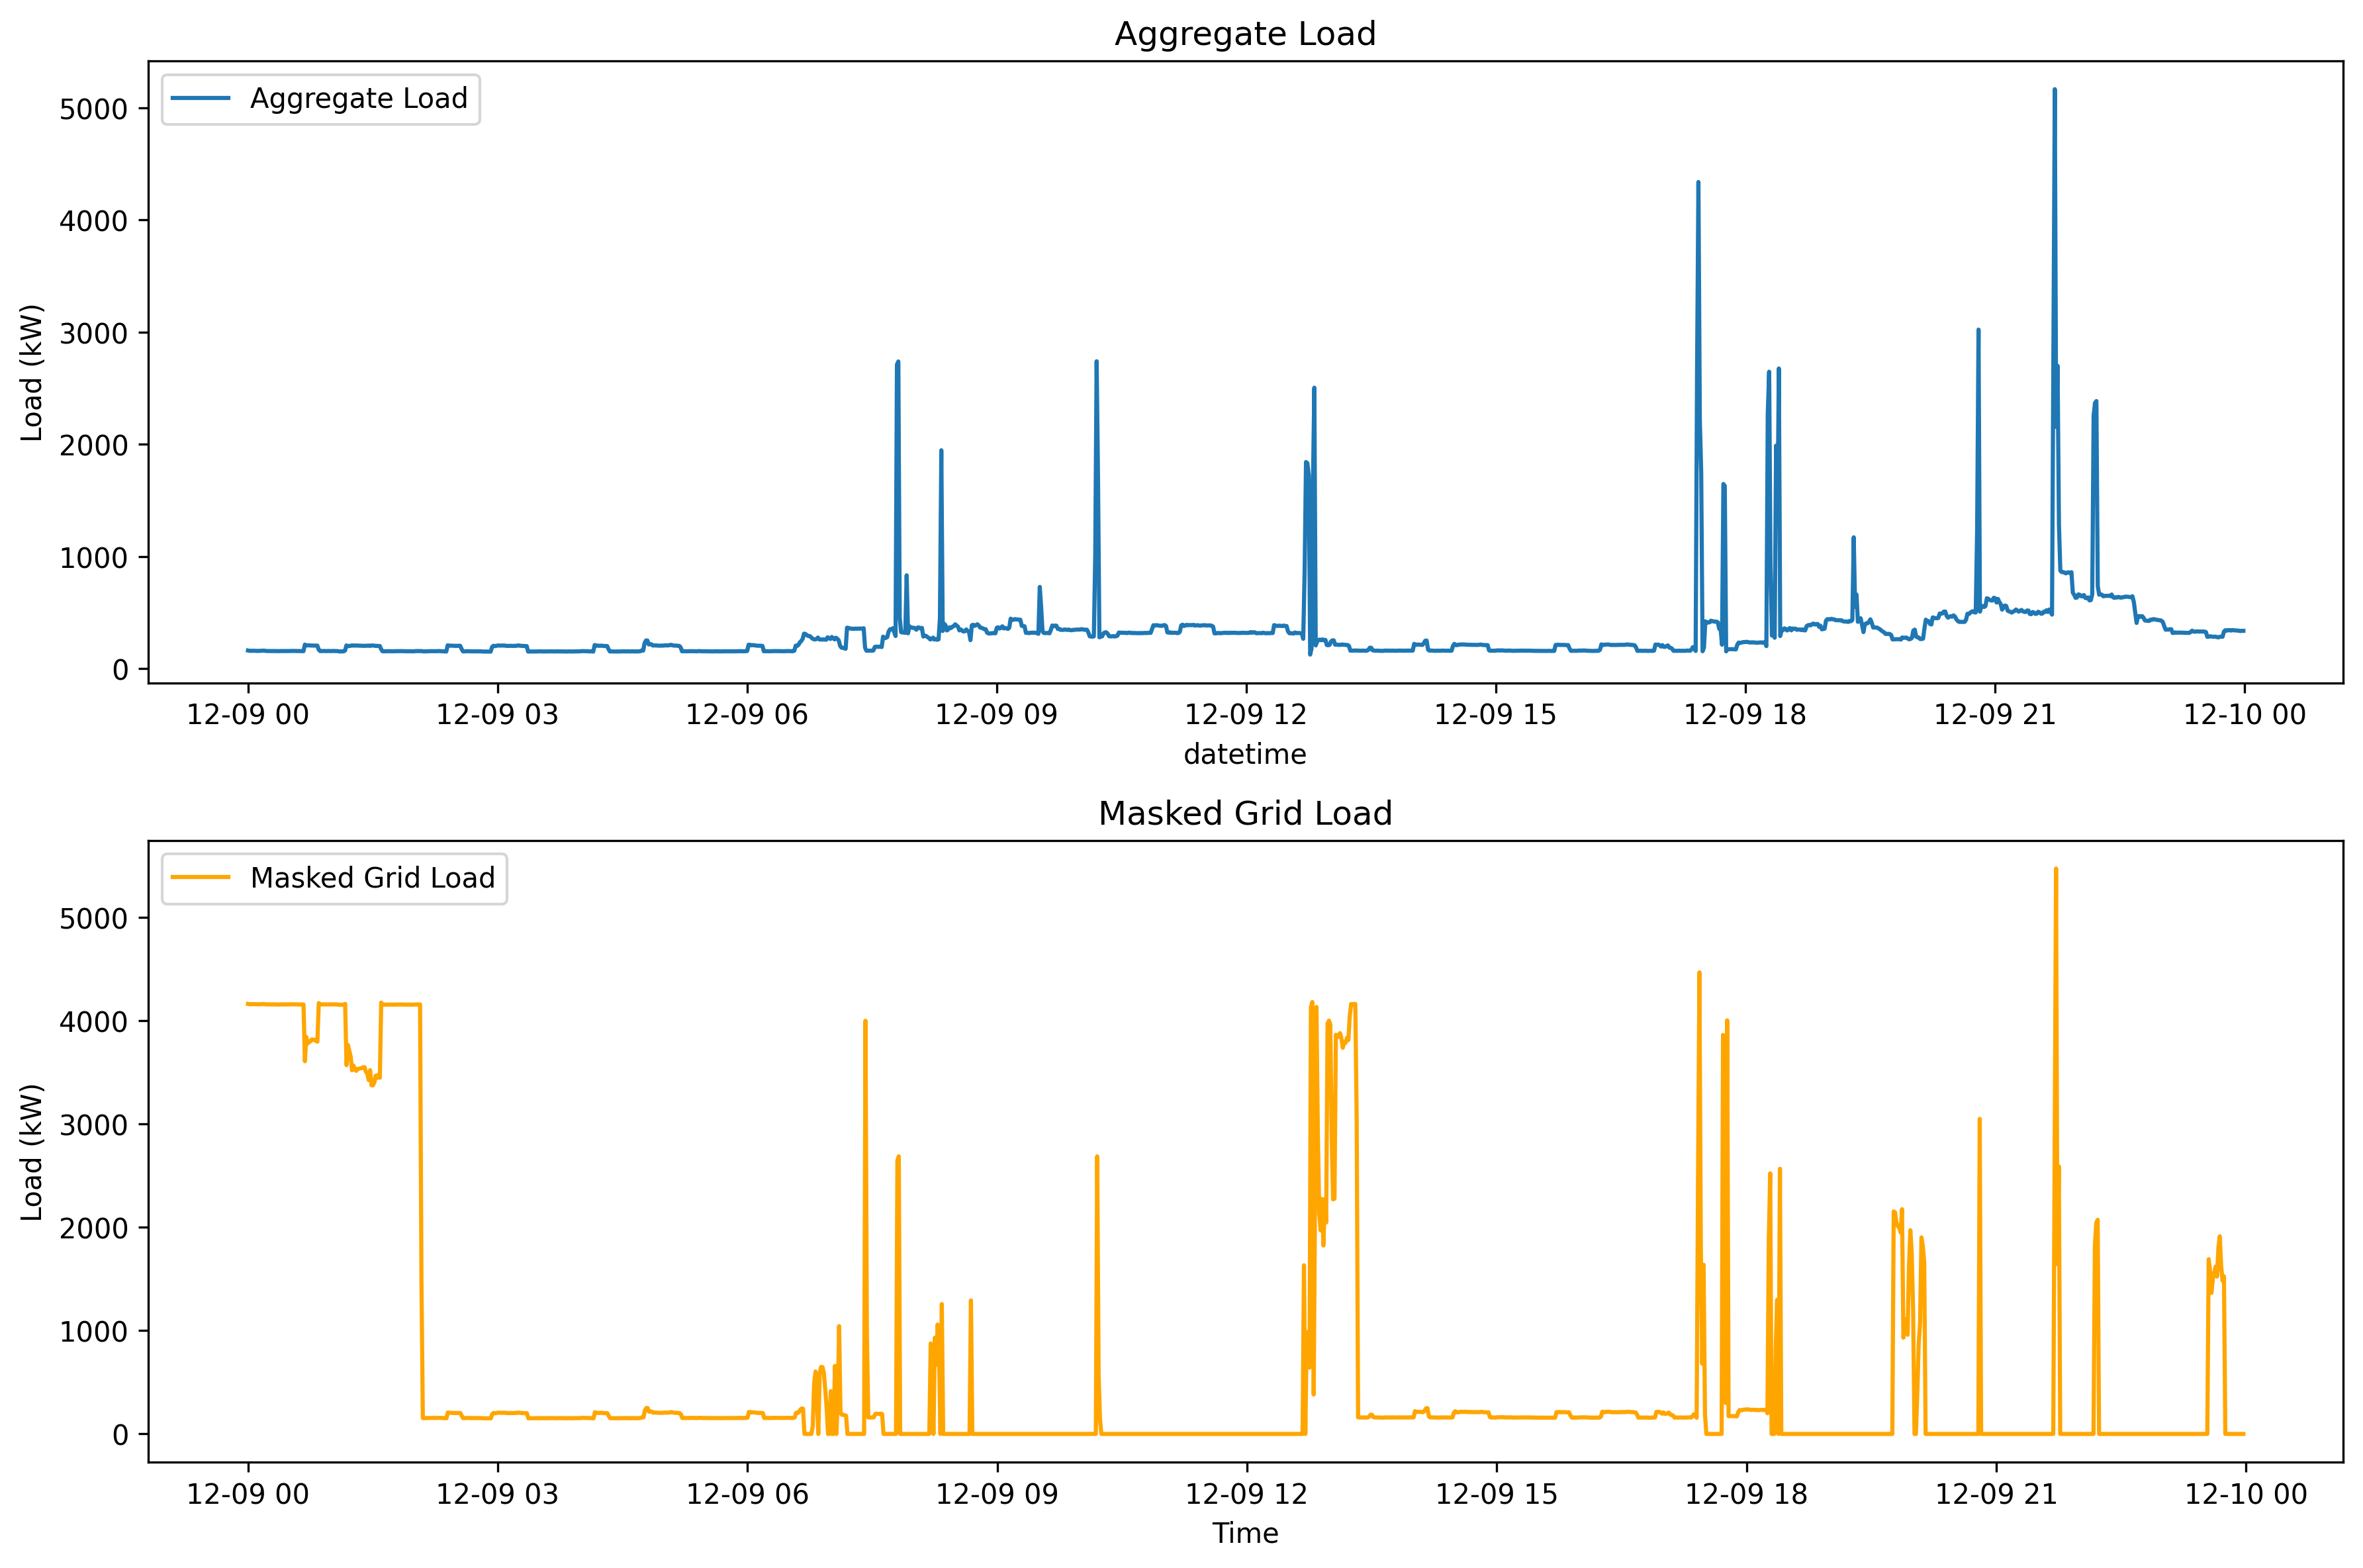

In [ ]:
# create a plot with two subplots
# on top plot the aggregate load
# on bottom plot the masked grid load
# to better visualize the difference between the two

import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=300)
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['aggregate'], ax=ax1, label='Aggregate Load')
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['grid_load'], ax=ax2, label='Masked Grid Load', color='orange')

ax1.set_title('Aggregate Load')
ax1.set_ylabel('Load (kW)')
ax1.legend()
ax2.set_title('Masked Grid Load')
ax2.set_xlabel('Time')
ax2.set_ylabel('Load (kW)')
ax2.legend()
plt.tight_layout()
plt.show()

In [60]:
# save the graph

env_valid.save_graph(
    {"fname": str(experiment_folder / f"graph_valid_index_{env_valid.selected_idx}.png"),
     "dpi": 300}
)

In [55]:
env_valid.close()

[2025-07-18 03:31:54:177] [SmartMeterWorld] Environment closed.


---

In [ ]:
# load the model & environment
import sys
sys.path.append(str(Path('rl_env')))

from rl_env.hrl_env import SmartMeterWorld
from stable_baselines3 import PPO
from model.H_network.h_network_arch import HNetworkType

env_test = SmartMeterWorld(
    sm_dl_test,
    h_model_type=HNetworkType.H_NETWORK,
    render_mode="human",
)

env_test.set_h_network(h_network)
env_test.set_h_network_stdscaler(h_network_stdscaler)

rl_model_path = Path("rl_model", "PPO", f"{datetime(2025,7,12,18,25,2).strftime('%Y%m%d_%H%M%S')}", "rl_model.zip")
rl_model_loaded = PPO.load(rl_model_path, env=env_test)

In [ ]:
obs, info = env_test.reset(43)

In [ ]:
info

In [ ]:
env_test.reset_render_window()

In [ ]:
env_test.episode.df

In [ ]:
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model_loaded.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_test.step(action)
        print_log(f"Step: {env_test.episode.get_current_step()}, Action: {action}, Reward: {reward}, Info: {info}")
        env_test.render()

In [ ]:
env_test.save_graph(
    str(Path("rl_model", "PPO", f"{rl_datetime.strftime('%Y%m%d_%H%M%S')}", "graph_test.png"))
)

In [ ]:
env_test.close()